# Repo Metrics based Issue Link prediction with Heterogeneous GraphSAGE (HinSAGE)

## Import repos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH = "/content/drive/MyDrive/TOM"

import os.path

In [3]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.3 MB/s 
     |████████████████████████████████| 482 kB 48.9 MB/s 
     |████████████████████████████████| 41 kB 558 kB/s 


In [4]:
#!pip install PyGithub -q
#!pip install tomotopy -q
#!pip install pyldavis -q
#!pip install wordcloud -q
#!pip install -U sentence-transformers -q
#!pip install fasttext -q
!pip install gensim -q

In [5]:
import pandas as pd
import sklearn 
import numpy as np
#import tomotopy as tp
#print(tp.isa) # prints 'avx2', 'avx', 'sse2' or 'none' # processing instruction set

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm import tqdm
from collections import Counter
#import pyLDAvis
#from wordcloud import WordCloud
import gensim
import os.path
#from sentence_transformers import SentenceTransformer
import urllib
import pickle
import gensim
#import fasttext

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [7]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

Specify the minibatch size (number of repo-issue links per minibatch) and the number of epochs for training the ML model:

In [8]:
batch_size = 200
epochs = 20
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

## Load the Issue Topic model

In [9]:
!pip install tomotopy -q

import tomotopy as tp

     |████████████████████████████████| 16.3 MB 4.0 MB/s 


In [10]:
lda_model_path = os.path.join(PATH, "models", "issues_lda.bin")

lda_model_path

'/content/drive/MyDrive/TOM/models/issues_lda.bin'

In [11]:
lda = tp.LDAModel.load(lda_model_path)

In [12]:
#unseen_doc = lda.make_doc(['i', 'died'])
#predicted_topic, ll = lda.infer(unseen_doc)
#
#predicted_topic, ll

In [13]:
#np.argmax(predicted_topic)

In [14]:
lda.get_topic_words(17)

[('build', 0.04298890754580498),
 ('cpp', 0.036653921008110046),
 ('lib', 0.03439142554998398),
 ('library', 0.03408975899219513),
 ('src', 0.027603941038250923),
 ('unknown', 0.025341447442770004),
 ('error', 0.02051479183137417),
 ('include', 0.02051479183137417),
 ('linux', 0.019760627299547195),
 ('usr', 0.019458960741758347)]

In [15]:
lda.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 11388 docs, 496509 words
| Total Vocabs: 32951, Used Vocabs: 3685
| Entropy of words: 7.18779
| Entropy of term-weighted words: 7.18779
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 2000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.47679
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 10 (minimum collection frequency of words)
| min_df: 10 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 64 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.02424421 0.

Load the mapping repo - issue

In [16]:
mapping_path = os.path.join(PATH, "models", "repo_issue.csv") 

mapping = pd.read_csv(mapping_path) #, index_col = 'issue')
#mapping[mapping.loc[mapping.index.drop_duplicates()].index.duplicated()]

mapping

,issue,topic
0,4,42
1,5,42
2,7,56
3,8,18
4,12,21
...,...,...
11383,46956,60
11384,46957,60
11385,46959,48
11386,46961,11


In [17]:
# mapping = mapping.loc[mapping.issue.drop_duplicates().index]
mapping = mapping.set_index('issue')

In [18]:
mapping

,topic
issue,
4,42
5,42
7,56
8,18
12,21
...,...
46956,60
46957,60
46959,48


## Load the dataset

Load the repo measurements 

In [19]:
metrics_path = os.path.join(PATH, "metrics", "metrics.csv")
bugissues_path = os.path.join(PATH, "issues", "bugissues.csv")




metrics_path = os.path.join(PATH, "metrics", "metrics.csv")
issues_path = os.path.join(PATH, "issues", "issues.csv")

In [20]:
metrics_path = os.path.join(metrics_path)

metrics = pd.read_csv(metrics_path, index_col = "repo_fullname").iloc[:, :-1]

metrics

,commits_avg_added,commits_avg_files_changed,commits_avg_message_length,commits_avg_per_day_real,commits_avg_removed,commits_count,commits_days_since_first,commits_days_since_last,commits_max_per_day,commits_total_lines_added,...,repo_workflows,stars_avg_per_day_real,stars_count,stars_max_per_day,wf_avg_duration,wf_avg_fails_per_day,wf_avg_failure_duration,wf_avg_success_duration,wf_avg_successes_per_day_real,wf_count
repo_fullname,,,,,,,,,,,,,,,,,,,,,
A13253565831/wxapp_newRestaurant,12,1,16,1,12,1,1628,1628,1,12,...,0,1,143,2,0.000000,0,0.0,0.000000,0,0
cryptokylin/CryptoKylin-Testnet,8,2,22,1,26,1,887,887,1,8,...,0,1,143,4,0.000000,0,0.0,0.000000,0,0
react-toolbox/react-toolbox-example,38,4,52,2,34,45,2341,1866,6,1702,...,0,1,146,3,0.000000,0,0.0,0.000000,0,0
kubernetes/committee-security-response,1,1,63,1,1,1,28,28,1,1,...,0,1,100,19,0.000000,0,0.0,0.000000,0,0
xiaolai/help-to-be-helped,48,1,12,4,3,21,791,724,9,999,...,0,1,145,19,0.000000,0,0.0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
danielsdeleo/deep_merge,47,2,71,2,27,82,4529,83,13,3871,...,1,1,147,14,0.005069,0,0.0,0.005069,14,2
pltrdy/files2rouge,516,2,79,2,15,63,1908,267,6,32527,...,0,1,150,3,0.000000,0,0.0,0.000000,0,0
lh3/readfq,44,1,39,5,12,27,3866,966,9,1194,...,0,1,143,8,0.000000,0,0.0,0.000000,0,0


Load the issues data

In [21]:
#issues_path = os.path.join(PATH, "tom_issues_infos_202205121552.csv")
#issues_path = os.path.join(issues_path)

issues = pd.read_csv(issues_path) 
bugissues = pd.read_csv(bugissues_path, index_col = 0)
bugissues.head()
bugissues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11417 entries, 4 to 46963
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       11417 non-null  object 
 1   repository_url            11417 non-null  object 
 2   labels_url                11417 non-null  object 
 3   comments_url              11417 non-null  object 
 4   events_url                11417 non-null  object 
 5   html_url                  11417 non-null  object 
 6   id                        11417 non-null  int64  
 7   node_id                   11417 non-null  object 
 8   number                    11417 non-null  int64  
 9   title                     11417 non-null  object 
 10  user                      11417 non-null  object 
 11  labels                    11417 non-null  object 
 12  state                     11417 non-null  object 
 13  locked                    11417 non-null  bool   
 14  assign

In [22]:
issues.loc[bugissues.index].drop_duplicates()

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
5,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",470708414,"""MDU6SXNzdWU0NzA3MDg0MTQ=""",40,"""Cannot create an account - \""unsupported acco...",...,"""2021-06-08T10:39:01Z""",NaN,"""NONE""",NaN,"""Hello,\r\nI'm most likely just not following ...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
7,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",436106223,"""MDU6SXNzdWU0MzYxMDYyMjM=""",38,"""The backup link is Invalid !!""",...,"""2019-04-23T10:09:27Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
8,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",398723647,"""MDU6SXNzdWUzOTg3MjM2NDc=""",37,"""The backup link is Invalid !!""",...,"""2019-01-14T01:31:33Z""",NaN,"""NONE""",NaN,"""https://storage.googleapis.com/eos-kylin-back...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
12,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",386056537,"""MDU6SXNzdWUzODYwNTY1Mzc=""",33,"""cant create account""",...,"""2018-12-08T08:45:13Z""","""2018-12-08T08:45:13Z""","""NONE""",NaN,"""is the service down?\r\n\r\n<!DOCTYPE html>\r...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46956,"""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rouge""","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://github.com/pltrdy/files2rouge/issues/8""",318642759,"""MDU6SXNzdWUzMTg2NDI3NTk=""",8,"""Unexpected keyword argument 'log_level'""",...,"""2018-05-02T20:43:01Z""","""2018-05-02T20:42:23Z""","""CONTRIBUTOR""",NaN,"""The `log_level` argument passed to pyrouge.Ro...","{""url"": 

In [23]:
bugissues = bugissues.loc[mapping.index]

In [24]:
bugissues

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
issue,,,,,,,,,,,,,,,,,,,,,
4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
5,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",470708414,"""MDU6SXNzdWU0NzA3MDg0MTQ=""",40,"""Cannot create an account - \""unsupported acco...",...,"""2021-06-08T10:39:01Z""",NaN,"""NONE""",NaN,"""Hello,\r\nI'm most likely just not following ...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
7,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",436106223,"""MDU6SXNzdWU0MzYxMDYyMjM=""",38,"""The backup link is Invalid !!""",...,"""2019-04-23T10:09:27Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
8,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",398723647,"""MDU6SXNzdWUzOTg3MjM2NDc=""",37,"""The backup link is Invalid !!""",...,"""2019-01-14T01:31:33Z""",NaN,"""NONE""",NaN,"""https://storage.googleapis.com/eos-kylin-back...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
12,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",386056537,"""MDU6SXNzdWUzODYwNTY1Mzc=""",33,"""cant create account""",...,"""2018-12-08T08:45:13Z""","""2018-12-08T08:45:13Z""","""NONE""",NaN,"""is the service down?\r\n\r\n<!DOCTYPE html>\r...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46956,"""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rouge""","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://github.com/pltrdy/files2rouge/issues/8""",318642759,"""MDU6SXNzdWUzMTg2NDI3NTk=""",8,"""Unexpected keyword argument 'log_level'""",...,"""2018-05-02T20:43:01Z""","""2018-05-02T20:42:23Z""","""CONTRIBUTOR""",NaN,"""The `log_level` argument passed to

In [25]:
bugissues['repo_fullname'] = bugissues["repository_url"].apply(json.loads).apply(lambda x : x[29:])

In [26]:
bugissues.columns

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'reactions', 'timeline_url',
       'performed_via_github_app', 'draft', 'pull_request', 'repo_fullname'],
      dtype='object')

Reindex the issues df

In [27]:
from collections import Counter

bugissues['repo_fullname'] = bugissues['repo_fullname'] #issues['repository']

counter = Counter(bugissues['repo_fullname'])
l = []
print(counter) 
for k, v in counter.items():
  c = 0
  for i in range(v):
    l.append(k + "/" + str(c))
    c += 1

bugissues['repo_fullname'] = l
bugissues = bugissues.set_index("repo_fullname")
bugissues.head()

Counter({'Crocoblock/suggestions': 1131, 'tullamods/Bagnon': 913, 'ViaVersion/ViaRewind': 262, 'somewherewarm/woocommerce-subscribe-all-the-things': 156, 'sveale/remote-edit': 132, 'viritin/viritin': 96, 'PolymerElements/neon-animation': 96, 'konveyor/pelorus': 92, 'notanumber/xapian-haystack': 85, 'jasonrollins/shareplum': 85, 'CodetrixStudio/CapacitorGoogleAuth': 84, 'samczsun/Skype4J': 83, 'meshtastic/Meshtastic-python': 78, 'PolymerElements/app-route': 71, 'bitnami/bitnami-docker-airflow': 71, 'vert-x3/vertx-mqtt': 68, 'Automattic/vip-scanner': 66, 'snoyberg/yaml': 65, 'claudiosanches/woocommerce-correios': 64, 'anteo/redmine_custom_workflows': 64, 'coreGreenberet/homematicip-rest-api': 62, 'aws/aws-aspnet-cognito-identity-provider': 61, 'tjmarkham/win10widgets': 60, 'sergeyt/meteor-typeahead': 57, 'ckan/ckanapi': 56, 'RobHofmann/HomeAssistant-GreeClimateComponent': 54, 'nricciar/wikicloth': 53, 'rednez/angular-user-idle': 52, 'vojtech-dobes/nette.ajax.js': 52, 'SpectoLabs/hoverfly

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
repo_fullname,,,,,,,,,,,,,,,,,,,,,
cryptokylin/CryptoKylin-Testnet/0,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/1,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",470708414,"""MDU6SXNzdWU0NzA3MDg0MTQ=""",40,"""Cannot create an account - \""unsupported acco...",...,"""2021-06-08T10:39:01Z""",NaN,"""NONE""",NaN,"""Hello,\r\nI'm most likely just not following ...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/2,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",436106223,"""MDU6SXNzdWU0MzYxMDYyMjM=""",38,"""The backup link is Invalid !!""",...,"""2019-04-23T10:09:27Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/3,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",398723647,"""MDU6SXNzdWUzOTg3MjM2NDc=""",37,"""The backup link is Invalid !!""",...,"""2019-01-14T01:31:33Z""",NaN,"""NONE""",NaN,"""https://storage.googleapis.com/eos-kylin-back...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",386056537,"""MDU6SXNzdWUzODYwNTY1Mzc=""",33,"""cant create account""",...,"""2018-12-08T08:45:13Z""","""2018-12-08T08:45:13Z""","""NONE""",NaN,"""is the service down?\r\n\r\n<!DOCTYPE html>\r...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN


In [28]:
issues

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
0,"""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://github.com/A13253565831/wxapp_newRest...",320470746,"""MDU6SXNzdWUzMjA0NzA3NDY=""",3,"""\u3010NOTICE\u3011This is a useless repository""",...,"""2018-05-05T01:58:20Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/A1325356...","""https://api.github.com/repos/A13253565831/wxa...",NaN,NaN,NaN
1,"""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://github.com/A13253565831/wxapp_newRest...",291596522,"""MDU6SXNzdWUyOTE1OTY1MjI=""",2,"""\u6709\u70b9\u5751\uff0c\u6839\u622a\u56fe\u6...",...,"""2018-11-27T06:46:20Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/A1325356...","""https://api.github.com/repos/A13253565831/wxa...",NaN,NaN,NaN
2,"""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://github.com/A13253565831/wxapp_newRest...",280055881,"""MDU6SXNzdWUyODAwNTU4ODE=""",1,"""\u4e0b\u8f7d\u4e0b\u6765\u600e\u4e48\u662f\u8...",...,"""2018-10-14T12:59:29Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/A1325356...","""https://api.github.com/repos/A13253565831/wxa...",NaN,NaN,NaN
3,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",518667428,"""MDU6SXNzdWU1MTg2Njc0Mjg=""",42,"""Faucet Down""",...,"""2019-11-11T20:13:25Z""","""2019-11-11T20:13:24Z""","""NONE""",NaN,"""Hello all, it looks like the faucet is down a...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46981,"""https://api.github.com/repos/chuzhixin/vue-ad...","""https://api.github.com/repos/chuzhixin/vue-ad...","""https://api.github.com/repos/chuzhixin/vue-ad...","""https://api.github.com/repos/chuzhixin/vue-ad...","""https://api.github.com/repos/chuzhixin/vue-ad...","""https://github.com/chuzhixin/vue-admin-better...",1144645513,"""PR_kwDOD3xFWM4zLAsC""",13,"""Bump url-parse from 1.4.7 to 1.5.7""",...,"""2022-02-27T21:08:47Z""","""2022-02-27T21:08:46Z""","""NONE""",NaN,"""Bumps [url-parse](https://github.com/unshifti...","{""url"": ""https://api.github.com/repos/chuzhixi...","""https://api.github.com/repos/chuzhixin/v

## Mapping

In [29]:
mapping

,topic
issue,
4,42
5,42
7,56
8,18
12,21
...,...
46956,60
46957,60
46959,48


Document Topics
Create topics id with corresponding words

In [30]:
dc = {} 
for i in range(mapping.shape[0]):
  t = mapping.values[i][0]
  issue = mapping.index[i]
  dc[t] = list(map(lambda x : x[0], lda.get_topic_words(t, top_n = 100)))

In [31]:
dc[0]

['animation',
 'route',
 'page',
 'app',
 'src',
 'alt',
 'img',
 'width',
 'neon',
 'html',
 'polymer',
 'element',
 'animated',
 'paper',
 'screen',
 'web',
 'shot',
 'component',
 'data',
 'location',
 'outcome',
 'iron',
 'slide',
 'expected',
 'url',
 'pm',
 'example',
 'change',
 'bower',
 'demo',
 'description',
 'appium',
 'event',
 'import',
 'id',
 'path',
 'dialog',
 'property',
 'browser',
 'ie',
 'screenshot',
 'actual',
 'hash',
 'pattern',
 'carbon',
 'selected',
 'get',
 'instruction',
 'observer',
 'tail',
 'inspector',
 'use',
 'affected',
 'foo',
 'cause',
 'fired',
 'missing',
 'behavior',
 'inside',
 'live',
 'tag',
 'step',
 'apply',
 'dom',
 'navigation',
 'overlay',
 'fire',
 'reproduce',
 'finish',
 'polyfill',
 'transition',
 'router',
 'lite',
 'transform',
 'chrome',
 'effect',
 'child',
 'next',
 'turn',
 'params',
 'button',
 'base',
 'panel',
 'fade',
 'scale',
 'cancel',
 'check',
 'using',
 'micro',
 'clicked',
 'image',
 'content',
 'reset',
 'routing'

In [32]:
issues

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
0,"""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://github.com/A13253565831/wxapp_newRest...",320470746,"""MDU6SXNzdWUzMjA0NzA3NDY=""",3,"""\u3010NOTICE\u3011This is a useless repository""",...,"""2018-05-05T01:58:20Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/A1325356...","""https://api.github.com/repos/A13253565831/wxa...",NaN,NaN,NaN
1,"""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://github.com/A13253565831/wxapp_newRest...",291596522,"""MDU6SXNzdWUyOTE1OTY1MjI=""",2,"""\u6709\u70b9\u5751\uff0c\u6839\u622a\u56fe\u6...",...,"""2018-11-27T06:46:20Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/A1325356...","""https://api.github.com/repos/A13253565831/wxa...",NaN,NaN,NaN
2,"""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://api.github.com/repos/A13253565831/wxa...","""https://github.com/A13253565831/wxapp_newRest...",280055881,"""MDU6SXNzdWUyODAwNTU4ODE=""",1,"""\u4e0b\u8f7d\u4e0b\u6765\u600e\u4e48\u662f\u8...",...,"""2018-10-14T12:59:29Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/A1325356...","""https://api.github.com/repos/A13253565831/wxa...",NaN,NaN,NaN
3,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",518667428,"""MDU6SXNzdWU1MTg2Njc0Mjg=""",42,"""Faucet Down""",...,"""2019-11-11T20:13:25Z""","""2019-11-11T20:13:24Z""","""NONE""",NaN,"""Hello all, it looks like the faucet is down a...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46981,"""https://api.github.com/repos/chuzhixin/vue-ad...","""https://api.github.com/repos/chuzhixin/vue-ad...","""https://api.github.com/repos/chuzhixin/vue-ad...","""https://api.github.com/repos/chuzhixin/vue-ad...","""https://api.github.com/repos/chuzhixin/vue-ad...","""https://github.com/chuzhixin/vue-admin-better...",1144645513,"""PR_kwDOD3xFWM4zLAsC""",13,"""Bump url-parse from 1.4.7 to 1.5.7""",...,"""2022-02-27T21:08:47Z""","""2022-02-27T21:08:46Z""","""NONE""",NaN,"""Bumps [url-parse](https://github.com/unshifti...","{""url"": ""https://api.github.com/repos/chuzhixi...","""https://api.github.com/repos/chuzhixin/v

Convert the topic top 100 words to pd.Series

In [33]:
topic_id_words = pd.Series(dc, name = 'topic')
# s2 = sentences
topic_id_words

42    [this, issue, work, problem, working, any, lik...
56    [version, latest, package, dependency, update,...
18    [string, type, data, json, value, name, parame...
21    [html, template, class, href, div, li, span, c...
24    [airflow, docker, info, compose, postgresql, c...
                            ...                        
63    [embedded, swimmingseadragon, bagnon, dev, san...
16    [none, highlight, logback, development, exe, c...
40    [java, org, junit, hoverfly, engine, platform,...
6     [dll, php, address, vendor, thread, magento, w...
53    [active, language, inactive, syntax, autocompl...
Name: topic, Length: 64, dtype: object

In [34]:
topic_id_words

42    [this, issue, work, problem, working, any, lik...
56    [version, latest, package, dependency, update,...
18    [string, type, data, json, value, name, parame...
21    [html, template, class, href, div, li, span, c...
24    [airflow, docker, info, compose, postgresql, c...
                            ...                        
63    [embedded, swimmingseadragon, bagnon, dev, san...
16    [none, highlight, logback, development, exe, c...
40    [java, org, junit, hoverfly, engine, platform,...
6     [dll, php, address, vendor, thread, magento, w...
53    [active, language, inactive, syntax, autocompl...
Name: topic, Length: 64, dtype: object

In [35]:
bugissues

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
repo_fullname,,,,,,,,,,,,,,,,,,,,,
cryptokylin/CryptoKylin-Testnet/0,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/1,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",470708414,"""MDU6SXNzdWU0NzA3MDg0MTQ=""",40,"""Cannot create an account - \""unsupported acco...",...,"""2021-06-08T10:39:01Z""",NaN,"""NONE""",NaN,"""Hello,\r\nI'm most likely just not following ...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/2,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",436106223,"""MDU6SXNzdWU0MzYxMDYyMjM=""",38,"""The backup link is Invalid !!""",...,"""2019-04-23T10:09:27Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/3,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",398723647,"""MDU6SXNzdWUzOTg3MjM2NDc=""",37,"""The backup link is Invalid !!""",...,"""2019-01-14T01:31:33Z""",NaN,"""NONE""",NaN,"""https://storage.googleapis.com/eos-kylin-back...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",386056537,"""MDU6SXNzdWUzODYwNTY1Mzc=""",33,"""cant create account""",...,"""2018-12-08T08:45:13Z""","""2018-12-08T08:45:13Z""","""NONE""",NaN,"""is the service down?\r\n\r\n<!DOCTYPE html>\r...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pltrdy/files2rouge/22,"""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rouge""","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://github.com/pltrdy/files2rouge/issues/8""",318642759,"""MDU6SXNzdW

In [36]:
metrics

,commits_avg_added,commits_avg_files_changed,commits_avg_message_length,commits_avg_per_day_real,commits_avg_removed,commits_count,commits_days_since_first,commits_days_since_last,commits_max_per_day,commits_total_lines_added,...,repo_workflows,stars_avg_per_day_real,stars_count,stars_max_per_day,wf_avg_duration,wf_avg_fails_per_day,wf_avg_failure_duration,wf_avg_success_duration,wf_avg_successes_per_day_real,wf_count
repo_fullname,,,,,,,,,,,,,,,,,,,,,
A13253565831/wxapp_newRestaurant,12,1,16,1,12,1,1628,1628,1,12,...,0,1,143,2,0.000000,0,0.0,0.000000,0,0
cryptokylin/CryptoKylin-Testnet,8,2,22,1,26,1,887,887,1,8,...,0,1,143,4,0.000000,0,0.0,0.000000,0,0
react-toolbox/react-toolbox-example,38,4,52,2,34,45,2341,1866,6,1702,...,0,1,146,3,0.000000,0,0.0,0.000000,0,0
kubernetes/committee-security-response,1,1,63,1,1,1,28,28,1,1,...,0,1,100,19,0.000000,0,0.0,0.000000,0,0
xiaolai/help-to-be-helped,48,1,12,4,3,21,791,724,9,999,...,0,1,145,19,0.000000,0,0.0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
danielsdeleo/deep_merge,47,2,71,2,27,82,4529,83,13,3871,...,1,1,147,14,0.005069,0,0.0,0.005069,14,2
pltrdy/files2rouge,516,2,79,2,15,63,1908,267,6,32527,...,0,1,150,3,0.000000,0,0.0,0.000000,0,0
lh3/readfq,44,1,39,5,12,27,3866,966,9,1194,...,0,1,143,8,0.000000,0,0.0,0.000000,0,0


In [37]:
mapping

,topic
issue,
4,42
5,42
7,56
8,18
12,21
...,...
46956,60
46957,60
46959,48


In [38]:
issues.loc[mapping.index]

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
issue,,,,,,,,,,,,,,,,,,,,,
4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
5,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",470708414,"""MDU6SXNzdWU0NzA3MDg0MTQ=""",40,"""Cannot create an account - \""unsupported acco...",...,"""2021-06-08T10:39:01Z""",NaN,"""NONE""",NaN,"""Hello,\r\nI'm most likely just not following ...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
7,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",436106223,"""MDU6SXNzdWU0MzYxMDYyMjM=""",38,"""The backup link is Invalid !!""",...,"""2019-04-23T10:09:27Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
8,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",398723647,"""MDU6SXNzdWUzOTg3MjM2NDc=""",37,"""The backup link is Invalid !!""",...,"""2019-01-14T01:31:33Z""",NaN,"""NONE""",NaN,"""https://storage.googleapis.com/eos-kylin-back...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
12,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",386056537,"""MDU6SXNzdWUzODYwNTY1Mzc=""",33,"""cant create account""",...,"""2018-12-08T08:45:13Z""","""2018-12-08T08:45:13Z""","""NONE""",NaN,"""is the service down?\r\n\r\n<!DOCTYPE html>\r...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46956,"""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rouge""","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://github.com/pltrdy/files2rouge/issues/8""",318642759,"""MDU6SXNzdWUzMTg2NDI3NTk=""",8,"""Unexpected keyword argument 'log_level'""",...,"""2018-05-02T20:43:01Z""","""2018-05-02T20:42:23Z""","""CONTRIBUTOR""",NaN,"""The `log_level` argument passed to

In [39]:
s1 = bugissues
s1

# s1 = issues.iloc[mapping.index]
# s1
#pd.concat([s2, s1], axis = 1)
#sentences], axis = 1)
#pd.merge(s1,s2, left_on = True, right_on = True)

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,updated_at,closed_at,author_association,active_lock_reason,body,reactions,timeline_url,performed_via_github_app,draft,pull_request
repo_fullname,,,,,,,,,,,,,,,,,,,,,
cryptokylin/CryptoKylin-Testnet/0,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",504437169,"""MDU6SXNzdWU1MDQ0MzcxNjk=""",41,"""Faucet not working for Kylin testnet""",...,"""2019-10-11T08:47:23Z""","""2019-10-11T08:47:23Z""","""NONE""",NaN,"""Hi, I'm trying the faucet APIs described here...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/1,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",470708414,"""MDU6SXNzdWU0NzA3MDg0MTQ=""",40,"""Cannot create an account - \""unsupported acco...",...,"""2021-06-08T10:39:01Z""",NaN,"""NONE""",NaN,"""Hello,\r\nI'm most likely just not following ...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/2,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",436106223,"""MDU6SXNzdWU0MzYxMDYyMjM=""",38,"""The backup link is Invalid !!""",...,"""2019-04-23T10:09:27Z""",NaN,"""NONE""",NaN,"""""","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/3,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",398723647,"""MDU6SXNzdWUzOTg3MjM2NDc=""",37,"""The backup link is Invalid !!""",...,"""2019-01-14T01:31:33Z""",NaN,"""NONE""",NaN,"""https://storage.googleapis.com/eos-kylin-back...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
cryptokylin/CryptoKylin-Testnet/4,"""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://api.github.com/repos/cryptokylin/Cryp...","""https://github.com/cryptokylin/CryptoKylin-Te...",386056537,"""MDU6SXNzdWUzODYwNTY1Mzc=""",33,"""cant create account""",...,"""2018-12-08T08:45:13Z""","""2018-12-08T08:45:13Z""","""NONE""",NaN,"""is the service down?\r\n\r\n<!DOCTYPE html>\r...","{""url"": ""https://api.github.com/repos/cryptoky...","""https://api.github.com/repos/cryptokylin/Cryp...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pltrdy/files2rouge/22,"""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rouge""","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://api.github.com/repos/pltrdy/files2rou...","""https://github.com/pltrdy/files2rouge/issues/8""",318642759,"""MDU6SXNzdW

In [40]:
temp = pd.Series(dc) 
temp

42    [this, issue, work, problem, working, any, lik...
56    [version, latest, package, dependency, update,...
18    [string, type, data, json, value, name, parame...
21    [html, template, class, href, div, li, span, c...
24    [airflow, docker, info, compose, postgresql, c...
                            ...                        
63    [embedded, swimmingseadragon, bagnon, dev, san...
16    [none, highlight, logback, development, exe, c...
40    [java, org, junit, hoverfly, engine, platform,...
6     [dll, php, address, vendor, thread, magento, w...
53    [active, language, inactive, syntax, autocompl...
Length: 64, dtype: object

In [41]:
mapping

,topic
issue,
4,42
5,42
7,56
8,18
12,21
...,...
46956,60
46957,60
46959,48


In [42]:
s2 = topic_id_words.loc[mapping.set_index('topic').index] 
s2

topic
42    [this, issue, work, problem, working, any, lik...
42    [this, issue, work, problem, working, any, lik...
56    [version, latest, package, dependency, update,...
18    [string, type, data, json, value, name, parame...
21    [html, template, class, href, div, li, span, c...
                            ...                        
60    [error, this, file, get, any, following, getti...
60    [error, this, file, get, any, following, getti...
48    [import, python, py, module, file, line, packa...
11    [file, line, py, lib, self, package, site, loc...
3     [search, name, query, str, result, text, int, ...
Name: topic, Length: 11388, dtype: object

In [43]:
from collections import Counter

#issues['repo_fullname'] = issues['repo_fullname'] #issues['repository']

counter = Counter(s1)
l = []
print(counter) 
for k, v in counter.items():
  c = 0
  for i in range(v):
    l.append(k + "/" + str(c))
    c += 1

#issues['repo_fullname'] = l
#issues = issues.set_index("repo_fullname")
#issues.head()
l

Counter({'url': 1, 'repository_url': 1, 'labels_url': 1, 'comments_url': 1, 'events_url': 1, 'html_url': 1, 'id': 1, 'node_id': 1, 'number': 1, 'title': 1, 'user': 1, 'labels': 1, 'state': 1, 'locked': 1, 'assignee': 1, 'assignees': 1, 'milestone': 1, 'comments': 1, 'created_at': 1, 'updated_at': 1, 'closed_at': 1, 'author_association': 1, 'active_lock_reason': 1, 'body': 1, 'reactions': 1, 'timeline_url': 1, 'performed_via_github_app': 1, 'draft': 1, 'pull_request': 1})


['url/0',
 'repository_url/0',
 'labels_url/0',
 'comments_url/0',
 'events_url/0',
 'html_url/0',
 'id/0',
 'node_id/0',
 'number/0',
 'title/0',
 'user/0',
 'labels/0',
 'state/0',
 'locked/0',
 'assignee/0',
 'assignees/0',
 'milestone/0',
 'comments/0',
 'created_at/0',
 'updated_at/0',
 'closed_at/0',
 'author_association/0',
 'active_lock_reason/0',
 'body/0',
 'reactions/0',
 'timeline_url/0',
 'performed_via_github_app/0',
 'draft/0',
 'pull_request/0']

In [44]:
from gensim.models import Word2Vec

#sentences = norm_issues # + ['UKN']
sentences = s2
size = 50 #100
window = 5
min_count = 0

model_cbow = Word2Vec(sentences, sg=0, size = size, window = window, min_count = min_count)

In [45]:
model_sg = Word2Vec(sentences, sg=1, size = size, window = window, min_count = min_count)

In [46]:
sentences

topic
42    [this, issue, work, problem, working, any, lik...
42    [this, issue, work, problem, working, any, lik...
56    [version, latest, package, dependency, update,...
18    [string, type, data, json, value, name, parame...
21    [html, template, class, href, div, li, span, c...
                            ...                        
60    [error, this, file, get, any, following, getti...
60    [error, this, file, get, any, following, getti...
48    [import, python, py, module, file, line, packa...
11    [file, line, py, lib, self, package, site, loc...
3     [search, name, query, str, result, text, int, ...
Name: topic, Length: 11388, dtype: object

In [47]:
#avg_norm_issues = []
#for i in range(len(norm_issues)):
  # try:
#  word = norm_issues.iloc[i]
  #   model.wv[word]
  # except:
  #   word = "UKN"
  #   pass
  # if norm_issues[i] in model.wv:
  #   word = norm_issues[i]
  # else:
  #   word = ""
  # print(word)
#  avg_norm_issues.append(np.mean(model_cbow.wv[word], axis=0))

In [48]:
avg_norm_issues = []
for i in range(len(sentences)):
  # try:
  word = sentences.iloc[i]
  #   model.wv[word]
  # except:
  #   word = "UKN"
  #   pass
  # if sentences[i] in model.wv:
  #   word = sentences[i]
  # else:
  #   word = ""
  # print(word)
  avg_norm_issues.append(np.mean(model_cbow.wv[word], axis=0))

In [49]:
# len(avg_norm_issues)

In [50]:
enc_issues = pd.DataFrame(avg_norm_issues, index = sentences.index) 
issues_nodes = enc_issues
enc_issues

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
topic,,,,,,,,,,,,,,,,,,,,,
42,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
42,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
56,-0.223491,0.026849,0.134340,-0.565489,-0.158993,0.056514,-0.207359,0.293512,0.535311,-0.318250,...,0.306419,0.599955,0.310033,0.943734,0.264621,-0.181825,1.058718,-0.831920,-0.140899,0.535578
18,-1.085351,-0.865002,-0.807561,-0.251742,0.195939,0.602346,0.281755,0.109316,0.482195,0.370758,...,0.640908,-0.239588,0.606104,0.553493,-0.542563,-0.435184,0.628211,-0.618524,-0.647043,-0.212659
21,0.159956,-0.917006,-0.386090,0.093092,0.045871,0.020493,-0.065762,0.091803,0.210766,0.583566,...,0.440833,0.346299,-0.062748,-0.315164,-0.858654,-0.400609,-0.151889,-0.353312,0.110839,-0.172290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
60,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
48,-0.292651,1.183857,-0.264139,-0.064724,-0.025165,0.107999,0.358887,-0.205629,0.273610,0.015692,...,0.618666,-0.008630,0.077881,0.240533,-0.271785,-0.377651,0.358866,-0.137296,-0.032354,0.629555


In [51]:
#enc_issues.index = bugissues.index

In [52]:
enc_issues

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
topic,,,,,,,,,,,,,,,,,,,,,
42,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
42,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
56,-0.223491,0.026849,0.134340,-0.565489,-0.158993,0.056514,-0.207359,0.293512,0.535311,-0.318250,...,0.306419,0.599955,0.310033,0.943734,0.264621,-0.181825,1.058718,-0.831920,-0.140899,0.535578
18,-1.085351,-0.865002,-0.807561,-0.251742,0.195939,0.602346,0.281755,0.109316,0.482195,0.370758,...,0.640908,-0.239588,0.606104,0.553493,-0.542563,-0.435184,0.628211,-0.618524,-0.647043,-0.212659
21,0.159956,-0.917006,-0.386090,0.093092,0.045871,0.020493,-0.065762,0.091803,0.210766,0.583566,...,0.440833,0.346299,-0.062748,-0.315164,-0.858654,-0.400609,-0.151889,-0.353312,0.110839,-0.172290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
60,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
48,-0.292651,1.183857,-0.264139,-0.064724,-0.025165,0.107999,0.358887,-0.205629,0.273610,0.015692,...,0.618666,-0.008630,0.077881,0.240533,-0.271785,-0.377651,0.358866,-0.137296,-0.032354,0.629555


In [53]:
metrics

,commits_avg_added,commits_avg_files_changed,commits_avg_message_length,commits_avg_per_day_real,commits_avg_removed,commits_count,commits_days_since_first,commits_days_since_last,commits_max_per_day,commits_total_lines_added,...,repo_workflows,stars_avg_per_day_real,stars_count,stars_max_per_day,wf_avg_duration,wf_avg_fails_per_day,wf_avg_failure_duration,wf_avg_success_duration,wf_avg_successes_per_day_real,wf_count
repo_fullname,,,,,,,,,,,,,,,,,,,,,
A13253565831/wxapp_newRestaurant,12,1,16,1,12,1,1628,1628,1,12,...,0,1,143,2,0.000000,0,0.0,0.000000,0,0
cryptokylin/CryptoKylin-Testnet,8,2,22,1,26,1,887,887,1,8,...,0,1,143,4,0.000000,0,0.0,0.000000,0,0
react-toolbox/react-toolbox-example,38,4,52,2,34,45,2341,1866,6,1702,...,0,1,146,3,0.000000,0,0.0,0.000000,0,0
kubernetes/committee-security-response,1,1,63,1,1,1,28,28,1,1,...,0,1,100,19,0.000000,0,0.0,0.000000,0,0
xiaolai/help-to-be-helped,48,1,12,4,3,21,791,724,9,999,...,0,1,145,19,0.000000,0,0.0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
danielsdeleo/deep_merge,47,2,71,2,27,82,4529,83,13,3871,...,1,1,147,14,0.005069,0,0.0,0.005069,14,2
pltrdy/files2rouge,516,2,79,2,15,63,1908,267,6,32527,...,0,1,150,3,0.000000,0,0.0,0.000000,0,0
lh3/readfq,44,1,39,5,12,27,3866,966,9,1194,...,0,1,143,8,0.000000,0,0.0,0.000000,0,0


In [54]:
#issues

In [55]:
# selected_commits = 
# commits[commits['full_name'].isin(repos)].groupby("full_name").first()

In [56]:
# # repos = set(commits['full_name'])

# selectedIssues = []
# selectedCommits = []

# for index, issue in tqdm(issues.iterrows()):
#   for idx, commit in commits.iterrows():
#     if (index not in selectedIssues and idx not in selectedCommits  and issue.repo_fullname == commit.full_name and issue.created_at > commit.commit_datetime):
#       selectedIssues.append(index)
#       selectedCommits.append(idx)


In [57]:
# selected_issues = issues[selectedIssues]
# selected_commits = issues[selectedCommits]

# HINSAGE

## Prepare nodes

In [58]:
issues_nodes = enc_issues

In [59]:
issues_nodes

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
topic,,,,,,,,,,,,,,,,,,,,,
42,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
42,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
56,-0.223491,0.026849,0.134340,-0.565489,-0.158993,0.056514,-0.207359,0.293512,0.535311,-0.318250,...,0.306419,0.599955,0.310033,0.943734,0.264621,-0.181825,1.058718,-0.831920,-0.140899,0.535578
18,-1.085351,-0.865002,-0.807561,-0.251742,0.195939,0.602346,0.281755,0.109316,0.482195,0.370758,...,0.640908,-0.239588,0.606104,0.553493,-0.542563,-0.435184,0.628211,-0.618524,-0.647043,-0.212659
21,0.159956,-0.917006,-0.386090,0.093092,0.045871,0.020493,-0.065762,0.091803,0.210766,0.583566,...,0.440833,0.346299,-0.062748,-0.315164,-0.858654,-0.400609,-0.151889,-0.353312,0.110839,-0.172290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
60,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
48,-0.292651,1.183857,-0.264139,-0.064724,-0.025165,0.107999,0.358887,-0.205629,0.273610,0.015692,...,0.618666,-0.008630,0.077881,0.240533,-0.271785,-0.377651,0.358866,-0.137296,-0.032354,0.629555


Learn the edges between repo metrics and issue embeddings

Since we do not have positive links in our dataset, We trained a neural network for learning the relationships by embeddings the embeddings of both metrics and issues and maximizing the similarity or covariance of the vectors.

In [60]:
enc_issues

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
topic,,,,,,,,,,,,,,,,,,,,,
42,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
42,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
56,-0.223491,0.026849,0.134340,-0.565489,-0.158993,0.056514,-0.207359,0.293512,0.535311,-0.318250,...,0.306419,0.599955,0.310033,0.943734,0.264621,-0.181825,1.058718,-0.831920,-0.140899,0.535578
18,-1.085351,-0.865002,-0.807561,-0.251742,0.195939,0.602346,0.281755,0.109316,0.482195,0.370758,...,0.640908,-0.239588,0.606104,0.553493,-0.542563,-0.435184,0.628211,-0.618524,-0.647043,-0.212659
21,0.159956,-0.917006,-0.386090,0.093092,0.045871,0.020493,-0.065762,0.091803,0.210766,0.583566,...,0.440833,0.346299,-0.062748,-0.315164,-0.858654,-0.400609,-0.151889,-0.353312,0.110839,-0.172290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
60,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
48,-0.292651,1.183857,-0.264139,-0.064724,-0.025165,0.107999,0.358887,-0.205629,0.273610,0.015692,...,0.618666,-0.008630,0.077881,0.240533,-0.271785,-0.377651,0.358866,-0.137296,-0.032354,0.629555


In [61]:
mapping

,topic
issue,
4,42
5,42
7,56
8,18
12,21
...,...
46956,60
46957,60
46959,48


In [62]:
enc_issues.index = bugissues.index

In [63]:
enc_issues

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
repo_fullname,,,,,,,,,,,,,,,,,,,,,
cryptokylin/CryptoKylin-Testnet/0,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
cryptokylin/CryptoKylin-Testnet/1,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
cryptokylin/CryptoKylin-Testnet/2,-0.223491,0.026849,0.134340,-0.565489,-0.158993,0.056514,-0.207359,0.293512,0.535311,-0.318250,...,0.306419,0.599955,0.310033,0.943734,0.264621,-0.181825,1.058718,-0.831920,-0.140899,0.535578
cryptokylin/CryptoKylin-Testnet/3,-1.085351,-0.865002,-0.807561,-0.251742,0.195939,0.602346,0.281755,0.109316,0.482195,0.370758,...,0.640908,-0.239588,0.606104,0.553493,-0.542563,-0.435184,0.628211,-0.618524,-0.647043,-0.212659
cryptokylin/CryptoKylin-Testnet/4,0.159956,-0.917006,-0.386090,0.093092,0.045871,0.020493,-0.065762,0.091803,0.210766,0.583566,...,0.440833,0.346299,-0.062748,-0.315164,-0.858654,-0.400609,-0.151889,-0.353312,0.110839,-0.172290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pltrdy/files2rouge/22,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
pltrdy/files2rouge/23,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
pltrdy/files2rouge/24,-0.292651,1.183857,-0.264139,-0.064724,-0.025165,0.107999,0.358887,-0.205629,0.273610,0.015692,...,0.618666,-0.008630,0.077881,0.240533,-0.271785,-0.377651,0.358866,-0.137296,-0.032354,0.629555


## Prepare edges

In [64]:
s2.index

Int64Index([42, 42, 56, 18, 21, 24, 60, 42, 42,  5,
            ...
            48, 60, 61, 48, 46, 60, 60, 48, 11,  3],
           dtype='int64', name='topic', length=11388)

In [65]:
# tt = enc_issues

# tt['new_id'] = tt.groupby(tt.columns.tolist(), sort=False).ngroup() + 1

# tt

In [66]:
# #NEW


# edges = pd.DataFrame(columns=["source", "target"])

# for issue in tt.index:
#   for metric in metrics.index:
#   #  print(s1[issue][0])
#     # print(issue)
#     # break


#   #  print() 
#     #break 
#     #if metric in conct.loc[issue]['repo_fullname'].values:
#     if (issue.startswith(metric)):
#       edges = edges.append({"source" : metric, "target" : "Issue-" + str(tt.loc[issue,"new_id"])}, ignore_index = True)
# # EDGES_PATH = os.path.join(PATH, "edges.csv")
# # edges.to_csv(EDGES_PATH, index = None)
#   # break

# edges

In [67]:
edges = pd.DataFrame(columns=["source", "target"])

for issue in enc_issues.index:
  for metric in metrics.index:
  #  print(s1[issue][0])
    # print(issue)
    # break


  #  print() 
    #break 
    #if metric in conct.loc[issue]['repo_fullname'].values:
    if (issue.startswith(metric)):
      edges = edges.append({"source" : metric, "target" : issue}, ignore_index = True)
# EDGES_PATH = os.path.join(PATH, "edges.csv")
# edges.to_csv(EDGES_PATH, index = None)
  # break

edges

,source,target
0,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/0
1,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/1
2,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/2
3,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/3
4,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/4
...,...,...
11326,pltrdy/files2rouge,pltrdy/files2rouge/22
11327,pltrdy/files2rouge,pltrdy/files2rouge/23
11328,pltrdy/files2rouge,pltrdy/files2rouge/24
11329,pltrdy/files2rouge,pltrdy/files2rouge/25


In [68]:
edges

,source,target
0,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/0
1,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/1
2,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/2
3,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/3
4,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/4
...,...,...
11326,pltrdy/files2rouge,pltrdy/files2rouge/22
11327,pltrdy/files2rouge,pltrdy/files2rouge/23
11328,pltrdy/files2rouge,pltrdy/files2rouge/24
11329,pltrdy/files2rouge,pltrdy/files2rouge/25


In [69]:
edgesA = edges

In [70]:
# edges = edges[:2500]

In [71]:
# Counter(edges.source).most_common()[:10]
# a = edges.source.nunique()
# edges.nunique()

# import random
# test_repos = random.sample(list(edges.source.unique()), 200)
# train_repos = edges.source[~edges.source.isin(test_repos)].unique()

# test_repos = edges[edges.source.isin(test_repos)]
# train_repos = edges[edges.source.isin(train_repos)]

# train_repos.to_csv(os.path.join(PATH, "repos", "train_repos_issues.csv"))
# test_repos.to_csv(os.path.join(PATH, "repos", "test_repos_issues.csv"))

# train_repos = pd.read_csv(os.path.join(PATH, "repos", "train_repos_issues.csv"))
# test_repos = pd.read_csv(os.path.join(PATH, "repos", "test_repos_issues.csv"))

# train_repos = random.sample(list(edges.source.unique()), 200)
# selected_edges = edges.source.unique()[:200]
# selected_edges = test_repos
# len(edges[edges.source.isin(selected_edges)]), len(edges[~edges.source.isin(selected_edges)])
# len(train_repos), len(test_repos)

(train_repos = 8616, test_repos = 2715)

In [72]:
# edges = train_repos
edges

,source,target
0,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/0
1,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/1
2,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/2
3,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/3
4,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/4
...,...,...
11326,pltrdy/files2rouge,pltrdy/files2rouge/22
11327,pltrdy/files2rouge,pltrdy/files2rouge/23
11328,pltrdy/files2rouge,pltrdy/files2rouge/24
11329,pltrdy/files2rouge,pltrdy/files2rouge/25


In [73]:
#@edges['target'] = mapping.

In [74]:
# metrics.loc['samgh/Byte-by-Byte-Solutions']
#edges[edges['source'] == 'samgh/Byte-by-Byte-Solutions']
# metrics.loc[edges['source']].rest
# metrics

## Scale repo measurements

In [75]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(metrics)
metrics_nodes = pd.DataFrame(scaler.transform(metrics), index = metrics.index)

# edges.source
metrics_nodes

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
repo_fullname,,,,,,,,,,,,,,,,,,,,,
A13253565831/wxapp_newRestaurant,-0.268741,-0.333333,-0.512195,-0.5,0.072072,-0.246377,-0.150094,0.442713,-0.444444,-0.220808,...,0.0,0.0,-0.333333,-0.2,0.000000,0.0,0.0,0.000000,0.0,0.0
cryptokylin/CryptoKylin-Testnet,-0.291372,0.000000,-0.365854,-0.5,0.576577,-0.246377,-0.616425,-0.082168,-0.444444,-0.221249,...,0.0,0.0,-0.333333,0.2,0.000000,0.0,0.0,0.000000,0.0,0.0
react-toolbox/react-toolbox-example,-0.121641,0.666667,0.365854,0.0,0.864865,0.391304,0.298615,0.611298,0.111111,-0.034551,...,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
kubernetes/committee-security-response,-0.330976,-0.333333,0.634146,-0.5,-0.324324,-0.246377,-1.157017,-0.690632,-0.444444,-0.222020,...,0.0,0.0,-7.500000,3.2,0.000000,0.0,0.0,0.000000,0.0,0.0
xiaolai/help-to-be-helped,-0.065064,-0.333333,-0.609756,1.0,-0.252252,0.043478,-0.676841,-0.197627,0.444444,-0.112030,...,0.0,0.0,0.000000,3.2,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
danielsdeleo/deep_merge,-0.070721,0.000000,0.829268,0.0,0.612613,0.927536,1.675582,-0.651673,0.888889,0.204497,...,1.0,0.0,0.333333,2.2,0.005069,0.0,0.0,0.005069,14.0,2.0
pltrdy/files2rouge,2.582744,0.000000,1.024390,0.0,0.180180,0.652174,0.026117,-0.521339,0.111111,3.362705,...,0.0,0.0,0.833333,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
lh3/readfq,-0.087694,-0.333333,0.048780,1.5,0.072072,0.130435,1.258339,-0.026209,0.444444,-0.090538,...,0.0,0.0,-0.333333,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [76]:
# metrics_nodes = metrics_nodes.loc[edges.source.unique()]
# metrics_nodes

In [77]:
# ii = metrics_nodes.index.set_names("repository")
# metrics_nodes = metrics_nodes.set_index(ii)
# # metrics_nodes
# # ii
# metrics_nodes

In [78]:
# metrics_nodes.loc["hasinhayder/themeforest-wp-theme-approval-checklist"]
# ii = metrics_nodes.index.drop_duplicates(keep="first")
# metrics_nodes.loc[ii]

In [79]:
#mapping.index = mapping["issue"] 
mapping

,topic
issue,
4,42
5,42
7,56
8,18
12,21
...,...
46956,60
46957,60
46959,48


Convert the columns to topic columns......

In [80]:
metrics_nodes

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
repo_fullname,,,,,,,,,,,,,,,,,,,,,
A13253565831/wxapp_newRestaurant,-0.268741,-0.333333,-0.512195,-0.5,0.072072,-0.246377,-0.150094,0.442713,-0.444444,-0.220808,...,0.0,0.0,-0.333333,-0.2,0.000000,0.0,0.0,0.000000,0.0,0.0
cryptokylin/CryptoKylin-Testnet,-0.291372,0.000000,-0.365854,-0.5,0.576577,-0.246377,-0.616425,-0.082168,-0.444444,-0.221249,...,0.0,0.0,-0.333333,0.2,0.000000,0.0,0.0,0.000000,0.0,0.0
react-toolbox/react-toolbox-example,-0.121641,0.666667,0.365854,0.0,0.864865,0.391304,0.298615,0.611298,0.111111,-0.034551,...,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
kubernetes/committee-security-response,-0.330976,-0.333333,0.634146,-0.5,-0.324324,-0.246377,-1.157017,-0.690632,-0.444444,-0.222020,...,0.0,0.0,-7.500000,3.2,0.000000,0.0,0.0,0.000000,0.0,0.0
xiaolai/help-to-be-helped,-0.065064,-0.333333,-0.609756,1.0,-0.252252,0.043478,-0.676841,-0.197627,0.444444,-0.112030,...,0.0,0.0,0.000000,3.2,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
danielsdeleo/deep_merge,-0.070721,0.000000,0.829268,0.0,0.612613,0.927536,1.675582,-0.651673,0.888889,0.204497,...,1.0,0.0,0.333333,2.2,0.005069,0.0,0.0,0.005069,14.0,2.0
pltrdy/files2rouge,2.582744,0.000000,1.024390,0.0,0.180180,0.652174,0.026117,-0.521339,0.111111,3.362705,...,0.0,0.0,0.833333,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
lh3/readfq,-0.087694,-0.333333,0.048780,1.5,0.072072,0.130435,1.258339,-0.026209,0.444444,-0.090538,...,0.0,0.0,-0.333333,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [81]:
issues_nodes

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
repo_fullname,,,,,,,,,,,,,,,,,,,,,
cryptokylin/CryptoKylin-Testnet/0,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
cryptokylin/CryptoKylin-Testnet/1,1.391716,-0.745533,0.037099,-0.510759,-0.113823,0.243973,0.222515,1.377460,-0.476487,-0.495396,...,0.071368,1.360858,-0.572038,-0.618755,0.439620,-0.473695,0.873179,-1.544189,-1.078024,0.411992
cryptokylin/CryptoKylin-Testnet/2,-0.223491,0.026849,0.134340,-0.565489,-0.158993,0.056514,-0.207359,0.293512,0.535311,-0.318250,...,0.306419,0.599955,0.310033,0.943734,0.264621,-0.181825,1.058718,-0.831920,-0.140899,0.535578
cryptokylin/CryptoKylin-Testnet/3,-1.085351,-0.865002,-0.807561,-0.251742,0.195939,0.602346,0.281755,0.109316,0.482195,0.370758,...,0.640908,-0.239588,0.606104,0.553493,-0.542563,-0.435184,0.628211,-0.618524,-0.647043,-0.212659
cryptokylin/CryptoKylin-Testnet/4,0.159956,-0.917006,-0.386090,0.093092,0.045871,0.020493,-0.065762,0.091803,0.210766,0.583566,...,0.440833,0.346299,-0.062748,-0.315164,-0.858654,-0.400609,-0.151889,-0.353312,0.110839,-0.172290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pltrdy/files2rouge/22,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
pltrdy/files2rouge/23,-0.417813,0.881113,0.043464,-0.468263,-0.793048,0.042862,0.361425,1.349022,-0.393533,-0.512293,...,0.290402,0.245557,-0.147413,0.253790,0.377966,-0.020013,1.298151,-2.038928,-1.127636,0.209491
pltrdy/files2rouge/24,-0.292651,1.183857,-0.264139,-0.064724,-0.025165,0.107999,0.358887,-0.205629,0.273610,0.015692,...,0.618666,-0.008630,0.077881,0.240533,-0.271785,-0.377651,0.358866,-0.137296,-0.032354,0.629555


## Construct the Graph

In [82]:
edges.shape,metrics_nodes.shape, issues_nodes.shape

((11331, 2), (970, 72), (11388, 50))

In [83]:
#all_edges = edges
# edges = all_edges
#import random 

#selected_repos = random.sample(list(edges.source.unique()) , 120) 

#edges = edges[edges.source.isin(selected_repos)]

#edges['temp'] = edges.source 
#edges.source = edges.target
#edges.target = edges.temp
#edges = edges[['source', 'target']] 
edges

,source,target
0,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/0
1,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/1
2,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/2
3,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/3
4,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/4
...,...,...
11326,pltrdy/files2rouge,pltrdy/files2rouge/22
11327,pltrdy/files2rouge,pltrdy/files2rouge/23
11328,pltrdy/files2rouge,pltrdy/files2rouge/24
11329,pltrdy/files2rouge,pltrdy/files2rouge/25


In [84]:
#all_metrics_nodes = metrics_nodes 
# metrics_nodes = all_metrics_nodes

# metrics_nodes = metrics_nodes.loc[edges.source.unique()]
metrics_nodes

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
repo_fullname,,,,,,,,,,,,,,,,,,,,,
A13253565831/wxapp_newRestaurant,-0.268741,-0.333333,-0.512195,-0.5,0.072072,-0.246377,-0.150094,0.442713,-0.444444,-0.220808,...,0.0,0.0,-0.333333,-0.2,0.000000,0.0,0.0,0.000000,0.0,0.0
cryptokylin/CryptoKylin-Testnet,-0.291372,0.000000,-0.365854,-0.5,0.576577,-0.246377,-0.616425,-0.082168,-0.444444,-0.221249,...,0.0,0.0,-0.333333,0.2,0.000000,0.0,0.0,0.000000,0.0,0.0
react-toolbox/react-toolbox-example,-0.121641,0.666667,0.365854,0.0,0.864865,0.391304,0.298615,0.611298,0.111111,-0.034551,...,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
kubernetes/committee-security-response,-0.330976,-0.333333,0.634146,-0.5,-0.324324,-0.246377,-1.157017,-0.690632,-0.444444,-0.222020,...,0.0,0.0,-7.500000,3.2,0.000000,0.0,0.0,0.000000,0.0,0.0
xiaolai/help-to-be-helped,-0.065064,-0.333333,-0.609756,1.0,-0.252252,0.043478,-0.676841,-0.197627,0.444444,-0.112030,...,0.0,0.0,0.000000,3.2,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
danielsdeleo/deep_merge,-0.070721,0.000000,0.829268,0.0,0.612613,0.927536,1.675582,-0.651673,0.888889,0.204497,...,1.0,0.0,0.333333,2.2,0.005069,0.0,0.0,0.005069,14.0,2.0
pltrdy/files2rouge,2.582744,0.000000,1.024390,0.0,0.180180,0.652174,0.026117,-0.521339,0.111111,3.362705,...,0.0,0.0,0.833333,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
lh3/readfq,-0.087694,-0.333333,0.048780,1.5,0.072072,0.130435,1.258339,-0.026209,0.444444,-0.090538,...,0.0,0.0,-0.333333,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [85]:
# new_issues_nodes = issues_nodes.drop_duplicates("new_id").set_index("new_id")
# new_issues_nodes.index = new_issues_nodes.index.map(lambda x : "Issue-"+str(x))
# new_issues_nodes

In [86]:
# # NEW


# # square_edges = pd.DataFrame(
# #     {"source": ["a", "b", "c", "d", "a"], "target": ["b", "c", "d", "a", "c"]}
# # )
# # square_edges
# from stellargraph import StellarGraph, StellarDiGraph

# # Embed the issues.
# #G = StellarDiGraph({"metric": metrics_nodes, "issue": issues_nodes}, edges=edges , edge_type_default="caused", )
# G = StellarGraph({"issue": new_issues_nodes, "metric": metrics_nodes}, edges=edges, edge_type_default="caused") #, is_directed=True)

In [87]:
# square_edges = pd.DataFrame(
#     {"source": ["a", "b", "c", "d", "a"], "target": ["b", "c", "d", "a", "c"]}
# )
# square_edges
from stellargraph import StellarGraph, StellarDiGraph

# Embed the issues.
#G = StellarDiGraph({"metric": metrics_nodes, "issue": issues_nodes}, edges=edges , edge_type_default="caused", )
G = StellarGraph({"issue": issues_nodes, "metric": metrics_nodes}, edges=edges, edge_type_default="caused") #, is_directed=True)

In [88]:
# G.

In [89]:
# G.in_nodes("issue")
G

In [90]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 12358, Edges: 11331

 Node types:
  issue: [11388]
    Features: float32 vector, length 50
    Edge types: issue-caused->metric
  metric: [970]
    Features: float32 vector, length 72
    Edge types: metric-caused->issue

 Edge types:
    issue-caused->metric: [11331]
        Weights: all 1 (default)
        Features: none


In [91]:
density = len(G.edges())/(len(G.nodes("issue"))*len(G.nodes("metric")))
print(density)

0.0010257677642227848


Split the edges into train and test sets for model training/evaluation:

In [92]:
# G_graph.edges()

In [93]:
edges.values

array([['cryptokylin/CryptoKylin-Testnet',
        'cryptokylin/CryptoKylin-Testnet/0'],
       ['cryptokylin/CryptoKylin-Testnet',
        'cryptokylin/CryptoKylin-Testnet/1'],
       ['cryptokylin/CryptoKylin-Testnet',
        'cryptokylin/CryptoKylin-Testnet/2'],
       ...,
       ['pltrdy/files2rouge', 'pltrdy/files2rouge/24'],
       ['pltrdy/files2rouge', 'pltrdy/files2rouge/25'],
       ['pltrdy/files2rouge', 'pltrdy/files2rouge/26']], dtype=object)

In [94]:
metrics_nodes.index

Index(['A13253565831/wxapp_newRestaurant', 'cryptokylin/CryptoKylin-Testnet',
       'react-toolbox/react-toolbox-example',
       'kubernetes/committee-security-response', 'xiaolai/help-to-be-helped',
       'SpaceApps2016/Resources', 'chschoenenberger/covid19_dashboard',
       'sirkitree/angular-directive.g-signin', 'jorgevgut/airquality-mx',
       'llSourcell/AI_Writer',
       ...
       'doctrine/doctrine2-orm-tutorial', 'dgkanatsios/TowerDefense',
       'biola/rack-cas', 'caryyu/excel2pdf', 'meshtastic/Meshtastic-python',
       'danielsdeleo/deep_merge', 'pltrdy/files2rouge', 'lh3/readfq',
       'Jaskey/RocketMQDedupListener',
       'chuzhixin/vue-admin-beautiful-template'],
      dtype='object', name='repo_fullname', length=970)

In [95]:
import networkx as nx
import matplotlib.pyplot as plt

def disp_graph():
  B = nx.Graph()

  subset_color = ["blue", "red", "green"]

  B.add_nodes_from(list(metrics_nodes.index), bipartite=0)
  B.add_nodes_from(list(issues_nodes.index), bipartite=1)
  B.add_edges_from(edges.values)
  color = [subset_color[d] for v,d in B.nodes(data='bipartite')]

  plt.figure(figsize=(100, 100))
  
  nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, list(metrics_nodes.index)), with_labels = False, node_size=10, node_color = color)
  plt.savefig("Graph.svg", format="SVG", bbox_inches = 'tight')
# 
  # plt.show()

  return color



color = disp_graph()


Output hidden; open in https://colab.research.google.com to view.

In [96]:
Counter(color)

Counter({'blue': 970, 'red': 11388})

In [97]:
from stellargraph.data import EdgeSplitter
# edges_train
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.15, method="global", edge_label = "caused")

print(graph_test.info())

Network has 11331 edges of type caused
Network has 11331 edges of type caused
** Sampled 1699 positive and 1699 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 12358, Edges: 9632

 Node types:
  issue: [11388]
    Features: float32 vector, length 50
    Edge types: issue-caused->metric
  metric: [970]
    Features: float32 vector, length 72
    Edge types: metric-caused->issue

 Edge types:
    issue-caused->metric: [9632]
        Weights: all 1 (default)
        Features: none


In [98]:
# graph_test.info()
examples_test.shape

(3398, 2)

In [99]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.15, 
method="global" , edge_label = 'caused'
)

# edge_splitter_train = EdgeSplitter(graph_test)
# graph_train, examples, labels = edge_splitter_train.train_test_split(
#     p=0.1, method="global" , edge_label = 'caused'
# )

# (
#     examples_train,
#     examples_model_selection,
#     labels_train,
#     labels_model_selection,
# ) = model_selection.train_test_split(examples, labels, train_size=0.8, test_size=0.2)

print(graph_train.info())

Network has 9632 edges of type caused
Network has 9632 edges of type caused
** Sampled 1444 positive and 1444 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 12358, Edges: 8188

 Node types:
  issue: [11388]
    Features: float32 vector, length 50
    Edge types: issue-caused->metric
  metric: [970]
    Features: float32 vector, length 72
    Edge types: metric-caused->issue

 Edge types:
    issue-caused->metric: [8188]
        Weights: all 1 (default)
        Features: none


In [100]:
examples.shape

(2888, 2)

In [101]:
#examples_train, labels_train
edges

,source,target
0,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/0
1,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/1
2,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/2
3,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/3
4,cryptokylin/CryptoKylin-Testnet,cryptokylin/CryptoKylin-Testnet/4
...,...,...
11326,pltrdy/files2rouge,pltrdy/files2rouge/22
11327,pltrdy/files2rouge,pltrdy/files2rouge/23
11328,pltrdy/files2rouge,pltrdy/files2rouge/24
11329,pltrdy/files2rouge,pltrdy/files2rouge/25


In [102]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
     #   (
    #        "Model Selection",
   #        len(examples_model_selection),
        #    "Train Graph",
    #        "Test Graph",
    #        "Select the best Link Classifier model",
 #       ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,2888,Train Graph,Test Graph,Train the Link Classifier
Test set,3398,Test Graph,Full Graph,Evaluate the best Link Classifier


In [103]:
print(graph_train.info())

StellarGraph: Undirected multigraph
 Nodes: 12358, Edges: 8188

 Node types:
  issue: [11388]
    Features: float32 vector, length 50
    Edge types: issue-caused->metric
  metric: [970]
    Features: float32 vector, length 72
    Edge types: metric-caused->issue

 Edge types:
    issue-caused->metric: [8188]
        Weights: all 1 (default)
        Features: none


In [104]:
print(graph_test.info())

StellarGraph: Undirected multigraph
 Nodes: 12358, Edges: 9632

 Node types:
  issue: [11388]
    Features: float32 vector, length 50
    Edge types: issue-caused->metric
  metric: [970]
    Features: float32 vector, length 72
    Edge types: metric-caused->issue

 Edge types:
    issue-caused->metric: [9632]
        Weights: all 1 (default)
        Features: none


Our machine learning task of learning user-movie ratings can be framed as a supervised Link Attribute Inference: given a graph of user-movie ratings, we train a model for rating prediction using the ratings edges_train, and evaluate it using the test ratings edges_test. The model also requires the user-movie graph structure, to do the neighbour sampling required by the HinSAGE algorithm.

We create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" user-movie links to the input of HinSAGE: they take minibatches of user-movie links, sample 2-hop subgraphs of G with `(user, movie)` head nodes extracted from those user-movie links, and feed them, together with the corresponding user-movie ratings, to the input layer of the HinSAGE model, for SGD updates of the model parameters.

Specify the sizes of 1- and 2-hop neighbour samples for HinSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the HinSAGE model.

In [105]:
num_samples = [4, 4]

Create the generators to feed data from the graph to the Keras model. We need to specify the nodes types for the user-movie pairs that we will feed to the model. The `shuffle=True` argument is given to the `flow` method to improve training.

In [106]:
examples_test

array([['tullamods/Bagnon/700', 'tullamods/Bagnon'],
       ['exercism/windows-installer/6', 'exercism/windows-installer'],
       ['kalenjordan/custom-reports/10', 'kalenjordan/custom-reports'],
       ...,
       ['somewherewarm/woocommerce-subscribe-all-the-things/80',
        'harlequin-tech/arduino-usb'],
       ['Crocoblock/suggestions/629', 'pitiwazou/Scripts-Blender'],
       ['soapisnotfat/pytorch-cifar10/0', 'wenkesj/holdem']], dtype=object)

In [107]:
try:
  test_generator = HinSAGELinkGenerator(
   G, batch_size, num_samples, head_node_types = ['issue', 'metric'])
  generator = test_generator
  
  test_gen = test_generator.flow(examples_test, labels_test, shuffle=True)
except:
  test_generator = HinSAGELinkGenerator(
   G, batch_size, num_samples, head_node_types = ['metric', 'issue'])
  generator = test_generator
  
  test_gen = test_generator.flow(examples_test, labels_test, shuffle=True)
# finally:

#test_gen = generator.flow(examples_test, labels_test)

In [108]:
try:
  # generator = HinSAGELinkGenerator(
      # graph_test, batch_size, num_samples, head_node_types = ['issue', 'metric'])
  train_gen = generator.flow(examples, labels, shuffle=True)
except:
  # generator = HinSAGELinkGenerator(
  #   graph_test, batch_size, num_samples, head_node_types = ['metric', 'issue'])
  train_gen = generator.flow(examples, labels, shuffle=True)
# finally:

# test_gen = generator.flow(examples_test, labels_test)

In [109]:
len(labels_test)

3398

In [110]:
len(examples)

2888

<!-- # Prediction -->

In [111]:
# issues_nodes.index

In [112]:
# labels.shape
# ggen = generator.flow(ex)
# ps = model.predict(ggen)#> 0.5
# ps

In [113]:
# print(classification_report(ps, labels))

In [114]:
# len(labels)

In [115]:
# (examples,
# examples_test,
# labels,
# labels_test) = model_selection.train_test_split(np.array(edges), np.array([1] * len(edges)), train_size=0.8, test_size=0.2)



# generator = HinSAGELinkGenerator(
#   G, batch_size, num_samples, head_node_types = ['metric', 'issue'] 
# )
# #print(examples)
# train_gen = generator.flow(examples, labels, shuffle=True)
# test_gen = generator.flow(examples_test, labels_test)

In [116]:
train_gen.data_size, test_gen.data_size

(2888, 3398)

In [117]:
# len(examples)

Build the model by stacking a two-layer HinSAGE model and a link regression layer on top.

First, we define the HinSAGE part of the model, with hidden layer sizes of 32 for both HinSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive `dropout` rate, `0 < dropout < 1`)

Note that the length of `layer_sizes` list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the HinSAGE model.

In [118]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('issue', [2]),
 ('metric', [3]),
 ('metric', [4]),
 ('issue', [5]),
 ('issue', []),
 ('metric', [])]

In [119]:
generator.schema.schema

{'issue': [EdgeType(n1='issue', rel='caused', n2='metric')],
 'metric': [EdgeType(n1='metric', rel='caused', n2='issue')]}

In [120]:
hinsage_layer_sizes = [32, 32] #[8, 8] underfitting
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0)

In [121]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

Add the final estimator layer for predicting the ratings. The edge_embedding_method argument specifies the way in which node representations (node embeddings) are combined into link representations (recall that links represent user-movie ratings, and are thus pairs of (user, movie) nodes). In this example, we will use `concat`, i.e., node embeddings are concatenated to get link embeddings.

In [122]:

from stellargraph.layer import link_classification

# Final estimator layer
#score_prediction = link_regression(edge_embedding_method="concat")(x_out)
score_prediction = link_classification(edge_embedding_method="concat", output_act="sigmoid")(x_out)  # concat

link_classification: using 'concat' method to combine node embeddings into edge embeddings


Create the Keras model, and compile it by specifying the optimizer, loss function to optimise, and metrics for diagnostics:

#### Addittional section

In [123]:
# sentences

In [124]:
# sentences_text = pd.Series([" ".join(i) for i in sentences], index = sentences.index) 
# sentences_text

In [125]:

# import tensorflow as tf 

# BUFFER_SIZE = 10000
# BATCH_SIZE = 64 
# issues_dataset = tf.data.Dataset.from_tensor_slices(sentences_text)

# #test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# #for example, label in train_dataset.take(1):
# #  print('text: ', example.numpy())
# #  print('label: ', label.numpy())

# train_dataset = issues_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# #test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# VOCAB_SIZE = 1000 #1000
# encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length = VOCAB_SIZE)
# encoder.adapt(issues_dataset)

In [126]:
# # encoder,
# embedder = tf.keras.layers.Embedding(
#         #input_shape = (None, 1000),
#         input_dim=len(encoder.get_vocabulary()),
#         output_dim=60,
#         # Use masking#model = Model(inputs=x_inp, outputs=score_prediction) to handle the variable sequence lengths
#         mask_zero=True)

In [127]:
# learner = tf.keras.Sequential([
# tf.keras.Input(shape=(1, ), dtype = tf.string), 
# encoder, 
# embedder, 
# tf.keras.layers.LSTM(16), 
# tf.keras.layers.Reshape(target_shape = (1, 16))
# ])

# learner.summary() #, learner.output_shape

In [128]:
# embedder.input_shape

In [129]:
# learner.build()
# learner.output_shape

In [130]:
# x_inp

In [131]:
# import tensorflow.keras.backend as K
# import tensorflow as tf

# def root_mean_square_error(s_true, s_pred):
#     return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


# shift = 2
# def custom_metric(y_true,y_pred):
#     diff = K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1))
#     return K.mean(K.lesser_equal(diff, shift))


# #model = Model(inputs=x_inp, outputs=score_prediction)


# model1 = Model(inputs=x_inp, outputs=score_prediction)

# model2 = tf.keras.Sequential(
# tf.keras.Input(shape=(1,)), 
# learner, 
# #model1


# )

# model = Model(inputs= model2.input, outputs = model2.output)


# model.compile(
#     optimizer=optimizers.Adam(), # lr=1e-2
#     #loss=losses.mean_squared_error,
#     loss = losses.binary_crossentropy, 
#   #  metrics= [tf.keras.metrics.Accuracy()] #[root_mean_square_error], #, metrics.mae],
#    # matrics = [custom_metric],
#     metrics = ["acc"] 
# )

In [132]:
import tensorflow.keras.backend as K
import tensorflow as tf

def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


shift = 2
def custom_metric(y_true,y_pred):
    diff = K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1))
    return K.mean(K.lesser_equal(diff, shift))
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(), # lr=1e-2
    #loss=losses.mean_squared_error,
    loss = losses.binary_crossentropy, 
  #  metrics= [tf.keras.metrics.Accuracy()] #[root_mean_square_error], #, metrics.mae],
   # matrics = [custom_metric],
    metrics = ["acc", f1_m, precision_m, recall_m] 
)

Summary of the model:

In [133]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4, 72)]      0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 16, 50)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 16, 72)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1, 50)]      0           []                               
                                                                                              

In [134]:
# Specify the number of workers to use for model training
num_workers = 4

Evaluate the fresh (untrained) model on the test set (for reference):

In [135]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

17/17 [==============================] - 2s 29ms/step - loss: 0.6927 - acc: 0.4956 - f1_m: 0.6293 - precision_m: 0.4972 - recall_m: 0.8600
Untrained model's Test Evaluation:
	loss: 0.6927
	acc: 0.4956
	f1_m: 0.6293
	precision_m: 0.4972
	recall_m: 0.8600


In [136]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

17/17 [==============================] - 1s 42ms/step - loss: 0.6924 - acc: 0.4985 - f1_m: 0.6311 - precision_m: 0.4992 - recall_m: 0.8608
Untrained model's Test Evaluation:
	loss: 0.6924
	acc: 0.4985
	f1_m: 0.6311
	precision_m: 0.4992
	recall_m: 0.8608


Train the model by feeding the data from the graph in minibatches, using mapper_train, and get validation metrics after each epoch:

In [137]:
epochs = 100

In [138]:
train_gen.batch_size, train_gen.data_size

(200, 2888)

In [139]:
test_gen.batch_size, test_gen.data_size

(200, 3398)

## Train the model

In [ ]:
# [32, 32] layer size
es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 3, restore_best_weights = True) 
#epochs = 3

history = model.fit(
    train_gen,
    #validation_split=0.3,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es] 
  #  workers=num_workers,
)

Epoch 1/100
15/15 [==============================] - 4s 99ms/step - loss: 0.6977 - acc: 0.5409 - f1_m: 0.6655 - precision_m: 0.5295 - recall_m: 0.9048 - val_loss: 0.6846 - val_acc: 0.5697 - val_f1_m: 0.6308 - val_precision_m: 0.5513 - val_recall_m: 0.7392
Epoch 2/100
15/15 [==============================] - 2s 137ms/step - loss: 0.6732 - acc: 0.6170 - f1_m: 0.6382 - precision_m: 0.6113 - recall_m: 0.6733 - val_loss: 0.6642 - val_acc: 0.6351 - val_f1_m: 0.6389 - val_precision_m: 0.6310 - val_recall_m: 0.6493
Epoch 3/100
15/15 [==============================] - 2s 135ms/step - loss: 0.6519 - acc: 0.6679 - f1_m: 0.6830 - precision_m: 0.6558 - recall_m: 0.7145 - val_loss: 0.6435 - val_acc: 0.6963 - val_f1_m: 0.7205 - val_precision_m: 0.6684 - val_recall_m: 0.7846
Epoch 4/100
15/15 [==============================] - 2s 137ms/step - loss: 0.6310 - acc: 0.7316 - f1_m: 0.7616 - precision_m: 0.6895 - recall_m: 0.8534 - val_loss: 0.6230 - val_acc: 0.7357 - val_f1_m: 0.7649 - val_precision_m: 0.6

In [ ]:
# [8,8] layer size
es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 3, restore_best_weights = True) 
#epochs = 3

history = model.fit(
    train_gen,
    #validation_split=0.3,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es] 
  #  workers=num_workers,
)

Epoch 1/100
15/15 [==============================] - 6s 100ms/step - loss: 0.7126 - acc: 0.4529 - f1_m: 0.3756 - precision_m: 0.4363 - recall_m: 0.3326 - val_loss: 0.6947 - val_acc: 0.4829 - val_f1_m: 0.4678 - val_precision_m: 0.4823 - val_recall_m: 0.4558
Epoch 2/100
15/15 [==============================] - 1s 99ms/step - loss: 0.6896 - acc: 0.5222 - f1_m: 0.5372 - precision_m: 0.5219 - recall_m: 0.5606 - val_loss: 0.6775 - val_acc: 0.5524 - val_f1_m: 0.5932 - val_precision_m: 0.5440 - val_recall_m: 0.6548
Epoch 3/100
15/15 [==============================] - 1s 94ms/step - loss: 0.6739 - acc: 0.5793 - f1_m: 0.6225 - precision_m: 0.5596 - recall_m: 0.7066 - val_loss: 0.6650 - val_acc: 0.6145 - val_f1_m: 0.6677 - val_precision_m: 0.5859 - val_recall_m: 0.7789
Epoch 4/100
15/15 [==============================] - 1s 99ms/step - loss: 0.6627 - acc: 0.6215 - f1_m: 0.6658 - precision_m: 0.5933 - recall_m: 0.7615 - val_loss: 0.6556 - val_acc: 0.6377 - val_f1_m: 0.6812 - val_precision_m: 0.607

In [ ]:
# 64 vs 970
es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 3, restore_best_weights = True) 
#epochs = 3

history = model.fit(
    train_gen,
    #validation_split=0.3,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es] 
  #  workers=num_workers,
)

Epoch 1/100
2/2 [==============================] - 0s 216ms/step - loss: 0.6973 - acc: 0.4777 - f1_m: 0.3408 - precision_m: 0.4256 - recall_m: 0.2849 - val_loss: 0.6863 - val_acc: 0.5000 - val_f1_m: 0.3893 - val_precision_m: 0.4578 - val_recall_m: 0.3436
Epoch 2/100
2/2 [==============================] - 0s 114ms/step - loss: 0.6906 - acc: 0.4821 - f1_m: 0.3458 - precision_m: 0.6029 - recall_m: 0.2598 - val_loss: 0.6836 - val_acc: 0.5265 - val_f1_m: 0.3484 - val_precision_m: 0.4513 - val_recall_m: 0.2845
Epoch 3/100
2/2 [==============================] - 0s 118ms/step - loss: 0.6872 - acc: 0.4955 - f1_m: 0.3735 - precision_m: 0.3995 - recall_m: 0.3608 - val_loss: 0.6790 - val_acc: 0.5044 - val_f1_m: 0.3625 - val_precision_m: 0.4078 - val_recall_m: 0.3345
Epoch 4/100
2/2 [==============================] - 0s 204ms/step - loss: 0.6890 - acc: 0.5491 - f1_m: 0.5490 - precision_m: 0.6426 - recall_m: 0.4792 - val_loss: 0.6862 - val_acc: 0.5354 - val_f1_m: 0.4676 - val_precision_m: 0.4549 - v

In [ ]:
# NEW
es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 3, restore_best_weights = True) 
#epochs = 3

history = model.fit(
    train_gen,
    #validation_split=0.3,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es] 
  #  workers=num_workers,
)

Epoch 1/100
15/15 [==============================] - 4s 123ms/step - loss: 0.7169 - acc: 0.4713 - f1_m: 0.2559 - precision_m: 0.4197 - recall_m: 0.1912 - val_loss: 0.6998 - val_acc: 0.5041 - val_f1_m: 0.4229 - val_precision_m: 0.5058 - val_recall_m: 0.3653
Epoch 2/100
15/15 [==============================] - 2s 144ms/step - loss: 0.6914 - acc: 0.5398 - f1_m: 0.5147 - precision_m: 0.5398 - recall_m: 0.4967 - val_loss: 0.6813 - val_acc: 0.5680 - val_f1_m: 0.5740 - val_precision_m: 0.5655 - val_recall_m: 0.5859
Epoch 3/100
15/15 [==============================] - 2s 145ms/step - loss: 0.6726 - acc: 0.5866 - f1_m: 0.6019 - precision_m: 0.5758 - recall_m: 0.6317 - val_loss: 0.6649 - val_acc: 0.5912 - val_f1_m: 0.6179 - val_precision_m: 0.5808 - val_recall_m: 0.6629
Epoch 4/100
15/15 [==============================] - 2s 149ms/step - loss: 0.6556 - acc: 0.6572 - f1_m: 0.7002 - precision_m: 0.6275 - recall_m: 0.7967 - val_loss: 0.6494 - val_acc: 0.6954 - val_f1_m: 0.7380 - val_precision_m: 0.

In [ ]:
# EXP
es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 3, restore_best_weights = True) 
epochs = 3

history = model.fit(
    train_gen,
    #validation_split=0.3,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es] 
  #  workers=num_workers,
)

Epoch 1/3
46/46 [==============================] - 2s 48ms/step - loss: 0.0027 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 2/3
46/46 [==============================] - 2s 45ms/step - loss: 0.0026 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 3/3
46/46 [==============================] - 2s 39ms/step - loss: 0.0025 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000


In [ ]:
# FINAL
es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 3, restore_best_weights = True) 


history = model.fit(
    train_gen,
    #validation_split=0.3,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es] 
  #  workers=num_workers,
)

Epoch 1/1000
12/12 [==============================] - 3s 57ms/step - loss: 0.7242 - acc: 0.5171 - f1_m: 0.1692 - precision_m: 0.5054 - recall_m: 0.1024 - val_loss: 0.7087 - val_acc: 0.5313 - val_f1_m: 0.2240 - val_precision_m: 0.6488 - val_recall_m: 0.1359
Epoch 2/1000
12/12 [==============================] - 1s 86ms/step - loss: 0.7062 - acc: 0.5356 - f1_m: 0.2137 - precision_m: 0.6191 - recall_m: 0.1297 - val_loss: 0.6961 - val_acc: 0.5393 - val_f1_m: 0.2312 - val_precision_m: 0.6949 - val_recall_m: 0.1399
Epoch 3/1000
12/12 [==============================] - 1s 54ms/step - loss: 0.6912 - acc: 0.5491 - f1_m: 0.2456 - precision_m: 0.6654 - recall_m: 0.1518 - val_loss: 0.6795 - val_acc: 0.5598 - val_f1_m: 0.2839 - val_precision_m: 0.7539 - val_recall_m: 0.1762
Epoch 4/1000
12/12 [==============================] - 1s 81ms/step - loss: 0.6756 - acc: 0.5685 - f1_m: 0.3529 - precision_m: 0.7642 - recall_m: 0.2342 - val_loss: 0.6464 - val_acc: 0.6312 - val_f1_m: 0.4787 - val_precision_m: 0.

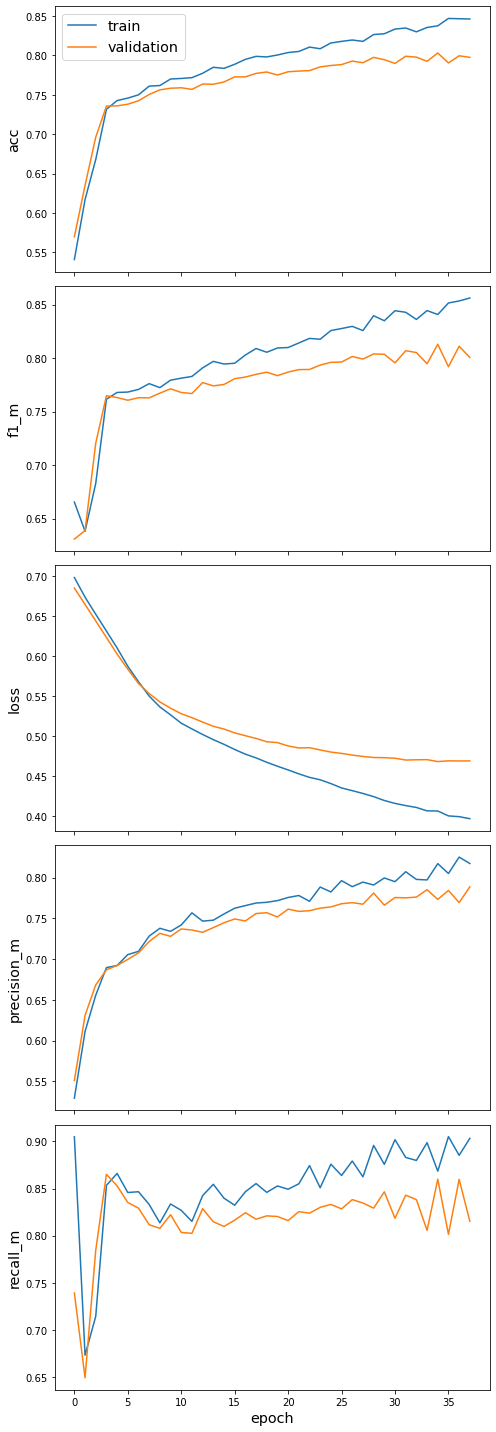

In [ ]:
#Linker 01 [32, 32]
sg.utils.plot_history(history)

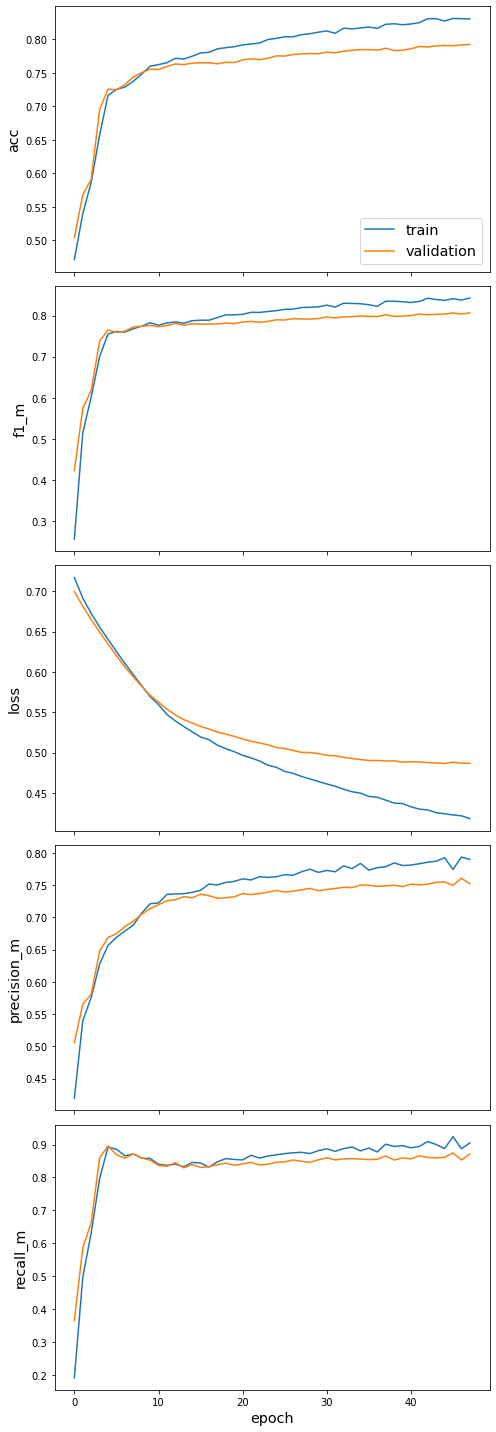

In [ ]:
#Linker 01 [16, 16]
sg.utils.plot_history(history)

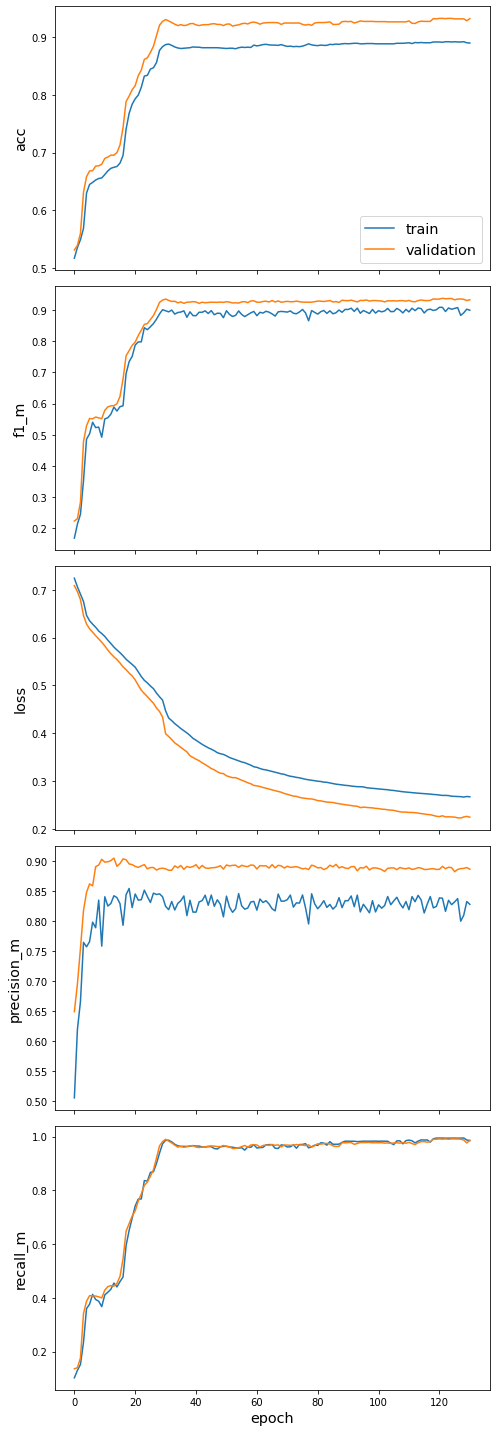

In [ ]:
#FINAL 
sg.utils.plot_history(history)

In [ ]:
# pd.DataFrame(history.history).to_csv(os.path.join(PATH, "Linker11Performance.csv"), index = False)

In [ ]:
pd.DataFrame(history.history).to_csv(os.path.join(PATH, "Linker01Performance.csv"), index = False)

In [ ]:
pd.DataFrame(history.history)

,loss,acc,f1_m,precision_m,recall_m,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m
0,0.724198,0.517133,0.169194,0.505400,0.102362,0.708666,0.531300,0.223970,0.648828,0.135933
1,0.706233,0.535618,0.213665,0.619137,0.129745,0.696131,0.539326,0.231231,0.694877,0.139863
2,0.691205,0.549143,0.245552,0.665439,0.151848,0.679497,0.559791,0.283873,0.753942,0.176168
3,0.675592,0.568530,0.352936,0.764223,0.234175,0.646352,0.631220,0.478678,0.817095,0.341032
4,0.646758,0.629847,0.486296,0.756793,0.359698,0.628481,0.658106,0.528984,0.847469,0.387458
...,...,...,...,...,...,...,...,...,...,...
126,0.268058,0.891344,0.907668,0.836993,0.993769,0.223421,0.931380,0.934888,0.885502,0.990742
127,0.267719,0.891344,0.882464,0.799453,0.994028,0.223109,0.931380,0.935161,0.886931,0.990075
128,0.266822,0.891794,0.890808,0.809418,0.994376,0.225214,0.931380,0.934135,0.887333,0.986915
129,0.268030,0.889991,0.902509,0.832150,0.987017,0.226517,0.928170,0.930140,0.888615,0.976176


In [ ]:

es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 3, restore_best_weights = True) 


history = model.fit(
    train_gen,
    #validation_split=0.3,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es] 
  #  workers=num_workers,
)

Epoch 1/1000
11/11 [==============================] - 6s 298ms/step - loss: 0.6666 - acc: 0.5348 - f1_m: 0.6269 - precision_m: 0.5137 - recall_m: 0.8151 - val_loss: 0.6513 - val_acc: 0.5229 - val_f1_m: 0.6166 - val_precision_m: 0.5135 - val_recall_m: 0.7765
Epoch 2/1000
11/11 [==============================] - 3s 298ms/step - loss: 0.6309 - acc: 0.5618 - f1_m: 0.6469 - precision_m: 0.5412 - recall_m: 0.8081 - val_loss: 0.6258 - val_acc: 0.5512 - val_f1_m: 0.6338 - val_precision_m: 0.5376 - val_recall_m: 0.7757
Epoch 3/1000
11/11 [==============================] - 4s 397ms/step - loss: 0.6129 - acc: 0.5868 - f1_m: 0.6594 - precision_m: 0.5606 - recall_m: 0.8020 - val_loss: 0.6123 - val_acc: 0.5733 - val_f1_m: 0.6384 - val_precision_m: 0.5553 - val_recall_m: 0.7524
Epoch 4/1000
11/11 [==============================] - 4s 422ms/step - loss: 0.6040 - acc: 0.6094 - f1_m: 0.6655 - precision_m: 0.5892 - recall_m: 0.7673 - val_loss: 0.6089 - val_acc: 0.5931 - val_f1_m: 0.6310 - val_precision_m

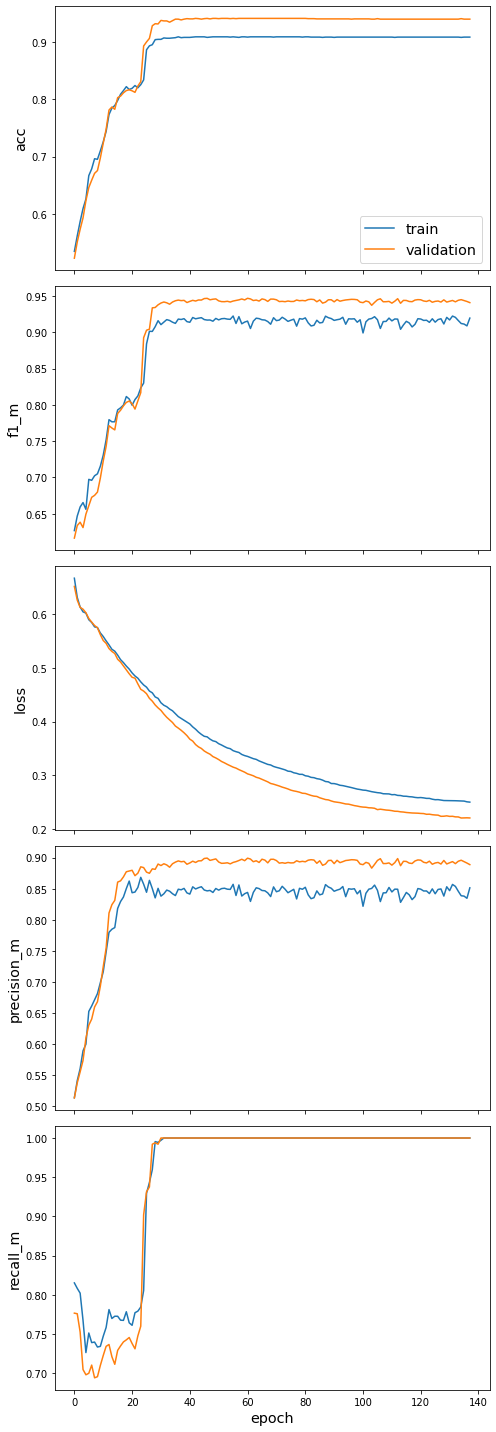

In [ ]:
sg.utils.plot_history(history)

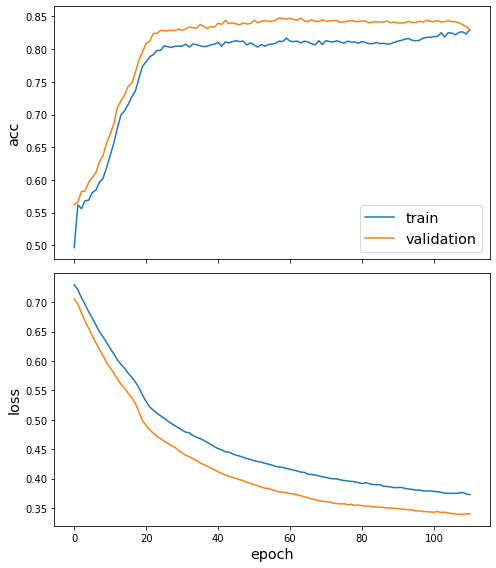

In [ ]:
sg.utils.plot_history(history)

In [ ]:

es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 3, restore_best_weights = True) 


history = model.fit(
    train_gen,
    #validation_split=0.3,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es] 
  #  workers=num_workers,
)

Epoch 1/1000
7/7 [==============================] - 6s 573ms/step - loss: 0.6459 - acc: 0.5640 - val_loss: 0.6210 - val_acc: 0.5748
Epoch 2/1000
7/7 [==============================] - 3s 469ms/step - loss: 0.6242 - acc: 0.6184 - val_loss: 0.6131 - val_acc: 0.7316
Epoch 3/1000
7/7 [==============================] - 3s 393ms/step - loss: 0.6155 - acc: 0.7272 - val_loss: 0.6077 - val_acc: 0.7348
Epoch 4/1000
7/7 [==============================] - 3s 393ms/step - loss: 0.6100 - acc: 0.7296 - val_loss: 0.6031 - val_acc: 0.7376
Epoch 5/1000
7/7 [==============================] - 2s 380ms/step - loss: 0.6060 - acc: 0.7320 - val_loss: 0.6000 - val_acc: 0.7392
Epoch 6/1000
7/7 [==============================] - 3s 549ms/step - loss: 0.6029 - acc: 0.7328 - val_loss: 0.5976 - val_acc: 0.7396
Epoch 7/1000
7/7 [==============================] - 3s 443ms/step - loss: 0.5998 - acc: 0.7344 - val_loss: 0.5945 - val_acc: 0.7468
Epoch 8/1000
7/7 [==============================] - 3s 399ms/step - loss: 0.

Plot the training history:

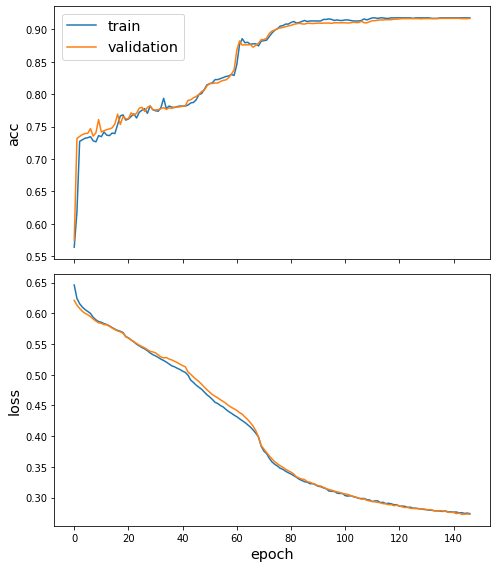

In [ ]:
sg.utils.plot_history(history)

Evaluate the trained model on test metric-issue links:

In [ ]:
#Linker 01

test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

17/17 [==============================] - 1s 55ms/step - loss: 0.4610 - acc: 0.8143 - f1_m: 0.8213 - precision_m: 0.7907 - recall_m: 0.8558
Test Evaluation:
	loss: 0.4610
	acc: 0.8143
	f1_m: 0.8213
	precision_m: 0.7907
	recall_m: 0.8558


In [ ]:
#FINAL

test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

13/13 [==============================] - 1s 27ms/step - loss: 0.2232 - acc: 0.9314 - f1_m: 0.9364 - precision_m: 0.8885 - recall_m: 0.9909
Test Evaluation:
	loss: 0.2232
	acc: 0.9314
	f1_m: 0.9364
	precision_m: 0.8885
	recall_m: 0.9909


In [ ]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

9/9 [==============================] - 2s 130ms/step - loss: 0.3388 - acc: 0.8438
Test Evaluation:
	loss: 0.3388
	acc: 0.8438


In [ ]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

13/13 [==============================] - 2s 116ms/step - loss: 0.2750 - acc: 0.9164
Test Evaluation:
	loss: 0.2750
	acc: 0.9164


## Prediction

In [ ]:
def predict_link1(repo_fullname, issues_nodes = issues_nodes, generator = generator, model = model): #, with_evaluation = False, labels = None):
  nodes2 = issues_nodes.index
  nodes2n = len(nodes2)
  nodes1 = [repo_fullname] * nodes2n
  ex = np.array(list(zip(nodes1, nodes2)))
  # print(ex)
  try:
    ggen = generator.flow(ex)
  except:
    nodes2 = issues_nodes.index
    nodes2n = len(nodes2)
    nodes1 = [repo_fullname] * nodes2n
    ex = np.array(list(zip(nodes2, nodes1)))

  # print(ex)

  ggen = generator.flow(ex)
  ps = model.predict(ggen)

  # if with_evaluation and labels:
  #   pss = ps > 0.5
  #   print(classification_report(ps, labels))


  return ps

selected_repo = "halibobo/ModuleBuild"
selected_repo = "ViaVersion/ViaRewind"
ps = predict_link1(selected_repo) #("halibobo/ModuleBuild") #("gsuez/master-bootstrap-3")
ps

array([[0.96096945],
       [0.96729755],
       [0.9747616 ],
       ...,
       [0.959128  ],
       [0.95938694],
       [0.958789  ]], dtype=float32)

In [ ]:
np.sort(ps[:,0])[-5:]

array([0.9853343 , 0.98543084, 0.9855144 , 0.98562884, 0.98583376],
      dtype=float32)

In [ ]:
np.sort(ps[:,0])[-50:]

array([0.9841266 , 0.9841558 , 0.98415875, 0.9841999 , 0.98421305,
       0.984215  , 0.9842154 , 0.9842335 , 0.9842404 , 0.9842431 ,
       0.98424435, 0.98429465, 0.98430693, 0.9843364 , 0.9843538 ,
       0.9843549 , 0.98437715, 0.9844183 , 0.98443246, 0.98443985,
       0.9844527 , 0.9844707 , 0.9844812 , 0.9844868 , 0.9845892 ,
       0.98461664, 0.9846217 , 0.9846328 , 0.9846415 , 0.98465705,
       0.9846598 , 0.98470265, 0.98471737, 0.9847327 , 0.9847461 ,
       0.98478353, 0.9848222 , 0.9848284 , 0.9848514 , 0.98488593,
       0.9849621 , 0.9850049 , 0.9850441 , 0.9851824 , 0.98530495,
       0.9853343 , 0.98543084, 0.9855144 , 0.98562884, 0.98583376],
      dtype=float32)

In [ ]:
len(ps[ps>0.9])

6691

In [ ]:
def precision_k(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recall_k(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [ ]:
# topic_id_words
# ps.shape
ps = ps[ps>0.5]
selected = np.argsort(ps)[-50:]
print(selected)
predicted_topics = s2.index[selected].unique()[:5]
issues_nodes.iloc[selected]

[]


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,new_id
repo_fullname,,,,,,,,,,,,,,,,,,,,,


# PRediction

In [140]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [228]:
from numpy.ma.core import less_equal
def precision_k(actual, predicted, k):
    if len(actual)==len(predicted)==0:
      return 1

    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recall_k(actual, predicted, k):
  if len(actual)==len(predicted)==0:
    return 1

  act_set = set(actual)
  pred_set = set(predicted[:k])
  result = len(act_set & pred_set) / float(len(act_set))
  return result

import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    print(predicted)
    print(actual)
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
            # score = num_hits
            print(p, " is Relevant")
            # score = num_hits
        else:
            print(p, " Not Relevant")

    if len(actual)==len(predicted)==0:
      return 1.0
    elif len(actual)==0 and len(predicted)>0:
      return 0.0
    elif len(actual)>0 and len(predicted)==0:
      return 0.0
    # print(k)
    # print(score)

    return score/min(len(actual), k)
    # return score / min(len(actual), k)

def ark(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    print(predicted)
    print(actual)
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / len(actual)
            print(p, " is Relevant")
            # score = num_hits
        else:
            print(p, " Not Relevant")

    if len(actual)==len(predicted)==0:
      return 1.0
    elif len(actual)==0 and len(predicted)>0:
      return 0.0
    elif len(actual)>0 and len(predicted)==0:
      return 0.0

    # print(k)
    # print(score)
    return score/min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def mark(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([ark(a,p,k) for a,p in zip(actual, predicted)])



def predict_link1(repo_fullname, issues_nodes = issues_nodes, generator = generator, model = model): #, with_evaluation = False, labels = None):
  nodes2 = issues_nodes.index
  nodes2n = len(nodes2)
  nodes1 = [repo_fullname] * nodes2n
  ex = np.array(list(zip(nodes1, nodes2)))
  # print(ex)
  try:
    ggen = generator.flow(ex)
  except:
    nodes2 = issues_nodes.index
    nodes2n = len(nodes2)
    nodes1 = [repo_fullname] * nodes2n
    ex = np.array(list(zip(nodes2, nodes1)))

  # print(ex)

  ggen = generator.flow(ex)
  ps = model.predict(ggen)

  # if with_evaluation and labels:
  #   pss = ps > 0.5
  #   print(classification_report(ps, labels))


  return ps



def predict_repo(selected_repo, k = 10, threshold = 0.5):

# selected_repo = metrics_nodes.index[1]
  ps = predict_link1(selected_repo)

  ps = ps[ps>0.5]

  selected = np.argsort(ps)[::-1] #[-50:].T
  # print(selected)
  predicted_topics = s2.index[selected].unique()#[:k]
  true_topics = s2[issues_nodes.index.str.startswith(selected_repo)].index.unique()
  # print(predicted_topics)
  # print(true_topics)
  # print(np.sort(ps)[::-1])

  # pred = []
  # actual = []

  # for topic in predicted_topics:
  #   # print(topic in true_topics)
  #   if topic in true_topics:
  #     pred.append(1)
  #     # actual.append(True)
  #   else:
  #     pred.append(0)
  #     # actual.append(False)

  # print(true_topics)
  # print(predicted_topics)
  # # pr, rc = precision_k(actual, pred, k), recall_k(actual, pred, k)
  # pr = np.sum(pred[:k])/len(pred[:k])
  # rc = np.sum(pred[:k])/np.sum(pred)
  rc = ark(true_topics, predicted_topics, k)
  pr = apk(true_topics, predicted_topics, k)

  # print(mapk(list(map(lambda x : [x], list(true_topics))), list(map(lambda x : [x], list(predicted_topics))), 5))
  return pr, rc 



In [191]:
metrics_nodes.reset_index()[metrics_nodes.reset_index().repo_fullname.str.contains("uos/rospy")]

,repo_fullname,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
410,uos/rospy_message_converter,-0.195191,0.0,0.95122,0.0,-0.144144,1.405797,0.935494,-0.689924,0.444444,...,0.0,0.0,0.333333,-0.2,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:

# To seed the random weights
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

outputs = {}
repos = [232, 766, 476, 410]

# idx = 121 # 607
for i in tqdm(range(len(metrics_nodes))):
# for i in repos:
  repo = metrics_nodes.index[i]
  output = predict_repo(repo, k = 5)
  outputs[repo] = output
  print("repo : ", repo)
  print(output)
  print()
  # break

pd.DataFrame(outputs).T.to_csv(os.path.join(PATH, "issues_predicted.csv"))
# prs = []
# rcs = []
# for repo in tqdm(metrics_nodes.index):
#   pr, rc = predict_repo(metrics_nodes.index[2])
#   prs.append(pr)
#   rcs.append(rc)[np.newaxis, :]

# np.mean(prs), np.mean(rcs)

  0%|          | 1/970 [00:09<2:35:19,  9.62s/it]

Int64Index([61, 30, 35, 42, 41], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
30  Not Relevant
35  Not Relevant
42  Not Relevant
41  Not Relevant
Int64Index([61, 30, 35, 42, 41], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
30  Not Relevant
35  Not Relevant
42  Not Relevant
41  Not Relevant
repo :  A13253565831/wxapp_newRestaurant
(0.0, 0.0)



  0%|          | 2/970 [00:16<2:12:45,  8.23s/it]

Int64Index([58, 60, 1, 35, 21], dtype='int64', name='topic')
Int64Index([42, 56, 18, 21, 24, 60, 5, 43], dtype='int64', name='topic')
58  Not Relevant
60  is Relevant
1  Not Relevant
35  Not Relevant
21  is Relevant
Int64Index([58, 60, 1, 35, 21], dtype='int64', name='topic')
Int64Index([42, 56, 18, 21, 24, 60, 5, 43], dtype='int64', name='topic')
58  Not Relevant
60  is Relevant
1  Not Relevant
35  Not Relevant
21  is Relevant
repo :  cryptokylin/CryptoKylin-Testnet
(0.18, 0.075)



  0%|          | 3/970 [00:24<2:08:32,  7.98s/it]

Int64Index([35, 25, 42, 61, 12], dtype='int64', name='topic')
Int64Index([22, 42, 57, 61, 15, 0, 60, 25], dtype='int64', name='topic')
35  Not Relevant
25  is Relevant
42  is Relevant
61  is Relevant
12  Not Relevant
Int64Index([35, 25, 42, 61, 12], dtype='int64', name='topic')
Int64Index([22, 42, 57, 61, 15, 0, 60, 25], dtype='int64', name='topic')
35  Not Relevant
25  is Relevant
42  is Relevant
61  is Relevant
12  Not Relevant
repo :  react-toolbox/react-toolbox-example
(0.3833333333333333, 0.15)



  0%|          | 4/970 [00:32<2:06:52,  7.88s/it]

Int64Index([44, 25, 39, 55, 43], dtype='int64', name='topic')
Int64Index([59, 42, 56], dtype='int64', name='topic')
44  Not Relevant
25  Not Relevant
39  Not Relevant
55  Not Relevant
43  Not Relevant
Int64Index([44, 25, 39, 55, 43], dtype='int64', name='topic')
Int64Index([59, 42, 56], dtype='int64', name='topic')
44  Not Relevant
25  Not Relevant
39  Not Relevant
55  Not Relevant
43  Not Relevant
repo :  kubernetes/committee-security-response
(0.0, 0.0)



  1%|          | 5/970 [00:40<2:08:27,  7.99s/it]

Int64Index([24, 47, 42, 54, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
47  Not Relevant
42  Not Relevant
54  Not Relevant
43  Not Relevant
Int64Index([24, 47, 42, 54, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
47  Not Relevant
42  Not Relevant
54  Not Relevant
43  Not Relevant
repo :  xiaolai/help-to-be-helped
(0.0, 0.0)



  1%|          | 6/970 [00:48<2:07:32,  7.94s/it]

Int64Index([43, 35, 56, 61, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
56  Not Relevant
61  Not Relevant
39  Not Relevant
Int64Index([43, 35, 56, 61, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
56  Not Relevant
61  Not Relevant
39  Not Relevant
repo :  SpaceApps2016/Resources
(0.0, 0.0)



  1%|          | 7/970 [00:56<2:08:01,  7.98s/it]

Int64Index([46, 42, 45, 60, 8], dtype='int64', name='topic')
Int64Index([34, 42, 39, 43, 25], dtype='int64', name='topic')
46  Not Relevant
42  is Relevant
45  Not Relevant
60  Not Relevant
8  Not Relevant
Int64Index([46, 42, 45, 60, 8], dtype='int64', name='topic')
Int64Index([34, 42, 39, 43, 25], dtype='int64', name='topic')
46  Not Relevant
42  is Relevant
45  Not Relevant
60  Not Relevant
8  Not Relevant
repo :  chschoenenberger/covid19_dashboard
(0.1, 0.04)



  1%|          | 8/970 [01:03<2:06:07,  7.87s/it]

Int64Index([1, 23, 42, 43, 12], dtype='int64', name='topic')
Int64Index([60, 61, 20, 44, 43, 25, 42], dtype='int64', name='topic')
1  Not Relevant
23  Not Relevant
42  is Relevant
43  is Relevant
12  Not Relevant
Int64Index([1, 23, 42, 43, 12], dtype='int64', name='topic')
Int64Index([60, 61, 20, 44, 43, 25, 42], dtype='int64', name='topic')
1  Not Relevant
23  Not Relevant
42  is Relevant
43  is Relevant
12  Not Relevant
repo :  sirkitree/angular-directive.g-signin
(0.16666666666666666, 0.08571428571428572)



  1%|          | 9/970 [01:11<2:04:56,  7.80s/it]

Int64Index([42, 2, 60, 16, 5], dtype='int64', name='topic')
Int64Index([54], dtype='int64', name='topic')
42  Not Relevant
2  Not Relevant
60  Not Relevant
16  Not Relevant
5  Not Relevant
Int64Index([42, 2, 60, 16, 5], dtype='int64', name='topic')
Int64Index([54], dtype='int64', name='topic')
42  Not Relevant
2  Not Relevant
60  Not Relevant
16  Not Relevant
5  Not Relevant
repo :  jorgevgut/airquality-mx
(0.0, 0.0)



  1%|          | 10/970 [01:19<2:04:16,  7.77s/it]

Int64Index([46, 31, 47, 42, 35], dtype='int64', name='topic')
Int64Index([48, 42, 8, 60], dtype='int64', name='topic')
46  Not Relevant
31  Not Relevant
47  Not Relevant
42  is Relevant
35  Not Relevant
Int64Index([46, 31, 47, 42, 35], dtype='int64', name='topic')
Int64Index([48, 42, 8, 60], dtype='int64', name='topic')
46  Not Relevant
31  Not Relevant
47  Not Relevant
42  is Relevant
35  Not Relevant
repo :  llSourcell/AI_Writer
(0.0625, 0.0625)



  1%|          | 11/970 [01:27<2:04:02,  7.76s/it]

Int64Index([0, 12, 51, 60, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
51  Not Relevant
60  Not Relevant
42  is Relevant
Int64Index([0, 12, 51, 60, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
51  Not Relevant
60  Not Relevant
42  is Relevant
repo :  pitiwazou/Scripts-Blender
(0.2, 1.0)



  1%|          | 12/970 [01:35<2:05:36,  7.87s/it]

Int64Index([0, 42, 44, 60, 51], dtype='int64', name='topic')
Int64Index([60, 27, 18, 44, 43, 56, 37], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
44  is Relevant
60  is Relevant
51  Not Relevant
Int64Index([0, 42, 44, 60, 51], dtype='int64', name='topic')
Int64Index([60, 27, 18, 44, 43, 56, 37], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
44  is Relevant
60  is Relevant
51  Not Relevant
repo :  web3p/ethereum-tx
(0.16666666666666666, 0.08571428571428572)



  1%|▏         | 13/970 [01:42<2:05:09,  7.85s/it]

Int64Index([21, 42, 22, 56, 60], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
21  Not Relevant
42  Not Relevant
22  Not Relevant
56  Not Relevant
60  is Relevant
Int64Index([21, 42, 22, 56, 60], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
21  Not Relevant
42  Not Relevant
22  Not Relevant
56  Not Relevant
60  is Relevant
repo :  samuel/go-opencl
(0.2, 1.0)



  1%|▏         | 14/970 [01:50<2:04:12,  7.80s/it]

Int64Index([56, 23, 37, 39, 58], dtype='int64', name='topic')
Int64Index([42, 5], dtype='int64', name='topic')
56  Not Relevant
23  Not Relevant
37  Not Relevant
39  Not Relevant
58  Not Relevant
Int64Index([56, 23, 37, 39, 58], dtype='int64', name='topic')
Int64Index([42, 5], dtype='int64', name='topic')
56  Not Relevant
23  Not Relevant
37  Not Relevant
39  Not Relevant
58  Not Relevant
repo :  MadStudioRoblox/ProfileService
(0.0, 0.0)



  2%|▏         | 15/970 [01:58<2:05:31,  7.89s/it]

Int64Index([15, 35, 42, 63, 51], dtype='int64', name='topic')
Int64Index([10, 48, 11, 43, 60, 56, 5, 58, 42, 44], dtype='int64', name='topic')
15  Not Relevant
35  Not Relevant
42  is Relevant
63  Not Relevant
51  Not Relevant
Int64Index([15, 35, 42, 63, 51], dtype='int64', name='topic')
Int64Index([10, 48, 11, 43, 60, 56, 5, 58, 42, 44], dtype='int64', name='topic')
15  Not Relevant
35  Not Relevant
42  is Relevant
63  Not Relevant
51  Not Relevant
repo :  0xPrateek/Stardox
(0.06666666666666667, 0.02)



  2%|▏         | 16/970 [02:06<2:04:52,  7.85s/it]

Int64Index([7, 42, 35, 12, 31], dtype='int64', name='topic')
Int64Index([5, 25, 24, 61, 22, 42, 43], dtype='int64', name='topic')
7  Not Relevant
42  is Relevant
35  Not Relevant
12  Not Relevant
31  Not Relevant
Int64Index([7, 42, 35, 12, 31], dtype='int64', name='topic')
Int64Index([5, 25, 24, 61, 22, 42, 43], dtype='int64', name='topic')
7  Not Relevant
42  is Relevant
35  Not Relevant
12  Not Relevant
31  Not Relevant
repo :  chingyawhao/materialize-clockpicker
(0.1, 0.02857142857142857)



  2%|▏         | 17/970 [02:14<2:05:05,  7.88s/it]

Int64Index([24, 42, 47, 2, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
42  Not Relevant
47  Not Relevant
2  Not Relevant
60  Not Relevant
Int64Index([24, 42, 47, 2, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
42  Not Relevant
47  Not Relevant
2  Not Relevant
60  Not Relevant
repo :  sintrb/WaveAccess
(0.0, 0.0)



  2%|▏         | 18/970 [02:22<2:04:50,  7.87s/it]

Int64Index([56, 60, 39, 44, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
60  Not Relevant
39  Not Relevant
44  Not Relevant
43  Not Relevant
Int64Index([56, 60, 39, 44, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
60  Not Relevant
39  Not Relevant
44  Not Relevant
43  Not Relevant
repo :  neoremind/coddding
(0.0, 0.0)



  2%|▏         | 19/970 [02:30<2:04:39,  7.86s/it]

Int64Index([21, 60, 56, 43, 39], dtype='int64', name='topic')
Int64Index([60, 42, 38, 56, 9, 44, 18], dtype='int64', name='topic')
21  Not Relevant
60  is Relevant
56  is Relevant
43  Not Relevant
39  Not Relevant
Int64Index([21, 60, 56, 43, 39], dtype='int64', name='topic')
Int64Index([60, 42, 38, 56, 9, 44, 18], dtype='int64', name='topic')
21  Not Relevant
60  is Relevant
56  is Relevant
43  Not Relevant
39  Not Relevant
repo :  skavinvarnan/Cross-Platform-AES
(0.2333333333333333, 0.08571428571428572)



  2%|▏         | 20/970 [02:39<2:09:43,  8.19s/it]

Int64Index([63, 13, 17, 47, 18], dtype='int64', name='topic')
Int64Index([42, 43, 11, 5, 56, 48], dtype='int64', name='topic')
63  Not Relevant
13  Not Relevant
17  Not Relevant
47  Not Relevant
18  Not Relevant
Int64Index([63, 13, 17, 47, 18], dtype='int64', name='topic')
Int64Index([42, 43, 11, 5, 56, 48], dtype='int64', name='topic')
63  Not Relevant
13  Not Relevant
17  Not Relevant
47  Not Relevant
18  Not Relevant
repo :  JeffHoogland/pyxhook
(0.0, 0.0)



  2%|▏         | 21/970 [02:46<2:06:02,  7.97s/it]

Int64Index([57, 42, 43, 61, 18], dtype='int64', name='topic')
Int64Index([42, 30, 60, 3, 34, 43, 48, 11, 61, 37, 23, 21, 32, 56, 58, 1, 18], dtype='int64', name='topic')
57  Not Relevant
42  is Relevant
43  is Relevant
61  is Relevant
18  is Relevant
Int64Index([57, 42, 43, 61, 18], dtype='int64', name='topic')
Int64Index([42, 30, 60, 3, 34, 43, 48, 11, 61, 37, 23, 21, 32, 56, 58, 1, 18], dtype='int64', name='topic')
57  Not Relevant
42  is Relevant
43  is Relevant
61  is Relevant
18  is Relevant
repo :  notanumber/xapian-haystack
(0.5433333333333333, 0.1176470588235294)



  2%|▏         | 22/970 [02:54<2:06:38,  8.02s/it]

Int64Index([33, 42, 35, 20, 38], dtype='int64', name='topic')
Int64Index([44, 30, 42, 8, 60, 56, 39], dtype='int64', name='topic')
33  Not Relevant
42  is Relevant
35  Not Relevant
20  Not Relevant
38  Not Relevant
Int64Index([33, 42, 35, 20, 38], dtype='int64', name='topic')
Int64Index([44, 30, 42, 8, 60, 56, 39], dtype='int64', name='topic')
33  Not Relevant
42  is Relevant
35  Not Relevant
20  Not Relevant
38  Not Relevant
repo :  Crowd9/Benchmark
(0.1, 0.02857142857142857)



  2%|▏         | 23/970 [03:05<2:17:33,  8.72s/it]

Int64Index([42, 60, 43, 18, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
43  Not Relevant
18  Not Relevant
22  Not Relevant
Int64Index([42, 60, 43, 18, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
43  Not Relevant
18  Not Relevant
22  Not Relevant
repo :  ruscoe/Android-Tile-Based-Game
(0.0, 0.0)



  2%|▏         | 24/970 [03:13<2:13:53,  8.49s/it]

Int64Index([5, 40, 60, 9, 42], dtype='int64', name='topic')
Int64Index([55, 42, 20, 43, 25, 21, 39], dtype='int64', name='topic')
5  Not Relevant
40  Not Relevant
60  Not Relevant
9  Not Relevant
42  is Relevant
Int64Index([5, 40, 60, 9, 42], dtype='int64', name='topic')
Int64Index([55, 42, 20, 43, 25, 21, 39], dtype='int64', name='topic')
5  Not Relevant
40  Not Relevant
60  Not Relevant
9  Not Relevant
42  is Relevant
repo :  fraserxu/ionic-rating
(0.04, 0.02857142857142857)



  3%|▎         | 25/970 [03:20<2:10:35,  8.29s/it]

Int64Index([58, 43, 42, 56, 60], dtype='int64', name='topic')
Int64Index([42, 47, 43, 23, 30, 49, 56], dtype='int64', name='topic')
58  Not Relevant
43  is Relevant
42  is Relevant
56  is Relevant
60  Not Relevant
Int64Index([58, 43, 42, 56, 60], dtype='int64', name='topic')
Int64Index([42, 47, 43, 23, 30, 49, 56], dtype='int64', name='topic')
58  Not Relevant
43  is Relevant
42  is Relevant
56  is Relevant
60  Not Relevant
repo :  OrchardCMS/OrchardCore.Commerce
(0.3833333333333333, 0.17142857142857143)



  3%|▎         | 26/970 [03:28<2:06:23,  8.03s/it]

Int64Index([56, 12, 44, 60, 29], dtype='int64', name='topic')
Int64Index([8, 60], dtype='int64', name='topic')
56  Not Relevant
12  Not Relevant
44  Not Relevant
60  is Relevant
29  Not Relevant
Int64Index([56, 12, 44, 60, 29], dtype='int64', name='topic')
Int64Index([8, 60], dtype='int64', name='topic')
56  Not Relevant
12  Not Relevant
44  Not Relevant
60  is Relevant
29  Not Relevant
repo :  ichuang/tflearn_wide_and_deep
(0.125, 0.25)



  3%|▎         | 27/970 [03:35<2:03:09,  7.84s/it]

Int64Index([17, 43, 42, 56, 5], dtype='int64', name='topic')
Int64Index([42, 61, 56, 43, 25, 57, 60, 15, 51], dtype='int64', name='topic')
17  Not Relevant
43  is Relevant
42  is Relevant
56  is Relevant
5  Not Relevant
Int64Index([17, 43, 42, 56, 5], dtype='int64', name='topic')
Int64Index([42, 61, 56, 43, 25, 57, 60, 15, 51], dtype='int64', name='topic')
17  Not Relevant
43  is Relevant
42  is Relevant
56  is Relevant
5  Not Relevant
repo :  JackDanielsAndCode/react-native-multi-slider
(0.3833333333333333, 0.13333333333333333)



  3%|▎         | 28/970 [03:43<2:02:00,  7.77s/it]

Int64Index([50, 43, 23, 37, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
43  Not Relevant
23  Not Relevant
37  Not Relevant
25  Not Relevant
Int64Index([50, 43, 23, 37, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
43  Not Relevant
23  Not Relevant
37  Not Relevant
25  Not Relevant
repo :  njcx/pocsuite_poc_collect
(0.0, 0.0)



  3%|▎         | 29/970 [03:50<2:01:14,  7.73s/it]

Int64Index([1, 42, 62, 39, 60], dtype='int64', name='topic')
Int64Index([43, 39, 42, 60, 44, 48, 8, 61], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
62  Not Relevant
39  is Relevant
60  is Relevant
Int64Index([1, 42, 62, 39, 60], dtype='int64', name='topic')
Int64Index([43, 39, 42, 60, 44, 48, 8, 61], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
62  Not Relevant
39  is Relevant
60  is Relevant
repo :  mattloper/chumpy
(0.32, 0.15)



  3%|▎         | 30/970 [03:58<1:58:43,  7.58s/it]

Int64Index([32, 42, 7, 61, 47], dtype='int64', name='topic')
Int64Index([18, 42, 14, 56, 39, 26, 48, 43, 60, 61], dtype='int64', name='topic')
32  Not Relevant
42  is Relevant
7  Not Relevant
61  is Relevant
47  Not Relevant
Int64Index([32, 42, 7, 61, 47], dtype='int64', name='topic')
Int64Index([18, 42, 14, 56, 39, 26, 48, 43, 60, 61], dtype='int64', name='topic')
32  Not Relevant
42  is Relevant
7  Not Relevant
61  is Relevant
47  Not Relevant
repo :  cmprescott/ansible-xml
(0.2, 0.06000000000000001)



  3%|▎         | 31/970 [04:06<2:00:01,  7.67s/it]

Int64Index([1, 63, 43, 24, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
43  Not Relevant
24  Not Relevant
5  Not Relevant
Int64Index([1, 63, 43, 24, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
43  Not Relevant
24  Not Relevant
5  Not Relevant
repo :  jgranick/actuate
(0.0, 0.0)



  3%|▎         | 32/970 [04:13<1:58:43,  7.59s/it]

Int64Index([22, 39, 18, 43, 42], dtype='int64', name='topic')
Int64Index([44, 60, 17, 50, 39, 43], dtype='int64', name='topic')
22  Not Relevant
39  is Relevant
18  Not Relevant
43  is Relevant
42  Not Relevant
Int64Index([22, 39, 18, 43, 42], dtype='int64', name='topic')
Int64Index([44, 60, 17, 50, 39, 43], dtype='int64', name='topic')
22  Not Relevant
39  is Relevant
18  Not Relevant
43  is Relevant
42  Not Relevant
repo :  Chronic-Dev/libirecovery
(0.2, 0.1)



  3%|▎         | 33/970 [04:20<1:56:29,  7.46s/it]

Int64Index([42, 32, 44, 52, 12], dtype='int64', name='topic')
Int64Index([39, 42, 61, 25, 60, 43, 56], dtype='int64', name='topic')
42  is Relevant
32  Not Relevant
44  Not Relevant
52  Not Relevant
12  Not Relevant
Int64Index([42, 32, 44, 52, 12], dtype='int64', name='topic')
Int64Index([39, 42, 61, 25, 60, 43, 56], dtype='int64', name='topic')
42  is Relevant
32  Not Relevant
44  Not Relevant
52  Not Relevant
12  Not Relevant
repo :  gpouilloux/gnome-shell-extension-docker
(0.2, 0.02857142857142857)



  4%|▎         | 34/970 [04:27<1:55:28,  7.40s/it]

Int64Index([42, 55, 39, 46, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
55  Not Relevant
39  Not Relevant
46  Not Relevant
18  Not Relevant
Int64Index([42, 55, 39, 46, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
55  Not Relevant
39  Not Relevant
46  Not Relevant
18  Not Relevant
repo :  mandiant/flare-dbg
(0.0, 0.0)



  4%|▎         | 35/970 [04:35<1:55:13,  7.39s/it]

Int64Index([42, 18, 43, 23, 37], dtype='int64', name='topic')
Int64Index([1], dtype='int64', name='topic')
42  Not Relevant
18  Not Relevant
43  Not Relevant
23  Not Relevant
37  Not Relevant
Int64Index([42, 18, 43, 23, 37], dtype='int64', name='topic')
Int64Index([1], dtype='int64', name='topic')
42  Not Relevant
18  Not Relevant
43  Not Relevant
23  Not Relevant
37  Not Relevant
repo :  tao12345666333/tornado-zh
(0.0, 0.0)



  4%|▎         | 36/970 [04:42<1:55:58,  7.45s/it]

Int64Index([24, 23, 43, 60, 48], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
23  Not Relevant
43  Not Relevant
60  Not Relevant
48  Not Relevant
Int64Index([24, 23, 43, 60, 48], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
23  Not Relevant
43  Not Relevant
60  Not Relevant
48  Not Relevant
repo :  cld378632668/ucas_course_tool
(0.0, 0.0)



  4%|▍         | 37/970 [04:50<1:56:25,  7.49s/it]

Int64Index([61, 7, 44, 42, 60], dtype='int64', name='topic')
Int64Index([61, 60], dtype='int64', name='topic')
61  is Relevant
7  Not Relevant
44  Not Relevant
42  Not Relevant
60  is Relevant
Int64Index([61, 7, 44, 42, 60], dtype='int64', name='topic')
Int64Index([61, 60], dtype='int64', name='topic')
61  is Relevant
7  Not Relevant
44  Not Relevant
42  Not Relevant
60  is Relevant
repo :  ilblackdragon/tf_examples
(0.7, 0.75)



  4%|▍         | 38/970 [04:57<1:56:01,  7.47s/it]

Int64Index([42, 56, 17, 43, 60], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
42  Not Relevant
56  Not Relevant
17  Not Relevant
43  Not Relevant
60  Not Relevant
Int64Index([42, 56, 17, 43, 60], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
42  Not Relevant
56  Not Relevant
17  Not Relevant
43  Not Relevant
60  Not Relevant
repo :  tensorlayer/DAGAN
(0.0, 0.0)



  4%|▍         | 39/970 [05:06<1:59:34,  7.71s/it]

Int64Index([42, 60, 8, 40, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
8  Not Relevant
40  Not Relevant
11  Not Relevant
Int64Index([42, 60, 8, 40, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
8  Not Relevant
40  Not Relevant
11  Not Relevant
repo :  yaa110/Memento
(0.0, 0.0)



  4%|▍         | 40/970 [05:13<1:59:09,  7.69s/it]

Int64Index([42, 31, 60, 57, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
31  Not Relevant
60  Not Relevant
57  Not Relevant
51  Not Relevant
Int64Index([42, 31, 60, 57, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
31  Not Relevant
60  Not Relevant
57  Not Relevant
51  Not Relevant
repo :  Dreadstar22/AWS-FAQ
(0.0, 0.0)



  4%|▍         | 41/970 [05:20<1:54:49,  7.42s/it]

Int64Index([0, 46, 56, 11, 18], dtype='int64', name='topic')
Int64Index([14, 49, 39, 43, 56, 44, 25, 42, 61, 11], dtype='int64', name='topic')
0  Not Relevant
46  Not Relevant
56  is Relevant
11  is Relevant
18  Not Relevant
Int64Index([0, 46, 56, 11, 18], dtype='int64', name='topic')
Int64Index([14, 49, 39, 43, 56, 44, 25, 42, 61, 11], dtype='int64', name='topic')
0  Not Relevant
46  Not Relevant
56  is Relevant
11  is Relevant
18  Not Relevant
repo :  ansiblebit/oracle-java
(0.16666666666666666, 0.06000000000000001)



  4%|▍         | 42/970 [05:27<1:54:42,  7.42s/it]

Int64Index([12, 18, 35, 50, 42], dtype='int64', name='topic')
Int64Index([61, 38, 35, 18], dtype='int64', name='topic')
12  Not Relevant
18  is Relevant
35  is Relevant
50  Not Relevant
42  Not Relevant
Int64Index([12, 18, 35, 50, 42], dtype='int64', name='topic')
Int64Index([61, 38, 35, 18], dtype='int64', name='topic')
12  Not Relevant
18  is Relevant
35  is Relevant
50  Not Relevant
42  Not Relevant
repo :  match5/thsauto
(0.29166666666666663, 0.1875)



  4%|▍         | 43/970 [05:35<1:56:21,  7.53s/it]

Int64Index([0, 23, 35, 18, 60], dtype='int64', name='topic')
Int64Index([60, 46, 44, 22, 42], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
35  Not Relevant
18  Not Relevant
60  is Relevant
Int64Index([0, 23, 35, 18, 60], dtype='int64', name='topic')
Int64Index([60, 46, 44, 22, 42], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
35  Not Relevant
18  Not Relevant
60  is Relevant
repo :  jaredhanson/passport-totp
(0.04, 0.04)



  5%|▍         | 44/970 [05:42<1:53:11,  7.33s/it]

Int64Index([56, 29, 42, 43, 61], dtype='int64', name='topic')
Int64Index([43, 61, 10, 42, 60, 56, 18, 44], dtype='int64', name='topic')
56  is Relevant
29  Not Relevant
42  is Relevant
43  is Relevant
61  is Relevant
Int64Index([56, 29, 42, 43, 61], dtype='int64', name='topic')
Int64Index([43, 61, 10, 42, 60, 56, 18, 44], dtype='int64', name='topic')
56  is Relevant
29  Not Relevant
42  is Relevant
43  is Relevant
61  is Relevant
repo :  thiagobustamante/typescript-rest-swagger
(0.6433333333333333, 0.25)



  5%|▍         | 45/970 [05:49<1:52:15,  7.28s/it]

Int64Index([44, 43, 42, 25, 37], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
44  Not Relevant
43  Not Relevant
42  Not Relevant
25  Not Relevant
37  Not Relevant
Int64Index([44, 43, 42, 25, 37], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
44  Not Relevant
43  Not Relevant
42  Not Relevant
25  Not Relevant
37  Not Relevant
repo :  huwenxianglyy/bert-use-demo
(0.0, 0.0)



  5%|▍         | 46/970 [05:56<1:50:36,  7.18s/it]

Int64Index([42, 58, 2, 45, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
58  Not Relevant
2  Not Relevant
45  Not Relevant
0  Not Relevant
Int64Index([42, 58, 2, 45, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
58  Not Relevant
2  Not Relevant
45  Not Relevant
0  Not Relevant
repo :  homejim/mybatis-cn
(0.0, 0.0)



  5%|▍         | 47/970 [06:06<2:02:49,  7.98s/it]

Int64Index([1, 60, 42, 47, 46], dtype='int64', name='topic')
Int64Index([42, 48, 44, 60, 18], dtype='int64', name='topic')
1  Not Relevant
60  is Relevant
42  is Relevant
47  Not Relevant
46  Not Relevant
Int64Index([1, 60, 42, 47, 46], dtype='int64', name='topic')
Int64Index([42, 48, 44, 60, 18], dtype='int64', name='topic')
1  Not Relevant
60  is Relevant
42  is Relevant
47  Not Relevant
46  Not Relevant
repo :  chenjr0719/Facebook-Page-Crawler
(0.2333333333333333, 0.12000000000000002)



  5%|▍         | 48/970 [06:13<1:56:51,  7.60s/it]

Int64Index([1, 31, 42, 21, 43], dtype='int64', name='topic')
Int64Index([46, 2, 27], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
42  Not Relevant
21  Not Relevant
43  Not Relevant
Int64Index([1, 31, 42, 21, 43], dtype='int64', name='topic')
Int64Index([46, 2, 27], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
42  Not Relevant
21  Not Relevant
43  Not Relevant
repo :  gqf2008/bbllive
(0.0, 0.0)



  5%|▌         | 49/970 [06:20<1:52:51,  7.35s/it]

Int64Index([1, 56, 50, 25, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
56  Not Relevant
50  Not Relevant
25  Not Relevant
43  Not Relevant
Int64Index([1, 56, 50, 25, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
56  Not Relevant
50  Not Relevant
25  Not Relevant
43  Not Relevant
repo :  spring-projects-experimental/spring-cloud-etcd
(0.0, 0.0)



  5%|▌         | 50/970 [06:27<1:54:08,  7.44s/it]

Int64Index([0, 42, 44, 25, 35], dtype='int64', name='topic')
Int64Index([43, 44, 42, 23, 0, 18, 35, 7, 33], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
44  is Relevant
25  Not Relevant
35  is Relevant
Int64Index([0, 42, 44, 25, 35], dtype='int64', name='topic')
Int64Index([43, 44, 42, 23, 0, 18, 35, 7, 33], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
44  is Relevant
25  Not Relevant
35  is Relevant
repo :  gateio/gateapi-python
(0.76, 0.22222222222222224)



  5%|▌         | 51/970 [06:34<1:52:05,  7.32s/it]

Int64Index([61, 42, 25, 45, 60], dtype='int64', name='topic')
Int64Index([42, 44, 61, 43, 37], dtype='int64', name='topic')
61  is Relevant
42  is Relevant
25  Not Relevant
45  Not Relevant
60  Not Relevant
Int64Index([61, 42, 25, 45, 60], dtype='int64', name='topic')
Int64Index([42, 44, 61, 43, 37], dtype='int64', name='topic')
61  is Relevant
42  is Relevant
25  Not Relevant
45  Not Relevant
60  Not Relevant
repo :  pavelrisenberg/fitbitphp
(0.4, 0.12000000000000002)



  5%|▌         | 52/970 [06:41<1:51:34,  7.29s/it]

Int64Index([1, 12, 48, 43, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
48  Not Relevant
43  Not Relevant
11  Not Relevant
Int64Index([1, 12, 48, 43, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
48  Not Relevant
43  Not Relevant
11  Not Relevant
repo :  MicrocontrollersAndMore/Raspberry_Pi_2_and_OpenCV_3_Tutorial_Part_1
(0.0, 0.0)



  5%|▌         | 53/970 [06:49<1:51:18,  7.28s/it]

Int64Index([1, 12, 49, 43, 58], dtype='int64', name='topic')
Int64Index([32, 42, 61], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
49  Not Relevant
43  Not Relevant
58  Not Relevant
Int64Index([1, 12, 49, 43, 58], dtype='int64', name='topic')
Int64Index([32, 42, 61], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
49  Not Relevant
43  Not Relevant
58  Not Relevant
repo :  codebox/moment-precise-range
(0.0, 0.0)



  6%|▌         | 54/970 [06:56<1:50:31,  7.24s/it]

Int64Index([50, 43, 56, 60, 35], dtype='int64', name='topic')
Int64Index([56, 25, 0, 42, 43], dtype='int64', name='topic')
50  Not Relevant
43  is Relevant
56  is Relevant
60  Not Relevant
35  Not Relevant
Int64Index([50, 43, 56, 60, 35], dtype='int64', name='topic')
Int64Index([56, 25, 0, 42, 43], dtype='int64', name='topic')
50  Not Relevant
43  is Relevant
56  is Relevant
60  Not Relevant
35  Not Relevant
repo :  dobromir-hristov/vuecommunity
(0.2333333333333333, 0.12000000000000002)



  6%|▌         | 55/970 [07:04<1:53:38,  7.45s/it]

Int64Index([42, 23, 39, 35, 25], dtype='int64', name='topic')
Int64Index([43, 18, 7], dtype='int64', name='topic')
42  Not Relevant
23  Not Relevant
39  Not Relevant
35  Not Relevant
25  Not Relevant
Int64Index([42, 23, 39, 35, 25], dtype='int64', name='topic')
Int64Index([43, 18, 7], dtype='int64', name='topic')
42  Not Relevant
23  Not Relevant
39  Not Relevant
35  Not Relevant
25  Not Relevant
repo :  shenzhe/geohash
(0.0, 0.0)



  6%|▌         | 56/970 [07:11<1:54:07,  7.49s/it]

Int64Index([42, 61, 17, 5, 60], dtype='int64', name='topic')
Int64Index([18, 3, 43], dtype='int64', name='topic')
42  Not Relevant
61  Not Relevant
17  Not Relevant
5  Not Relevant
60  Not Relevant
Int64Index([42, 61, 17, 5, 60], dtype='int64', name='topic')
Int64Index([18, 3, 43], dtype='int64', name='topic')
42  Not Relevant
61  Not Relevant
17  Not Relevant
5  Not Relevant
60  Not Relevant
repo :  astockwell/countries-and-provinces-states-regions
(0.0, 0.0)



  6%|▌         | 57/970 [07:18<1:51:31,  7.33s/it]

Int64Index([47, 18, 44, 26, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
18  Not Relevant
44  Not Relevant
26  Not Relevant
43  Not Relevant
Int64Index([47, 18, 44, 26, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
18  Not Relevant
44  Not Relevant
26  Not Relevant
43  Not Relevant
repo :  evilcos/python-webshell
(0.0, 0.0)



  6%|▌         | 58/970 [07:25<1:50:26,  7.27s/it]

Int64Index([44, 46, 23, 37, 0], dtype='int64', name='topic')
Int64Index([33, 22], dtype='int64', name='topic')
44  Not Relevant
46  Not Relevant
23  Not Relevant
37  Not Relevant
0  Not Relevant
Int64Index([44, 46, 23, 37, 0], dtype='int64', name='topic')
Int64Index([33, 22], dtype='int64', name='topic')
44  Not Relevant
46  Not Relevant
23  Not Relevant
37  Not Relevant
0  Not Relevant
repo :  arvindr21/myRESTApp
(0.0, 0.0)



  6%|▌         | 59/970 [07:33<1:51:48,  7.36s/it]

Int64Index([0, 35, 42, 37, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
42  Not Relevant
37  Not Relevant
23  Not Relevant
Int64Index([0, 35, 42, 37, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
42  Not Relevant
37  Not Relevant
23  Not Relevant
repo :  mahmoodlab/NucleiSegmentation
(0.0, 0.0)



  6%|▌         | 60/970 [07:40<1:50:02,  7.26s/it]

Int64Index([24, 54, 44, 58, 42], dtype='int64', name='topic')
Int64Index([7, 56, 17, 42, 19, 43, 1, 18, 36, 30, 39], dtype='int64', name='topic')
24  Not Relevant
54  Not Relevant
44  Not Relevant
58  Not Relevant
42  is Relevant
Int64Index([24, 54, 44, 58, 42], dtype='int64', name='topic')
Int64Index([7, 56, 17, 42, 19, 43, 1, 18, 36, 30, 39], dtype='int64', name='topic')
24  Not Relevant
54  Not Relevant
44  Not Relevant
58  Not Relevant
42  is Relevant
repo :  kazu-yamamoto/logger
(0.04, 0.01818181818181818)



  6%|▋         | 61/970 [07:47<1:49:22,  7.22s/it]

Int64Index([57, 58, 42, 27, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
58  Not Relevant
42  Not Relevant
27  Not Relevant
2  Not Relevant
Int64Index([57, 58, 42, 27, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
58  Not Relevant
42  Not Relevant
27  Not Relevant
2  Not Relevant
repo :  tensor-infinity/machine_learning_and_application_v1
(0.0, 0.0)



  6%|▋         | 62/970 [07:54<1:49:15,  7.22s/it]

Int64Index([43, 37, 48, 18, 42], dtype='int64', name='topic')
Int64Index([44, 60, 42, 43, 27, 57, 25], dtype='int64', name='topic')
43  is Relevant
37  Not Relevant
48  Not Relevant
18  Not Relevant
42  is Relevant
Int64Index([43, 37, 48, 18, 42], dtype='int64', name='topic')
Int64Index([44, 60, 42, 43, 27, 57, 25], dtype='int64', name='topic')
43  is Relevant
37  Not Relevant
48  Not Relevant
18  Not Relevant
42  is Relevant
repo :  paul-schaaf/spl-token-ui
(0.27999999999999997, 0.08571428571428572)



  6%|▋         | 63/970 [08:02<1:50:07,  7.29s/it]

Int64Index([50, 56, 23, 42, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
56  Not Relevant
23  Not Relevant
42  Not Relevant
0  Not Relevant
Int64Index([50, 56, 23, 42, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
56  Not Relevant
23  Not Relevant
42  Not Relevant
0  Not Relevant
repo :  danielmiessler/vim
(0.0, 0.0)



  7%|▋         | 64/970 [08:09<1:47:26,  7.11s/it]

Int64Index([42, 43, 38, 59, 60], dtype='int64', name='topic')
Int64Index([9, 42, 51, 60, 47], dtype='int64', name='topic')
42  is Relevant
43  Not Relevant
38  Not Relevant
59  Not Relevant
60  is Relevant
Int64Index([42, 43, 38, 59, 60], dtype='int64', name='topic')
Int64Index([9, 42, 51, 60, 47], dtype='int64', name='topic')
42  is Relevant
43  Not Relevant
38  Not Relevant
59  Not Relevant
60  is Relevant
repo :  codinguser/android_contact_picker
(0.27999999999999997, 0.12000000000000002)



  7%|▋         | 65/970 [08:16<1:47:09,  7.10s/it]

Int64Index([60, 42, 58, 12, 63], dtype='int64', name='topic')
Int64Index([37, 43, 18, 42, 44], dtype='int64', name='topic')
60  Not Relevant
42  is Relevant
58  Not Relevant
12  Not Relevant
63  Not Relevant
Int64Index([60, 42, 58, 12, 63], dtype='int64', name='topic')
Int64Index([37, 43, 18, 42, 44], dtype='int64', name='topic')
60  Not Relevant
42  is Relevant
58  Not Relevant
12  Not Relevant
63  Not Relevant
repo :  jnicol/tweet-php
(0.1, 0.04)



  7%|▋         | 66/970 [08:23<1:48:25,  7.20s/it]

Int64Index([42, 63, 23, 60, 31], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
23  Not Relevant
60  Not Relevant
31  Not Relevant
Int64Index([42, 63, 23, 60, 31], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
23  Not Relevant
60  Not Relevant
31  Not Relevant
repo :  mlehman/nlp-intent-toolkit
(0.0, 0.0)



  7%|▋         | 67/970 [08:30<1:47:18,  7.13s/it]

Int64Index([42, 23, 37, 35, 63], dtype='int64', name='topic')
Int64Index([42, 60, 17, 30], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
37  Not Relevant
35  Not Relevant
63  Not Relevant
Int64Index([42, 23, 37, 35, 63], dtype='int64', name='topic')
Int64Index([42, 60, 17, 30], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
37  Not Relevant
35  Not Relevant
63  Not Relevant
repo :  tamasmeszaros/libnest2d
(0.25, 0.0625)



  7%|▋         | 68/970 [08:38<1:50:11,  7.33s/it]

Int64Index([35, 11, 5, 43, 42], dtype='int64', name='topic')
Int64Index([60, 10, 43, 42, 28, 18, 51, 38, 5], dtype='int64', name='topic')
35  Not Relevant
11  Not Relevant
5  is Relevant
43  is Relevant
42  is Relevant
Int64Index([35, 11, 5, 43, 42], dtype='int64', name='topic')
Int64Index([60, 10, 43, 42, 28, 18, 51, 38, 5], dtype='int64', name='topic')
35  Not Relevant
11  Not Relevant
5  is Relevant
43  is Relevant
42  is Relevant
repo :  mattermoran/map_launcher
(0.2866666666666666, 0.13333333333333333)



  7%|▋         | 69/970 [08:46<1:51:52,  7.45s/it]

Int64Index([35, 63, 15, 42, 44], dtype='int64', name='topic')
Int64Index([18, 42, 8], dtype='int64', name='topic')
35  Not Relevant
63  Not Relevant
15  Not Relevant
42  is Relevant
44  Not Relevant
Int64Index([35, 63, 15, 42, 44], dtype='int64', name='topic')
Int64Index([18, 42, 8], dtype='int64', name='topic')
35  Not Relevant
63  Not Relevant
15  Not Relevant
42  is Relevant
44  Not Relevant
repo :  lululxvi/deeponet
(0.08333333333333333, 0.1111111111111111)



  7%|▋         | 70/970 [08:53<1:52:33,  7.50s/it]

Int64Index([0, 42, 20, 29, 60], dtype='int64', name='topic')
Int64Index([11, 42, 18, 48], dtype='int64', name='topic')
0  Not Relevant
42  is Relevant
20  Not Relevant
29  Not Relevant
60  Not Relevant
Int64Index([0, 42, 20, 29, 60], dtype='int64', name='topic')
Int64Index([11, 42, 18, 48], dtype='int64', name='topic')
0  Not Relevant
42  is Relevant
20  Not Relevant
29  Not Relevant
60  Not Relevant
repo :  ocelma/python-itunes
(0.125, 0.0625)



  7%|▋         | 71/970 [09:01<1:52:21,  7.50s/it]

Int64Index([61, 5, 57, 42, 47], dtype='int64', name='topic')
Int64Index([15, 22, 42, 43], dtype='int64', name='topic')
61  Not Relevant
5  Not Relevant
57  Not Relevant
42  is Relevant
47  Not Relevant
Int64Index([61, 5, 57, 42, 47], dtype='int64', name='topic')
Int64Index([15, 22, 42, 43], dtype='int64', name='topic')
61  Not Relevant
5  Not Relevant
57  Not Relevant
42  is Relevant
47  Not Relevant
repo :  SilentCicero/ethereumjs-accounts
(0.0625, 0.0625)



  7%|▋         | 72/970 [09:08<1:50:33,  7.39s/it]

Int64Index([6, 42, 8, 16, 60], dtype='int64', name='topic')
Int64Index([42, 43, 17, 60, 50], dtype='int64', name='topic')
6  Not Relevant
42  is Relevant
8  Not Relevant
16  Not Relevant
60  is Relevant
Int64Index([6, 42, 8, 16, 60], dtype='int64', name='topic')
Int64Index([42, 43, 17, 60, 50], dtype='int64', name='topic')
6  Not Relevant
42  is Relevant
8  Not Relevant
16  Not Relevant
60  is Relevant
repo :  carrascoacd/ArduinoSIM800L
(0.18, 0.12000000000000002)



  8%|▊         | 73/970 [09:15<1:51:35,  7.46s/it]

Int64Index([42, 58, 35, 12, 44], dtype='int64', name='topic')
Int64Index([42, 11, 18, 60], dtype='int64', name='topic')
42  is Relevant
58  Not Relevant
35  Not Relevant
12  Not Relevant
44  Not Relevant
Int64Index([42, 58, 35, 12, 44], dtype='int64', name='topic')
Int64Index([42, 11, 18, 60], dtype='int64', name='topic')
42  is Relevant
58  Not Relevant
35  Not Relevant
12  Not Relevant
44  Not Relevant
repo :  fabio-miranda/csv-to-influxdb
(0.25, 0.0625)



  8%|▊         | 74/970 [09:23<1:51:55,  7.50s/it]

Int64Index([60, 25, 42, 47, 43], dtype='int64', name='topic')
Int64Index([42, 60, 62, 61, 25, 57], dtype='int64', name='topic')
60  is Relevant
25  is Relevant
42  is Relevant
47  Not Relevant
43  Not Relevant
Int64Index([60, 25, 42, 47, 43], dtype='int64', name='topic')
Int64Index([42, 60, 62, 61, 25, 57], dtype='int64', name='topic')
60  is Relevant
25  is Relevant
42  is Relevant
47  Not Relevant
43  Not Relevant
repo :  leonid-shevtsov/unobtrusive_flash
(0.6, 0.2)



  8%|▊         | 75/970 [09:30<1:50:31,  7.41s/it]

Int64Index([1, 31, 25, 58, 35], dtype='int64', name='topic')
Int64Index([42, 25, 43, 56, 61], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
25  is Relevant
58  Not Relevant
35  Not Relevant
Int64Index([1, 31, 25, 58, 35], dtype='int64', name='topic')
Int64Index([42, 25, 43, 56, 61], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
25  is Relevant
58  Not Relevant
35  Not Relevant
repo :  ibspoof/ng-iScroll
(0.06666666666666667, 0.04)



  8%|▊         | 76/970 [09:38<1:51:24,  7.48s/it]

Int64Index([43, 42, 56, 50, 58], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
43  Not Relevant
42  is Relevant
56  Not Relevant
50  Not Relevant
58  Not Relevant
Int64Index([43, 42, 56, 50, 58], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
43  Not Relevant
42  is Relevant
56  Not Relevant
50  Not Relevant
58  Not Relevant
repo :  njanirudh/Aruco_Tracker
(0.25, 0.25)



  8%|▊         | 77/970 [09:45<1:50:33,  7.43s/it]

Int64Index([42, 31, 44, 22, 60], dtype='int64', name='topic')
Int64Index([14, 43, 60, 9, 38, 42, 56, 57, 61], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
44  Not Relevant
22  Not Relevant
60  is Relevant
Int64Index([42, 31, 44, 22, 60], dtype='int64', name='topic')
Int64Index([14, 43, 60, 9, 38, 42, 56, 57, 61], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
44  Not Relevant
22  Not Relevant
60  is Relevant
repo :  hakandilek/play2-crud
(0.27999999999999997, 0.06666666666666667)



  8%|▊         | 78/970 [09:53<1:51:21,  7.49s/it]

Int64Index([17, 60, 42, 61, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
17  Not Relevant
60  Not Relevant
42  Not Relevant
61  Not Relevant
5  Not Relevant
Int64Index([17, 60, 42, 61, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
17  Not Relevant
60  Not Relevant
42  Not Relevant
61  Not Relevant
5  Not Relevant
repo :  AlexQuevillon/UnrealPythonLibrary
(0.0, 0.0)



  8%|▊         | 79/970 [10:00<1:52:08,  7.55s/it]

Int64Index([44, 35, 47, 42, 39], dtype='int64', name='topic')
Int64Index([0], dtype='int64', name='topic')
44  Not Relevant
35  Not Relevant
47  Not Relevant
42  Not Relevant
39  Not Relevant
Int64Index([44, 35, 47, 42, 39], dtype='int64', name='topic')
Int64Index([0], dtype='int64', name='topic')
44  Not Relevant
35  Not Relevant
47  Not Relevant
42  Not Relevant
39  Not Relevant
repo :  chennyhuang/LeftSlide
(0.0, 0.0)



  8%|▊         | 80/970 [10:08<1:51:00,  7.48s/it]

Int64Index([24, 42, 47, 2, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
42  Not Relevant
47  Not Relevant
2  Not Relevant
43  Not Relevant
Int64Index([24, 42, 47, 2, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
42  Not Relevant
47  Not Relevant
2  Not Relevant
43  Not Relevant
repo :  phamdinhkhanh/SQLCode
(0.0, 0.0)



  8%|▊         | 81/970 [10:15<1:49:35,  7.40s/it]

Int64Index([61, 23, 42, 60, 35], dtype='int64', name='topic')
Int64Index([42, 61], dtype='int64', name='topic')
61  is Relevant
23  Not Relevant
42  is Relevant
60  Not Relevant
35  Not Relevant
Int64Index([61, 23, 42, 60, 35], dtype='int64', name='topic')
Int64Index([42, 61], dtype='int64', name='topic')
61  is Relevant
23  Not Relevant
42  is Relevant
60  Not Relevant
35  Not Relevant
repo :  serverless/serverless-websockets-plugin
(0.8333333333333333, 0.75)



  8%|▊         | 82/970 [10:22<1:47:42,  7.28s/it]

Int64Index([1, 6, 56, 44, 60], dtype='int64', name='topic')
Int64Index([18, 38, 46, 42], dtype='int64', name='topic')
1  Not Relevant
6  Not Relevant
56  Not Relevant
44  Not Relevant
60  Not Relevant
Int64Index([1, 6, 56, 44, 60], dtype='int64', name='topic')
Int64Index([18, 38, 46, 42], dtype='int64', name='topic')
1  Not Relevant
6  Not Relevant
56  Not Relevant
44  Not Relevant
60  Not Relevant
repo :  DusanKasan/parsemail
(0.0, 0.0)



  9%|▊         | 83/970 [10:29<1:48:24,  7.33s/it]

Int64Index([49, 42, 37, 39, 23], dtype='int64', name='topic')
Int64Index([43, 38, 42, 49, 60, 41, 45, 5, 44, 56], dtype='int64', name='topic')
49  is Relevant
42  is Relevant
37  Not Relevant
39  Not Relevant
23  Not Relevant
Int64Index([49, 42, 37, 39, 23], dtype='int64', name='topic')
Int64Index([43, 38, 42, 49, 60, 41, 45, 5, 44, 56], dtype='int64', name='topic')
49  is Relevant
42  is Relevant
37  Not Relevant
39  Not Relevant
23  Not Relevant
repo :  richardschneider/net-mdns
(0.4, 0.06000000000000001)



  9%|▊         | 84/970 [10:37<1:50:20,  7.47s/it]

Int64Index([0, 61, 11, 51, 42], dtype='int64', name='topic')
Int64Index([61, 43, 60, 17, 42, 30, 27, 18], dtype='int64', name='topic')
0  Not Relevant
61  is Relevant
11  Not Relevant
51  Not Relevant
42  is Relevant
Int64Index([0, 61, 11, 51, 42], dtype='int64', name='topic')
Int64Index([61, 43, 60, 17, 42, 30, 27, 18], dtype='int64', name='topic')
0  Not Relevant
61  is Relevant
11  Not Relevant
51  Not Relevant
42  is Relevant
repo :  apache/cordova-node-xcode
(0.18, 0.075)



  9%|▉         | 85/970 [10:45<1:50:38,  7.50s/it]

Int64Index([1, 43, 11, 42, 60], dtype='int64', name='topic')
Int64Index([43, 18, 61, 14, 60, 1, 57, 42, 0], dtype='int64', name='topic')
1  is Relevant
43  is Relevant
11  Not Relevant
42  is Relevant
60  is Relevant
Int64Index([1, 43, 11, 42, 60], dtype='int64', name='topic')
Int64Index([43, 18, 61, 14, 60, 1, 57, 42, 0], dtype='int64', name='topic')
1  is Relevant
43  is Relevant
11  Not Relevant
42  is Relevant
60  is Relevant
repo :  rrweb-io/rrweb-snapshot
(0.71, 0.22222222222222224)



  9%|▉         | 86/970 [10:51<1:46:44,  7.25s/it]

Int64Index([1, 43, 48, 35, 44], dtype='int64', name='topic')
Int64Index([30, 48, 18, 43, 42, 44, 10, 11, 60], dtype='int64', name='topic')
1  Not Relevant
43  is Relevant
48  is Relevant
35  Not Relevant
44  is Relevant
Int64Index([1, 43, 48, 35, 44], dtype='int64', name='topic')
Int64Index([30, 48, 18, 43, 42, 44, 10, 11, 60], dtype='int64', name='topic')
1  Not Relevant
43  is Relevant
48  is Relevant
35  Not Relevant
44  is Relevant
repo :  pipermerriam/flex
(0.35333333333333333, 0.13333333333333333)



  9%|▉         | 87/970 [11:02<1:59:56,  8.15s/it]

Int64Index([42, 12, 22, 43, 60], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
12  Not Relevant
22  Not Relevant
43  Not Relevant
60  is Relevant
Int64Index([42, 12, 22, 43, 60], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
12  Not Relevant
22  Not Relevant
43  Not Relevant
60  is Relevant
repo :  ozekiltd/Onvif-IP-Camera-Viewer
(0.2, 1.0)



  9%|▉         | 88/970 [11:09<1:56:33,  7.93s/it]

Int64Index([1, 47, 42, 43, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
47  Not Relevant
42  Not Relevant
43  Not Relevant
5  Not Relevant
Int64Index([1, 47, 42, 43, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
47  Not Relevant
42  Not Relevant
43  Not Relevant
5  Not Relevant
repo :  zhousoft/TsingHuaDataStructOj
(0.0, 0.0)



  9%|▉         | 89/970 [11:16<1:52:23,  7.65s/it]

Int64Index([13, 42, 59, 60, 9], dtype='int64', name='topic')
Int64Index([29, 43, 61, 42, 56, 25, 57, 28], dtype='int64', name='topic')
13  Not Relevant
42  is Relevant
59  Not Relevant
60  Not Relevant
9  Not Relevant
Int64Index([13, 42, 59, 60, 9], dtype='int64', name='topic')
Int64Index([29, 43, 61, 42, 56, 25, 57, 28], dtype='int64', name='topic')
13  Not Relevant
42  is Relevant
59  Not Relevant
60  Not Relevant
9  Not Relevant
repo :  thangmam/smoothratingbar
(0.1, 0.025)



  9%|▉         | 90/970 [11:24<1:51:55,  7.63s/it]

Int64Index([33, 61, 25, 42, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
33  Not Relevant
61  Not Relevant
25  Not Relevant
42  Not Relevant
54  Not Relevant
Int64Index([33, 61, 25, 42, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
33  Not Relevant
61  Not Relevant
25  Not Relevant
42  Not Relevant
54  Not Relevant
repo :  LittletreeZou/Question-Pairs-Matching
(0.0, 0.0)



  9%|▉         | 91/970 [11:30<1:47:43,  7.35s/it]

Int64Index([0, 18, 51, 25, 35], dtype='int64', name='topic')
Int64Index([42, 57, 60, 11, 8, 43, 5, 0], dtype='int64', name='topic')
0  is Relevant
18  Not Relevant
51  Not Relevant
25  Not Relevant
35  Not Relevant
Int64Index([0, 18, 51, 25, 35], dtype='int64', name='topic')
Int64Index([42, 57, 60, 11, 8, 43, 5, 0], dtype='int64', name='topic')
0  is Relevant
18  Not Relevant
51  Not Relevant
25  Not Relevant
35  Not Relevant
repo :  Jon-Becker/nft-generator-py
(0.2, 0.025)



  9%|▉         | 92/970 [11:38<1:47:45,  7.36s/it]

Int64Index([57, 21, 35, 31, 50], dtype='int64', name='topic')
Int64Index([60, 14, 57, 42, 50], dtype='int64', name='topic')
57  is Relevant
21  Not Relevant
35  Not Relevant
31  Not Relevant
50  is Relevant
Int64Index([57, 21, 35, 31, 50], dtype='int64', name='topic')
Int64Index([60, 14, 57, 42, 50], dtype='int64', name='topic')
57  is Relevant
21  Not Relevant
35  Not Relevant
31  Not Relevant
50  is Relevant
repo :  pranoyr/head-detection-using-yolo
(0.27999999999999997, 0.12000000000000002)



 10%|▉         | 93/970 [11:45<1:47:22,  7.35s/it]

Int64Index([0, 42, 35, 43, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
35  Not Relevant
43  Not Relevant
60  Not Relevant
Int64Index([0, 42, 35, 43, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
35  Not Relevant
43  Not Relevant
60  Not Relevant
repo :  glamorous/TMDb-PHP-API
(0.0, 0.0)



 10%|▉         | 94/970 [11:53<1:47:16,  7.35s/it]

Int64Index([0, 42, 20, 60, 14], dtype='int64', name='topic')
Int64Index([48, 43, 60], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
20  Not Relevant
60  is Relevant
14  Not Relevant
Int64Index([0, 42, 20, 60, 14], dtype='int64', name='topic')
Int64Index([48, 43, 60], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
20  Not Relevant
60  is Relevant
14  Not Relevant
repo :  gawen/virustotal
(0.08333333333333333, 0.1111111111111111)



 10%|▉         | 95/970 [12:03<1:59:48,  8.22s/it]

Int64Index([17, 9, 61, 56, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
17  Not Relevant
9  Not Relevant
61  Not Relevant
56  Not Relevant
5  Not Relevant
Int64Index([17, 9, 61, 56, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
17  Not Relevant
9  Not Relevant
61  Not Relevant
56  Not Relevant
5  Not Relevant
repo :  FunctionDou/STL
(0.0, 0.0)



 10%|▉         | 96/970 [12:10<1:54:27,  7.86s/it]

Int64Index([0, 35, 51, 56, 42], dtype='int64', name='topic')
Int64Index([60, 56, 42], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
51  Not Relevant
56  is Relevant
42  is Relevant
Int64Index([0, 35, 51, 56, 42], dtype='int64', name='topic')
Int64Index([60, 56, 42], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
51  Not Relevant
56  is Relevant
42  is Relevant
repo :  willdurand/nmap
(0.21666666666666667, 0.3333333333333333)



 10%|█         | 97/970 [12:17<1:49:36,  7.53s/it]

Int64Index([47, 39, 42, 60, 44], dtype='int64', name='topic')
Int64Index([5, 42, 38, 61, 56, 60, 21, 51, 9], dtype='int64', name='topic')
47  Not Relevant
39  Not Relevant
42  is Relevant
60  is Relevant
44  Not Relevant
Int64Index([47, 39, 42, 60, 44], dtype='int64', name='topic')
Int64Index([5, 42, 38, 61, 56, 60, 21, 51, 9], dtype='int64', name='topic')
47  Not Relevant
39  Not Relevant
42  is Relevant
60  is Relevant
44  Not Relevant
repo :  Red-Folder/Cordova-Plugin-BackgroundService
(0.16666666666666666, 0.06666666666666667)



 10%|█         | 98/970 [12:24<1:48:14,  7.45s/it]

Int64Index([42, 15, 61, 7, 11], dtype='int64', name='topic')
Int64Index([42, 43], dtype='int64', name='topic')
42  is Relevant
15  Not Relevant
61  Not Relevant
7  Not Relevant
11  Not Relevant
Int64Index([42, 15, 61, 7, 11], dtype='int64', name='topic')
Int64Index([42, 43], dtype='int64', name='topic')
42  is Relevant
15  Not Relevant
61  Not Relevant
7  Not Relevant
11  Not Relevant
repo :  ncase/door
(0.5, 0.25)



 10%|█         | 99/970 [12:31<1:47:57,  7.44s/it]

Int64Index([14, 28, 16, 37, 60], dtype='int64', name='topic')
Int64Index([7, 22], dtype='int64', name='topic')
14  Not Relevant
28  Not Relevant
16  Not Relevant
37  Not Relevant
60  Not Relevant
Int64Index([14, 28, 16, 37, 60], dtype='int64', name='topic')
Int64Index([7, 22], dtype='int64', name='topic')
14  Not Relevant
28  Not Relevant
16  Not Relevant
37  Not Relevant
60  Not Relevant
repo :  zhanyuzhang/super-tinypng
(0.0, 0.0)



 10%|█         | 100/970 [12:38<1:46:17,  7.33s/it]

Int64Index([42, 21, 60, 25, 12], dtype='int64', name='topic')
Int64Index([42, 44, 11, 60, 8], dtype='int64', name='topic')
42  is Relevant
21  Not Relevant
60  is Relevant
25  Not Relevant
12  Not Relevant
Int64Index([42, 21, 60, 25, 12], dtype='int64', name='topic')
Int64Index([42, 44, 11, 60, 8], dtype='int64', name='topic')
42  is Relevant
21  Not Relevant
60  is Relevant
25  Not Relevant
12  Not Relevant
repo :  gglockner/teslajson
(0.3333333333333333, 0.12000000000000002)



 10%|█         | 101/970 [12:46<1:46:59,  7.39s/it]

Int64Index([25, 35, 42, 5, 43], dtype='int64', name='topic')
Int64Index([41, 56, 34, 39, 42, 60, 9, 0, 14, 18], dtype='int64', name='topic')
25  Not Relevant
35  Not Relevant
42  is Relevant
5  Not Relevant
43  Not Relevant
Int64Index([25, 35, 42, 5, 43], dtype='int64', name='topic')
Int64Index([41, 56, 34, 39, 42, 60, 9, 0, 14, 18], dtype='int64', name='topic')
25  Not Relevant
35  Not Relevant
42  is Relevant
5  Not Relevant
43  Not Relevant
repo :  criteo/cassandra_exporter
(0.06666666666666667, 0.02)



 11%|█         | 102/970 [12:53<1:47:25,  7.43s/it]

Int64Index([42, 35, 63, 56, 12], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
63  Not Relevant
56  Not Relevant
12  Not Relevant
Int64Index([42, 35, 63, 56, 12], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
63  Not Relevant
56  Not Relevant
12  Not Relevant
repo :  compilelife/feiq
(0.0, 0.0)



 11%|█         | 103/970 [13:01<1:47:06,  7.41s/it]

Int64Index([42, 63, 43, 13, 44], dtype='int64', name='topic')
Int64Index([35, 42], dtype='int64', name='topic')
42  is Relevant
63  Not Relevant
43  Not Relevant
13  Not Relevant
44  Not Relevant
Int64Index([42, 63, 43, 13, 44], dtype='int64', name='topic')
Int64Index([35, 42], dtype='int64', name='topic')
42  is Relevant
63  Not Relevant
43  Not Relevant
13  Not Relevant
44  Not Relevant
repo :  bc-game-project/bcgame-crash
(0.5, 0.25)



 11%|█         | 104/970 [13:11<1:58:48,  8.23s/it]

Int64Index([1, 35, 60, 25, 3], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
60  Not Relevant
25  Not Relevant
3  Not Relevant
Int64Index([1, 35, 60, 25, 3], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
60  Not Relevant
25  Not Relevant
3  Not Relevant
repo :  abusetelegram/telegram-recorder
(0.0, 0.0)



 11%|█         | 105/970 [13:18<1:54:41,  7.96s/it]

Int64Index([1, 42, 34, 46, 44], dtype='int64', name='topic')
Int64Index([50, 42, 17, 60], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
34  Not Relevant
46  Not Relevant
44  Not Relevant
Int64Index([1, 42, 34, 46, 44], dtype='int64', name='topic')
Int64Index([50, 42, 17, 60], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
34  Not Relevant
46  Not Relevant
44  Not Relevant
repo :  irungentoo/filter_audio
(0.125, 0.0625)



 11%|█         | 106/970 [13:25<1:50:57,  7.71s/it]

Int64Index([20, 35, 43, 0, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
20  Not Relevant
35  Not Relevant
43  Not Relevant
0  Not Relevant
42  Not Relevant
Int64Index([20, 35, 43, 0, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
20  Not Relevant
35  Not Relevant
43  Not Relevant
0  Not Relevant
42  Not Relevant
repo :  WebDevSimplified/Design-Patterns
(0.0, 0.0)



 11%|█         | 107/970 [13:33<1:49:22,  7.60s/it]

Int64Index([35, 18, 48, 44, 42], dtype='int64', name='topic')
Int64Index([37], dtype='int64', name='topic')
35  Not Relevant
18  Not Relevant
48  Not Relevant
44  Not Relevant
42  Not Relevant
Int64Index([35, 18, 48, 44, 42], dtype='int64', name='topic')
Int64Index([37], dtype='int64', name='topic')
35  Not Relevant
18  Not Relevant
48  Not Relevant
44  Not Relevant
42  Not Relevant
repo :  RamadhanAmizudin/Wordpress-scanner
(0.0, 0.0)



 11%|█         | 108/970 [13:40<1:47:47,  7.50s/it]

Int64Index([44, 21, 63, 22, 42], dtype='int64', name='topic')
Int64Index([43, 60, 5, 47], dtype='int64', name='topic')
44  Not Relevant
21  Not Relevant
63  Not Relevant
22  Not Relevant
42  Not Relevant
Int64Index([44, 21, 63, 22, 42], dtype='int64', name='topic')
Int64Index([43, 60, 5, 47], dtype='int64', name='topic')
44  Not Relevant
21  Not Relevant
63  Not Relevant
22  Not Relevant
42  Not Relevant
repo :  sifive/sifive-blocks
(0.0, 0.0)



 11%|█         | 109/970 [13:47<1:45:39,  7.36s/it]

Int64Index([60, 33, 47, 7, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
33  Not Relevant
47  Not Relevant
7  Not Relevant
54  Not Relevant
Int64Index([60, 33, 47, 7, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
33  Not Relevant
47  Not Relevant
7  Not Relevant
54  Not Relevant
repo :  eon01/AWS-CheatSheet
(0.0, 0.0)



 11%|█▏        | 110/970 [13:55<1:47:08,  7.48s/it]

Int64Index([42, 35, 55, 24, 56], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
55  Not Relevant
24  Not Relevant
56  Not Relevant
Int64Index([42, 35, 55, 24, 56], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
55  Not Relevant
24  Not Relevant
56  Not Relevant
repo :  changetjut/ProxySpider
(0.0, 0.0)



 11%|█▏        | 111/970 [14:02<1:44:40,  7.31s/it]

Int64Index([1, 31, 60, 57, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
60  Not Relevant
57  Not Relevant
43  Not Relevant
Int64Index([1, 31, 60, 57, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
60  Not Relevant
57  Not Relevant
43  Not Relevant
repo :  twocucao/YaVueBlog
(0.0, 0.0)



 12%|█▏        | 112/970 [14:09<1:45:08,  7.35s/it]

Int64Index([60, 42, 12, 35, 31], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
12  Not Relevant
35  Not Relevant
31  Not Relevant
Int64Index([60, 42, 12, 35, 31], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
12  Not Relevant
35  Not Relevant
31  Not Relevant
repo :  ahsayde/Serial-Lab
(1.0, 0.75)



 12%|█▏        | 113/970 [14:17<1:46:48,  7.48s/it]

Int64Index([42, 7, 47, 57, 43], dtype='int64', name='topic')
Int64Index([22, 46, 60, 61, 42, 56, 44, 23, 26, 15], dtype='int64', name='topic')
42  is Relevant
7  Not Relevant
47  Not Relevant
57  Not Relevant
43  Not Relevant
Int64Index([42, 7, 47, 57, 43], dtype='int64', name='topic')
Int64Index([22, 46, 60, 61, 42, 56, 44, 23, 26, 15], dtype='int64', name='topic')
42  is Relevant
7  Not Relevant
47  Not Relevant
57  Not Relevant
43  Not Relevant
repo :  rjrodger/seneca-examples
(0.2, 0.02)



 12%|█▏        | 114/970 [14:24<1:45:37,  7.40s/it]

Int64Index([42, 47, 18, 22, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
47  Not Relevant
18  Not Relevant
22  Not Relevant
56  Not Relevant
Int64Index([42, 47, 18, 22, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
47  Not Relevant
18  Not Relevant
22  Not Relevant
56  Not Relevant
repo :  FavioVazquez/kaggle-learning
(0.0, 0.0)



 12%|█▏        | 115/970 [14:32<1:46:20,  7.46s/it]

Int64Index([42, 23, 25, 43, 48], dtype='int64', name='topic')
Int64Index([42, 44, 18, 43, 50, 60, 11, 57], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
25  Not Relevant
43  is Relevant
48  Not Relevant
Int64Index([42, 23, 25, 43, 48], dtype='int64', name='topic')
Int64Index([42, 44, 18, 43, 50, 60, 11, 57], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
25  Not Relevant
43  is Relevant
48  Not Relevant
repo :  jessecooper/pyetrade
(0.3, 0.075)



 12%|█▏        | 116/970 [14:39<1:45:31,  7.41s/it]

Int64Index([43, 0, 42, 35, 56], dtype='int64', name='topic')
Int64Index([42, 60, 8, 11], dtype='int64', name='topic')
43  Not Relevant
0  Not Relevant
42  is Relevant
35  Not Relevant
56  Not Relevant
Int64Index([43, 0, 42, 35, 56], dtype='int64', name='topic')
Int64Index([42, 60, 8, 11], dtype='int64', name='topic')
43  Not Relevant
0  Not Relevant
42  is Relevant
35  Not Relevant
56  Not Relevant
repo :  zlzeng/DeepFloorplan
(0.08333333333333333, 0.0625)



 12%|█▏        | 117/970 [14:46<1:43:25,  7.27s/it]

Int64Index([48, 43, 19, 60, 25], dtype='int64', name='topic')
Int64Index([60, 42, 11, 18, 57, 48, 43], dtype='int64', name='topic')
48  is Relevant
43  is Relevant
19  Not Relevant
60  is Relevant
25  Not Relevant
Int64Index([48, 43, 19, 60, 25], dtype='int64', name='topic')
Int64Index([60, 42, 11, 18, 57, 48, 43], dtype='int64', name='topic')
48  is Relevant
43  is Relevant
19  Not Relevant
60  is Relevant
25  Not Relevant
repo :  mlaiacker/rosbag2video
(0.55, 0.17142857142857143)



 12%|█▏        | 118/970 [14:54<1:44:58,  7.39s/it]

Int64Index([43, 44, 60, 42, 46], dtype='int64', name='topic')
Int64Index([9, 60, 42], dtype='int64', name='topic')
43  Not Relevant
44  Not Relevant
60  is Relevant
42  is Relevant
46  Not Relevant
Int64Index([43, 44, 60, 42, 46], dtype='int64', name='topic')
Int64Index([9, 60, 42], dtype='int64', name='topic')
43  Not Relevant
44  Not Relevant
60  is Relevant
42  is Relevant
46  Not Relevant
repo :  SeleniumHQ/fluent-selenium
(0.27777777777777773, 0.3333333333333333)



 12%|█▏        | 119/970 [15:01<1:45:09,  7.41s/it]

Int64Index([40, 51, 35, 37, 13], dtype='int64', name='topic')
Int64Index([50, 42], dtype='int64', name='topic')
40  Not Relevant
51  Not Relevant
35  Not Relevant
37  Not Relevant
13  Not Relevant
Int64Index([40, 51, 35, 37, 13], dtype='int64', name='topic')
Int64Index([50, 42], dtype='int64', name='topic')
40  Not Relevant
51  Not Relevant
35  Not Relevant
37  Not Relevant
13  Not Relevant
repo :  krohling/ArduinoPusherClient
(0.0, 0.0)



 12%|█▏        | 120/970 [15:09<1:47:08,  7.56s/it]

Int64Index([60, 42, 23, 6, 37], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
23  Not Relevant
6  Not Relevant
37  Not Relevant
Int64Index([60, 42, 23, 6, 37], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
23  Not Relevant
6  Not Relevant
37  Not Relevant
repo :  oreillymedia/essential-sqlalchemy-2e
(0.0, 0.0)



 12%|█▏        | 121/970 [15:17<1:47:47,  7.62s/it]

Int64Index([43, 42, 60, 56, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
42  Not Relevant
60  Not Relevant
56  Not Relevant
21  Not Relevant
Int64Index([43, 42, 60, 56, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
42  Not Relevant
60  Not Relevant
56  Not Relevant
21  Not Relevant
repo :  DrJia/AndroidLogCollector
(0.0, 0.0)



 13%|█▎        | 122/970 [15:24<1:45:09,  7.44s/it]

Int64Index([33, 23, 42, 61, 6], dtype='int64', name='topic')
Int64Index([42, 46, 22, 5, 0, 18, 60, 44, 25, 58, 47, 61, 4], dtype='int64', name='topic')
33  Not Relevant
23  Not Relevant
42  is Relevant
61  is Relevant
6  Not Relevant
Int64Index([33, 23, 42, 61, 6], dtype='int64', name='topic')
Int64Index([42, 46, 22, 5, 0, 18, 60, 44, 25, 58, 47, 61, 4], dtype='int64', name='topic')
33  Not Relevant
23  Not Relevant
42  is Relevant
61  is Relevant
6  Not Relevant
repo :  gippy/instagram-scraper
(0.16666666666666666, 0.046153846153846156)



 13%|█▎        | 123/970 [15:31<1:42:13,  7.24s/it]

Int64Index([43, 42, 23, 37, 39], dtype='int64', name='topic')
Int64Index([42, 7, 57, 60], dtype='int64', name='topic')
43  Not Relevant
42  is Relevant
23  Not Relevant
37  Not Relevant
39  Not Relevant
Int64Index([43, 42, 23, 37, 39], dtype='int64', name='topic')
Int64Index([42, 7, 57, 60], dtype='int64', name='topic')
43  Not Relevant
42  is Relevant
23  Not Relevant
37  Not Relevant
39  Not Relevant
repo :  denjones/hexo-theme-chan
(0.125, 0.0625)



 13%|█▎        | 124/970 [15:38<1:43:53,  7.37s/it]

Int64Index([1, 56, 62, 44, 47], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
1  Not Relevant
56  Not Relevant
62  Not Relevant
44  Not Relevant
47  Not Relevant
Int64Index([1, 56, 62, 44, 47], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
1  Not Relevant
56  Not Relevant
62  Not Relevant
44  Not Relevant
47  Not Relevant
repo :  zmalltalker/fish-nuggets
(0.0, 0.0)



 13%|█▎        | 125/970 [15:46<1:45:59,  7.53s/it]

Int64Index([56, 35, 55, 24, 48], dtype='int64', name='topic')
Int64Index([60, 5, 18, 49, 17, 38, 46, 42, 47, 56, 44], dtype='int64', name='topic')
56  is Relevant
35  Not Relevant
55  Not Relevant
24  Not Relevant
48  Not Relevant
Int64Index([56, 35, 55, 24, 48], dtype='int64', name='topic')
Int64Index([60, 5, 18, 49, 17, 38, 46, 42, 47, 56, 44], dtype='int64', name='topic')
56  is Relevant
35  Not Relevant
55  Not Relevant
24  Not Relevant
48  Not Relevant
repo :  egramtel/tdsharp
(0.2, 0.01818181818181818)



 13%|█▎        | 126/970 [15:53<1:42:23,  7.28s/it]

Int64Index([52, 43, 25, 0, 42], dtype='int64', name='topic')
Int64Index([5, 42, 57, 60, 43, 39, 49, 46, 48, 35], dtype='int64', name='topic')
52  Not Relevant
43  is Relevant
25  Not Relevant
0  Not Relevant
42  is Relevant
Int64Index([52, 43, 25, 0, 42], dtype='int64', name='topic')
Int64Index([5, 42, 57, 60, 43, 39, 49, 46, 48, 35], dtype='int64', name='topic')
52  Not Relevant
43  is Relevant
25  Not Relevant
0  Not Relevant
42  is Relevant
repo :  FlyTechVideos/BluescreenSimulator
(0.18, 0.06000000000000001)



 13%|█▎        | 127/970 [16:00<1:42:31,  7.30s/it]

Int64Index([42, 22, 25, 12, 35], dtype='int64', name='topic')
Int64Index([61, 25, 43, 42, 21, 18, 56, 24], dtype='int64', name='topic')
42  is Relevant
22  Not Relevant
25  is Relevant
12  Not Relevant
35  Not Relevant
Int64Index([42, 22, 25, 12, 35], dtype='int64', name='topic')
Int64Index([61, 25, 43, 42, 21, 18, 56, 24], dtype='int64', name='topic')
42  is Relevant
22  Not Relevant
25  is Relevant
12  Not Relevant
35  Not Relevant
repo :  KevinSheedy/jquery.alphanum
(0.3333333333333333, 0.075)



 13%|█▎        | 128/970 [16:08<1:43:45,  7.39s/it]

Int64Index([43, 42, 37, 23, 39], dtype='int64', name='topic')
Int64Index([47, 37, 42], dtype='int64', name='topic')
43  Not Relevant
42  is Relevant
37  is Relevant
23  Not Relevant
39  Not Relevant
Int64Index([43, 42, 37, 23, 39], dtype='int64', name='topic')
Int64Index([47, 37, 42], dtype='int64', name='topic')
43  Not Relevant
42  is Relevant
37  is Relevant
23  Not Relevant
39  Not Relevant
repo :  schuppo/PasswordStrengthPackage
(0.38888888888888884, 0.3333333333333333)



 13%|█▎        | 129/970 [16:15<1:43:53,  7.41s/it]

Int64Index([38, 43, 42, 0, 35], dtype='int64', name='topic')
Int64Index([48, 42], dtype='int64', name='topic')
38  Not Relevant
43  Not Relevant
42  is Relevant
0  Not Relevant
35  Not Relevant
Int64Index([38, 43, 42, 0, 35], dtype='int64', name='topic')
Int64Index([48, 42], dtype='int64', name='topic')
38  Not Relevant
43  Not Relevant
42  is Relevant
0  Not Relevant
35  Not Relevant
repo :  shiyemin/voc2coco
(0.16666666666666666, 0.25)



 13%|█▎        | 130/970 [16:22<1:42:07,  7.29s/it]

Int64Index([42, 43, 60, 58, 28], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
42  is Relevant
43  Not Relevant
60  is Relevant
58  Not Relevant
28  Not Relevant
Int64Index([42, 43, 60, 58, 28], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
42  is Relevant
43  Not Relevant
60  is Relevant
58  Not Relevant
28  Not Relevant
repo :  gadgetguru/PHP-Streaming-Audio
(0.8333333333333333, 0.75)



 14%|█▎        | 131/970 [16:30<1:43:07,  7.37s/it]

Int64Index([42, 38, 43, 22, 61], dtype='int64', name='topic')
Int64Index([56, 27, 38, 44, 13, 42, 28, 39, 60, 18, 34, 20, 5], dtype='int64', name='topic')
42  is Relevant
38  is Relevant
43  Not Relevant
22  Not Relevant
61  Not Relevant
Int64Index([42, 38, 43, 22, 61], dtype='int64', name='topic')
Int64Index([56, 27, 38, 44, 13, 42, 28, 39, 60, 18, 34, 20, 5], dtype='int64', name='topic')
42  is Relevant
38  is Relevant
43  Not Relevant
22  Not Relevant
61  Not Relevant
repo :  Samourai-Wallet/samourai-dojo
(0.4, 0.046153846153846156)



 14%|█▎        | 132/970 [16:37<1:42:26,  7.33s/it]

Int64Index([2, 35, 58, 42, 48], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
2  Not Relevant
35  Not Relevant
58  Not Relevant
42  Not Relevant
48  Not Relevant
Int64Index([2, 35, 58, 42, 48], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
2  Not Relevant
35  Not Relevant
58  Not Relevant
42  Not Relevant
48  Not Relevant
repo :  geeeeeeeek/stock_page
(0.0, 0.0)



 14%|█▎        | 133/970 [16:44<1:42:08,  7.32s/it]

Int64Index([25, 17, 42, 63, 39], dtype='int64', name='topic')
Int64Index([3, 22, 17, 61, 57, 56], dtype='int64', name='topic')
25  Not Relevant
17  is Relevant
42  Not Relevant
63  Not Relevant
39  Not Relevant
Int64Index([25, 17, 42, 63, 39], dtype='int64', name='topic')
Int64Index([3, 22, 17, 61, 57, 56], dtype='int64', name='topic')
25  Not Relevant
17  is Relevant
42  Not Relevant
63  Not Relevant
39  Not Relevant
repo :  ElemeFE/vue-toast-mobile
(0.1, 0.03333333333333333)



 14%|█▍        | 134/970 [16:51<1:41:23,  7.28s/it]

Int64Index([42, 35, 48, 7, 60], dtype='int64', name='topic')
Int64Index([30], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
48  Not Relevant
7  Not Relevant
60  Not Relevant
Int64Index([42, 35, 48, 7, 60], dtype='int64', name='topic')
Int64Index([30], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
48  Not Relevant
7  Not Relevant
60  Not Relevant
repo :  miguelgrinberg/flask-pycon2014
(0.0, 0.0)



 14%|█▍        | 135/970 [16:59<1:43:41,  7.45s/it]

Int64Index([0, 42, 23, 18, 46], dtype='int64', name='topic')
Int64Index([43, 17], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
23  Not Relevant
18  Not Relevant
46  Not Relevant
Int64Index([0, 42, 23, 18, 46], dtype='int64', name='topic')
Int64Index([43, 17], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
23  Not Relevant
18  Not Relevant
46  Not Relevant
repo :  Roger13/SwagDefGen
(0.0, 0.0)



 14%|█▍        | 136/970 [17:07<1:44:25,  7.51s/it]

Int64Index([38, 42, 23, 43, 25], dtype='int64', name='topic')
Int64Index([38, 62, 43, 17, 60, 9, 10, 42, 18], dtype='int64', name='topic')
38  is Relevant
42  is Relevant
23  Not Relevant
43  is Relevant
25  Not Relevant
Int64Index([38, 42, 23, 43, 25], dtype='int64', name='topic')
Int64Index([38, 62, 43, 17, 60, 9, 10, 42, 18], dtype='int64', name='topic')
38  is Relevant
42  is Relevant
23  Not Relevant
43  is Relevant
25  Not Relevant
repo :  jruby/joni
(0.55, 0.13333333333333333)



 14%|█▍        | 137/970 [17:17<1:55:11,  8.30s/it]

Int64Index([3, 42, 13, 43, 14], dtype='int64', name='topic')
Int64Index([44, 25, 61], dtype='int64', name='topic')
3  Not Relevant
42  Not Relevant
13  Not Relevant
43  Not Relevant
14  Not Relevant
Int64Index([3, 42, 13, 43, 14], dtype='int64', name='topic')
Int64Index([44, 25, 61], dtype='int64', name='topic')
3  Not Relevant
42  Not Relevant
13  Not Relevant
43  Not Relevant
14  Not Relevant
repo :  yearofmoo-articles/AngularJS-Animation-Article
(0.0, 0.0)



 14%|█▍        | 138/970 [17:24<1:51:14,  8.02s/it]

Int64Index([42, 23, 35, 37, 60], dtype='int64', name='topic')
Int64Index([42, 44, 60, 61, 43], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
35  Not Relevant
37  Not Relevant
60  is Relevant
Int64Index([42, 23, 35, 37, 60], dtype='int64', name='topic')
Int64Index([42, 44, 60, 61, 43], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
35  Not Relevant
37  Not Relevant
60  is Relevant
repo :  IsraelOrtuno/pipedrive
(0.27999999999999997, 0.12000000000000002)



 14%|█▍        | 139/970 [17:32<1:48:03,  7.80s/it]

Int64Index([0, 12, 42, 25, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
42  Not Relevant
25  Not Relevant
51  Not Relevant
Int64Index([0, 12, 42, 25, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
42  Not Relevant
25  Not Relevant
51  Not Relevant
repo :  zhengmin1989/OS-X-10.11.6-Exp-via-PEGASUS
(0.0, 0.0)



 14%|█▍        | 140/970 [17:39<1:44:57,  7.59s/it]

Int64Index([42, 28, 63, 60, 22], dtype='int64', name='topic')
Int64Index([43, 44, 42, 22, 18, 5], dtype='int64', name='topic')
42  is Relevant
28  Not Relevant
63  Not Relevant
60  Not Relevant
22  is Relevant
Int64Index([42, 28, 63, 60, 22], dtype='int64', name='topic')
Int64Index([43, 44, 42, 22, 18, 5], dtype='int64', name='topic')
42  is Relevant
28  Not Relevant
63  Not Relevant
60  Not Relevant
22  is Relevant
repo :  mafintosh/dns-packet
(0.27999999999999997, 0.1)



 15%|█▍        | 141/970 [17:46<1:43:26,  7.49s/it]

Int64Index([3, 42, 35, 47, 43], dtype='int64', name='topic')
Int64Index([18, 44, 42, 43, 7, 60, 22], dtype='int64', name='topic')
3  Not Relevant
42  is Relevant
35  Not Relevant
47  Not Relevant
43  is Relevant
Int64Index([3, 42, 35, 47, 43], dtype='int64', name='topic')
Int64Index([18, 44, 42, 43, 7, 60, 22], dtype='int64', name='topic')
3  Not Relevant
42  is Relevant
35  Not Relevant
47  Not Relevant
43  is Relevant
repo :  gonzalocasas/node-proxy-middleware
(0.18, 0.08571428571428572)



 15%|█▍        | 142/970 [17:53<1:39:17,  7.20s/it]

Int64Index([44, 48, 23, 42, 37], dtype='int64', name='topic')
Int64Index([57, 37, 42, 43, 58, 32, 25], dtype='int64', name='topic')
44  Not Relevant
48  Not Relevant
23  Not Relevant
42  is Relevant
37  is Relevant
Int64Index([44, 48, 23, 42, 37], dtype='int64', name='topic')
Int64Index([57, 37, 42, 43, 58, 32, 25], dtype='int64', name='topic')
44  Not Relevant
48  Not Relevant
23  Not Relevant
42  is Relevant
37  is Relevant
repo :  upplex/upBootstrap3WP
(0.13, 0.08571428571428572)



 15%|█▍        | 143/970 [18:01<1:43:45,  7.53s/it]

Int64Index([39, 23, 42, 37, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
39  Not Relevant
23  Not Relevant
42  Not Relevant
37  Not Relevant
25  Not Relevant
Int64Index([39, 23, 42, 37, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
39  Not Relevant
23  Not Relevant
42  Not Relevant
37  Not Relevant
25  Not Relevant
repo :  alexeygrigorev/outbrain-click-prediction-kaggle
(0.0, 0.0)



 15%|█▍        | 144/970 [18:09<1:43:57,  7.55s/it]

Int64Index([43, 50, 5, 41, 42], dtype='int64', name='topic')
Int64Index([42, 19, 17, 43, 5, 56, 21, 60], dtype='int64', name='topic')
43  is Relevant
50  Not Relevant
5  is Relevant
41  Not Relevant
42  is Relevant
Int64Index([43, 50, 5, 41, 42], dtype='int64', name='topic')
Int64Index([42, 19, 17, 43, 5, 56, 21, 60], dtype='int64', name='topic')
43  is Relevant
50  Not Relevant
5  is Relevant
41  Not Relevant
42  is Relevant
repo :  haskell/hie-bios
(0.4533333333333333, 0.15)



 15%|█▍        | 145/970 [18:16<1:43:15,  7.51s/it]

Int64Index([60, 42, 2, 48, 37], dtype='int64', name='topic')
Int64Index([42, 43], dtype='int64', name='topic')
60  Not Relevant
42  is Relevant
2  Not Relevant
48  Not Relevant
37  Not Relevant
Int64Index([60, 42, 2, 48, 37], dtype='int64', name='topic')
Int64Index([42, 43], dtype='int64', name='topic')
60  Not Relevant
42  is Relevant
2  Not Relevant
48  Not Relevant
37  Not Relevant
repo :  benbalter/gman
(0.25, 0.25)



 15%|█▌        | 146/970 [18:24<1:44:12,  7.59s/it]

Int64Index([0, 42, 20, 43, 51], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
20  Not Relevant
43  is Relevant
51  Not Relevant
Int64Index([0, 42, 20, 43, 51], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
20  Not Relevant
43  is Relevant
51  Not Relevant
repo :  antoniogarrote/clj-ml
(0.25, 1.0)



 15%|█▌        | 147/970 [18:32<1:45:16,  7.67s/it]

Int64Index([60, 42, 0, 52, 26], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
0  Not Relevant
52  Not Relevant
26  Not Relevant
Int64Index([60, 42, 0, 52, 26], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
0  Not Relevant
52  Not Relevant
26  Not Relevant
repo :  Johankoi/MachoSignature
(0.0, 0.0)



 15%|█▌        | 148/970 [18:39<1:43:01,  7.52s/it]

Int64Index([51, 61, 35, 42, 7], dtype='int64', name='topic')
Int64Index([46, 42, 9, 56, 38, 43, 60], dtype='int64', name='topic')
51  Not Relevant
61  Not Relevant
35  Not Relevant
42  is Relevant
7  Not Relevant
Int64Index([51, 61, 35, 42, 7], dtype='int64', name='topic')
Int64Index([46, 42, 9, 56, 38, 43, 60], dtype='int64', name='topic')
51  Not Relevant
61  Not Relevant
35  Not Relevant
42  is Relevant
7  Not Relevant
repo :  ibm-messaging/mq-jms-spring
(0.05, 0.02857142857142857)



 15%|█▌        | 149/970 [18:47<1:44:08,  7.61s/it]

Int64Index([61, 42, 60, 40, 43], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
60  Not Relevant
40  Not Relevant
43  is Relevant
Int64Index([61, 42, 60, 40, 43], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
60  Not Relevant
40  Not Relevant
43  is Relevant
repo :  telstrapurple/DevEvents
(0.2, 1.0)



 15%|█▌        | 150/970 [18:54<1:41:37,  7.44s/it]

Int64Index([18, 42, 40, 7, 57], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
18  Not Relevant
42  Not Relevant
40  Not Relevant
7  Not Relevant
57  Not Relevant
Int64Index([18, 42, 40, 7, 57], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
18  Not Relevant
42  Not Relevant
40  Not Relevant
7  Not Relevant
57  Not Relevant
repo :  punitpandey/ds-algo
(0.0, 0.0)



 16%|█▌        | 151/970 [19:01<1:41:17,  7.42s/it]

Int64Index([1, 35, 42, 21, 43], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
21  Not Relevant
43  Not Relevant
Int64Index([1, 35, 42, 21, 43], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
21  Not Relevant
43  Not Relevant
repo :  simondevyoutube/MinecraftClone
(0.0, 0.0)



 16%|█▌        | 152/970 [19:08<1:39:11,  7.28s/it]

Int64Index([1, 60, 21, 31, 18], dtype='int64', name='topic')
Int64Index([42, 8, 11], dtype='int64', name='topic')
1  Not Relevant
60  Not Relevant
21  Not Relevant
31  Not Relevant
18  Not Relevant
Int64Index([1, 60, 21, 31, 18], dtype='int64', name='topic')
Int64Index([42, 8, 11], dtype='int64', name='topic')
1  Not Relevant
60  Not Relevant
21  Not Relevant
31  Not Relevant
18  Not Relevant
repo :  cmgreen210/TensorFlowDeepAutoencoder
(0.0, 0.0)



 16%|█▌        | 153/970 [19:16<1:41:52,  7.48s/it]

Int64Index([42, 60, 43, 38, 17], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
43  Not Relevant
38  Not Relevant
17  Not Relevant
Int64Index([42, 60, 43, 38, 17], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
43  Not Relevant
38  Not Relevant
17  Not Relevant
repo :  droberson/rtfm
(0.0, 0.0)



 16%|█▌        | 154/970 [19:24<1:43:22,  7.60s/it]

Int64Index([42, 61, 25, 6, 35], dtype='int64', name='topic')
Int64Index([11, 48], dtype='int64', name='topic')
42  Not Relevant
61  Not Relevant
25  Not Relevant
6  Not Relevant
35  Not Relevant
Int64Index([42, 61, 25, 6, 35], dtype='int64', name='topic')
Int64Index([11, 48], dtype='int64', name='topic')
42  Not Relevant
61  Not Relevant
25  Not Relevant
6  Not Relevant
35  Not Relevant
repo :  igormq/asr-study
(0.0, 0.0)



 16%|█▌        | 155/970 [19:31<1:41:09,  7.45s/it]

Int64Index([0, 42, 46, 60, 63], dtype='int64', name='topic')
Int64Index([62, 44, 42, 43, 0, 61, 60], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
46  Not Relevant
60  is Relevant
63  Not Relevant
Int64Index([0, 42, 46, 60, 63], dtype='int64', name='topic')
Int64Index([62, 44, 42, 43, 0, 61, 60], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
46  Not Relevant
60  is Relevant
63  Not Relevant
repo :  bsm/grape-kaminari
(0.55, 0.17142857142857143)



 16%|█▌        | 156/970 [19:38<1:41:20,  7.47s/it]

Int64Index([0, 61, 43, 47, 18], dtype='int64', name='topic')
Int64Index([8, 11], dtype='int64', name='topic')
0  Not Relevant
61  Not Relevant
43  Not Relevant
47  Not Relevant
18  Not Relevant
Int64Index([0, 61, 43, 47, 18], dtype='int64', name='topic')
Int64Index([8, 11], dtype='int64', name='topic')
0  Not Relevant
61  Not Relevant
43  Not Relevant
47  Not Relevant
18  Not Relevant
repo :  anantzoid/VQA-Keras-Visual-Question-Answering
(0.0, 0.0)



 16%|█▌        | 157/970 [19:46<1:42:24,  7.56s/it]

Int64Index([42, 43, 35, 57, 12], dtype='int64', name='topic')
Int64Index([42, 44, 49, 25, 43, 18, 1, 5], dtype='int64', name='topic')
42  is Relevant
43  is Relevant
35  Not Relevant
57  Not Relevant
12  Not Relevant
Int64Index([42, 43, 35, 57, 12], dtype='int64', name='topic')
Int64Index([42, 44, 49, 25, 43, 18, 1, 5], dtype='int64', name='topic')
42  is Relevant
43  is Relevant
35  Not Relevant
57  Not Relevant
12  Not Relevant
repo :  LeonBlade/PaisleyPark
(0.4, 0.075)



 16%|█▋        | 158/970 [19:54<1:42:56,  7.61s/it]

Int64Index([0, 51, 48, 42, 12], dtype='int64', name='topic')
Int64Index([60, 42, 32], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
48  Not Relevant
42  is Relevant
12  Not Relevant
Int64Index([0, 51, 48, 42, 12], dtype='int64', name='topic')
Int64Index([60, 42, 32], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
48  Not Relevant
42  is Relevant
12  Not Relevant
repo :  quantopian/pgcontents
(0.08333333333333333, 0.1111111111111111)



 16%|█▋        | 159/970 [20:01<1:41:19,  7.50s/it]

Int64Index([46, 42, 60, 61, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
60  Not Relevant
61  Not Relevant
22  Not Relevant
Int64Index([46, 42, 60, 61, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
60  Not Relevant
61  Not Relevant
22  Not Relevant
repo :  chen1218chen/vue-cli-multi-page
(0.0, 0.0)



 16%|█▋        | 160/970 [20:08<1:39:34,  7.38s/it]

Int64Index([51, 38, 13, 42, 57], dtype='int64', name='topic')
Int64Index([56, 60, 37, 47, 42, 25, 3], dtype='int64', name='topic')
51  Not Relevant
38  Not Relevant
13  Not Relevant
42  is Relevant
57  Not Relevant
Int64Index([51, 38, 13, 42, 57], dtype='int64', name='topic')
Int64Index([56, 60, 37, 47, 42, 25, 3], dtype='int64', name='topic')
51  Not Relevant
38  Not Relevant
13  Not Relevant
42  is Relevant
57  Not Relevant
repo :  evernote/evernote-cloud-sdk-php
(0.05, 0.02857142857142857)



 17%|█▋        | 161/970 [20:15<1:38:34,  7.31s/it]

Int64Index([60, 56, 41, 23, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
56  Not Relevant
41  Not Relevant
23  Not Relevant
61  Not Relevant
Int64Index([60, 56, 41, 23, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
56  Not Relevant
41  Not Relevant
23  Not Relevant
61  Not Relevant
repo :  toastdriven/shell
(0.0, 0.0)



 17%|█▋        | 162/970 [20:23<1:39:58,  7.42s/it]

Int64Index([22, 57, 42, 11, 43], dtype='int64', name='topic')
Int64Index([62, 60], dtype='int64', name='topic')
22  Not Relevant
57  Not Relevant
42  Not Relevant
11  Not Relevant
43  Not Relevant
Int64Index([22, 57, 42, 11, 43], dtype='int64', name='topic')
Int64Index([62, 60], dtype='int64', name='topic')
22  Not Relevant
57  Not Relevant
42  Not Relevant
11  Not Relevant
43  Not Relevant
repo :  schoefmann/multi_db
(0.0, 0.0)



 17%|█▋        | 163/970 [20:33<1:50:23,  8.21s/it]

Int64Index([42, 35, 7, 21, 47], dtype='int64', name='topic')
Int64Index([18, 43, 44, 60, 11, 42], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
7  Not Relevant
21  Not Relevant
47  Not Relevant
Int64Index([42, 35, 7, 21, 47], dtype='int64', name='topic')
Int64Index([18, 43, 44, 60, 11, 42], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
7  Not Relevant
21  Not Relevant
47  Not Relevant
repo :  ntt/eveapi
(0.2, 0.03333333333333333)



 17%|█▋        | 164/970 [20:40<1:46:08,  7.90s/it]

Int64Index([0, 63, 43, 35, 18], dtype='int64', name='topic')
Int64Index([7, 61, 44, 33, 60, 42, 5, 18, 43], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
43  is Relevant
35  Not Relevant
18  is Relevant
Int64Index([0, 63, 43, 35, 18], dtype='int64', name='topic')
Int64Index([7, 61, 44, 33, 60, 42, 5, 18, 43], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
43  is Relevant
35  Not Relevant
18  is Relevant
repo :  dutu/poloniex-api-node
(0.14666666666666667, 0.06666666666666667)



 17%|█▋        | 165/970 [20:48<1:44:11,  7.77s/it]

Int64Index([17, 42, 12, 56, 43], dtype='int64', name='topic')
Int64Index([51, 25, 42, 60], dtype='int64', name='topic')
17  Not Relevant
42  is Relevant
12  Not Relevant
56  Not Relevant
43  Not Relevant
Int64Index([17, 42, 12, 56, 43], dtype='int64', name='topic')
Int64Index([51, 25, 42, 60], dtype='int64', name='topic')
17  Not Relevant
42  is Relevant
12  Not Relevant
56  Not Relevant
43  Not Relevant
repo :  Aircoookie/WLED-App
(0.125, 0.0625)



 17%|█▋        | 166/970 [20:56<1:44:10,  7.77s/it]

Int64Index([47, 22, 42, 34, 39], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
47  Not Relevant
22  Not Relevant
42  Not Relevant
34  Not Relevant
39  Not Relevant
Int64Index([47, 22, 42, 34, 39], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
47  Not Relevant
22  Not Relevant
42  Not Relevant
34  Not Relevant
39  Not Relevant
repo :  milo2012/CVE-2018-13382
(0.0, 0.0)



 17%|█▋        | 167/970 [21:04<1:46:03,  7.92s/it]

Int64Index([43, 60, 59, 7, 42], dtype='int64', name='topic')
Int64Index([60, 61, 15, 43, 17, 22, 44, 32, 25, 57, 5], dtype='int64', name='topic')
43  is Relevant
60  is Relevant
59  Not Relevant
7  Not Relevant
42  Not Relevant
Int64Index([43, 60, 59, 7, 42], dtype='int64', name='topic')
Int64Index([60, 61, 15, 43, 17, 22, 44, 32, 25, 57, 5], dtype='int64', name='topic')
43  is Relevant
60  is Relevant
59  Not Relevant
7  Not Relevant
42  Not Relevant
repo :  bellbind/node-v4l2camera
(0.4, 0.05454545454545454)



 17%|█▋        | 168/970 [21:11<1:43:15,  7.73s/it]

Int64Index([1, 35, 42, 25, 21], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
25  Not Relevant
21  Not Relevant
Int64Index([1, 35, 42, 25, 21], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
25  Not Relevant
21  Not Relevant
repo :  yuyu1987/pithy-test
(0.0, 0.0)



 17%|█▋        | 169/970 [21:18<1:40:05,  7.50s/it]

Int64Index([33, 42, 23, 43, 57], dtype='int64', name='topic')
Int64Index([56, 42, 44], dtype='int64', name='topic')
33  Not Relevant
42  is Relevant
23  Not Relevant
43  Not Relevant
57  Not Relevant
Int64Index([33, 42, 23, 43, 57], dtype='int64', name='topic')
Int64Index([56, 42, 44], dtype='int64', name='topic')
33  Not Relevant
42  is Relevant
23  Not Relevant
43  Not Relevant
57  Not Relevant
repo :  laravel-notification-channels/webhook
(0.16666666666666666, 0.1111111111111111)



 18%|█▊        | 170/970 [21:25<1:38:05,  7.36s/it]

Int64Index([42, 31, 60, 18, 21], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
60  Not Relevant
18  Not Relevant
21  Not Relevant
Int64Index([42, 31, 60, 18, 21], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
60  Not Relevant
18  Not Relevant
21  Not Relevant
repo :  jozemberi/PE-Crypter
(1.0, 1.0)



 18%|█▊        | 171/970 [21:32<1:37:03,  7.29s/it]

Int64Index([35, 63, 61, 58, 42], dtype='int64', name='topic')
Int64Index([42, 60, 43], dtype='int64', name='topic')
35  Not Relevant
63  Not Relevant
61  Not Relevant
58  Not Relevant
42  is Relevant
Int64Index([35, 63, 61, 58, 42], dtype='int64', name='topic')
Int64Index([42, 60, 43], dtype='int64', name='topic')
35  Not Relevant
63  Not Relevant
61  Not Relevant
58  Not Relevant
42  is Relevant
repo :  twitterdev/account-activity-dashboard
(0.06666666666666667, 0.1111111111111111)



 18%|█▊        | 172/970 [21:42<1:47:17,  8.07s/it]

Int64Index([42, 12, 43, 7, 52], dtype='int64', name='topic')
Int64Index([42, 60, 27], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
43  Not Relevant
7  Not Relevant
52  Not Relevant
Int64Index([42, 12, 43, 7, 52], dtype='int64', name='topic')
Int64Index([42, 60, 27], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
43  Not Relevant
7  Not Relevant
52  Not Relevant
repo :  Leeon123/golang-httpflood
(0.3333333333333333, 0.1111111111111111)



 18%|█▊        | 173/970 [21:50<1:45:06,  7.91s/it]

Int64Index([1, 60, 13, 48, 31], dtype='int64', name='topic')
Int64Index([60, 25, 9, 8, 39, 42], dtype='int64', name='topic')
1  Not Relevant
60  is Relevant
13  Not Relevant
48  Not Relevant
31  Not Relevant
Int64Index([1, 60, 13, 48, 31], dtype='int64', name='topic')
Int64Index([60, 25, 9, 8, 39, 42], dtype='int64', name='topic')
1  Not Relevant
60  is Relevant
13  Not Relevant
48  Not Relevant
31  Not Relevant
repo :  caprica/vlcj-player
(0.1, 0.03333333333333333)



 18%|█▊        | 174/970 [21:57<1:42:21,  7.72s/it]

Int64Index([42, 7, 35, 38, 56], dtype='int64', name='topic')
Int64Index([42, 0, 61, 60, 43, 22, 56], dtype='int64', name='topic')
42  is Relevant
7  Not Relevant
35  Not Relevant
38  Not Relevant
56  is Relevant
Int64Index([42, 7, 35, 38, 56], dtype='int64', name='topic')
Int64Index([42, 0, 61, 60, 43, 22, 56], dtype='int64', name='topic')
42  is Relevant
7  Not Relevant
35  Not Relevant
38  Not Relevant
56  is Relevant
repo :  ag-grid/ag-grid-react-example
(0.27999999999999997, 0.08571428571428572)



 18%|█▊        | 175/970 [22:05<1:42:37,  7.75s/it]

Int64Index([42, 35, 39, 12, 56], dtype='int64', name='topic')
Int64Index([60, 42, 44, 43], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
39  Not Relevant
12  Not Relevant
56  Not Relevant
Int64Index([42, 35, 39, 12, 56], dtype='int64', name='topic')
Int64Index([60, 42, 44, 43], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
39  Not Relevant
12  Not Relevant
56  Not Relevant
repo :  GossiTheDog/scanning
(0.25, 0.0625)



 18%|█▊        | 176/970 [22:12<1:40:28,  7.59s/it]

Int64Index([60, 42, 17, 46, 43], dtype='int64', name='topic')
Int64Index([60, 42, 48, 50, 22, 43, 11], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
17  Not Relevant
46  Not Relevant
43  is Relevant
Int64Index([60, 42, 17, 46, 43], dtype='int64', name='topic')
Int64Index([60, 42, 48, 50, 22, 43, 11], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
17  Not Relevant
46  Not Relevant
43  is Relevant
repo :  man-group/mdf
(0.52, 0.17142857142857143)



 18%|█▊        | 177/970 [22:19<1:40:17,  7.59s/it]

Int64Index([60, 39, 35, 42, 56], dtype='int64', name='topic')
Int64Index([60, 42, 18, 56, 61, 44, 5, 22], dtype='int64', name='topic')
60  is Relevant
39  Not Relevant
35  Not Relevant
42  is Relevant
56  is Relevant
Int64Index([60, 39, 35, 42, 56], dtype='int64', name='topic')
Int64Index([60, 42, 18, 56, 61, 44, 5, 22], dtype='int64', name='topic')
60  is Relevant
39  Not Relevant
35  Not Relevant
42  is Relevant
56  is Relevant
repo :  joshkatz/r-script
(0.42000000000000004, 0.15)



 18%|█▊        | 178/970 [22:27<1:40:25,  7.61s/it]

Int64Index([7, 35, 44, 56, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
7  Not Relevant
35  Not Relevant
44  Not Relevant
56  Not Relevant
11  Not Relevant
Int64Index([7, 35, 44, 56, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
7  Not Relevant
35  Not Relevant
44  Not Relevant
56  Not Relevant
11  Not Relevant
repo :  Gaurav-chatterjee/Harry-potter-Invisible-Cloak
(0.0, 0.0)



 18%|█▊        | 179/970 [22:34<1:37:49,  7.42s/it]

Int64Index([44, 60, 6, 43, 11], dtype='int64', name='topic')
Int64Index([42, 39, 60, 61], dtype='int64', name='topic')
44  Not Relevant
60  is Relevant
6  Not Relevant
43  Not Relevant
11  Not Relevant
Int64Index([44, 60, 6, 43, 11], dtype='int64', name='topic')
Int64Index([42, 39, 60, 61], dtype='int64', name='topic')
44  Not Relevant
60  is Relevant
6  Not Relevant
43  Not Relevant
11  Not Relevant
repo :  Ademking/InstaPoster
(0.125, 0.0625)



 19%|█▊        | 180/970 [22:41<1:37:22,  7.40s/it]

Int64Index([0, 56, 22, 60, 15], dtype='int64', name='topic')
Int64Index([62, 42, 44, 39, 43, 61, 56], dtype='int64', name='topic')
0  Not Relevant
56  is Relevant
22  Not Relevant
60  Not Relevant
15  Not Relevant
Int64Index([0, 56, 22, 60, 15], dtype='int64', name='topic')
Int64Index([62, 42, 44, 39, 43, 61, 56], dtype='int64', name='topic')
0  Not Relevant
56  is Relevant
22  Not Relevant
60  Not Relevant
15  Not Relevant
repo :  doorkeeper-gem/doorkeeper-openid_connect
(0.1, 0.02857142857142857)



 19%|█▊        | 181/970 [22:52<1:48:04,  8.22s/it]

Int64Index([0, 51, 22, 25, 42], dtype='int64', name='topic')
Int64Index([1, 51, 42, 57, 12, 5], dtype='int64', name='topic')
0  Not Relevant
51  is Relevant
22  Not Relevant
25  Not Relevant
42  is Relevant
Int64Index([0, 51, 22, 25, 42], dtype='int64', name='topic')
Int64Index([1, 51, 42, 57, 12, 5], dtype='int64', name='topic')
0  Not Relevant
51  is Relevant
22  Not Relevant
25  Not Relevant
42  is Relevant
repo :  MajeurAndroid/android-applications-info
(0.18, 0.1)



 19%|█▉        | 182/970 [22:59<1:44:08,  7.93s/it]

Int64Index([60, 35, 5, 18, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
5  Not Relevant
18  Not Relevant
11  Not Relevant
Int64Index([60, 35, 5, 18, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
5  Not Relevant
18  Not Relevant
11  Not Relevant
repo :  russelltomkins/Active-Directory
(0.0, 0.0)



 19%|█▉        | 183/970 [23:06<1:42:13,  7.79s/it]

Int64Index([27, 42, 61, 35, 7], dtype='int64', name='topic')
Int64Index([62, 56, 5, 60, 30, 43, 44, 42, 9], dtype='int64', name='topic')
27  Not Relevant
42  is Relevant
61  Not Relevant
35  Not Relevant
7  Not Relevant
Int64Index([27, 42, 61, 35, 7], dtype='int64', name='topic')
Int64Index([62, 56, 5, 60, 30, 43, 44, 42, 9], dtype='int64', name='topic')
27  Not Relevant
42  is Relevant
61  Not Relevant
35  Not Relevant
7  Not Relevant
repo :  aserafin/grape_logging
(0.1, 0.02222222222222222)



 19%|█▉        | 184/970 [23:13<1:38:51,  7.55s/it]

Int64Index([60, 56, 41, 42, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
56  Not Relevant
41  Not Relevant
42  Not Relevant
43  Not Relevant
Int64Index([60, 56, 41, 42, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
56  Not Relevant
41  Not Relevant
42  Not Relevant
43  Not Relevant
repo :  SpeedPHP/speed
(0.0, 0.0)



 19%|█▉        | 185/970 [23:20<1:36:53,  7.41s/it]

Int64Index([42, 60, 29, 35, 55], dtype='int64', name='topic')
Int64Index([60, 42, 61, 11], dtype='int64', name='topic')
42  is Relevant
60  is Relevant
29  Not Relevant
35  Not Relevant
55  Not Relevant
Int64Index([42, 60, 29, 35, 55], dtype='int64', name='topic')
Int64Index([60, 42, 61, 11], dtype='int64', name='topic')
42  is Relevant
60  is Relevant
29  Not Relevant
35  Not Relevant
55  Not Relevant
repo :  ChrisRimondi/VulntoES
(0.5, 0.1875)



 19%|█▉        | 186/970 [23:28<1:36:43,  7.40s/it]

Int64Index([57, 42, 11, 2, 28], dtype='int64', name='topic')
Int64Index([60, 57], dtype='int64', name='topic')
57  is Relevant
42  Not Relevant
11  Not Relevant
2  Not Relevant
28  Not Relevant
Int64Index([57, 42, 11, 2, 28], dtype='int64', name='topic')
Int64Index([60, 57], dtype='int64', name='topic')
57  is Relevant
42  Not Relevant
11  Not Relevant
2  Not Relevant
28  Not Relevant
repo :  frederictost/images_annotation_programme
(0.5, 0.25)



 19%|█▉        | 187/970 [23:35<1:35:57,  7.35s/it]

Int64Index([42, 48, 23, 3, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
48  Not Relevant
23  Not Relevant
3  Not Relevant
37  Not Relevant
Int64Index([42, 48, 23, 3, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
48  Not Relevant
23  Not Relevant
3  Not Relevant
37  Not Relevant
repo :  sbisbee/sag
(0.0, 0.0)



 19%|█▉        | 188/970 [23:43<1:36:32,  7.41s/it]

Int64Index([61, 47, 11, 7, 38], dtype='int64', name='topic')
Int64Index([42, 43, 44, 27], dtype='int64', name='topic')
61  Not Relevant
47  Not Relevant
11  Not Relevant
7  Not Relevant
38  Not Relevant
Int64Index([61, 47, 11, 7, 38], dtype='int64', name='topic')
Int64Index([42, 43, 44, 27], dtype='int64', name='topic')
61  Not Relevant
47  Not Relevant
11  Not Relevant
7  Not Relevant
38  Not Relevant
repo :  Azure/go-ntlmssp
(0.0, 0.0)



 19%|█▉        | 189/970 [23:51<1:38:41,  7.58s/it]

Int64Index([60, 23, 42, 18, 37], dtype='int64', name='topic')
Int64Index([56, 61, 22, 44, 43, 18, 33, 3], dtype='int64', name='topic')
60  Not Relevant
23  Not Relevant
42  Not Relevant
18  is Relevant
37  Not Relevant
Int64Index([60, 23, 42, 18, 37], dtype='int64', name='topic')
Int64Index([56, 61, 22, 44, 43, 18, 33, 3], dtype='int64', name='topic')
60  Not Relevant
23  Not Relevant
42  Not Relevant
18  is Relevant
37  Not Relevant
repo :  zohararad/sails-rest
(0.05, 0.025)



 20%|█▉        | 190/970 [23:58<1:39:05,  7.62s/it]

Int64Index([60, 42, 23, 37, 63], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
23  Not Relevant
37  Not Relevant
63  Not Relevant
Int64Index([60, 42, 23, 37, 63], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
23  Not Relevant
37  Not Relevant
63  Not Relevant
repo :  ArashPartow/bitmap
(0.0, 0.0)



 20%|█▉        | 191/970 [24:06<1:38:20,  7.57s/it]

Int64Index([60, 42, 2, 11, 47], dtype='int64', name='topic')
Int64Index([8, 56], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
11  Not Relevant
47  Not Relevant
Int64Index([60, 42, 2, 11, 47], dtype='int64', name='topic')
Int64Index([8, 56], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
11  Not Relevant
47  Not Relevant
repo :  dclambert/pyensemble
(0.0, 0.0)



 20%|█▉        | 192/970 [24:13<1:37:12,  7.50s/it]

Int64Index([43, 47, 42, 7, 61], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
43  Not Relevant
47  Not Relevant
42  Not Relevant
7  Not Relevant
61  is Relevant
Int64Index([43, 47, 42, 7, 61], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
43  Not Relevant
47  Not Relevant
42  Not Relevant
7  Not Relevant
61  is Relevant
repo :  caochangkui/miniprogram-project
(0.2, 1.0)



 20%|█▉        | 193/970 [24:20<1:35:27,  7.37s/it]

Int64Index([1, 60, 31, 32, 44], dtype='int64', name='topic')
Int64Index([43, 48, 39, 42], dtype='int64', name='topic')
1  Not Relevant
60  Not Relevant
31  Not Relevant
32  Not Relevant
44  Not Relevant
Int64Index([1, 60, 31, 32, 44], dtype='int64', name='topic')
Int64Index([43, 48, 39, 42], dtype='int64', name='topic')
1  Not Relevant
60  Not Relevant
31  Not Relevant
32  Not Relevant
44  Not Relevant
repo :  barissaslan/django-dersleri
(0.0, 0.0)



 20%|██        | 194/970 [24:28<1:36:31,  7.46s/it]

Int64Index([42, 51, 61, 57, 9], dtype='int64', name='topic')
Int64Index([42, 5, 8, 60], dtype='int64', name='topic')
42  is Relevant
51  Not Relevant
61  Not Relevant
57  Not Relevant
9  Not Relevant
Int64Index([42, 51, 61, 57, 9], dtype='int64', name='topic')
Int64Index([42, 5, 8, 60], dtype='int64', name='topic')
42  is Relevant
51  Not Relevant
61  Not Relevant
57  Not Relevant
9  Not Relevant
repo :  vedaldi/practical-cnn
(0.25, 0.0625)



 20%|██        | 195/970 [24:35<1:35:29,  7.39s/it]

Int64Index([24, 60, 11, 7, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
60  Not Relevant
11  Not Relevant
7  Not Relevant
54  Not Relevant
Int64Index([24, 60, 11, 7, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
60  Not Relevant
11  Not Relevant
7  Not Relevant
54  Not Relevant
repo :  JeffLi1993/servlet-core-learning
(0.0, 0.0)



 20%|██        | 196/970 [24:43<1:36:08,  7.45s/it]

Int64Index([60, 42, 51, 9, 22], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
60  is Relevant
42  Not Relevant
51  Not Relevant
9  Not Relevant
22  Not Relevant
Int64Index([60, 42, 51, 9, 22], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
60  is Relevant
42  Not Relevant
51  Not Relevant
9  Not Relevant
22  Not Relevant
repo :  begriffs/immutube
(1.0, 1.0)



 20%|██        | 197/970 [24:50<1:36:44,  7.51s/it]

Int64Index([60, 39, 41, 42, 43], dtype='int64', name='topic')
Int64Index([57, 43, 35, 52, 42, 31, 12, 60, 63, 56, 13, 50, 3, 25, 1, 5, 29,
            58],
           dtype='int64', name='topic')
60  is Relevant
39  Not Relevant
41  Not Relevant
42  is Relevant
43  is Relevant
Int64Index([60, 39, 41, 42, 43], dtype='int64', name='topic')
Int64Index([57, 43, 35, 52, 42, 31, 12, 60, 63, 56, 13, 50, 3, 25, 1, 5, 29,
            58],
           dtype='int64', name='topic')
60  is Relevant
39  Not Relevant
41  Not Relevant
42  is Relevant
43  is Relevant
repo :  tullamods/Bagnon
(0.42000000000000004, 0.06666666666666667)



 20%|██        | 198/970 [24:58<1:36:16,  7.48s/it]

Int64Index([58, 1, 41, 22, 63], dtype='int64', name='topic')
Int64Index([39, 60, 42], dtype='int64', name='topic')
58  Not Relevant
1  Not Relevant
41  Not Relevant
22  Not Relevant
63  Not Relevant
Int64Index([58, 1, 41, 22, 63], dtype='int64', name='topic')
Int64Index([39, 60, 42], dtype='int64', name='topic')
58  Not Relevant
1  Not Relevant
41  Not Relevant
22  Not Relevant
63  Not Relevant
repo :  Swader/homestead_improved
(0.0, 0.0)



 21%|██        | 199/970 [25:08<1:45:38,  8.22s/it]

Int64Index([21, 42, 9, 43, 49], dtype='int64', name='topic')
Int64Index([48, 18, 43, 42, 57, 46], dtype='int64', name='topic')
21  Not Relevant
42  is Relevant
9  Not Relevant
43  is Relevant
49  Not Relevant
Int64Index([21, 42, 9, 43, 49], dtype='int64', name='topic')
Int64Index([48, 18, 43, 42, 57, 46], dtype='int64', name='topic')
21  Not Relevant
42  is Relevant
9  Not Relevant
43  is Relevant
49  Not Relevant
repo :  timknip/pyswf
(0.2, 0.1)



 21%|██        | 200/970 [25:15<1:41:24,  7.90s/it]

Int64Index([0, 35, 44, 60, 42], dtype='int64', name='topic')
Int64Index([56, 42, 57, 47, 61, 25, 60, 44, 58, 37, 23], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
44  is Relevant
60  is Relevant
42  is Relevant
Int64Index([0, 35, 44, 60, 42], dtype='int64', name='topic')
Int64Index([56, 42, 57, 47, 61, 25, 60, 44, 58, 37, 23], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
44  is Relevant
60  is Relevant
42  is Relevant
repo :  voceconnect/multi-post-thumbnails
(0.2866666666666666, 0.10909090909090909)



 21%|██        | 201/970 [25:22<1:38:32,  7.69s/it]

Int64Index([0, 51, 43, 60, 44], dtype='int64', name='topic')
Int64Index([46, 60, 42, 47, 35, 57, 11], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
43  Not Relevant
60  is Relevant
44  Not Relevant
Int64Index([0, 51, 43, 60, 44], dtype='int64', name='topic')
Int64Index([46, 60, 42, 47, 35, 57, 11], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
43  Not Relevant
60  is Relevant
44  Not Relevant
repo :  slyapustin/django-classified
(0.05, 0.02857142857142857)



 21%|██        | 202/970 [25:29<1:37:12,  7.60s/it]

Int64Index([42, 60, 39, 56, 18], dtype='int64', name='topic')
Int64Index([44, 38, 25, 42, 51], dtype='int64', name='topic')
42  is Relevant
60  Not Relevant
39  Not Relevant
56  Not Relevant
18  Not Relevant
Int64Index([42, 60, 39, 56, 18], dtype='int64', name='topic')
Int64Index([44, 38, 25, 42, 51], dtype='int64', name='topic')
42  is Relevant
60  Not Relevant
39  Not Relevant
56  Not Relevant
18  Not Relevant
repo :  winsontan520/Android-WVersionManager
(0.2, 0.04)



 21%|██        | 203/970 [25:36<1:35:13,  7.45s/it]

Int64Index([60, 42, 11, 44, 22], dtype='int64', name='topic')
Int64Index([24, 60, 56, 55], dtype='int64', name='topic')
60  is Relevant
42  Not Relevant
11  Not Relevant
44  Not Relevant
22  Not Relevant
Int64Index([60, 42, 11, 44, 22], dtype='int64', name='topic')
Int64Index([24, 60, 56, 55], dtype='int64', name='topic')
60  is Relevant
42  Not Relevant
11  Not Relevant
44  Not Relevant
22  Not Relevant
repo :  tmaier/docker-compose
(0.25, 0.0625)



 21%|██        | 204/970 [25:44<1:35:38,  7.49s/it]

Int64Index([1, 6, 44, 43, 35], dtype='int64', name='topic')
Int64Index([42, 50, 18, 56], dtype='int64', name='topic')
1  Not Relevant
6  Not Relevant
44  Not Relevant
43  Not Relevant
35  Not Relevant
Int64Index([1, 6, 44, 43, 35], dtype='int64', name='topic')
Int64Index([42, 50, 18, 56], dtype='int64', name='topic')
1  Not Relevant
6  Not Relevant
44  Not Relevant
43  Not Relevant
35  Not Relevant
repo :  Neopallium/lualogging
(0.0, 0.0)



 21%|██        | 205/970 [25:51<1:34:03,  7.38s/it]

Int64Index([1, 35, 42, 31, 60], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  is Relevant
31  Not Relevant
60  is Relevant
Int64Index([1, 35, 42, 31, 60], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  is Relevant
31  Not Relevant
60  is Relevant
repo :  Ashwinbicholiya/Food-delivery-app
(0.3666666666666667, 0.75)



 21%|██        | 206/970 [25:59<1:35:19,  7.49s/it]

Int64Index([22, 42, 41, 30, 54], dtype='int64', name='topic')
Int64Index([60, 42, 24, 25, 30, 56, 18, 61, 43], dtype='int64', name='topic')
22  Not Relevant
42  is Relevant
41  Not Relevant
30  is Relevant
54  Not Relevant
Int64Index([22, 42, 41, 30, 54], dtype='int64', name='topic')
Int64Index([60, 42, 24, 25, 30, 56, 18, 61, 43], dtype='int64', name='topic')
22  Not Relevant
42  is Relevant
41  Not Relevant
30  is Relevant
54  Not Relevant
repo :  tmcgee123/karma-spec-reporter
(0.2, 0.06666666666666667)



 21%|██▏       | 207/970 [26:06<1:33:08,  7.32s/it]

Int64Index([27, 56, 42, 43, 35], dtype='int64', name='topic')
Int64Index([42, 61], dtype='int64', name='topic')
27  Not Relevant
56  Not Relevant
42  is Relevant
43  Not Relevant
35  Not Relevant
Int64Index([27, 56, 42, 43, 35], dtype='int64', name='topic')
Int64Index([42, 61], dtype='int64', name='topic')
27  Not Relevant
56  Not Relevant
42  is Relevant
43  Not Relevant
35  Not Relevant
repo :  xjdrew/lua-zset
(0.16666666666666666, 0.25)



 21%|██▏       | 208/970 [26:14<1:35:52,  7.55s/it]

Int64Index([0, 51, 25, 56, 61], dtype='int64', name='topic')
Int64Index([43, 33, 41, 42, 56, 9, 44], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
25  Not Relevant
56  is Relevant
61  Not Relevant
Int64Index([0, 51, 25, 56, 61], dtype='int64', name='topic')
Int64Index([43, 33, 41, 42, 56, 9, 44], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
25  Not Relevant
56  is Relevant
61  Not Relevant
repo :  awslabs/amazon-sqs-java-extended-client-lib
(0.05, 0.02857142857142857)



 22%|██▏       | 209/970 [26:21<1:34:13,  7.43s/it]

Int64Index([58, 60, 42, 35, 63], dtype='int64', name='topic')
Int64Index([60, 2, 48, 43, 42, 56, 11, 5], dtype='int64', name='topic')
58  Not Relevant
60  is Relevant
42  is Relevant
35  Not Relevant
63  Not Relevant
Int64Index([58, 60, 42, 35, 63], dtype='int64', name='topic')
Int64Index([60, 2, 48, 43, 42, 56, 11, 5], dtype='int64', name='topic')
58  Not Relevant
60  is Relevant
42  is Relevant
35  Not Relevant
63  Not Relevant
repo :  pimoroni/scroll-phat-hd
(0.2333333333333333, 0.075)



 22%|██▏       | 210/970 [26:28<1:33:34,  7.39s/it]

Int64Index([0, 12, 44, 60, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
44  Not Relevant
60  Not Relevant
18  Not Relevant
Int64Index([0, 12, 44, 60, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
44  Not Relevant
60  Not Relevant
18  Not Relevant
repo :  zzwwjjdj319/miniProgramAmap
(0.0, 0.0)



 22%|██▏       | 211/970 [26:36<1:33:17,  7.37s/it]

Int64Index([19, 42, 2, 60, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
19  Not Relevant
42  Not Relevant
2  Not Relevant
60  Not Relevant
56  Not Relevant
Int64Index([19, 42, 2, 60, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
19  Not Relevant
42  Not Relevant
2  Not Relevant
60  Not Relevant
56  Not Relevant
repo :  superhj1987/awesome-config
(0.0, 0.0)



 22%|██▏       | 212/970 [26:43<1:32:10,  7.30s/it]

Int64Index([18, 37, 46, 25, 23], dtype='int64', name='topic')
Int64Index([60, 18], dtype='int64', name='topic')
18  is Relevant
37  Not Relevant
46  Not Relevant
25  Not Relevant
23  Not Relevant
Int64Index([18, 37, 46, 25, 23], dtype='int64', name='topic')
Int64Index([60, 18], dtype='int64', name='topic')
18  is Relevant
37  Not Relevant
46  Not Relevant
25  Not Relevant
23  Not Relevant
repo :  kromain/qml-utils
(0.5, 0.25)



 22%|██▏       | 213/970 [26:49<1:29:35,  7.10s/it]

Int64Index([42, 35, 48, 11, 18], dtype='int64', name='topic')
Int64Index([57], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
48  Not Relevant
11  Not Relevant
18  Not Relevant
Int64Index([42, 35, 48, 11, 18], dtype='int64', name='topic')
Int64Index([57], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
48  Not Relevant
11  Not Relevant
18  Not Relevant
repo :  kyleduo/ExamplesFromMyBlog
(0.0, 0.0)



 22%|██▏       | 214/970 [26:57<1:29:21,  7.09s/it]

Int64Index([60, 35, 61, 37, 8], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
61  Not Relevant
37  Not Relevant
8  Not Relevant
Int64Index([60, 35, 61, 37, 8], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
61  Not Relevant
37  Not Relevant
8  Not Relevant
repo :  chiuki/android-swipe-image-viewer
(0.0, 0.0)



 22%|██▏       | 215/970 [27:04<1:30:18,  7.18s/it]

Int64Index([42, 35, 58, 43, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
58  Not Relevant
43  Not Relevant
60  Not Relevant
Int64Index([42, 35, 58, 43, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
58  Not Relevant
43  Not Relevant
60  Not Relevant
repo :  android-ide/aide_ndk
(0.0, 0.0)



 22%|██▏       | 216/970 [27:11<1:30:15,  7.18s/it]

Int64Index([61, 41, 42, 11, 43], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
61  Not Relevant
41  Not Relevant
42  Not Relevant
11  Not Relevant
43  Not Relevant
Int64Index([61, 41, 42, 11, 43], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
61  Not Relevant
41  Not Relevant
42  Not Relevant
11  Not Relevant
43  Not Relevant
repo :  Jiangfeng-Xiong/satellite_seg
(0.0, 0.0)



 22%|██▏       | 217/970 [27:21<1:40:54,  8.04s/it]

Int64Index([42, 31, 56, 17, 6], dtype='int64', name='topic')
Int64Index([18, 42, 61], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
56  Not Relevant
17  Not Relevant
6  Not Relevant
Int64Index([42, 31, 56, 17, 6], dtype='int64', name='topic')
Int64Index([18, 42, 61], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
56  Not Relevant
17  Not Relevant
6  Not Relevant
repo :  scottlaurent/accounting
(0.3333333333333333, 0.1111111111111111)



 22%|██▏       | 218/970 [27:29<1:38:52,  7.89s/it]

Int64Index([43, 41, 60, 63, 18], dtype='int64', name='topic')
Int64Index([42, 44, 57], dtype='int64', name='topic')
43  Not Relevant
41  Not Relevant
60  Not Relevant
63  Not Relevant
18  Not Relevant
Int64Index([43, 41, 60, 63, 18], dtype='int64', name='topic')
Int64Index([42, 44, 57], dtype='int64', name='topic')
43  Not Relevant
41  Not Relevant
60  Not Relevant
63  Not Relevant
18  Not Relevant
repo :  KianBrose/Image-Recognition-Botting-Tutorial
(0.0, 0.0)



 23%|██▎       | 219/970 [27:36<1:36:02,  7.67s/it]

Int64Index([25, 42, 38, 60, 57], dtype='int64', name='topic')
Int64Index([57, 34, 42], dtype='int64', name='topic')
25  Not Relevant
42  is Relevant
38  Not Relevant
60  Not Relevant
57  is Relevant
Int64Index([25, 42, 38, 60, 57], dtype='int64', name='topic')
Int64Index([57, 34, 42], dtype='int64', name='topic')
25  Not Relevant
42  is Relevant
38  Not Relevant
60  Not Relevant
57  is Relevant
repo :  bernii/django-reservations
(0.3, 0.3333333333333333)



 23%|██▎       | 220/970 [27:43<1:35:04,  7.61s/it]

Int64Index([61, 12, 11, 60, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
12  Not Relevant
11  Not Relevant
60  Not Relevant
42  Not Relevant
Int64Index([61, 12, 11, 60, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
12  Not Relevant
11  Not Relevant
60  Not Relevant
42  Not Relevant
repo :  zwq0320/malicious_dynamic_behavior_detection_by_cnn
(0.0, 0.0)



 23%|██▎       | 221/970 [27:50<1:33:25,  7.48s/it]

Int64Index([42, 58, 31, 35, 62], dtype='int64', name='topic')
Int64Index([42, 43, 44], dtype='int64', name='topic')
42  is Relevant
58  Not Relevant
31  Not Relevant
35  Not Relevant
62  Not Relevant
Int64Index([42, 58, 31, 35, 62], dtype='int64', name='topic')
Int64Index([42, 43, 44], dtype='int64', name='topic')
42  is Relevant
58  Not Relevant
31  Not Relevant
35  Not Relevant
62  Not Relevant
repo :  auth0-blog/vuejs2-authentication-tutorial
(0.3333333333333333, 0.1111111111111111)



 23%|██▎       | 222/970 [27:58<1:33:55,  7.53s/it]

Int64Index([8, 44, 42, 61, 58], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
8  Not Relevant
44  Not Relevant
42  Not Relevant
61  Not Relevant
58  Not Relevant
Int64Index([8, 44, 42, 61, 58], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
8  Not Relevant
44  Not Relevant
42  Not Relevant
61  Not Relevant
58  Not Relevant
repo :  Zedenem/UICircularSlider
(0.0, 0.0)



 23%|██▎       | 223/970 [28:05<1:32:06,  7.40s/it]

Int64Index([42, 8, 28, 35, 61], dtype='int64', name='topic')
Int64Index([25, 42], dtype='int64', name='topic')
42  is Relevant
8  Not Relevant
28  Not Relevant
35  Not Relevant
61  Not Relevant
Int64Index([42, 8, 28, 35, 61], dtype='int64', name='topic')
Int64Index([25, 42], dtype='int64', name='topic')
42  is Relevant
8  Not Relevant
28  Not Relevant
35  Not Relevant
61  Not Relevant
repo :  AlexWebLab/bootstrap-5-wordpress-navbar-walker
(0.5, 0.25)



 23%|██▎       | 224/970 [28:13<1:32:59,  7.48s/it]

Int64Index([57, 44, 43, 42, 61], dtype='int64', name='topic')
Int64Index([60, 37, 43, 42, 8, 21, 32, 25, 46, 50, 47, 58, 61], dtype='int64', name='topic')
57  Not Relevant
44  Not Relevant
43  is Relevant
42  is Relevant
61  is Relevant
Int64Index([57, 44, 43, 42, 61], dtype='int64', name='topic')
Int64Index([60, 37, 43, 42, 8, 21, 32, 25, 46, 50, 47, 58, 61], dtype='int64', name='topic')
57  Not Relevant
44  Not Relevant
43  is Relevant
42  is Relevant
61  is Relevant
repo :  Automattic/vip-scanner
(0.2866666666666666, 0.09230769230769231)



 23%|██▎       | 225/970 [28:20<1:31:27,  7.37s/it]

Int64Index([43, 60, 1, 42, 56], dtype='int64', name='topic')
Int64Index([18, 44, 37, 22], dtype='int64', name='topic')
43  Not Relevant
60  Not Relevant
1  Not Relevant
42  Not Relevant
56  Not Relevant
Int64Index([43, 60, 1, 42, 56], dtype='int64', name='topic')
Int64Index([18, 44, 37, 22], dtype='int64', name='topic')
43  Not Relevant
60  Not Relevant
1  Not Relevant
42  Not Relevant
56  Not Relevant
repo :  GraySilver/wencai
(0.0, 0.0)



 23%|██▎       | 226/970 [28:27<1:30:34,  7.30s/it]

Int64Index([47, 50, 39, 27, 46], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
50  Not Relevant
39  Not Relevant
27  Not Relevant
46  Not Relevant
Int64Index([47, 50, 39, 27, 46], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
50  Not Relevant
39  Not Relevant
27  Not Relevant
46  Not Relevant
repo :  yuanzm/resume
(0.0, 0.0)



 23%|██▎       | 227/970 [28:37<1:41:15,  8.18s/it]

Int64Index([42, 41, 43, 56, 18], dtype='int64', name='topic')
Int64Index([42, 38, 5], dtype='int64', name='topic')
42  is Relevant
41  Not Relevant
43  Not Relevant
56  Not Relevant
18  Not Relevant
Int64Index([42, 41, 43, 56, 18], dtype='int64', name='topic')
Int64Index([42, 38, 5], dtype='int64', name='topic')
42  is Relevant
41  Not Relevant
43  Not Relevant
56  Not Relevant
18  Not Relevant
repo :  nodename/as3delaunay
(0.3333333333333333, 0.1111111111111111)



 24%|██▎       | 228/970 [28:45<1:38:00,  7.92s/it]

Int64Index([43, 52, 24, 44, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
52  Not Relevant
24  Not Relevant
44  Not Relevant
23  Not Relevant
Int64Index([43, 52, 24, 44, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
52  Not Relevant
24  Not Relevant
44  Not Relevant
23  Not Relevant
repo :  hiwhitley/AmmountView
(0.0, 0.0)



 24%|██▎       | 229/970 [28:52<1:35:45,  7.75s/it]

Int64Index([42, 23, 18, 43, 46], dtype='int64', name='topic')
Int64Index([30, 44, 42, 11, 2, 60, 18, 43, 5, 48, 56, 27], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
18  is Relevant
43  is Relevant
46  Not Relevant
Int64Index([42, 23, 18, 43, 46], dtype='int64', name='topic')
Int64Index([30, 44, 42, 11, 2, 60, 18, 43, 5, 48, 56, 27], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
18  is Relevant
43  is Relevant
46  Not Relevant
repo :  boto/s3transfer
(0.4833333333333333, 0.1)



 24%|██▎       | 230/970 [28:59<1:34:13,  7.64s/it]

Int64Index([35, 43, 61, 60, 42], dtype='int64', name='topic')
Int64Index([42, 22, 21, 61, 45, 15], dtype='int64', name='topic')
35  Not Relevant
43  Not Relevant
61  is Relevant
60  Not Relevant
42  is Relevant
Int64Index([35, 43, 61, 60, 42], dtype='int64', name='topic')
Int64Index([42, 22, 21, 61, 45, 15], dtype='int64', name='topic')
35  Not Relevant
43  Not Relevant
61  is Relevant
60  Not Relevant
42  is Relevant
repo :  webbushka/atom-react-snippets
(0.14666666666666667, 0.1)



 24%|██▍       | 231/970 [29:07<1:33:49,  7.62s/it]

Int64Index([0, 51, 61, 42, 56], dtype='int64', name='topic')
Int64Index([50, 42, 16, 38, 46, 43, 29, 60, 5, 9, 56], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
61  Not Relevant
42  is Relevant
56  is Relevant
Int64Index([0, 51, 61, 42, 56], dtype='int64', name='topic')
Int64Index([50, 42, 16, 38, 46, 43, 29, 60, 5, 9, 56], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
61  Not Relevant
42  is Relevant
56  is Relevant
repo :  Moocar/logback-gelf
(0.13, 0.05454545454545454)



 24%|██▍       | 232/970 [29:14<1:32:10,  7.49s/it]

Int64Index([44, 23, 60, 37, 42], dtype='int64', name='topic')
Int64Index([25, 42], dtype='int64', name='topic')
44  Not Relevant
23  Not Relevant
60  Not Relevant
37  Not Relevant
42  is Relevant
Int64Index([44, 23, 60, 37, 42], dtype='int64', name='topic')
Int64Index([25, 42], dtype='int64', name='topic')
44  Not Relevant
23  Not Relevant
60  Not Relevant
37  Not Relevant
42  is Relevant
repo :  benoitpointet/jquery-scrollsnap-plugin
(0.1, 0.25)



 24%|██▍       | 233/970 [29:21<1:30:02,  7.33s/it]

Int64Index([0, 35, 60, 42, 51], dtype='int64', name='topic')
Int64Index([42, 47, 48, 43, 46, 21, 58, 44, 56, 25, 60, 11, 39], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
60  is Relevant
42  is Relevant
51  Not Relevant
Int64Index([0, 35, 60, 42, 51], dtype='int64', name='topic')
Int64Index([42, 47, 48, 43, 46, 21, 58, 44, 56, 25, 60, 11, 39], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
60  is Relevant
42  is Relevant
51  Not Relevant
repo :  openwisp/openwisp-users
(0.16666666666666666, 0.046153846153846156)



 24%|██▍       | 234/970 [29:28<1:28:38,  7.23s/it]

Int64Index([42, 35, 46, 61, 18], dtype='int64', name='topic')
Int64Index([54, 37, 0, 44, 11], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
46  Not Relevant
61  Not Relevant
18  Not Relevant
Int64Index([42, 35, 46, 61, 18], dtype='int64', name='topic')
Int64Index([54, 37, 0, 44, 11], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
46  Not Relevant
61  Not Relevant
18  Not Relevant
repo :  claudiosanches/woocommerce-correios
(0.0, 0.0)



 24%|██▍       | 235/970 [29:36<1:29:12,  7.28s/it]

Int64Index([60, 41, 42, 43, 57], dtype='int64', name='topic')
Int64Index([58, 25, 42, 47, 60, 57, 21], dtype='int64', name='topic')
60  is Relevant
41  Not Relevant
42  is Relevant
43  Not Relevant
57  is Relevant
Int64Index([60, 41, 42, 43, 57], dtype='int64', name='topic')
Int64Index([58, 25, 42, 47, 60, 57, 21], dtype='int64', name='topic')
60  is Relevant
41  Not Relevant
42  is Relevant
43  Not Relevant
57  is Relevant
repo :  wearerequired/required-foundation
(0.4533333333333333, 0.17142857142857143)



 24%|██▍       | 236/970 [29:43<1:31:31,  7.48s/it]

Int64Index([58, 46, 35, 34, 27], dtype='int64', name='topic')
Int64Index([42, 59], dtype='int64', name='topic')
58  Not Relevant
46  Not Relevant
35  Not Relevant
34  Not Relevant
27  Not Relevant
Int64Index([58, 46, 35, 34, 27], dtype='int64', name='topic')
Int64Index([42, 59], dtype='int64', name='topic')
58  Not Relevant
46  Not Relevant
35  Not Relevant
34  Not Relevant
27  Not Relevant
repo :  gfwlist/tinylist
(0.0, 0.0)



 24%|██▍       | 237/970 [29:51<1:31:54,  7.52s/it]

Int64Index([42, 43, 56, 41, 35], dtype='int64', name='topic')
Int64Index([47, 25, 0, 42, 57], dtype='int64', name='topic')
42  is Relevant
43  Not Relevant
56  Not Relevant
41  Not Relevant
35  Not Relevant
Int64Index([42, 43, 56, 41, 35], dtype='int64', name='topic')
Int64Index([47, 25, 0, 42, 57], dtype='int64', name='topic')
42  is Relevant
43  Not Relevant
56  Not Relevant
41  Not Relevant
35  Not Relevant
repo :  KartikTalwar/gmail-chrome-extension-boilerplate
(0.2, 0.04)



 25%|██▍       | 238/970 [29:58<1:28:36,  7.26s/it]

Int64Index([0, 35, 60, 8, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
60  Not Relevant
8  Not Relevant
43  Not Relevant
Int64Index([0, 35, 60, 8, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
60  Not Relevant
8  Not Relevant
43  Not Relevant
repo :  xwjie/MyRestUtil
(0.0, 0.0)



 25%|██▍       | 239/970 [30:05<1:28:07,  7.23s/it]

Int64Index([42, 39, 41, 43, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
39  Not Relevant
41  Not Relevant
43  Not Relevant
18  Not Relevant
Int64Index([42, 39, 41, 43, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
39  Not Relevant
41  Not Relevant
43  Not Relevant
18  Not Relevant
repo :  xuzhougeng/Learn-Bioinformatics
(0.0, 0.0)



 25%|██▍       | 240/970 [30:12<1:27:02,  7.15s/it]

Int64Index([42, 59, 33, 18, 38], dtype='int64', name='topic')
Int64Index([49, 42, 5, 18, 33], dtype='int64', name='topic')
42  is Relevant
59  Not Relevant
33  is Relevant
18  is Relevant
38  Not Relevant
Int64Index([42, 59, 33, 18, 38], dtype='int64', name='topic')
Int64Index([49, 42, 5, 18, 33], dtype='int64', name='topic')
42  is Relevant
59  Not Relevant
33  is Relevant
18  is Relevant
38  Not Relevant
repo :  stevenlovegrove/MqttDotNet
(0.4833333333333333, 0.24000000000000005)



 25%|██▍       | 241/970 [30:20<1:30:27,  7.45s/it]

Int64Index([0, 61, 60, 25, 11], dtype='int64', name='topic')
Int64Index([48, 61, 39, 5, 43, 60, 18, 42, 56], dtype='int64', name='topic')
0  Not Relevant
61  is Relevant
60  is Relevant
25  Not Relevant
11  Not Relevant
Int64Index([0, 61, 60, 25, 11], dtype='int64', name='topic')
Int64Index([48, 61, 39, 5, 43, 60, 18, 42, 56], dtype='int64', name='topic')
0  Not Relevant
61  is Relevant
60  is Relevant
25  Not Relevant
11  Not Relevant
repo :  clearpathrobotics/robot_upstart
(0.2333333333333333, 0.06666666666666667)



 25%|██▍       | 242/970 [30:28<1:31:15,  7.52s/it]

Int64Index([42, 57, 63, 39, 40], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
57  Not Relevant
63  Not Relevant
39  Not Relevant
40  Not Relevant
Int64Index([42, 57, 63, 39, 40], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
57  Not Relevant
63  Not Relevant
39  Not Relevant
40  Not Relevant
repo :  usi3/emacs.ahk
(0.0, 0.0)



 25%|██▌       | 243/970 [30:36<1:32:07,  7.60s/it]

Int64Index([20, 63, 0, 42, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
20  Not Relevant
63  Not Relevant
0  Not Relevant
42  Not Relevant
25  Not Relevant
Int64Index([20, 63, 0, 42, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
20  Not Relevant
63  Not Relevant
0  Not Relevant
42  Not Relevant
25  Not Relevant
repo :  dghubble/oauth1
(0.0, 0.0)



 25%|██▌       | 244/970 [30:42<1:29:39,  7.41s/it]

Int64Index([60, 48, 42, 23, 12], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
48  Not Relevant
42  Not Relevant
23  Not Relevant
12  Not Relevant
Int64Index([60, 48, 42, 23, 12], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
48  Not Relevant
42  Not Relevant
23  Not Relevant
12  Not Relevant
repo :  VenomAV/EventSourcingCQRS
(0.0, 0.0)



 25%|██▌       | 245/970 [30:50<1:29:52,  7.44s/it]

Int64Index([42, 41, 43, 35, 61], dtype='int64', name='topic')
Int64Index([17, 57, 60], dtype='int64', name='topic')
42  Not Relevant
41  Not Relevant
43  Not Relevant
35  Not Relevant
61  Not Relevant
Int64Index([42, 41, 43, 35, 61], dtype='int64', name='topic')
Int64Index([17, 57, 60], dtype='int64', name='topic')
42  Not Relevant
41  Not Relevant
43  Not Relevant
35  Not Relevant
61  Not Relevant
repo :  akaifi/MultiObjectTrackingBasedOnColor
(0.0, 0.0)



 25%|██▌       | 246/970 [30:58<1:31:20,  7.57s/it]

Int64Index([0, 51, 44, 35, 61], dtype='int64', name='topic')
Int64Index([43, 60, 0, 42, 44, 17, 25, 46], dtype='int64', name='topic')
0  is Relevant
51  Not Relevant
44  is Relevant
35  Not Relevant
61  Not Relevant
Int64Index([0, 51, 44, 35, 61], dtype='int64', name='topic')
Int64Index([43, 60, 0, 42, 44, 17, 25, 46], dtype='int64', name='topic')
0  is Relevant
51  Not Relevant
44  is Relevant
35  Not Relevant
61  Not Relevant
repo :  google/GoogleSignIn-iOS
(0.3333333333333333, 0.075)



 25%|██▌       | 247/970 [31:05<1:30:48,  7.54s/it]

Int64Index([25, 31, 24, 42, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
31  Not Relevant
24  Not Relevant
42  Not Relevant
22  Not Relevant
Int64Index([25, 31, 24, 42, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
31  Not Relevant
24  Not Relevant
42  Not Relevant
22  Not Relevant
repo :  xinlianghu/svm
(0.0, 0.0)



 26%|██▌       | 248/970 [31:12<1:29:23,  7.43s/it]

Int64Index([42, 39, 23, 63, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
39  Not Relevant
23  Not Relevant
63  Not Relevant
37  Not Relevant
Int64Index([42, 39, 23, 63, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
39  Not Relevant
23  Not Relevant
63  Not Relevant
37  Not Relevant
repo :  shijiebei2009/Algorithms
(0.0, 0.0)



 26%|██▌       | 249/970 [31:20<1:28:52,  7.40s/it]

Int64Index([5, 7, 33, 42, 44], dtype='int64', name='topic')
Int64Index([46, 58, 60], dtype='int64', name='topic')
5  Not Relevant
7  Not Relevant
33  Not Relevant
42  Not Relevant
44  Not Relevant
Int64Index([5, 7, 33, 42, 44], dtype='int64', name='topic')
Int64Index([46, 58, 60], dtype='int64', name='topic')
5  Not Relevant
7  Not Relevant
33  Not Relevant
42  Not Relevant
44  Not Relevant
repo :  apurvmishra99/facebook-scraper-selenium
(0.0, 0.0)



 26%|██▌       | 250/970 [31:27<1:28:48,  7.40s/it]

Int64Index([42, 44, 60, 28, 16], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
44  Not Relevant
60  Not Relevant
28  Not Relevant
16  Not Relevant
Int64Index([42, 44, 60, 28, 16], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
44  Not Relevant
60  Not Relevant
28  Not Relevant
16  Not Relevant
repo :  yeesoft/yii2-yee-cms
(0.0, 0.0)



 26%|██▌       | 251/970 [31:34<1:27:43,  7.32s/it]

Int64Index([43, 63, 25, 60, 48], dtype='int64', name='topic')
Int64Index([43, 42, 1, 60], dtype='int64', name='topic')
43  is Relevant
63  Not Relevant
25  Not Relevant
60  is Relevant
48  Not Relevant
Int64Index([43, 63, 25, 60, 48], dtype='int64', name='topic')
Int64Index([43, 42, 1, 60], dtype='int64', name='topic')
43  is Relevant
63  Not Relevant
25  Not Relevant
60  is Relevant
48  Not Relevant
repo :  smith-j-travis/MinecraftAutoClicker
(0.375, 0.1875)



 26%|██▌       | 252/970 [31:42<1:27:43,  7.33s/it]

Int64Index([42, 21, 11, 26, 48], dtype='int64', name='topic')
Int64Index([42, 1, 61, 44, 43, 56, 5, 60, 38, 15, 0], dtype='int64', name='topic')
42  is Relevant
21  Not Relevant
11  Not Relevant
26  Not Relevant
48  Not Relevant
Int64Index([42, 21, 11, 26, 48], dtype='int64', name='topic')
Int64Index([42, 1, 61, 44, 43, 56, 5, 60, 38, 15, 0], dtype='int64', name='topic')
42  is Relevant
21  Not Relevant
11  Not Relevant
26  Not Relevant
48  Not Relevant
repo :  olofd/react-native-signalr
(0.2, 0.01818181818181818)



 26%|██▌       | 253/970 [31:49<1:28:16,  7.39s/it]

Int64Index([0, 63, 22, 60, 20], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
22  Not Relevant
60  is Relevant
20  Not Relevant
Int64Index([0, 63, 22, 60, 20], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
22  Not Relevant
60  is Relevant
20  Not Relevant
repo :  bytedance/trace-irqoff
(0.25, 1.0)



 26%|██▌       | 254/970 [31:56<1:27:12,  7.31s/it]

Int64Index([43, 25, 1, 32, 42], dtype='int64', name='topic')
Int64Index([8, 50, 42, 18], dtype='int64', name='topic')
43  Not Relevant
25  Not Relevant
1  Not Relevant
32  Not Relevant
42  is Relevant
Int64Index([43, 25, 1, 32, 42], dtype='int64', name='topic')
Int64Index([8, 50, 42, 18], dtype='int64', name='topic')
43  Not Relevant
25  Not Relevant
1  Not Relevant
32  Not Relevant
42  is Relevant
repo :  formath/tensorflow-predictor-cpp
(0.05, 0.0625)



 26%|██▋       | 255/970 [32:04<1:29:01,  7.47s/it]

Int64Index([43, 48, 24, 49, 60], dtype='int64', name='topic')
Int64Index([8, 11, 43, 60, 42, 17, 48], dtype='int64', name='topic')
43  is Relevant
48  is Relevant
24  Not Relevant
49  Not Relevant
60  is Relevant
Int64Index([43, 48, 24, 49, 60], dtype='int64', name='topic')
Int64Index([8, 11, 43, 60, 42, 17, 48], dtype='int64', name='topic')
43  is Relevant
48  is Relevant
24  Not Relevant
49  Not Relevant
60  is Relevant
repo :  Ning-Ding/Implementation-CVPR2015-CNN-for-ReID
(0.52, 0.17142857142857143)



 26%|██▋       | 256/970 [32:14<1:38:54,  8.31s/it]

Int64Index([25, 51, 35, 63, 42], dtype='int64', name='topic')
Int64Index([42, 60, 22, 46, 18, 43, 61, 44], dtype='int64', name='topic')
25  Not Relevant
51  Not Relevant
35  Not Relevant
63  Not Relevant
42  is Relevant
Int64Index([25, 51, 35, 63, 42], dtype='int64', name='topic')
Int64Index([42, 60, 22, 46, 18, 43, 61, 44], dtype='int64', name='topic')
25  Not Relevant
51  Not Relevant
35  Not Relevant
63  Not Relevant
42  is Relevant
repo :  guardian/elk-stack
(0.04, 0.025)



 26%|██▋       | 257/970 [32:22<1:34:52,  7.98s/it]

Int64Index([61, 42, 60, 5, 23], dtype='int64', name='topic')
Int64Index([8, 42, 43], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
60  Not Relevant
5  Not Relevant
23  Not Relevant
Int64Index([61, 42, 60, 5, 23], dtype='int64', name='topic')
Int64Index([8, 42, 43], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
60  Not Relevant
5  Not Relevant
23  Not Relevant
repo :  real-brilliant/bert_chinese_pytorch
(0.16666666666666666, 0.1111111111111111)



 27%|██▋       | 258/970 [32:29<1:31:25,  7.70s/it]

Int64Index([0, 42, 35, 60, 20], dtype='int64', name='topic')
Int64Index([42, 43, 57, 38, 60, 61, 14, 47, 58, 9, 0, 10, 18, 44], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
35  Not Relevant
60  is Relevant
20  Not Relevant
Int64Index([0, 42, 35, 60, 20], dtype='int64', name='topic')
Int64Index([42, 43, 57, 38, 60, 61, 14, 47, 58, 9, 0, 10, 18, 44], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
35  Not Relevant
60  is Relevant
20  Not Relevant
repo :  viritin/viritin
(0.55, 0.08571428571428572)



 27%|██▋       | 259/970 [32:36<1:31:01,  7.68s/it]

Int64Index([61, 35, 34, 0, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
61  Not Relevant
35  Not Relevant
34  Not Relevant
0  Not Relevant
42  is Relevant
Int64Index([61, 35, 34, 0, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
61  Not Relevant
35  Not Relevant
34  Not Relevant
0  Not Relevant
42  is Relevant
repo :  DaniDevy/LudumDare45
(0.2, 1.0)



 27%|██▋       | 260/970 [32:44<1:28:57,  7.52s/it]

Int64Index([42, 60, 23, 2, 28], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
23  Not Relevant
2  Not Relevant
28  Not Relevant
Int64Index([42, 60, 23, 2, 28], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
23  Not Relevant
2  Not Relevant
28  Not Relevant
repo :  harlequin-tech/arduino-usb
(0.0, 0.0)



 27%|██▋       | 261/970 [32:50<1:26:46,  7.34s/it]

Int64Index([5, 43, 42, 49, 60], dtype='int64', name='topic')
Int64Index([48, 44, 60, 43], dtype='int64', name='topic')
5  Not Relevant
43  is Relevant
42  Not Relevant
49  Not Relevant
60  is Relevant
Int64Index([5, 43, 42, 49, 60], dtype='int64', name='topic')
Int64Index([48, 44, 60, 43], dtype='int64', name='topic')
5  Not Relevant
43  is Relevant
42  Not Relevant
49  Not Relevant
60  is Relevant
repo :  hagen1778/grafana-import-export
(0.225, 0.1875)



 27%|██▋       | 262/970 [32:58<1:26:16,  7.31s/it]

Int64Index([39, 61, 43, 60, 42], dtype='int64', name='topic')
Int64Index([39, 42], dtype='int64', name='topic')
39  is Relevant
61  Not Relevant
43  Not Relevant
60  Not Relevant
42  is Relevant
Int64Index([39, 61, 43, 60, 42], dtype='int64', name='topic')
Int64Index([39, 42], dtype='int64', name='topic')
39  is Relevant
61  Not Relevant
43  Not Relevant
60  Not Relevant
42  is Relevant
repo :  rghose/kill-close-wait-connections
(0.7, 0.75)



 27%|██▋       | 263/970 [33:05<1:26:06,  7.31s/it]

Int64Index([22, 60, 39, 41, 26], dtype='int64', name='topic')
Int64Index([42, 61, 43, 23, 60], dtype='int64', name='topic')
22  Not Relevant
60  is Relevant
39  Not Relevant
41  Not Relevant
26  Not Relevant
Int64Index([22, 60, 39, 41, 26], dtype='int64', name='topic')
Int64Index([42, 61, 43, 23, 60], dtype='int64', name='topic')
22  Not Relevant
60  is Relevant
39  Not Relevant
41  Not Relevant
26  Not Relevant
repo :  akDeveloper/Aktive-Merchant
(0.1, 0.04)



 27%|██▋       | 264/970 [33:12<1:25:22,  7.26s/it]

Int64Index([31, 23, 43, 22, 42], dtype='int64', name='topic')
Int64Index([42, 8], dtype='int64', name='topic')
31  Not Relevant
23  Not Relevant
43  Not Relevant
22  Not Relevant
42  is Relevant
Int64Index([31, 23, 43, 22, 42], dtype='int64', name='topic')
Int64Index([42, 8], dtype='int64', name='topic')
31  Not Relevant
23  Not Relevant
43  Not Relevant
22  Not Relevant
42  is Relevant
repo :  mdenil/dropout
(0.1, 0.25)



 27%|██▋       | 265/970 [33:23<1:36:56,  8.25s/it]

Int64Index([61, 63, 42, 31, 34], dtype='int64', name='topic')
Int64Index([60, 56, 61, 42, 46, 57, 18], dtype='int64', name='topic')
61  is Relevant
63  Not Relevant
42  is Relevant
31  Not Relevant
34  Not Relevant
Int64Index([61, 63, 42, 31, 34], dtype='int64', name='topic')
Int64Index([60, 56, 61, 42, 46, 57, 18], dtype='int64', name='topic')
61  is Relevant
63  Not Relevant
42  is Relevant
31  Not Relevant
34  Not Relevant
repo :  jildertmiedema/laravel-plupload
(0.3333333333333333, 0.08571428571428572)



 27%|██▋       | 266/970 [33:30<1:34:36,  8.06s/it]

Int64Index([42, 43, 47, 34, 0], dtype='int64', name='topic')
Int64Index([17, 57, 42, 43, 60, 56], dtype='int64', name='topic')
42  is Relevant
43  is Relevant
47  Not Relevant
34  Not Relevant
0  Not Relevant
Int64Index([42, 43, 47, 34, 0], dtype='int64', name='topic')
Int64Index([17, 57, 42, 43, 60, 56], dtype='int64', name='topic')
42  is Relevant
43  is Relevant
47  Not Relevant
34  Not Relevant
0  Not Relevant
repo :  simongeilfus/Cinder-ImGui
(0.4, 0.1)



 28%|██▊       | 267/970 [33:37<1:30:41,  7.74s/it]

Int64Index([42, 3, 48, 43, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
3  Not Relevant
48  Not Relevant
43  Not Relevant
11  Not Relevant
Int64Index([42, 3, 48, 43, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
3  Not Relevant
48  Not Relevant
43  Not Relevant
11  Not Relevant
repo :  MindorksOpenSource/android-mvp-basic-sample
(0.0, 0.0)



 28%|██▊       | 268/970 [33:44<1:27:37,  7.49s/it]

Int64Index([42, 43, 37, 23, 0], dtype='int64', name='topic')
Int64Index([18], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
37  Not Relevant
23  Not Relevant
0  Not Relevant
Int64Index([42, 43, 37, 23, 0], dtype='int64', name='topic')
Int64Index([18], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
37  Not Relevant
23  Not Relevant
0  Not Relevant
repo :  slegetank/WGEECN
(0.0, 0.0)



 28%|██▊       | 269/970 [33:52<1:27:30,  7.49s/it]

Int64Index([42, 25, 22, 55, 24], dtype='int64', name='topic')
Int64Index([56, 13, 42, 60, 30, 25, 49, 51, 18, 38, 5, 46, 44, 43, 39], dtype='int64', name='topic')
42  is Relevant
25  is Relevant
22  Not Relevant
55  Not Relevant
24  Not Relevant
Int64Index([42, 25, 22, 55, 24], dtype='int64', name='topic')
Int64Index([56, 13, 42, 60, 30, 25, 49, 51, 18, 38, 5, 46, 44, 43, 39], dtype='int64', name='topic')
42  is Relevant
25  is Relevant
22  Not Relevant
55  Not Relevant
24  Not Relevant
repo :  SimonSimCity/Xamarin-CrossDownloadManager
(0.4, 0.04)



 28%|██▊       | 270/970 [33:59<1:28:01,  7.54s/it]

Int64Index([23, 43, 49, 62, 37], dtype='int64', name='topic')
Int64Index([8, 9, 40, 51, 14, 43, 60], dtype='int64', name='topic')
23  Not Relevant
43  is Relevant
49  Not Relevant
62  Not Relevant
37  Not Relevant
Int64Index([23, 43, 49, 62, 37], dtype='int64', name='topic')
Int64Index([8, 9, 40, 51, 14, 43, 60], dtype='int64', name='topic')
23  Not Relevant
43  is Relevant
49  Not Relevant
62  Not Relevant
37  Not Relevant
repo :  jsankey/android-junit-report
(0.1, 0.02857142857142857)



 28%|██▊       | 271/970 [34:07<1:27:46,  7.53s/it]

Int64Index([42, 12, 21, 60, 43], dtype='int64', name='topic')
Int64Index([8, 42], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
21  Not Relevant
60  Not Relevant
43  Not Relevant
Int64Index([42, 12, 21, 60, 43], dtype='int64', name='topic')
Int64Index([8, 42], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
21  Not Relevant
60  Not Relevant
43  Not Relevant
repo :  TropComplique/shufflenet-v2-tensorflow
(0.5, 0.25)



 28%|██▊       | 272/970 [34:14<1:27:00,  7.48s/it]

Int64Index([42, 50, 60, 52, 35], dtype='int64', name='topic')
Int64Index([42, 25], dtype='int64', name='topic')
42  is Relevant
50  Not Relevant
60  Not Relevant
52  Not Relevant
35  Not Relevant
Int64Index([42, 50, 60, 52, 35], dtype='int64', name='topic')
Int64Index([42, 25], dtype='int64', name='topic')
42  is Relevant
50  Not Relevant
60  Not Relevant
52  Not Relevant
35  Not Relevant
repo :  varunjohn/Audio-Recording-Animation
(0.5, 0.25)



 28%|██▊       | 273/970 [34:21<1:25:50,  7.39s/it]

Int64Index([61, 60, 63, 42, 43], dtype='int64', name='topic')
Int64Index([28, 18, 16, 9, 14, 5], dtype='int64', name='topic')
61  Not Relevant
60  Not Relevant
63  Not Relevant
42  Not Relevant
43  Not Relevant
Int64Index([61, 60, 63, 42, 43], dtype='int64', name='topic')
Int64Index([28, 18, 16, 9, 14, 5], dtype='int64', name='topic')
61  Not Relevant
60  Not Relevant
63  Not Relevant
42  Not Relevant
43  Not Relevant
repo :  aliyun/aliyun-log-logback-appender
(0.0, 0.0)



 28%|██▊       | 274/970 [34:29<1:25:37,  7.38s/it]

Int64Index([49, 48, 23, 37, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
49  Not Relevant
48  Not Relevant
23  Not Relevant
37  Not Relevant
42  is Relevant
Int64Index([49, 48, 23, 37, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
49  Not Relevant
48  Not Relevant
23  Not Relevant
37  Not Relevant
42  is Relevant
repo :  dualface/cocos2d-x-extensions
(0.2, 1.0)



 28%|██▊       | 275/970 [34:37<1:27:33,  7.56s/it]

Int64Index([60, 23, 42, 35, 54], dtype='int64', name='topic')
Int64Index([22, 13], dtype='int64', name='topic')
60  Not Relevant
23  Not Relevant
42  Not Relevant
35  Not Relevant
54  Not Relevant
Int64Index([60, 23, 42, 35, 54], dtype='int64', name='topic')
Int64Index([22, 13], dtype='int64', name='topic')
60  Not Relevant
23  Not Relevant
42  Not Relevant
35  Not Relevant
54  Not Relevant
repo :  leeenx/snake
(0.0, 0.0)



 28%|██▊       | 276/970 [34:44<1:27:29,  7.56s/it]

Int64Index([1, 35, 63, 57, 6], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
63  Not Relevant
57  Not Relevant
6  Not Relevant
Int64Index([1, 35, 63, 57, 6], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
63  Not Relevant
57  Not Relevant
6  Not Relevant
repo :  tmaccs/JD_miaosha
(0.0, 0.0)



 29%|██▊       | 277/970 [34:51<1:25:57,  7.44s/it]

Int64Index([50, 35, 61, 43, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
50  Not Relevant
35  Not Relevant
61  Not Relevant
43  Not Relevant
42  is Relevant
Int64Index([50, 35, 61, 43, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
50  Not Relevant
35  Not Relevant
61  Not Relevant
43  Not Relevant
42  is Relevant
repo :  mlazarov/ddos-stress
(0.2, 1.0)



 29%|██▊       | 278/970 [34:58<1:24:08,  7.30s/it]

Int64Index([1, 31, 6, 42, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
6  Not Relevant
42  Not Relevant
61  Not Relevant
Int64Index([1, 31, 6, 42, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
6  Not Relevant
42  Not Relevant
61  Not Relevant
repo :  ctripcorp/nephele
(0.0, 0.0)



 29%|██▉       | 279/970 [35:06<1:23:54,  7.29s/it]

Int64Index([0, 23, 57, 42, 60], dtype='int64', name='topic')
Int64Index([8, 1, 48, 11, 39, 42], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
57  Not Relevant
42  is Relevant
60  Not Relevant
Int64Index([0, 23, 57, 42, 60], dtype='int64', name='topic')
Int64Index([8, 1, 48, 11, 39, 42], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
57  Not Relevant
42  is Relevant
60  Not Relevant
repo :  yqyao/SSD_Pytorch
(0.05, 0.03333333333333333)



 29%|██▉       | 280/970 [35:13<1:22:40,  7.19s/it]

Int64Index([0, 43, 20, 60, 42], dtype='int64', name='topic')
Int64Index([22, 30, 43, 56, 42, 61, 44, 7, 20, 18, 38, 5], dtype='int64', name='topic')
0  Not Relevant
43  is Relevant
20  is Relevant
60  Not Relevant
42  is Relevant
Int64Index([0, 43, 20, 60, 42], dtype='int64', name='topic')
Int64Index([22, 30, 43, 56, 42, 61, 44, 7, 20, 18, 38, 5], dtype='int64', name='topic')
0  Not Relevant
43  is Relevant
20  is Relevant
60  Not Relevant
42  is Relevant
repo :  iyzico/iyzipay-node
(0.35333333333333333, 0.1)



 29%|██▉       | 281/970 [35:20<1:22:26,  7.18s/it]

Int64Index([16, 41, 60, 56, 11], dtype='int64', name='topic')
Int64Index([11, 42, 43, 18], dtype='int64', name='topic')
16  Not Relevant
41  Not Relevant
60  Not Relevant
56  Not Relevant
11  is Relevant
Int64Index([16, 41, 60, 56, 11], dtype='int64', name='topic')
Int64Index([11, 42, 43, 18], dtype='int64', name='topic')
16  Not Relevant
41  Not Relevant
60  Not Relevant
56  Not Relevant
11  is Relevant
repo :  geeknam/messengerbot
(0.05, 0.0625)



 29%|██▉       | 282/970 [35:27<1:23:49,  7.31s/it]

Int64Index([43, 61, 18, 37, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
61  Not Relevant
18  Not Relevant
37  Not Relevant
23  Not Relevant
Int64Index([43, 61, 18, 37, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
61  Not Relevant
18  Not Relevant
37  Not Relevant
23  Not Relevant
repo :  yuxiaowww/BDCI-2018-Supply-Chain-Demand-Forecast
(0.0, 0.0)



 29%|██▉       | 283/970 [35:34<1:22:46,  7.23s/it]

Int64Index([1, 48, 44, 43, 63], dtype='int64', name='topic')
Int64Index([60, 41, 59], dtype='int64', name='topic')
1  Not Relevant
48  Not Relevant
44  Not Relevant
43  Not Relevant
63  Not Relevant
Int64Index([1, 48, 44, 43, 63], dtype='int64', name='topic')
Int64Index([60, 41, 59], dtype='int64', name='topic')
1  Not Relevant
48  Not Relevant
44  Not Relevant
43  Not Relevant
63  Not Relevant
repo :  pires/kubernetes-elk-cluster
(0.0, 0.0)



 29%|██▉       | 284/970 [35:42<1:23:00,  7.26s/it]

Int64Index([25, 39, 23, 42, 37], dtype='int64', name='topic')
Int64Index([51], dtype='int64', name='topic')
25  Not Relevant
39  Not Relevant
23  Not Relevant
42  Not Relevant
37  Not Relevant
Int64Index([25, 39, 23, 42, 37], dtype='int64', name='topic')
Int64Index([51], dtype='int64', name='topic')
25  Not Relevant
39  Not Relevant
23  Not Relevant
42  Not Relevant
37  Not Relevant
repo :  googlearchive/android-VideoPlayer
(0.0, 0.0)



 29%|██▉       | 285/970 [35:50<1:25:36,  7.50s/it]

Int64Index([1, 63, 61, 12, 35], dtype='int64', name='topic')
Int64Index([9, 42, 57, 5, 60], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
61  Not Relevant
12  Not Relevant
35  Not Relevant
Int64Index([1, 63, 61, 12, 35], dtype='int64', name='topic')
Int64Index([9, 42, 57, 5, 60], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
61  Not Relevant
12  Not Relevant
35  Not Relevant
repo :  mitchtabian/TabianCustomCamera
(0.0, 0.0)



 29%|██▉       | 286/970 [35:57<1:25:09,  7.47s/it]

Int64Index([18, 42, 61, 48, 44], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
18  Not Relevant
42  Not Relevant
61  Not Relevant
48  Not Relevant
44  Not Relevant
Int64Index([18, 42, 61, 48, 44], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
18  Not Relevant
42  Not Relevant
61  Not Relevant
48  Not Relevant
44  Not Relevant
repo :  q7164518/SqlSugar.Tools
(0.0, 0.0)



 30%|██▉       | 287/970 [36:05<1:26:07,  7.57s/it]

Int64Index([61, 22, 55, 39, 56], dtype='int64', name='topic')
Int64Index([42, 56, 21, 61, 58, 18, 38, 29, 9], dtype='int64', name='topic')
61  is Relevant
22  Not Relevant
55  Not Relevant
39  Not Relevant
56  is Relevant
Int64Index([61, 22, 55, 39, 56], dtype='int64', name='topic')
Int64Index([42, 56, 21, 61, 58, 18, 38, 29, 9], dtype='int64', name='topic')
61  is Relevant
22  Not Relevant
55  Not Relevant
39  Not Relevant
56  is Relevant
repo :  eugener/oxbow
(0.27999999999999997, 0.06666666666666667)



 30%|██▉       | 288/970 [36:13<1:26:19,  7.59s/it]

Int64Index([23, 60, 12, 49, 62], dtype='int64', name='topic')
Int64Index([51, 61, 57, 42], dtype='int64', name='topic')
23  Not Relevant
60  Not Relevant
12  Not Relevant
49  Not Relevant
62  Not Relevant
Int64Index([23, 60, 12, 49, 62], dtype='int64', name='topic')
Int64Index([51, 61, 57, 42], dtype='int64', name='topic')
23  Not Relevant
60  Not Relevant
12  Not Relevant
49  Not Relevant
62  Not Relevant
repo :  brendankenny/CanvasLayer
(0.0, 0.0)



 30%|██▉       | 289/970 [36:20<1:25:47,  7.56s/it]

Int64Index([42, 7, 47, 20, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
7  Not Relevant
47  Not Relevant
20  Not Relevant
60  Not Relevant
Int64Index([42, 7, 47, 20, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
7  Not Relevant
47  Not Relevant
20  Not Relevant
60  Not Relevant
repo :  infowangxin/springmvc
(0.0, 0.0)



 30%|██▉       | 290/970 [36:28<1:25:27,  7.54s/it]

Int64Index([42, 35, 43, 15, 60], dtype='int64', name='topic')
Int64Index([18, 13, 34, 20, 43, 5, 52, 42, 17, 56], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
43  is Relevant
15  Not Relevant
60  Not Relevant
Int64Index([42, 35, 43, 15, 60], dtype='int64', name='topic')
Int64Index([18, 13, 34, 20, 43, 5, 52, 42, 17, 56], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
43  is Relevant
15  Not Relevant
60  Not Relevant
repo :  screepers/typed-screeps
(0.3333333333333333, 0.06000000000000001)



 30%|███       | 291/970 [36:35<1:24:28,  7.46s/it]

Int64Index([1, 48, 42, 11, 35], dtype='int64', name='topic')
Int64Index([42, 11, 60, 61, 5, 43, 44], dtype='int64', name='topic')
1  Not Relevant
48  Not Relevant
42  is Relevant
11  is Relevant
35  Not Relevant
Int64Index([1, 48, 42, 11, 35], dtype='int64', name='topic')
Int64Index([42, 11, 60, 61, 5, 43, 44], dtype='int64', name='topic')
1  Not Relevant
48  Not Relevant
42  is Relevant
11  is Relevant
35  Not Relevant
repo :  kmadac/bitstamp-python-client
(0.16666666666666666, 0.08571428571428572)



 30%|███       | 292/970 [36:42<1:22:15,  7.28s/it]

Int64Index([47, 2, 24, 48, 43], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
47  Not Relevant
2  Not Relevant
24  Not Relevant
48  Not Relevant
43  Not Relevant
Int64Index([47, 2, 24, 48, 43], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
47  Not Relevant
2  Not Relevant
24  Not Relevant
48  Not Relevant
43  Not Relevant
repo :  electric-monk/360Controller
(0.0, 0.0)



 30%|███       | 293/970 [36:50<1:25:49,  7.61s/it]

Int64Index([61, 7, 31, 35, 9], dtype='int64', name='topic')
Int64Index([61, 18, 22, 42], dtype='int64', name='topic')
61  is Relevant
7  Not Relevant
31  Not Relevant
35  Not Relevant
9  Not Relevant
Int64Index([61, 7, 31, 35, 9], dtype='int64', name='topic')
Int64Index([61, 18, 22, 42], dtype='int64', name='topic')
61  is Relevant
7  Not Relevant
31  Not Relevant
35  Not Relevant
9  Not Relevant
repo :  bitcoinjs/bip38
(0.25, 0.0625)



 30%|███       | 294/970 [37:01<1:35:02,  8.44s/it]

Int64Index([56, 42, 18, 39, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
18  Not Relevant
39  Not Relevant
43  Not Relevant
Int64Index([56, 42, 18, 39, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
18  Not Relevant
39  Not Relevant
43  Not Relevant
repo :  jimoyong/CoreMailUploadRce
(0.0, 0.0)



 30%|███       | 295/970 [37:08<1:32:53,  8.26s/it]

Int64Index([1, 43, 56, 12, 44], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
1  Not Relevant
43  Not Relevant
56  Not Relevant
12  Not Relevant
44  Not Relevant
Int64Index([1, 43, 56, 12, 44], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
1  Not Relevant
43  Not Relevant
56  Not Relevant
12  Not Relevant
44  Not Relevant
repo :  bizz84/firebase_user_avatar_flutter
(0.0, 0.0)



 31%|███       | 296/970 [37:16<1:28:52,  7.91s/it]

Int64Index([1, 46, 43, 42, 35], dtype='int64', name='topic')
Int64Index([6, 56, 42, 27, 60, 44], dtype='int64', name='topic')
1  Not Relevant
46  Not Relevant
43  Not Relevant
42  is Relevant
35  Not Relevant
Int64Index([1, 46, 43, 42, 35], dtype='int64', name='topic')
Int64Index([6, 56, 42, 27, 60, 44], dtype='int64', name='topic')
1  Not Relevant
46  Not Relevant
43  Not Relevant
42  is Relevant
35  Not Relevant
repo :  mgufrone/cpanel-php
(0.05, 0.03333333333333333)



 31%|███       | 297/970 [37:22<1:24:23,  7.52s/it]

Int64Index([42, 15, 35, 63, 31], dtype='int64', name='topic')
Int64Index([17, 43, 42, 57, 60, 18, 56, 50, 61], dtype='int64', name='topic')
42  is Relevant
15  Not Relevant
35  Not Relevant
63  Not Relevant
31  Not Relevant
Int64Index([42, 15, 35, 63, 31], dtype='int64', name='topic')
Int64Index([17, 43, 42, 57, 60, 18, 56, 50, 61], dtype='int64', name='topic')
42  is Relevant
15  Not Relevant
35  Not Relevant
63  Not Relevant
31  Not Relevant
repo :  clMathLibraries/clSPARSE
(0.2, 0.02222222222222222)



 31%|███       | 298/970 [37:29<1:22:40,  7.38s/it]

Int64Index([16, 52, 31, 13, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
16  Not Relevant
52  Not Relevant
31  Not Relevant
13  Not Relevant
5  Not Relevant
Int64Index([16, 52, 31, 13, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
16  Not Relevant
52  Not Relevant
31  Not Relevant
13  Not Relevant
5  Not Relevant
repo :  xuningjack/verticaltextview
(0.0, 0.0)



 31%|███       | 299/970 [37:37<1:22:59,  7.42s/it]

Int64Index([42, 63, 51, 56, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
51  Not Relevant
56  Not Relevant
22  Not Relevant
Int64Index([42, 63, 51, 56, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
51  Not Relevant
56  Not Relevant
22  Not Relevant
repo :  qiuzi/dns2socks
(0.0, 0.0)



 31%|███       | 300/970 [37:44<1:23:10,  7.45s/it]

Int64Index([61, 23, 42, 37, 49], dtype='int64', name='topic')
Int64Index([25, 20, 5, 22, 43, 13, 61, 42, 56, 60, 18], dtype='int64', name='topic')
61  is Relevant
23  Not Relevant
42  is Relevant
37  Not Relevant
49  Not Relevant
Int64Index([61, 23, 42, 37, 49], dtype='int64', name='topic')
Int64Index([25, 20, 5, 22, 43, 13, 61, 42, 56, 60, 18], dtype='int64', name='topic')
61  is Relevant
23  Not Relevant
42  is Relevant
37  Not Relevant
49  Not Relevant
repo :  rednez/angular-user-idle
(0.3333333333333333, 0.05454545454545454)



 31%|███       | 301/970 [37:51<1:21:35,  7.32s/it]

Int64Index([56, 42, 29, 35, 30], dtype='int64', name='topic')
Int64Index([13, 11, 8, 42, 48, 60], dtype='int64', name='topic')
56  Not Relevant
42  is Relevant
29  Not Relevant
35  Not Relevant
30  Not Relevant
Int64Index([56, 42, 29, 35, 30], dtype='int64', name='topic')
Int64Index([13, 11, 8, 42, 48, 60], dtype='int64', name='topic')
56  Not Relevant
42  is Relevant
29  Not Relevant
35  Not Relevant
30  Not Relevant
repo :  soapisnotfat/pytorch-cifar10
(0.1, 0.03333333333333333)



 31%|███       | 302/970 [37:59<1:22:22,  7.40s/it]

Int64Index([43, 23, 42, 47, 37], dtype='int64', name='topic')
Int64Index([5, 50], dtype='int64', name='topic')
43  Not Relevant
23  Not Relevant
42  Not Relevant
47  Not Relevant
37  Not Relevant
Int64Index([43, 23, 42, 47, 37], dtype='int64', name='topic')
Int64Index([5, 50], dtype='int64', name='topic')
43  Not Relevant
23  Not Relevant
42  Not Relevant
47  Not Relevant
37  Not Relevant
repo :  amitbansal7/Data-Structures-and-Algorithms
(0.0, 0.0)



 31%|███       | 303/970 [38:06<1:22:51,  7.45s/it]

Int64Index([0, 31, 51, 42, 20], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
31  Not Relevant
51  Not Relevant
42  Not Relevant
20  Not Relevant
Int64Index([0, 31, 51, 42, 20], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
31  Not Relevant
51  Not Relevant
42  Not Relevant
20  Not Relevant
repo :  fgrehm/docker-netbeans
(0.0, 0.0)



 31%|███▏      | 304/970 [38:14<1:24:08,  7.58s/it]

Int64Index([0, 61, 60, 42, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
61  Not Relevant
60  Not Relevant
42  Not Relevant
11  Not Relevant
Int64Index([0, 61, 60, 42, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
61  Not Relevant
60  Not Relevant
42  Not Relevant
11  Not Relevant
repo :  knowledgearcdotorg/phpblockchain
(0.0, 0.0)



 31%|███▏      | 305/970 [38:22<1:23:00,  7.49s/it]

Int64Index([42, 35, 48, 12, 56], dtype='int64', name='topic')
Int64Index([60, 49, 57, 25, 43], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
48  Not Relevant
12  Not Relevant
56  Not Relevant
Int64Index([42, 35, 48, 12, 56], dtype='int64', name='topic')
Int64Index([60, 49, 57, 25, 43], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
48  Not Relevant
12  Not Relevant
56  Not Relevant
repo :  madskristensen/ExtensibilityTools
(0.0, 0.0)



 32%|███▏      | 306/970 [38:29<1:22:42,  7.47s/it]

Int64Index([42, 63, 23, 37, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
23  Not Relevant
37  Not Relevant
5  Not Relevant
Int64Index([42, 63, 23, 37, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
23  Not Relevant
37  Not Relevant
5  Not Relevant
repo :  vogievetsky/IntroD3
(0.0, 0.0)



 32%|███▏      | 307/970 [38:36<1:21:48,  7.40s/it]

Int64Index([1, 20, 60, 42, 44], dtype='int64', name='topic')
Int64Index([60, 50, 44, 42, 18, 25, 43, 61, 41], dtype='int64', name='topic')
1  Not Relevant
20  Not Relevant
60  is Relevant
42  is Relevant
44  is Relevant
Int64Index([1, 20, 60, 42, 44], dtype='int64', name='topic')
Int64Index([60, 50, 44, 42, 18, 25, 43, 61, 41], dtype='int64', name='topic')
1  Not Relevant
20  Not Relevant
60  is Relevant
42  is Relevant
44  is Relevant
repo :  elm/http
(0.2866666666666666, 0.13333333333333333)



 32%|███▏      | 308/970 [38:43<1:21:06,  7.35s/it]

Int64Index([60, 42, 17, 43, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
17  Not Relevant
43  Not Relevant
22  Not Relevant
Int64Index([60, 42, 17, 43, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
17  Not Relevant
43  Not Relevant
22  Not Relevant
repo :  yaoyumeng/adore-ng
(0.0, 0.0)



 32%|███▏      | 309/970 [38:51<1:20:21,  7.29s/it]

Int64Index([22, 41, 56, 25, 39], dtype='int64', name='topic')
Int64Index([1, 43, 42, 44], dtype='int64', name='topic')
22  Not Relevant
41  Not Relevant
56  Not Relevant
25  Not Relevant
39  Not Relevant
Int64Index([22, 41, 56, 25, 39], dtype='int64', name='topic')
Int64Index([1, 43, 42, 44], dtype='int64', name='topic')
22  Not Relevant
41  Not Relevant
56  Not Relevant
25  Not Relevant
39  Not Relevant
repo :  hapijs/basic
(0.0, 0.0)



 32%|███▏      | 310/970 [38:58<1:19:20,  7.21s/it]

Int64Index([42, 60, 39, 22, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
39  Not Relevant
22  Not Relevant
43  Not Relevant
Int64Index([42, 60, 39, 22, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
39  Not Relevant
22  Not Relevant
43  Not Relevant
repo :  xhboke/IP
(0.0, 0.0)



 32%|███▏      | 311/970 [39:06<1:22:00,  7.47s/it]

Int64Index([1, 11, 47, 42, 48], dtype='int64', name='topic')
Int64Index([60, 42, 61, 56, 57], dtype='int64', name='topic')
1  Not Relevant
11  Not Relevant
47  Not Relevant
42  is Relevant
48  Not Relevant
Int64Index([1, 11, 47, 42, 48], dtype='int64', name='topic')
Int64Index([60, 42, 61, 56, 57], dtype='int64', name='topic')
1  Not Relevant
11  Not Relevant
47  Not Relevant
42  is Relevant
48  Not Relevant
repo :  unicef/react-org-chart
(0.05, 0.04)



 32%|███▏      | 312/970 [39:13<1:22:22,  7.51s/it]

Int64Index([43, 7, 6, 60, 45], dtype='int64', name='topic')
Int64Index([25, 61, 42, 20], dtype='int64', name='topic')
43  Not Relevant
7  Not Relevant
6  Not Relevant
60  Not Relevant
45  Not Relevant
Int64Index([43, 7, 6, 60, 45], dtype='int64', name='topic')
Int64Index([25, 61, 42, 20], dtype='int64', name='topic')
43  Not Relevant
7  Not Relevant
6  Not Relevant
60  Not Relevant
45  Not Relevant
repo :  ionic-team/ionic-starter-maps
(0.0, 0.0)



 32%|███▏      | 313/970 [39:22<1:24:51,  7.75s/it]

Int64Index([18, 60, 42, 12, 63], dtype='int64', name='topic')
Int64Index([5, 60, 24, 43, 56, 49, 42], dtype='int64', name='topic')
18  Not Relevant
60  is Relevant
42  is Relevant
12  Not Relevant
63  Not Relevant
Int64Index([18, 60, 42, 12, 63], dtype='int64', name='topic')
Int64Index([5, 60, 24, 43, 56, 49, 42], dtype='int64', name='topic')
18  Not Relevant
60  is Relevant
42  is Relevant
12  Not Relevant
63  Not Relevant
repo :  jochenwierum/openvpn-manager
(0.2333333333333333, 0.08571428571428572)



 32%|███▏      | 314/970 [39:29<1:24:20,  7.71s/it]

Int64Index([39, 35, 37, 23, 3], dtype='int64', name='topic')
Int64Index([42, 43, 17, 33, 44, 56, 61, 5], dtype='int64', name='topic')
39  Not Relevant
35  Not Relevant
37  Not Relevant
23  Not Relevant
3  Not Relevant
Int64Index([39, 35, 37, 23, 3], dtype='int64', name='topic')
Int64Index([42, 43, 17, 33, 44, 56, 61, 5], dtype='int64', name='topic')
39  Not Relevant
35  Not Relevant
37  Not Relevant
23  Not Relevant
3  Not Relevant
repo :  hyperium/hyper-tls
(0.0, 0.0)



 32%|███▏      | 315/970 [39:36<1:22:22,  7.55s/it]

Int64Index([1, 63, 35, 43, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
35  Not Relevant
43  Not Relevant
60  Not Relevant
Int64Index([1, 63, 35, 43, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
35  Not Relevant
43  Not Relevant
60  Not Relevant
repo :  stalary/microservice-recruit
(0.0, 0.0)



 33%|███▎      | 316/970 [39:44<1:21:16,  7.46s/it]

Int64Index([1, 48, 46, 35, 31], dtype='int64', name='topic')
Int64Index([39, 56, 42, 43, 60, 22, 17, 48], dtype='int64', name='topic')
1  Not Relevant
48  is Relevant
46  Not Relevant
35  Not Relevant
31  Not Relevant
Int64Index([1, 48, 46, 35, 31], dtype='int64', name='topic')
Int64Index([39, 56, 42, 43, 60, 22, 17, 48], dtype='int64', name='topic')
1  Not Relevant
48  is Relevant
46  Not Relevant
35  Not Relevant
31  Not Relevant
repo :  openresty/openresty-packaging
(0.1, 0.025)



 33%|███▎      | 317/970 [39:51<1:20:03,  7.36s/it]

Int64Index([0, 35, 56, 61, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
56  Not Relevant
61  Not Relevant
42  Not Relevant
Int64Index([0, 35, 56, 61, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
56  Not Relevant
61  Not Relevant
42  Not Relevant
repo :  paradoxie/AutoVerticalTextview
(0.0, 0.0)



 33%|███▎      | 318/970 [39:58<1:19:54,  7.35s/it]

Int64Index([42, 23, 37, 39, 12], dtype='int64', name='topic')
Int64Index([37, 25, 42, 56, 41, 21, 60, 58, 61, 47, 57], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
37  is Relevant
39  Not Relevant
12  Not Relevant
Int64Index([42, 23, 37, 39, 12], dtype='int64', name='topic')
Int64Index([37, 25, 42, 56, 41, 21, 60, 58, 61, 47, 57], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
37  is Relevant
39  Not Relevant
12  Not Relevant
repo :  gsuez/master-bootstrap-3
(0.3333333333333333, 0.05454545454545454)



 33%|███▎      | 319/970 [40:05<1:18:13,  7.21s/it]

Int64Index([42, 35, 51, 60, 29], dtype='int64', name='topic')
Int64Index([60, 48, 42], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
51  Not Relevant
60  is Relevant
29  Not Relevant
Int64Index([42, 35, 51, 60, 29], dtype='int64', name='topic')
Int64Index([60, 48, 42], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
51  Not Relevant
60  is Relevant
29  Not Relevant
repo :  gaspa93/googlemaps-scraper
(0.5, 0.3333333333333333)



 33%|███▎      | 320/970 [40:12<1:17:31,  7.16s/it]

Int64Index([52, 42, 0, 43, 35], dtype='int64', name='topic')
Int64Index([43, 42, 60, 61, 39], dtype='int64', name='topic')
52  Not Relevant
42  is Relevant
0  Not Relevant
43  is Relevant
35  Not Relevant
Int64Index([52, 42, 0, 43, 35], dtype='int64', name='topic')
Int64Index([43, 42, 60, 61, 39], dtype='int64', name='topic')
52  Not Relevant
42  is Relevant
0  Not Relevant
43  is Relevant
35  Not Relevant
repo :  excellalabs/js-best-practices-workshopper
(0.2, 0.12000000000000002)



 33%|███▎      | 321/970 [40:19<1:18:22,  7.25s/it]

Int64Index([42, 46, 37, 23, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
46  Not Relevant
37  Not Relevant
23  Not Relevant
60  Not Relevant
Int64Index([42, 46, 37, 23, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
46  Not Relevant
37  Not Relevant
23  Not Relevant
60  Not Relevant
repo :  yyman001/web_js_css_frame
(0.0, 0.0)



 33%|███▎      | 322/970 [40:27<1:17:49,  7.21s/it]

Int64Index([1, 35, 6, 56, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
6  Not Relevant
56  Not Relevant
44  Not Relevant
Int64Index([1, 35, 6, 56, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
6  Not Relevant
56  Not Relevant
44  Not Relevant
repo :  raywenderlich/java-style-guide
(0.0, 0.0)



 33%|███▎      | 323/970 [40:34<1:19:20,  7.36s/it]

Int64Index([42, 48, 45, 5, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
48  Not Relevant
45  Not Relevant
5  Not Relevant
2  Not Relevant
Int64Index([42, 48, 45, 5, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
48  Not Relevant
45  Not Relevant
5  Not Relevant
2  Not Relevant
repo :  chaokunyang/cloud-shop
(0.0, 0.0)



 33%|███▎      | 324/970 [40:42<1:20:03,  7.44s/it]

Int64Index([61, 35, 7, 11, 38], dtype='int64', name='topic')
Int64Index([58, 37, 42, 35, 56, 44, 0, 25], dtype='int64', name='topic')
61  Not Relevant
35  is Relevant
7  Not Relevant
11  Not Relevant
38  Not Relevant
Int64Index([61, 35, 7, 11, 38], dtype='int64', name='topic')
Int64Index([58, 37, 42, 35, 56, 44, 0, 25], dtype='int64', name='topic')
61  Not Relevant
35  is Relevant
7  Not Relevant
11  Not Relevant
38  Not Relevant
repo :  unfulvio/wp-api-menus
(0.1, 0.025)



 34%|███▎      | 325/970 [40:49<1:18:51,  7.34s/it]

Int64Index([42, 60, 39, 26, 41], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
39  Not Relevant
26  Not Relevant
41  Not Relevant
Int64Index([42, 60, 39, 26, 41], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
39  Not Relevant
26  Not Relevant
41  Not Relevant
repo :  mittrees/Treepedia_Public
(0.0, 0.0)



 34%|███▎      | 326/970 [40:56<1:18:44,  7.34s/it]

Int64Index([44, 43, 42, 23, 60], dtype='int64', name='topic')
Int64Index([16, 42], dtype='int64', name='topic')
44  Not Relevant
43  Not Relevant
42  is Relevant
23  Not Relevant
60  Not Relevant
Int64Index([44, 43, 42, 23, 60], dtype='int64', name='topic')
Int64Index([16, 42], dtype='int64', name='topic')
44  Not Relevant
43  Not Relevant
42  is Relevant
23  Not Relevant
60  Not Relevant
repo :  aragon/nest
(0.16666666666666666, 0.25)



 34%|███▎      | 327/970 [41:04<1:18:51,  7.36s/it]

Int64Index([56, 55, 39, 44, 43], dtype='int64', name='topic')
Int64Index([21], dtype='int64', name='topic')
56  Not Relevant
55  Not Relevant
39  Not Relevant
44  Not Relevant
43  Not Relevant
Int64Index([56, 55, 39, 44, 43], dtype='int64', name='topic')
Int64Index([21], dtype='int64', name='topic')
56  Not Relevant
55  Not Relevant
39  Not Relevant
44  Not Relevant
43  Not Relevant
repo :  suyar/lying-admin
(0.0, 0.0)



 34%|███▍      | 328/970 [41:11<1:18:04,  7.30s/it]

Int64Index([56, 30, 43, 42, 58], dtype='int64', name='topic')
Int64Index([60, 18, 42, 10, 43, 25, 56, 9], dtype='int64', name='topic')
56  is Relevant
30  Not Relevant
43  is Relevant
42  is Relevant
58  Not Relevant
Int64Index([56, 30, 43, 42, 58], dtype='int64', name='topic')
Int64Index([60, 18, 42, 10, 43, 25, 56, 9], dtype='int64', name='topic')
56  is Relevant
30  Not Relevant
43  is Relevant
42  is Relevant
58  Not Relevant
repo :  gettyimages/spray-swagger
(0.4833333333333333, 0.15)



 34%|███▍      | 329/970 [41:18<1:18:01,  7.30s/it]

Int64Index([1, 60, 48, 44, 47], dtype='int64', name='topic')
Int64Index([21, 42, 43], dtype='int64', name='topic')
1  Not Relevant
60  Not Relevant
48  Not Relevant
44  Not Relevant
47  Not Relevant
Int64Index([1, 60, 48, 44, 47], dtype='int64', name='topic')
Int64Index([21, 42, 43], dtype='int64', name='topic')
1  Not Relevant
60  Not Relevant
48  Not Relevant
44  Not Relevant
47  Not Relevant
repo :  mbosecke/template-benchmark
(0.0, 0.0)



 34%|███▍      | 330/970 [41:26<1:17:57,  7.31s/it]

Int64Index([1, 25, 61, 42, 6], dtype='int64', name='topic')
Int64Index([46, 42, 44, 11, 58, 60, 43, 5], dtype='int64', name='topic')
1  Not Relevant
25  Not Relevant
61  Not Relevant
42  is Relevant
6  Not Relevant
Int64Index([1, 25, 61, 42, 6], dtype='int64', name='topic')
Int64Index([46, 42, 44, 11, 58, 60, 43, 5], dtype='int64', name='topic')
1  Not Relevant
25  Not Relevant
61  Not Relevant
42  is Relevant
6  Not Relevant
repo :  gregzaal/Auto-Voice-Channels
(0.05, 0.025)



 34%|███▍      | 331/970 [41:33<1:19:48,  7.49s/it]

Int64Index([44, 42, 35, 31, 63], dtype='int64', name='topic')
Int64Index([60, 42, 5, 39, 20, 18, 56, 44, 25, 43], dtype='int64', name='topic')
44  is Relevant
42  is Relevant
35  Not Relevant
31  Not Relevant
63  Not Relevant
Int64Index([44, 42, 35, 31, 63], dtype='int64', name='topic')
Int64Index([60, 42, 5, 39, 20, 18, 56, 44, 25, 43], dtype='int64', name='topic')
44  is Relevant
42  is Relevant
35  Not Relevant
31  Not Relevant
63  Not Relevant
repo :  exercism/windows-installer
(0.4, 0.06000000000000001)



 34%|███▍      | 332/970 [41:41<1:19:23,  7.47s/it]

Int64Index([60, 42, 14, 47, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
14  Not Relevant
47  Not Relevant
43  Not Relevant
Int64Index([60, 42, 14, 47, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
14  Not Relevant
47  Not Relevant
43  Not Relevant
repo :  Liuguihong/AndroidUVCCamera
(0.0, 0.0)



 34%|███▍      | 333/970 [41:48<1:17:18,  7.28s/it]

Int64Index([0, 35, 63, 60, 25], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
63  Not Relevant
60  Not Relevant
25  Not Relevant
Int64Index([0, 35, 63, 60, 25], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
63  Not Relevant
60  Not Relevant
25  Not Relevant
repo :  PiTi2k5/Crypto-Webminer
(0.0, 0.0)



 34%|███▍      | 334/970 [41:56<1:18:56,  7.45s/it]

Int64Index([14, 42, 2, 43, 28], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
14  Not Relevant
42  Not Relevant
2  Not Relevant
43  Not Relevant
28  Not Relevant
Int64Index([14, 42, 2, 43, 28], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
14  Not Relevant
42  Not Relevant
2  Not Relevant
43  Not Relevant
28  Not Relevant
repo :  dunwu/algorithm-tutorial
(0.0, 0.0)



 35%|███▍      | 335/970 [42:03<1:18:29,  7.42s/it]

Int64Index([11, 61, 42, 35, 48], dtype='int64', name='topic')
Int64Index([11, 21, 3], dtype='int64', name='topic')
11  is Relevant
61  Not Relevant
42  Not Relevant
35  Not Relevant
48  Not Relevant
Int64Index([11, 61, 42, 35, 48], dtype='int64', name='topic')
Int64Index([11, 21, 3], dtype='int64', name='topic')
11  is Relevant
61  Not Relevant
42  Not Relevant
35  Not Relevant
48  Not Relevant
repo :  miaoerduo/cartoon-cat
(0.3333333333333333, 0.1111111111111111)



 35%|███▍      | 336/970 [42:11<1:20:06,  7.58s/it]

Int64Index([60, 21, 18, 11, 42], dtype='int64', name='topic')
Int64Index([0, 5], dtype='int64', name='topic')
60  Not Relevant
21  Not Relevant
18  Not Relevant
11  Not Relevant
42  Not Relevant
Int64Index([60, 21, 18, 11, 42], dtype='int64', name='topic')
Int64Index([0, 5], dtype='int64', name='topic')
60  Not Relevant
21  Not Relevant
18  Not Relevant
11  Not Relevant
42  Not Relevant
repo :  amazon-archives/ec2-scheduler
(0.0, 0.0)



 35%|███▍      | 337/970 [42:19<1:20:37,  7.64s/it]

Int64Index([56, 42, 59, 21, 25], dtype='int64', name='topic')
Int64Index([43, 60, 42, 27, 56, 61, 18], dtype='int64', name='topic')
56  is Relevant
42  is Relevant
59  Not Relevant
21  Not Relevant
25  Not Relevant
Int64Index([56, 42, 59, 21, 25], dtype='int64', name='topic')
Int64Index([43, 60, 42, 27, 56, 61, 18], dtype='int64', name='topic')
56  is Relevant
42  is Relevant
59  Not Relevant
21  Not Relevant
25  Not Relevant
repo :  shareslake/cardanocli-js
(0.4, 0.08571428571428572)



 35%|███▍      | 338/970 [42:26<1:19:33,  7.55s/it]

Int64Index([32, 47, 42, 7, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
32  Not Relevant
47  Not Relevant
42  Not Relevant
7  Not Relevant
60  Not Relevant
Int64Index([32, 47, 42, 7, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
32  Not Relevant
47  Not Relevant
42  Not Relevant
7  Not Relevant
60  Not Relevant
repo :  zseano/JS-Scan
(0.0, 0.0)



 35%|███▍      | 339/970 [42:34<1:19:18,  7.54s/it]

Int64Index([29, 22, 42, 63, 50], dtype='int64', name='topic')
Int64Index([60, 5, 42, 43, 46], dtype='int64', name='topic')
29  Not Relevant
22  Not Relevant
42  is Relevant
63  Not Relevant
50  Not Relevant
Int64Index([29, 22, 42, 63, 50], dtype='int64', name='topic')
Int64Index([60, 5, 42, 43, 46], dtype='int64', name='topic')
29  Not Relevant
22  Not Relevant
42  is Relevant
63  Not Relevant
50  Not Relevant
repo :  openstreetmap/mapnik-stylesheets
(0.06666666666666667, 0.04)



 35%|███▌      | 340/970 [42:41<1:18:11,  7.45s/it]

Int64Index([43, 23, 42, 48, 37], dtype='int64', name='topic')
Int64Index([43, 42], dtype='int64', name='topic')
43  is Relevant
23  Not Relevant
42  is Relevant
48  Not Relevant
37  Not Relevant
Int64Index([43, 23, 42, 48, 37], dtype='int64', name='topic')
Int64Index([43, 42], dtype='int64', name='topic')
43  is Relevant
23  Not Relevant
42  is Relevant
48  Not Relevant
37  Not Relevant
repo :  pageauc/motion-track
(0.8333333333333333, 0.75)



 35%|███▌      | 341/970 [42:48<1:18:36,  7.50s/it]

Int64Index([60, 42, 0, 2, 43], dtype='int64', name='topic')
Int64Index([60, 42, 17, 35], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
0  Not Relevant
2  Not Relevant
43  Not Relevant
Int64Index([60, 42, 0, 2, 43], dtype='int64', name='topic')
Int64Index([60, 42, 17, 35], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
0  Not Relevant
2  Not Relevant
43  Not Relevant
repo :  jpxue/Overwatch-Aim-Assist
(0.5, 0.1875)



 35%|███▌      | 342/970 [42:56<1:19:20,  7.58s/it]

Int64Index([57, 42, 43, 56, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
42  Not Relevant
43  Not Relevant
56  Not Relevant
60  Not Relevant
Int64Index([57, 42, 43, 56, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
42  Not Relevant
43  Not Relevant
56  Not Relevant
60  Not Relevant
repo :  thomseddon/cakephp-oauth-server
(0.0, 0.0)



 35%|███▌      | 343/970 [43:04<1:18:38,  7.53s/it]

Int64Index([7, 42, 35, 60, 12], dtype='int64', name='topic')
Int64Index([56, 48, 60, 42, 46, 11, 44, 43], dtype='int64', name='topic')
7  Not Relevant
42  is Relevant
35  Not Relevant
60  is Relevant
12  Not Relevant
Int64Index([7, 42, 35, 60, 12], dtype='int64', name='topic')
Int64Index([56, 48, 60, 42, 46, 11, 44, 43], dtype='int64', name='topic')
7  Not Relevant
42  is Relevant
35  Not Relevant
60  is Relevant
12  Not Relevant
repo :  Azure-Samples/ms-identity-python-webapp
(0.2, 0.075)



 35%|███▌      | 344/970 [43:11<1:19:43,  7.64s/it]

Int64Index([42, 50, 44, 26, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
50  Not Relevant
44  Not Relevant
26  Not Relevant
22  Not Relevant
Int64Index([42, 50, 44, 26, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
50  Not Relevant
44  Not Relevant
26  Not Relevant
22  Not Relevant
repo :  DeWizzard/SMS-Bomber
(0.0, 0.0)



 36%|███▌      | 345/970 [43:19<1:18:39,  7.55s/it]

Int64Index([18, 57, 35, 42, 12], dtype='int64', name='topic')
Int64Index([49, 42, 5, 43], dtype='int64', name='topic')
18  Not Relevant
57  Not Relevant
35  Not Relevant
42  is Relevant
12  Not Relevant
Int64Index([18, 57, 35, 42, 12], dtype='int64', name='topic')
Int64Index([49, 42, 5, 43], dtype='int64', name='topic')
18  Not Relevant
57  Not Relevant
35  Not Relevant
42  is Relevant
12  Not Relevant
repo :  microsoft/Windows-appsample-networkhelper
(0.0625, 0.0625)



 36%|███▌      | 346/970 [43:26<1:16:24,  7.35s/it]

Int64Index([61, 42, 23, 5, 60], dtype='int64', name='topic')
Int64Index([59], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
23  Not Relevant
5  Not Relevant
60  Not Relevant
Int64Index([61, 42, 23, 5, 60], dtype='int64', name='topic')
Int64Index([59], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
23  Not Relevant
5  Not Relevant
60  Not Relevant
repo :  vlkozlovsky/ansible-cloud-hosting
(0.0, 0.0)



 36%|███▌      | 347/970 [43:33<1:17:11,  7.43s/it]

Int64Index([42, 61, 60, 7, 47], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
61  Not Relevant
60  Not Relevant
7  Not Relevant
47  Not Relevant
Int64Index([42, 61, 60, 7, 47], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
61  Not Relevant
60  Not Relevant
7  Not Relevant
47  Not Relevant
repo :  vinothwino/react-boilerplate
(0.0, 0.0)



 36%|███▌      | 348/970 [43:41<1:16:38,  7.39s/it]

Int64Index([25, 63, 60, 48, 44], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
25  Not Relevant
63  Not Relevant
60  Not Relevant
48  Not Relevant
44  Not Relevant
Int64Index([25, 63, 60, 48, 44], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
25  Not Relevant
63  Not Relevant
60  Not Relevant
48  Not Relevant
44  Not Relevant
repo :  wzhishen/cracking-the-coding-interview
(0.0, 0.0)



 36%|███▌      | 349/970 [43:48<1:16:39,  7.41s/it]

Int64Index([0, 23, 42, 12, 25], dtype='int64', name='topic')
Int64Index([13, 61, 60, 46, 42, 43, 56, 37, 22, 18, 44], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
42  is Relevant
12  Not Relevant
25  Not Relevant
Int64Index([0, 23, 42, 12, 25], dtype='int64', name='topic')
Int64Index([13, 61, 60, 46, 42, 43, 56, 37, 22, 18, 44], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
42  is Relevant
12  Not Relevant
25  Not Relevant
repo :  Michael-J-Scofield/discord-anti-spam
(0.06666666666666667, 0.01818181818181818)



 36%|███▌      | 350/970 [43:55<1:15:38,  7.32s/it]

Int64Index([1, 42, 31, 0, 27], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
31  Not Relevant
0  Not Relevant
27  Not Relevant
Int64Index([1, 42, 31, 0, 27], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
31  Not Relevant
0  Not Relevant
27  Not Relevant
repo :  dhengyi/ip-proxy-pools-regularly
(0.0, 0.0)



 36%|███▌      | 351/970 [44:03<1:16:30,  7.42s/it]

Int64Index([18, 11, 35, 56, 60], dtype='int64', name='topic')
Int64Index([28, 40, 33, 42], dtype='int64', name='topic')
18  Not Relevant
11  Not Relevant
35  Not Relevant
56  Not Relevant
60  Not Relevant
Int64Index([18, 11, 35, 56, 60], dtype='int64', name='topic')
Int64Index([28, 40, 33, 42], dtype='int64', name='topic')
18  Not Relevant
11  Not Relevant
35  Not Relevant
56  Not Relevant
60  Not Relevant
repo :  brettwooldridge/HikariCP-benchmark
(0.0, 0.0)



 36%|███▋      | 352/970 [44:10<1:16:28,  7.42s/it]

Int64Index([42, 18, 56, 39, 44], dtype='int64', name='topic')
Int64Index([60, 61, 42, 43, 25], dtype='int64', name='topic')
42  is Relevant
18  Not Relevant
56  Not Relevant
39  Not Relevant
44  Not Relevant
Int64Index([42, 18, 56, 39, 44], dtype='int64', name='topic')
Int64Index([60, 61, 42, 43, 25], dtype='int64', name='topic')
42  is Relevant
18  Not Relevant
56  Not Relevant
39  Not Relevant
44  Not Relevant
repo :  vin-ni/Google-Cloud-Speech-Node-Socket-Playground
(0.2, 0.04)



 36%|███▋      | 353/970 [44:17<1:15:39,  7.36s/it]

Int64Index([60, 43, 17, 56, 42], dtype='int64', name='topic')
Int64Index([1, 60, 58, 43, 35, 42, 56, 29, 9, 38, 25, 33, 57, 13, 24, 2, 4, 0,
            5],
           dtype='int64', name='topic')
60  is Relevant
43  is Relevant
17  Not Relevant
56  is Relevant
42  is Relevant
Int64Index([60, 43, 17, 56, 42], dtype='int64', name='topic')
Int64Index([1, 60, 58, 43, 35, 42, 56, 29, 9, 38, 25, 33, 57, 13, 24, 2, 4, 0,
            5],
           dtype='int64', name='topic')
60  is Relevant
43  is Relevant
17  Not Relevant
56  is Relevant
42  is Relevant
repo :  ViaVersion/ViaRewind
(0.71, 0.10526315789473684)



 36%|███▋      | 354/970 [44:25<1:17:02,  7.50s/it]

Int64Index([60, 42, 2, 44, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
44  Not Relevant
43  Not Relevant
Int64Index([60, 42, 2, 44, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
44  Not Relevant
43  Not Relevant
repo :  retme7/CVE-2014-7911_poc
(0.0, 0.0)



 37%|███▋      | 355/970 [44:32<1:15:46,  7.39s/it]

Int64Index([42, 43, 41, 18, 27], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
41  Not Relevant
18  Not Relevant
27  Not Relevant
Int64Index([42, 43, 41, 18, 27], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
41  Not Relevant
18  Not Relevant
27  Not Relevant
repo :  legolas140/competitive-data-science-1
(0.0, 0.0)



 37%|███▋      | 356/970 [44:40<1:16:08,  7.44s/it]

Int64Index([0, 46, 23, 37, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
46  Not Relevant
23  Not Relevant
37  Not Relevant
42  Not Relevant
Int64Index([0, 46, 23, 37, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
46  Not Relevant
23  Not Relevant
37  Not Relevant
42  Not Relevant
repo :  1044197988/TF.Keras-Commonly-used-models
(0.0, 0.0)



 37%|███▋      | 357/970 [44:47<1:16:04,  7.45s/it]

Int64Index([42, 31, 60, 35, 12], dtype='int64', name='topic')
Int64Index([15, 61, 43, 42, 28, 51, 60], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
60  is Relevant
35  Not Relevant
12  Not Relevant
Int64Index([42, 31, 60, 35, 12], dtype='int64', name='topic')
Int64Index([15, 61, 43, 42, 28, 51, 60], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
60  is Relevant
35  Not Relevant
12  Not Relevant
repo :  faizalshap/react-native-otp-verify
(0.3333333333333333, 0.08571428571428572)



 37%|███▋      | 358/970 [44:55<1:15:51,  7.44s/it]

Int64Index([61, 50, 18, 39, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
61  Not Relevant
50  Not Relevant
18  Not Relevant
39  Not Relevant
42  is Relevant
Int64Index([61, 50, 18, 39, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
61  Not Relevant
50  Not Relevant
18  Not Relevant
39  Not Relevant
42  is Relevant
repo :  requirejs/example-jquery-cdn
(0.2, 1.0)



 37%|███▋      | 359/970 [45:03<1:16:30,  7.51s/it]

Int64Index([42, 35, 57, 43, 7], dtype='int64', name='topic')
Int64Index([10, 61, 42, 56, 13, 47, 37, 60, 6], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
57  Not Relevant
43  Not Relevant
7  Not Relevant
Int64Index([42, 35, 57, 43, 7], dtype='int64', name='topic')
Int64Index([10, 61, 42, 56, 13, 47, 37, 60, 6], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
57  Not Relevant
43  Not Relevant
7  Not Relevant
repo :  faustbrian-archive/laravel-commentable
(0.2, 0.02222222222222222)



 37%|███▋      | 360/970 [45:11<1:18:16,  7.70s/it]

Int64Index([5, 11, 35, 31, 42], dtype='int64', name='topic')
Int64Index([43, 47, 42], dtype='int64', name='topic')
5  Not Relevant
11  Not Relevant
35  Not Relevant
31  Not Relevant
42  is Relevant
Int64Index([5, 11, 35, 31, 42], dtype='int64', name='topic')
Int64Index([43, 47, 42], dtype='int64', name='topic')
5  Not Relevant
11  Not Relevant
35  Not Relevant
31  Not Relevant
42  is Relevant
repo :  micc83/editTable
(0.06666666666666667, 0.1111111111111111)



 37%|███▋      | 361/970 [45:18<1:18:13,  7.71s/it]

Int64Index([27, 42, 41, 61, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
27  Not Relevant
42  Not Relevant
41  Not Relevant
61  Not Relevant
60  Not Relevant
Int64Index([27, 42, 41, 61, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
27  Not Relevant
42  Not Relevant
41  Not Relevant
61  Not Relevant
60  Not Relevant
repo :  phodal/2md
(0.0, 0.0)



 37%|███▋      | 362/970 [45:25<1:15:29,  7.45s/it]

Int64Index([60, 43, 37, 23, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
43  Not Relevant
37  Not Relevant
23  Not Relevant
42  Not Relevant
Int64Index([60, 43, 37, 23, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
43  Not Relevant
37  Not Relevant
23  Not Relevant
42  Not Relevant
repo :  yaodi833/trajectory2vec
(0.0, 0.0)



 37%|███▋      | 363/970 [45:33<1:15:52,  7.50s/it]

Int64Index([1, 35, 44, 42, 5], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
44  Not Relevant
42  is Relevant
5  Not Relevant
Int64Index([1, 35, 44, 42, 5], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
44  Not Relevant
42  is Relevant
5  Not Relevant
repo :  lorenseanstewart/react-controlled-form-components
(0.25, 1.0)



 38%|███▊      | 364/970 [45:41<1:16:28,  7.57s/it]

Int64Index([47, 24, 25, 61, 60], dtype='int64', name='topic')
Int64Index([7, 43, 42, 56, 61, 60, 47], dtype='int64', name='topic')
47  is Relevant
24  Not Relevant
25  Not Relevant
61  is Relevant
60  is Relevant
Int64Index([47, 24, 25, 61, 60], dtype='int64', name='topic')
Int64Index([7, 43, 42, 56, 61, 60, 47], dtype='int64', name='topic')
47  is Relevant
24  Not Relevant
25  Not Relevant
61  is Relevant
60  is Relevant
repo :  jishi/node-sonos-discovery
(0.42000000000000004, 0.17142857142857143)



 38%|███▊      | 365/970 [45:51<1:23:50,  8.32s/it]

Int64Index([43, 47, 42, 7, 11], dtype='int64', name='topic')
Int64Index([0, 42, 25, 43, 61, 56], dtype='int64', name='topic')
43  is Relevant
47  Not Relevant
42  is Relevant
7  Not Relevant
11  Not Relevant
Int64Index([43, 47, 42, 7, 11], dtype='int64', name='topic')
Int64Index([0, 42, 25, 43, 61, 56], dtype='int64', name='topic')
43  is Relevant
47  Not Relevant
42  is Relevant
7  Not Relevant
11  Not Relevant
repo :  PolymerElements/neon-animation
(0.3333333333333333, 0.1)



 38%|███▊      | 366/970 [45:57<1:18:54,  7.84s/it]

Int64Index([61, 41, 26, 42, 24], dtype='int64', name='topic')
Int64Index([61, 39, 56, 44, 42, 34], dtype='int64', name='topic')
61  is Relevant
41  Not Relevant
26  Not Relevant
42  is Relevant
24  Not Relevant
Int64Index([61, 41, 26, 42, 24], dtype='int64', name='topic')
Int64Index([61, 39, 56, 44, 42, 34], dtype='int64', name='topic')
61  is Relevant
41  Not Relevant
26  Not Relevant
42  is Relevant
24  Not Relevant
repo :  facebook/grocery-delivery
(0.3, 0.1)



 38%|███▊      | 367/970 [46:04<1:16:17,  7.59s/it]

Int64Index([42, 63, 18, 30, 35], dtype='int64', name='topic')
Int64Index([25, 42, 47, 60], dtype='int64', name='topic')
42  is Relevant
63  Not Relevant
18  Not Relevant
30  Not Relevant
35  Not Relevant
Int64Index([42, 63, 18, 30, 35], dtype='int64', name='topic')
Int64Index([25, 42, 47, 60], dtype='int64', name='topic')
42  is Relevant
63  Not Relevant
18  Not Relevant
30  Not Relevant
35  Not Relevant
repo :  madhanganesh/taskpad
(0.25, 0.0625)



 38%|███▊      | 368/970 [46:12<1:16:16,  7.60s/it]

Int64Index([58, 12, 42, 9, 43], dtype='int64', name='topic')
Int64Index([42, 43, 60, 27], dtype='int64', name='topic')
58  Not Relevant
12  Not Relevant
42  is Relevant
9  Not Relevant
43  is Relevant
Int64Index([58, 12, 42, 9, 43], dtype='int64', name='topic')
Int64Index([42, 43, 60, 27], dtype='int64', name='topic')
58  Not Relevant
12  Not Relevant
42  is Relevant
9  Not Relevant
43  is Relevant
repo :  in3rsha/bitcoin-utxo-dump
(0.18333333333333335, 0.1875)



 38%|███▊      | 369/970 [46:20<1:16:36,  7.65s/it]

Int64Index([18, 61, 12, 35, 31], dtype='int64', name='topic')
Int64Index([49, 43, 61, 42, 18, 44, 46, 50, 5, 27, 60, 38], dtype='int64', name='topic')
18  is Relevant
61  is Relevant
12  Not Relevant
35  Not Relevant
31  Not Relevant
Int64Index([18, 61, 12, 35, 31], dtype='int64', name='topic')
Int64Index([49, 43, 61, 42, 18, 44, 46, 50, 5, 27, 60, 38], dtype='int64', name='topic')
18  is Relevant
61  is Relevant
12  Not Relevant
35  Not Relevant
31  Not Relevant
repo :  danikf/tik4net
(0.4, 0.05)



 38%|███▊      | 370/970 [46:27<1:16:07,  7.61s/it]

Int64Index([42, 43, 27, 41, 55], dtype='int64', name='topic')
Int64Index([33, 61, 43, 42], dtype='int64', name='topic')
42  is Relevant
43  is Relevant
27  Not Relevant
41  Not Relevant
55  Not Relevant
Int64Index([42, 43, 27, 41, 55], dtype='int64', name='topic')
Int64Index([33, 61, 43, 42], dtype='int64', name='topic')
42  is Relevant
43  is Relevant
27  Not Relevant
41  Not Relevant
55  Not Relevant
repo :  phpnode/YiiRedis
(0.5, 0.1875)



 38%|███▊      | 371/970 [46:34<1:14:29,  7.46s/it]

Int64Index([44, 23, 39, 42, 18], dtype='int64', name='topic')
Int64Index([18, 32, 61], dtype='int64', name='topic')
44  Not Relevant
23  Not Relevant
39  Not Relevant
42  Not Relevant
18  is Relevant
Int64Index([44, 23, 39, 42, 18], dtype='int64', name='topic')
Int64Index([18, 32, 61], dtype='int64', name='topic')
44  Not Relevant
23  Not Relevant
39  Not Relevant
42  Not Relevant
18  is Relevant
repo :  huiyan-fe/BMapGLLib
(0.06666666666666667, 0.1111111111111111)



 38%|███▊      | 372/970 [46:42<1:14:21,  7.46s/it]

Int64Index([61, 39, 60, 18, 42], dtype='int64', name='topic')
Int64Index([1, 42, 24, 60, 43], dtype='int64', name='topic')
61  Not Relevant
39  Not Relevant
60  is Relevant
18  Not Relevant
42  is Relevant
Int64Index([61, 39, 60, 18, 42], dtype='int64', name='topic')
Int64Index([1, 42, 24, 60, 43], dtype='int64', name='topic')
61  Not Relevant
39  Not Relevant
60  is Relevant
18  Not Relevant
42  is Relevant
repo :  CM2Walki/CSGO
(0.14666666666666667, 0.12000000000000002)



 38%|███▊      | 373/970 [46:49<1:13:57,  7.43s/it]

Int64Index([13, 43, 25, 46, 60], dtype='int64', name='topic')
Int64Index([17, 0, 42, 60], dtype='int64', name='topic')
13  Not Relevant
43  Not Relevant
25  Not Relevant
46  Not Relevant
60  is Relevant
Int64Index([13, 43, 25, 46, 60], dtype='int64', name='topic')
Int64Index([17, 0, 42, 60], dtype='int64', name='topic')
13  Not Relevant
43  Not Relevant
25  Not Relevant
46  Not Relevant
60  is Relevant
repo :  RoyGuanyu/build-scripts-of-ffmpeg-x264-for-android-ndk
(0.05, 0.0625)



 39%|███▊      | 374/970 [46:57<1:13:55,  7.44s/it]

Int64Index([42, 9, 12, 37, 47], dtype='int64', name='topic')
Int64Index([19, 60, 9, 14, 57, 42, 55, 56], dtype='int64', name='topic')
42  is Relevant
9  is Relevant
12  Not Relevant
37  Not Relevant
47  Not Relevant
Int64Index([42, 9, 12, 37, 47], dtype='int64', name='topic')
Int64Index([19, 60, 9, 14, 57, 42, 55, 56], dtype='int64', name='topic')
42  is Relevant
9  is Relevant
12  Not Relevant
37  Not Relevant
47  Not Relevant
repo :  Jerady/fontawesomefx-glyphsbrowser
(0.4, 0.075)



 39%|███▊      | 375/970 [47:06<1:20:33,  8.12s/it]

Int64Index([1, 21, 42, 58, 51], dtype='int64', name='topic')
Int64Index([3, 8, 42], dtype='int64', name='topic')
1  Not Relevant
21  Not Relevant
42  is Relevant
58  Not Relevant
51  Not Relevant
Int64Index([1, 21, 42, 58, 51], dtype='int64', name='topic')
Int64Index([3, 8, 42], dtype='int64', name='topic')
1  Not Relevant
21  Not Relevant
42  is Relevant
58  Not Relevant
51  Not Relevant
repo :  ArtemOnigiri/SimpleNN
(0.1111111111111111, 0.1111111111111111)



 39%|███▉      | 376/970 [47:14<1:17:49,  7.86s/it]

Int64Index([0, 39, 23, 63, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
39  Not Relevant
23  Not Relevant
63  Not Relevant
42  Not Relevant
Int64Index([0, 39, 23, 63, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
39  Not Relevant
23  Not Relevant
63  Not Relevant
42  Not Relevant
repo :  jasonlong/jasonlong
(0.0, 0.0)



 39%|███▉      | 377/970 [47:20<1:14:09,  7.50s/it]

Int64Index([60, 42, 63, 11, 31], dtype='int64', name='topic')
Int64Index([21, 42, 60, 18], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
63  Not Relevant
11  Not Relevant
31  Not Relevant
Int64Index([60, 42, 63, 11, 31], dtype='int64', name='topic')
Int64Index([21, 42, 60, 18], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
63  Not Relevant
11  Not Relevant
31  Not Relevant
repo :  tebjan/Sanford.Multimedia.Midi
(0.5, 0.1875)



 39%|███▉      | 378/970 [47:27<1:11:27,  7.24s/it]

Int64Index([17, 52, 34, 43, 42], dtype='int64', name='topic')
Int64Index([51, 29, 42, 60, 25, 47], dtype='int64', name='topic')
17  Not Relevant
52  Not Relevant
34  Not Relevant
43  Not Relevant
42  is Relevant
Int64Index([17, 52, 34, 43, 42], dtype='int64', name='topic')
Int64Index([51, 29, 42, 60, 25, 47], dtype='int64', name='topic')
17  Not Relevant
52  Not Relevant
34  Not Relevant
43  Not Relevant
42  is Relevant
repo :  chrisriesgo/xamarin-forms-carouselview
(0.04, 0.03333333333333333)



 39%|███▉      | 379/970 [47:35<1:12:50,  7.39s/it]

Int64Index([29, 61, 6, 60, 49], dtype='int64', name='topic')
Int64Index([61, 56, 42, 0, 47, 57, 22, 58], dtype='int64', name='topic')
29  Not Relevant
61  is Relevant
6  Not Relevant
60  Not Relevant
49  Not Relevant
Int64Index([29, 61, 6, 60, 49], dtype='int64', name='topic')
Int64Index([61, 56, 42, 0, 47, 57, 22, 58], dtype='int64', name='topic')
29  Not Relevant
61  is Relevant
6  Not Relevant
60  Not Relevant
49  Not Relevant
repo :  bcbcarl/react-c3js
(0.1, 0.025)



 39%|███▉      | 380/970 [47:42<1:12:06,  7.33s/it]

Int64Index([42, 23, 58, 37, 60], dtype='int64', name='topic')
Int64Index([22, 61, 60, 56, 42, 5, 15], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
58  Not Relevant
37  Not Relevant
60  is Relevant
Int64Index([42, 23, 58, 37, 60], dtype='int64', name='topic')
Int64Index([22, 61, 60, 56, 42, 5, 15], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
58  Not Relevant
37  Not Relevant
60  is Relevant
repo :  javascript-obfuscator/react-native-obfuscating-transformer
(0.27999999999999997, 0.08571428571428572)



 39%|███▉      | 381/970 [47:49<1:12:17,  7.36s/it]

Int64Index([33, 25, 31, 62, 51], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
33  Not Relevant
25  Not Relevant
31  Not Relevant
62  Not Relevant
51  Not Relevant
Int64Index([33, 25, 31, 62, 51], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
33  Not Relevant
25  Not Relevant
31  Not Relevant
62  Not Relevant
51  Not Relevant
repo :  mpgn/CVE-2019-7238
(0.0, 0.0)



 39%|███▉      | 382/970 [47:57<1:12:16,  7.37s/it]

Int64Index([1, 8, 18, 60, 43], dtype='int64', name='topic')
Int64Index([42, 27, 17, 60, 29, 50], dtype='int64', name='topic')
1  Not Relevant
8  Not Relevant
18  Not Relevant
60  is Relevant
43  Not Relevant
Int64Index([1, 8, 18, 60, 43], dtype='int64', name='topic')
Int64Index([42, 27, 17, 60, 29, 50], dtype='int64', name='topic')
1  Not Relevant
8  Not Relevant
18  Not Relevant
60  is Relevant
43  Not Relevant
repo :  xadhoom/mod_bcg729
(0.05, 0.03333333333333333)



 39%|███▉      | 383/970 [48:04<1:11:09,  7.27s/it]

Int64Index([0, 42, 61, 44, 43], dtype='int64', name='topic')
Int64Index([57], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
61  Not Relevant
44  Not Relevant
43  Not Relevant
Int64Index([0, 42, 61, 44, 43], dtype='int64', name='topic')
Int64Index([57], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
61  Not Relevant
44  Not Relevant
43  Not Relevant
repo :  webjyh/MPreview.mobile
(0.0, 0.0)



 40%|███▉      | 384/970 [48:12<1:13:26,  7.52s/it]

Int64Index([46, 35, 42, 44, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
46  Not Relevant
35  Not Relevant
42  Not Relevant
44  Not Relevant
37  Not Relevant
Int64Index([46, 35, 42, 44, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
46  Not Relevant
35  Not Relevant
42  Not Relevant
44  Not Relevant
37  Not Relevant
repo :  yulonglong/VisuAlgo-List
(0.0, 0.0)



 40%|███▉      | 385/970 [48:22<1:21:50,  8.39s/it]

Int64Index([43, 31, 60, 6, 35], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
31  Not Relevant
60  Not Relevant
6  Not Relevant
35  Not Relevant
Int64Index([43, 31, 60, 6, 35], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
31  Not Relevant
60  Not Relevant
6  Not Relevant
35  Not Relevant
repo :  oopww1992/WWSideslipViewController
(0.0, 0.0)



 40%|███▉      | 386/970 [48:30<1:18:47,  8.09s/it]

Int64Index([29, 43, 61, 58, 42], dtype='int64', name='topic')
Int64Index([57, 8, 34], dtype='int64', name='topic')
29  Not Relevant
43  Not Relevant
61  Not Relevant
58  Not Relevant
42  Not Relevant
Int64Index([29, 43, 61, 58, 42], dtype='int64', name='topic')
Int64Index([57, 8, 34], dtype='int64', name='topic')
29  Not Relevant
43  Not Relevant
61  Not Relevant
58  Not Relevant
42  Not Relevant
repo :  mattzheng/keras-yolov3-KF-objectTracking
(0.0, 0.0)



 40%|███▉      | 387/970 [48:37<1:15:08,  7.73s/it]

Int64Index([42, 38, 56, 58, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
38  Not Relevant
56  Not Relevant
58  Not Relevant
43  Not Relevant
Int64Index([42, 38, 56, 58, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
38  Not Relevant
56  Not Relevant
58  Not Relevant
43  Not Relevant
repo :  myleott/ark-twokenize-py
(0.0, 0.0)



 40%|████      | 388/970 [48:44<1:13:19,  7.56s/it]

Int64Index([20, 13, 43, 0, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
20  Not Relevant
13  Not Relevant
43  Not Relevant
0  Not Relevant
56  Not Relevant
Int64Index([20, 13, 43, 0, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
20  Not Relevant
13  Not Relevant
43  Not Relevant
0  Not Relevant
56  Not Relevant
repo :  FlutterComunidadeBR/empresas-que-usam-flutter-no-brasil
(0.0, 0.0)



 40%|████      | 389/970 [48:51<1:11:07,  7.34s/it]

Int64Index([43, 31, 28, 60, 11], dtype='int64', name='topic')
Int64Index([2, 11, 42, 54, 7, 55, 30, 60, 43, 56, 61, 48, 50, 44], dtype='int64', name='topic')
43  is Relevant
31  Not Relevant
28  Not Relevant
60  is Relevant
11  is Relevant
Int64Index([43, 31, 28, 60, 11], dtype='int64', name='topic')
Int64Index([2, 11, 42, 54, 7, 55, 30, 60, 43, 56, 61, 48, 50, 44], dtype='int64', name='topic')
43  is Relevant
31  Not Relevant
28  Not Relevant
60  is Relevant
11  is Relevant
repo :  coreGreenberet/homematicip-rest-api
(0.42000000000000004, 0.08571428571428572)



 40%|████      | 390/970 [48:58<1:10:46,  7.32s/it]

Int64Index([10, 55, 60, 63, 5], dtype='int64', name='topic')
Int64Index([60, 5, 25, 42, 61, 57, 43, 34], dtype='int64', name='topic')
10  Not Relevant
55  Not Relevant
60  is Relevant
63  Not Relevant
5  is Relevant
Int64Index([10, 55, 60, 63, 5], dtype='int64', name='topic')
Int64Index([60, 5, 25, 42, 61, 57, 43, 34], dtype='int64', name='topic')
10  Not Relevant
55  Not Relevant
60  is Relevant
63  Not Relevant
5  is Relevant
repo :  thanhniencung/LuckyWheel
(0.14666666666666667, 0.075)



 40%|████      | 391/970 [49:05<1:09:18,  7.18s/it]

Int64Index([42, 35, 60, 43, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
60  Not Relevant
43  Not Relevant
21  Not Relevant
Int64Index([42, 35, 60, 43, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
60  Not Relevant
43  Not Relevant
21  Not Relevant
repo :  SecWiki/android-kernel-exploits
(0.0, 0.0)



 40%|████      | 392/970 [49:12<1:09:40,  7.23s/it]

Int64Index([1, 42, 49, 31, 43], dtype='int64', name='topic')
Int64Index([44, 6, 43, 60, 37, 61, 42], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
49  Not Relevant
31  Not Relevant
43  is Relevant
Int64Index([1, 42, 49, 31, 43], dtype='int64', name='topic')
Int64Index([44, 6, 43, 60, 37, 61, 42], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
49  Not Relevant
31  Not Relevant
43  is Relevant
repo :  mgp25/Telegram-Bot-API
(0.18, 0.08571428571428572)



 41%|████      | 393/970 [49:20<1:10:15,  7.31s/it]

Int64Index([1, 63, 18, 42, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
18  Not Relevant
42  Not Relevant
21  Not Relevant
Int64Index([1, 63, 18, 42, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
18  Not Relevant
42  Not Relevant
21  Not Relevant
repo :  yunshouhu/datastructure_yanweimin
(0.0, 0.0)



 41%|████      | 394/970 [49:27<1:10:07,  7.31s/it]

Int64Index([23, 42, 62, 35, 58], dtype='int64', name='topic')
Int64Index([5, 0, 34, 2, 9, 33, 60, 62, 38], dtype='int64', name='topic')
23  Not Relevant
42  Not Relevant
62  is Relevant
35  Not Relevant
58  Not Relevant
Int64Index([23, 42, 62, 35, 58], dtype='int64', name='topic')
Int64Index([5, 0, 34, 2, 9, 33, 60, 62, 38], dtype='int64', name='topic')
23  Not Relevant
42  Not Relevant
62  is Relevant
35  Not Relevant
58  Not Relevant
repo :  SweetInk/lagou-course-downloader
(0.06666666666666667, 0.02222222222222222)



 41%|████      | 395/970 [49:34<1:10:02,  7.31s/it]

Int64Index([0, 51, 18, 35, 25], dtype='int64', name='topic')
Int64Index([60, 43, 18, 3, 42, 48, 25], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
18  is Relevant
35  Not Relevant
25  is Relevant
Int64Index([0, 51, 18, 35, 25], dtype='int64', name='topic')
Int64Index([60, 43, 18, 3, 42, 48, 25], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
18  is Relevant
35  Not Relevant
25  is Relevant
repo :  Iceloof/GoogleNews
(0.14666666666666667, 0.08571428571428572)



 41%|████      | 396/970 [49:45<1:18:46,  8.23s/it]

Int64Index([0, 22, 25, 43, 60], dtype='int64', name='topic')
Int64Index([11, 60, 34, 42, 56, 29, 6, 18, 37, 39], dtype='int64', name='topic')
0  Not Relevant
22  Not Relevant
25  Not Relevant
43  Not Relevant
60  is Relevant
Int64Index([0, 22, 25, 43, 60], dtype='int64', name='topic')
Int64Index([11, 60, 34, 42, 56, 29, 6, 18, 37, 39], dtype='int64', name='topic')
0  Not Relevant
22  Not Relevant
25  Not Relevant
43  Not Relevant
60  is Relevant
repo :  freenas/iocage-ix-plugins
(0.04, 0.02)



 41%|████      | 397/970 [49:52<1:15:49,  7.94s/it]

Int64Index([0, 42, 51, 31, 60], dtype='int64', name='topic')
Int64Index([43, 51, 42, 21, 39, 47, 61, 0, 56, 25, 54, 60], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
51  is Relevant
31  Not Relevant
60  is Relevant
Int64Index([0, 42, 51, 31, 60], dtype='int64', name='topic')
Int64Index([43, 51, 42, 21, 39, 47, 61, 0, 56, 25, 54, 60], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
51  is Relevant
31  Not Relevant
60  is Relevant
repo :  vojtech-dobes/nette.ajax.js
(0.76, 0.16666666666666666)



 41%|████      | 398/970 [49:59<1:13:01,  7.66s/it]

Int64Index([13, 42, 3, 56, 60], dtype='int64', name='topic')
Int64Index([41, 8, 42, 5], dtype='int64', name='topic')
13  Not Relevant
42  is Relevant
3  Not Relevant
56  Not Relevant
60  Not Relevant
Int64Index([13, 42, 3, 56, 60], dtype='int64', name='topic')
Int64Index([41, 8, 42, 5], dtype='int64', name='topic')
13  Not Relevant
42  is Relevant
3  Not Relevant
56  Not Relevant
60  Not Relevant
repo :  farmingyard/caffe-mobilenet
(0.125, 0.0625)



 41%|████      | 399/970 [50:07<1:13:00,  7.67s/it]

Int64Index([33, 21, 29, 42, 60], dtype='int64', name='topic')
Int64Index([25, 5, 60, 11, 18, 42, 10, 13, 43, 56], dtype='int64', name='topic')
33  Not Relevant
21  Not Relevant
29  Not Relevant
42  is Relevant
60  is Relevant
Int64Index([33, 21, 29, 42, 60], dtype='int64', name='topic')
Int64Index([25, 5, 60, 11, 18, 42, 10, 13, 43, 56], dtype='int64', name='topic')
33  Not Relevant
21  Not Relevant
29  Not Relevant
42  is Relevant
60  is Relevant
repo :  PageModifiedOfficial/Check-My-Links
(0.13, 0.06000000000000001)



 41%|████      | 400/970 [50:14<1:12:34,  7.64s/it]

Int64Index([51, 57, 42, 13, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
51  Not Relevant
57  Not Relevant
42  Not Relevant
13  Not Relevant
18  Not Relevant
Int64Index([51, 57, 42, 13, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
51  Not Relevant
57  Not Relevant
42  Not Relevant
13  Not Relevant
18  Not Relevant
repo :  yaseng/pentest
(0.0, 0.0)



 41%|████▏     | 401/970 [50:21<1:10:50,  7.47s/it]

Int64Index([0, 63, 46, 22, 31], dtype='int64', name='topic')
Int64Index([60, 37, 43, 57, 39, 23, 6, 42, 5, 44], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
46  Not Relevant
22  Not Relevant
31  Not Relevant
Int64Index([0, 63, 46, 22, 31], dtype='int64', name='topic')
Int64Index([60, 37, 43, 57, 39, 23, 6, 42, 5, 44], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
46  Not Relevant
22  Not Relevant
31  Not Relevant
repo :  thaiphan/magento2-s3
(0.0, 0.0)



 41%|████▏     | 402/970 [50:29<1:10:53,  7.49s/it]

Int64Index([1, 63, 47, 8, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
47  Not Relevant
8  Not Relevant
56  Not Relevant
Int64Index([1, 63, 47, 8, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
47  Not Relevant
8  Not Relevant
56  Not Relevant
repo :  googlearchive/examples
(0.0, 0.0)



 42%|████▏     | 403/970 [50:35<1:08:09,  7.21s/it]

Int64Index([56, 39, 42, 41, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
39  Not Relevant
42  Not Relevant
41  Not Relevant
54  Not Relevant
Int64Index([56, 39, 42, 41, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
39  Not Relevant
42  Not Relevant
41  Not Relevant
54  Not Relevant
repo :  googlearchive/android-TextSwitcher
(0.0, 0.0)



 42%|████▏     | 404/970 [50:42<1:07:16,  7.13s/it]

Int64Index([38, 12, 31, 8, 50], dtype='int64', name='topic')
Int64Index([42, 56, 5, 60, 43, 58, 8, 25, 57, 61, 22], dtype='int64', name='topic')
38  Not Relevant
12  Not Relevant
31  Not Relevant
8  is Relevant
50  Not Relevant
Int64Index([38, 12, 31, 8, 50], dtype='int64', name='topic')
Int64Index([42, 56, 5, 60, 43, 58, 8, 25, 57, 61, 22], dtype='int64', name='topic')
38  Not Relevant
12  Not Relevant
31  Not Relevant
8  is Relevant
50  Not Relevant
repo :  tjmarkham/win10widgets
(0.05, 0.01818181818181818)



 42%|████▏     | 405/970 [50:50<1:08:03,  7.23s/it]

Int64Index([44, 42, 23, 0, 37], dtype='int64', name='topic')
Int64Index([15, 60], dtype='int64', name='topic')
44  Not Relevant
42  Not Relevant
23  Not Relevant
0  Not Relevant
37  Not Relevant
Int64Index([44, 42, 23, 0, 37], dtype='int64', name='topic')
Int64Index([15, 60], dtype='int64', name='topic')
44  Not Relevant
42  Not Relevant
23  Not Relevant
0  Not Relevant
37  Not Relevant
repo :  leenty/vue2
(0.0, 0.0)



 42%|████▏     | 406/970 [51:00<1:16:22,  8.13s/it]

Int64Index([49, 18, 35, 42, 31], dtype='int64', name='topic')
Int64Index([56, 57, 42, 61, 60, 49, 5, 13, 29, 39, 43], dtype='int64', name='topic')
49  is Relevant
18  Not Relevant
35  Not Relevant
42  is Relevant
31  Not Relevant
Int64Index([49, 18, 35, 42, 31], dtype='int64', name='topic')
Int64Index([56, 57, 42, 61, 60, 49, 5, 13, 29, 39, 43], dtype='int64', name='topic')
49  is Relevant
18  Not Relevant
35  Not Relevant
42  is Relevant
31  Not Relevant
repo :  serilog/serilog-sinks-console
(0.3, 0.05454545454545454)



 42%|████▏     | 407/970 [51:08<1:16:51,  8.19s/it]

Int64Index([42, 35, 60, 43, 1], dtype='int64', name='topic')
Int64Index([25, 60, 39, 42, 9], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
60  is Relevant
43  Not Relevant
1  Not Relevant
Int64Index([42, 35, 60, 43, 1], dtype='int64', name='topic')
Int64Index([25, 60, 39, 42, 9], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
60  is Relevant
43  Not Relevant
1  Not Relevant
repo :  freyacodes/ukulele
(0.3333333333333333, 0.12000000000000002)



 42%|████▏     | 408/970 [51:15<1:13:39,  7.86s/it]

Int64Index([60, 35, 42, 13, 17], dtype='int64', name='topic')
Int64Index([58, 34, 42, 61, 43, 21, 60, 53, 38, 47, 10], dtype='int64', name='topic')
60  is Relevant
35  Not Relevant
42  is Relevant
13  Not Relevant
17  Not Relevant
Int64Index([60, 35, 42, 13, 17], dtype='int64', name='topic')
Int64Index([58, 34, 42, 61, 43, 21, 60, 53, 38, 47, 10], dtype='int64', name='topic')
60  is Relevant
35  Not Relevant
42  is Relevant
13  Not Relevant
17  Not Relevant
repo :  OmgDef/yii2-multilingual-behavior
(0.3333333333333333, 0.05454545454545454)



 42%|████▏     | 409/970 [51:22<1:11:19,  7.63s/it]

Int64Index([1, 31, 25, 57, 63], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
25  Not Relevant
57  Not Relevant
63  Not Relevant
Int64Index([1, 31, 25, 57, 63], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
25  Not Relevant
57  Not Relevant
63  Not Relevant
repo :  apache/cordova-plugin-console
(0.0, 0.0)



 42%|████▏     | 410/970 [51:29<1:09:08,  7.41s/it]

Int64Index([15, 42, 60, 63, 31], dtype='int64', name='topic')
Int64Index([42, 46], dtype='int64', name='topic')
15  Not Relevant
42  is Relevant
60  Not Relevant
63  Not Relevant
31  Not Relevant
Int64Index([15, 42, 60, 63, 31], dtype='int64', name='topic')
Int64Index([42, 46], dtype='int64', name='topic')
15  Not Relevant
42  is Relevant
60  Not Relevant
63  Not Relevant
31  Not Relevant
repo :  happypeter/sublime-config
(0.25, 0.25)



 42%|████▏     | 411/970 [51:36<1:08:05,  7.31s/it]

Int64Index([1, 42, 48, 47, 49], dtype='int64', name='topic')
Int64Index([4, 18, 42, 43, 48, 11], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
48  is Relevant
47  Not Relevant
49  Not Relevant
Int64Index([1, 42, 48, 47, 49], dtype='int64', name='topic')
Int64Index([4, 18, 42, 43, 48, 11], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
48  is Relevant
47  Not Relevant
49  Not Relevant
repo :  uos/rospy_message_converter
(0.2333333333333333, 0.1)



 42%|████▏     | 412/970 [51:44<1:08:51,  7.40s/it]

Int64Index([17, 42, 13, 2, 43], dtype='int64', name='topic')
Int64Index([34], dtype='int64', name='topic')
17  Not Relevant
42  Not Relevant
13  Not Relevant
2  Not Relevant
43  Not Relevant
Int64Index([17, 42, 13, 2, 43], dtype='int64', name='topic')
Int64Index([34], dtype='int64', name='topic')
17  Not Relevant
42  Not Relevant
13  Not Relevant
2  Not Relevant
43  Not Relevant
repo :  HCLAC/DesignPattern
(0.0, 0.0)



 43%|████▎     | 413/970 [51:51<1:08:36,  7.39s/it]

Int64Index([60, 23, 54, 42, 33], dtype='int64', name='topic')
Int64Index([32, 43, 21], dtype='int64', name='topic')
60  Not Relevant
23  Not Relevant
54  Not Relevant
42  Not Relevant
33  Not Relevant
Int64Index([60, 23, 54, 42, 33], dtype='int64', name='topic')
Int64Index([32, 43, 21], dtype='int64', name='topic')
60  Not Relevant
23  Not Relevant
54  Not Relevant
42  Not Relevant
33  Not Relevant
repo :  ciaoca/cxCalendar
(0.0, 0.0)



 43%|████▎     | 414/970 [51:59<1:08:05,  7.35s/it]

Int64Index([18, 42, 31, 35, 12], dtype='int64', name='topic')
Int64Index([5], dtype='int64', name='topic')
18  Not Relevant
42  Not Relevant
31  Not Relevant
35  Not Relevant
12  Not Relevant
Int64Index([18, 42, 31, 35, 12], dtype='int64', name='topic')
Int64Index([5], dtype='int64', name='topic')
18  Not Relevant
42  Not Relevant
31  Not Relevant
35  Not Relevant
12  Not Relevant
repo :  rockswang/alispot
(0.0, 0.0)



 43%|████▎     | 415/970 [52:06<1:07:49,  7.33s/it]

Int64Index([42, 43, 23, 37, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
23  Not Relevant
37  Not Relevant
60  Not Relevant
Int64Index([42, 43, 23, 37, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
23  Not Relevant
37  Not Relevant
60  Not Relevant
repo :  mmukhin/psitsmike_example_2
(0.0, 0.0)



 43%|████▎     | 416/970 [52:13<1:07:05,  7.27s/it]

Int64Index([42, 12, 51, 60, 43], dtype='int64', name='topic')
Int64Index([60, 20, 61, 42, 50, 51], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
51  is Relevant
60  is Relevant
43  Not Relevant
Int64Index([42, 12, 51, 60, 43], dtype='int64', name='topic')
Int64Index([60, 20, 61, 42, 50, 51], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
51  is Relevant
60  is Relevant
43  Not Relevant
repo :  leonvandenbeukel/3D-7-Segment-Digital-Clock
(0.4833333333333333, 0.2)



 43%|████▎     | 417/970 [52:21<1:08:47,  7.46s/it]

Int64Index([42, 35, 56, 5, 43], dtype='int64', name='topic')
Int64Index([58], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
56  Not Relevant
5  Not Relevant
43  Not Relevant
Int64Index([42, 35, 56, 5, 43], dtype='int64', name='topic')
Int64Index([58], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
56  Not Relevant
5  Not Relevant
43  Not Relevant
repo :  ezpod/crypto-exchange-engine
(0.0, 0.0)



 43%|████▎     | 418/970 [52:27<1:05:42,  7.14s/it]

Int64Index([34, 35, 42, 23, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
34  Not Relevant
35  Not Relevant
42  Not Relevant
23  Not Relevant
0  Not Relevant
Int64Index([34, 35, 42, 23, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
34  Not Relevant
35  Not Relevant
42  Not Relevant
23  Not Relevant
0  Not Relevant
repo :  jasonish/libevent-examples
(0.0, 0.0)



 43%|████▎     | 419/970 [52:35<1:06:21,  7.23s/it]

Int64Index([42, 43, 11, 41, 35], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
11  Not Relevant
41  Not Relevant
35  Not Relevant
Int64Index([42, 43, 11, 41, 35], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
11  Not Relevant
41  Not Relevant
35  Not Relevant
repo :  huoyu820125/SecondPaxos
(0.0, 0.0)



 43%|████▎     | 420/970 [52:42<1:06:23,  7.24s/it]

Int64Index([42, 35, 0, 21, 31], dtype='int64', name='topic')
Int64Index([18, 42, 27, 56, 14, 61], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
0  Not Relevant
21  Not Relevant
31  Not Relevant
Int64Index([42, 35, 0, 21, 31], dtype='int64', name='topic')
Int64Index([18, 42, 27, 56, 14, 61], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
0  Not Relevant
21  Not Relevant
31  Not Relevant
repo :  lexkong/log
(0.2, 0.03333333333333333)



 43%|████▎     | 421/970 [52:50<1:07:22,  7.36s/it]

Int64Index([22, 24, 39, 43, 41], dtype='int64', name='topic')
Int64Index([23, 29, 58, 13, 47, 25, 42, 43, 46, 57, 37, 18,  0,  3, 32, 34, 35,
            56, 60, 20,  5, 61, 44, 21, 10, 14],
           dtype='int64', name='topic')
22  Not Relevant
24  Not Relevant
39  Not Relevant
43  is Relevant
41  Not Relevant
Int64Index([22, 24, 39, 43, 41], dtype='int64', name='topic')
Int64Index([23, 29, 58, 13, 47, 25, 42, 43, 46, 57, 37, 18,  0,  3, 32, 34, 35,
            56, 60, 20,  5, 61, 44, 21, 10, 14],
           dtype='int64', name='topic')
22  Not Relevant
24  Not Relevant
39  Not Relevant
43  is Relevant
41  Not Relevant
repo :  Crocoblock/suggestions
(0.05, 0.007692307692307693)



 44%|████▎     | 422/970 [52:57<1:07:11,  7.36s/it]

Int64Index([42, 60, 22, 44, 17], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
22  Not Relevant
44  Not Relevant
17  Not Relevant
Int64Index([42, 60, 22, 44, 17], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
22  Not Relevant
44  Not Relevant
17  Not Relevant
repo :  RoryDuncan/learn-python-roadmap
(0.0, 0.0)



 44%|████▎     | 423/970 [53:04<1:04:57,  7.12s/it]

Int64Index([49, 42, 46, 60, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
49  Not Relevant
42  Not Relevant
46  Not Relevant
60  Not Relevant
61  Not Relevant
Int64Index([49, 42, 46, 60, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
49  Not Relevant
42  Not Relevant
46  Not Relevant
60  Not Relevant
61  Not Relevant
repo :  dsmurrell/awesome-bitcoin-cash
(0.0, 0.0)



 44%|████▎     | 424/970 [53:11<1:04:49,  7.12s/it]

Int64Index([42, 37, 23, 39, 43], dtype='int64', name='topic')
Int64Index([25, 61, 56, 42, 43], dtype='int64', name='topic')
42  is Relevant
37  Not Relevant
23  Not Relevant
39  Not Relevant
43  is Relevant
Int64Index([42, 37, 23, 39, 43], dtype='int64', name='topic')
Int64Index([25, 61, 56, 42, 43], dtype='int64', name='topic')
42  is Relevant
37  Not Relevant
23  Not Relevant
39  Not Relevant
43  is Relevant
repo :  private-face/jquery.fullscreen
(0.27999999999999997, 0.12000000000000002)



 44%|████▍     | 425/970 [53:18<1:05:46,  7.24s/it]

Int64Index([1, 11, 43, 42, 60], dtype='int64', name='topic')
Int64Index([42, 56, 43, 49, 18, 60, 38, 61], dtype='int64', name='topic')
1  Not Relevant
11  Not Relevant
43  is Relevant
42  is Relevant
60  is Relevant
Int64Index([1, 11, 43, 42, 60], dtype='int64', name='topic')
Int64Index([42, 56, 43, 49, 18, 60, 38, 61], dtype='int64', name='topic')
1  Not Relevant
11  Not Relevant
43  is Relevant
42  is Relevant
60  is Relevant
repo :  MikeStall/DataTable
(0.2866666666666666, 0.15)



 44%|████▍     | 426/970 [53:25<1:05:38,  7.24s/it]

Int64Index([0, 42, 60, 51, 46], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
60  Not Relevant
51  Not Relevant
46  Not Relevant
Int64Index([0, 42, 60, 51, 46], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
60  Not Relevant
51  Not Relevant
46  Not Relevant
repo :  Ttl/fmcw3
(0.0, 0.0)



 44%|████▍     | 427/970 [53:33<1:07:30,  7.46s/it]

Int64Index([60, 31, 44, 56, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
31  Not Relevant
44  Not Relevant
56  Not Relevant
42  Not Relevant
Int64Index([60, 31, 44, 56, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
31  Not Relevant
44  Not Relevant
56  Not Relevant
42  Not Relevant
repo :  OstlerDev/PopcornTV
(0.0, 0.0)



 44%|████▍     | 428/970 [53:41<1:06:45,  7.39s/it]

Int64Index([24, 25, 42, 37, 60], dtype='int64', name='topic')
Int64Index([62, 42, 60, 43, 30, 27, 56], dtype='int64', name='topic')
24  Not Relevant
25  Not Relevant
42  is Relevant
37  Not Relevant
60  is Relevant
Int64Index([24, 25, 42, 37, 60], dtype='int64', name='topic')
Int64Index([62, 42, 60, 43, 30, 27, 56], dtype='int64', name='topic')
24  Not Relevant
25  Not Relevant
42  is Relevant
37  Not Relevant
60  is Relevant
repo :  seattlerb/zentest
(0.14666666666666667, 0.08571428571428572)



 44%|████▍     | 429/970 [53:48<1:06:12,  7.34s/it]

Int64Index([43, 61, 50, 58, 42], dtype='int64', name='topic')
Int64Index([11, 8], dtype='int64', name='topic')
43  Not Relevant
61  Not Relevant
50  Not Relevant
58  Not Relevant
42  Not Relevant
Int64Index([43, 61, 50, 58, 42], dtype='int64', name='topic')
Int64Index([11, 8], dtype='int64', name='topic')
43  Not Relevant
61  Not Relevant
50  Not Relevant
58  Not Relevant
42  Not Relevant
repo :  harry19902002/image-style-transfor
(0.0, 0.0)



 44%|████▍     | 430/970 [53:55<1:04:47,  7.20s/it]

Int64Index([42, 18, 41, 43, 60], dtype='int64', name='topic')
Int64Index([42, 44], dtype='int64', name='topic')
42  is Relevant
18  Not Relevant
41  Not Relevant
43  Not Relevant
60  Not Relevant
Int64Index([42, 18, 41, 43, 60], dtype='int64', name='topic')
Int64Index([42, 44], dtype='int64', name='topic')
42  is Relevant
18  Not Relevant
41  Not Relevant
43  Not Relevant
60  Not Relevant
repo :  ewanleith/Wordpress-Server-Configuration-Files
(0.5, 0.25)



 44%|████▍     | 431/970 [54:01<1:03:16,  7.04s/it]

Int64Index([42, 21, 35, 60, 43], dtype='int64', name='topic')
Int64Index([60, 41, 27, 9, 24], dtype='int64', name='topic')
42  Not Relevant
21  Not Relevant
35  Not Relevant
60  is Relevant
43  Not Relevant
Int64Index([42, 21, 35, 60, 43], dtype='int64', name='topic')
Int64Index([60, 41, 27, 9, 24], dtype='int64', name='topic')
42  Not Relevant
21  Not Relevant
35  Not Relevant
60  is Relevant
43  Not Relevant
repo :  carlossg/kubernetes-jenkins
(0.05, 0.04)



 45%|████▍     | 432/970 [54:09<1:04:42,  7.22s/it]

Int64Index([42, 60, 43, 59, 11], dtype='int64', name='topic')
Int64Index([59, 9, 38, 42, 60, 44, 5, 43, 19, 56, 18, 46, 40, 61, 29], dtype='int64', name='topic')
42  is Relevant
60  is Relevant
43  is Relevant
59  is Relevant
11  Not Relevant
Int64Index([42, 60, 43, 59, 11], dtype='int64', name='topic')
Int64Index([59, 9, 38, 42, 60, 44, 5, 43, 19, 56, 18, 46, 40, 61, 29], dtype='int64', name='topic')
42  is Relevant
60  is Relevant
43  is Relevant
59  is Relevant
11  Not Relevant
repo :  samczsun/Skype4J
(0.8, 0.13333333333333336)



 45%|████▍     | 433/970 [54:16<1:04:03,  7.16s/it]

Int64Index([61, 55, 43, 42, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
55  Not Relevant
43  Not Relevant
42  Not Relevant
39  Not Relevant
Int64Index([61, 55, 43, 42, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
55  Not Relevant
43  Not Relevant
42  Not Relevant
39  Not Relevant
repo :  nswbmw/N-weibo
(0.0, 0.0)



 45%|████▍     | 434/970 [54:23<1:04:07,  7.18s/it]

Int64Index([42, 44, 60, 56, 22], dtype='int64', name='topic')
Int64Index([25, 56, 18, 21, 29], dtype='int64', name='topic')
42  Not Relevant
44  Not Relevant
60  Not Relevant
56  is Relevant
22  Not Relevant
Int64Index([42, 44, 60, 56, 22], dtype='int64', name='topic')
Int64Index([25, 56, 18, 21, 29], dtype='int64', name='topic')
42  Not Relevant
44  Not Relevant
60  Not Relevant
56  is Relevant
22  Not Relevant
repo :  jamiew/jsonview-chrome
(0.05, 0.04)



 45%|████▍     | 435/970 [54:31<1:05:25,  7.34s/it]

Int64Index([43, 63, 24, 35, 60], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
43  Not Relevant
63  Not Relevant
24  Not Relevant
35  Not Relevant
60  Not Relevant
Int64Index([43, 63, 24, 35, 60], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
43  Not Relevant
63  Not Relevant
24  Not Relevant
35  Not Relevant
60  Not Relevant
repo :  kirkhunter/linkedin-jobs-scraper
(0.0, 0.0)



 45%|████▍     | 436/970 [54:38<1:05:38,  7.38s/it]

Int64Index([42, 18, 3, 17, 25], dtype='int64', name='topic')
Int64Index([5, 42, 50], dtype='int64', name='topic')
42  is Relevant
18  Not Relevant
3  Not Relevant
17  Not Relevant
25  Not Relevant
Int64Index([42, 18, 3, 17, 25], dtype='int64', name='topic')
Int64Index([5, 42, 50], dtype='int64', name='topic')
42  is Relevant
18  Not Relevant
3  Not Relevant
17  Not Relevant
25  Not Relevant
repo :  ferenc-nemeth/stm32-bootloader
(0.3333333333333333, 0.1111111111111111)



 45%|████▌     | 437/970 [54:46<1:06:11,  7.45s/it]

Int64Index([60, 38, 42, 7, 58], dtype='int64', name='topic')
Int64Index([43, 48, 60, 42], dtype='int64', name='topic')
60  is Relevant
38  Not Relevant
42  is Relevant
7  Not Relevant
58  Not Relevant
Int64Index([60, 38, 42, 7, 58], dtype='int64', name='topic')
Int64Index([43, 48, 60, 42], dtype='int64', name='topic')
60  is Relevant
38  Not Relevant
42  is Relevant
7  Not Relevant
58  Not Relevant
repo :  GDSSecurity/Jetleak-Testing-Script
(0.41666666666666663, 0.1875)



 45%|████▌     | 438/970 [54:54<1:07:32,  7.62s/it]

Int64Index([35, 21, 42, 18, 63], dtype='int64', name='topic')
Int64Index([42, 43, 60, 17, 50], dtype='int64', name='topic')
35  Not Relevant
21  Not Relevant
42  is Relevant
18  Not Relevant
63  Not Relevant
Int64Index([35, 21, 42, 18, 63], dtype='int64', name='topic')
Int64Index([42, 43, 60, 17, 50], dtype='int64', name='topic')
35  Not Relevant
21  Not Relevant
42  is Relevant
18  Not Relevant
63  Not Relevant
repo :  tockn/MPU6050_tockn
(0.06666666666666667, 0.04)



 45%|████▌     | 439/970 [55:02<1:07:12,  7.59s/it]

Int64Index([38, 31, 61, 43, 60], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
38  Not Relevant
31  Not Relevant
61  Not Relevant
43  Not Relevant
60  Not Relevant
Int64Index([38, 31, 61, 43, 60], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
38  Not Relevant
31  Not Relevant
61  Not Relevant
43  Not Relevant
60  Not Relevant
repo :  surmenok/TextSum
(0.0, 0.0)



 45%|████▌     | 440/970 [55:09<1:06:30,  7.53s/it]

Int64Index([15, 42, 21, 58, 25], dtype='int64', name='topic')
Int64Index([60, 7, 44, 42, 47, 37, 43, 5, 39], dtype='int64', name='topic')
15  Not Relevant
42  is Relevant
21  Not Relevant
58  Not Relevant
25  Not Relevant
Int64Index([15, 42, 21, 58, 25], dtype='int64', name='topic')
Int64Index([60, 7, 44, 42, 47, 37, 43, 5, 39], dtype='int64', name='topic')
15  Not Relevant
42  is Relevant
21  Not Relevant
58  Not Relevant
25  Not Relevant
repo :  AmitXShukla/Online-School-Management-App-Angular-Firebase
(0.1, 0.02222222222222222)



 45%|████▌     | 441/970 [55:17<1:06:48,  7.58s/it]

Int64Index([1, 42, 60, 56, 39], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
60  Not Relevant
56  Not Relevant
39  Not Relevant
Int64Index([1, 42, 60, 56, 39], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
60  Not Relevant
56  Not Relevant
39  Not Relevant
repo :  joyjit/git-jira-hook
(0.0, 0.0)



 46%|████▌     | 442/970 [55:24<1:06:38,  7.57s/it]

Int64Index([1, 49, 29, 60, 42], dtype='int64', name='topic')
Int64Index([42, 61], dtype='int64', name='topic')
1  Not Relevant
49  Not Relevant
29  Not Relevant
60  Not Relevant
42  is Relevant
Int64Index([1, 49, 29, 60, 42], dtype='int64', name='topic')
Int64Index([42, 61], dtype='int64', name='topic')
1  Not Relevant
49  Not Relevant
29  Not Relevant
60  Not Relevant
42  is Relevant
repo :  cornflourblue/node-mongo-signup-verification-api
(0.1, 0.25)



 46%|████▌     | 443/970 [55:32<1:06:40,  7.59s/it]

Int64Index([61, 42, 11, 57, 7], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
11  Not Relevant
57  Not Relevant
7  Not Relevant
Int64Index([61, 42, 11, 57, 7], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
11  Not Relevant
57  Not Relevant
7  Not Relevant
repo :  dlang/DIPs
(0.0, 0.0)



 46%|████▌     | 444/970 [55:39<1:04:49,  7.40s/it]

Int64Index([42, 61, 56, 47, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
61  Not Relevant
56  Not Relevant
47  Not Relevant
54  Not Relevant
Int64Index([42, 61, 56, 47, 54], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
61  Not Relevant
56  Not Relevant
47  Not Relevant
54  Not Relevant
repo :  FunctionClub/uPing
(0.0, 0.0)



 46%|████▌     | 445/970 [55:47<1:05:24,  7.48s/it]

Int64Index([61, 42, 7, 9, 60], dtype='int64', name='topic')
Int64Index([22], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
7  Not Relevant
9  Not Relevant
60  Not Relevant
Int64Index([61, 42, 7, 9, 60], dtype='int64', name='topic')
Int64Index([22], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
7  Not Relevant
9  Not Relevant
60  Not Relevant
repo :  sgxiang/pdd-coupon
(0.0, 0.0)



 46%|████▌     | 446/970 [55:54<1:04:51,  7.43s/it]

Int64Index([42, 60, 26, 51, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
26  Not Relevant
51  Not Relevant
18  Not Relevant
Int64Index([42, 60, 26, 51, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
26  Not Relevant
51  Not Relevant
18  Not Relevant
repo :  delprzemo/angular-cheatsheet
(0.0, 0.0)



 46%|████▌     | 447/970 [56:01<1:04:22,  7.38s/it]

Int64Index([42, 26, 43, 48, 31], dtype='int64', name='topic')
Int64Index([33, 42, 58, 43, 18, 5, 38, 1, 46, 44, 60, 59], dtype='int64', name='topic')
42  is Relevant
26  Not Relevant
43  is Relevant
48  Not Relevant
31  Not Relevant
Int64Index([42, 26, 43, 48, 31], dtype='int64', name='topic')
Int64Index([33, 42, 58, 43, 18, 5, 38, 1, 46, 44, 60, 59], dtype='int64', name='topic')
42  is Relevant
26  Not Relevant
43  is Relevant
48  Not Relevant
31  Not Relevant
repo :  vert-x3/vertx-mqtt
(0.3333333333333333, 0.05)



 46%|████▌     | 448/970 [56:08<1:03:35,  7.31s/it]

Int64Index([6, 29, 42, 56, 28], dtype='int64', name='topic')
Int64Index([25, 57, 42, 61, 60], dtype='int64', name='topic')
6  Not Relevant
29  Not Relevant
42  is Relevant
56  Not Relevant
28  Not Relevant
Int64Index([6, 29, 42, 56, 28], dtype='int64', name='topic')
Int64Index([25, 57, 42, 61, 60], dtype='int64', name='topic')
6  Not Relevant
29  Not Relevant
42  is Relevant
56  Not Relevant
28  Not Relevant
repo :  soundcloud/Widget-JS-API
(0.06666666666666667, 0.04)



 46%|████▋     | 449/970 [56:16<1:05:37,  7.56s/it]

Int64Index([1, 35, 25, 61, 17], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
25  Not Relevant
61  Not Relevant
17  Not Relevant
Int64Index([1, 35, 25, 61, 17], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
25  Not Relevant
61  Not Relevant
17  Not Relevant
repo :  codrops/3DRestaurantMenu
(0.0, 0.0)



 46%|████▋     | 450/970 [56:24<1:05:07,  7.52s/it]

Int64Index([39, 41, 17, 8, 42], dtype='int64', name='topic')
Int64Index([56, 43, 39, 55, 42, 48, 18, 8, 11, 60], dtype='int64', name='topic')
39  is Relevant
41  Not Relevant
17  Not Relevant
8  is Relevant
42  is Relevant
Int64Index([39, 41, 17, 8, 42], dtype='int64', name='topic')
Int64Index([56, 43, 39, 55, 42, 48, 18, 8, 11, 60], dtype='int64', name='topic')
39  is Relevant
41  Not Relevant
17  Not Relevant
8  is Relevant
42  is Relevant
repo :  d11wtq/dockerpty
(0.42000000000000004, 0.12000000000000002)



 46%|████▋     | 451/970 [56:31<1:05:07,  7.53s/it]

Int64Index([27, 42, 11, 61, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
27  Not Relevant
42  Not Relevant
11  Not Relevant
61  Not Relevant
39  Not Relevant
Int64Index([27, 42, 11, 61, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
27  Not Relevant
42  Not Relevant
11  Not Relevant
61  Not Relevant
39  Not Relevant
repo :  apple/darwin-libpthread
(0.0, 0.0)



 47%|████▋     | 452/970 [56:38<1:03:45,  7.39s/it]

Int64Index([42, 48, 60, 24, 35], dtype='int64', name='topic')
Int64Index([42, 39], dtype='int64', name='topic')
42  is Relevant
48  Not Relevant
60  Not Relevant
24  Not Relevant
35  Not Relevant
Int64Index([42, 48, 60, 24, 35], dtype='int64', name='topic')
Int64Index([42, 39], dtype='int64', name='topic')
42  is Relevant
48  Not Relevant
60  Not Relevant
24  Not Relevant
35  Not Relevant
repo :  wyhasany/sysvinit-service-generator
(0.5, 0.25)



 47%|████▋     | 453/970 [56:45<1:02:28,  7.25s/it]

Int64Index([42, 57, 35, 43, 58], dtype='int64', name='topic')
Int64Index([42, 11, 3, 60, 43, 34], dtype='int64', name='topic')
42  is Relevant
57  Not Relevant
35  Not Relevant
43  is Relevant
58  Not Relevant
Int64Index([42, 57, 35, 43, 58], dtype='int64', name='topic')
Int64Index([42, 11, 3, 60, 43, 34], dtype='int64', name='topic')
42  is Relevant
57  Not Relevant
35  Not Relevant
43  is Relevant
58  Not Relevant
repo :  shellfly/django-vote
(0.3, 0.1)



 47%|████▋     | 454/970 [56:53<1:03:23,  7.37s/it]

Int64Index([60, 42, 35, 63, 10], dtype='int64', name='topic')
Int64Index([42, 50, 43, 60], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
35  Not Relevant
63  Not Relevant
10  Not Relevant
Int64Index([60, 42, 35, 63, 10], dtype='int64', name='topic')
Int64Index([42, 50, 43, 60], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
35  Not Relevant
63  Not Relevant
10  Not Relevant
repo :  fishpepper/OpenSky
(0.5, 0.1875)



 47%|████▋     | 455/970 [57:01<1:04:08,  7.47s/it]

Int64Index([1, 44, 31, 35, 42], dtype='int64', name='topic')
Int64Index([38, 28, 56, 42, 9, 18, 21, 43, 40, 44], dtype='int64', name='topic')
1  Not Relevant
44  is Relevant
31  Not Relevant
35  Not Relevant
42  is Relevant
Int64Index([1, 44, 31, 35, 42], dtype='int64', name='topic')
Int64Index([38, 28, 56, 42, 9, 18, 21, 43, 40, 44], dtype='int64', name='topic')
1  Not Relevant
44  is Relevant
31  Not Relevant
35  Not Relevant
42  is Relevant
repo :  apollographql/federation-jvm
(0.18, 0.06000000000000001)



 47%|████▋     | 456/970 [57:09<1:04:58,  7.58s/it]

Int64Index([43, 23, 37, 39, 60], dtype='int64', name='topic')
Int64Index([58, 17], dtype='int64', name='topic')
43  Not Relevant
23  Not Relevant
37  Not Relevant
39  Not Relevant
60  Not Relevant
Int64Index([43, 23, 37, 39, 60], dtype='int64', name='topic')
Int64Index([58, 17], dtype='int64', name='topic')
43  Not Relevant
23  Not Relevant
37  Not Relevant
39  Not Relevant
60  Not Relevant
repo :  chyyuu/ucorebook_code
(0.0, 0.0)



 47%|████▋     | 457/970 [57:16<1:03:47,  7.46s/it]

Int64Index([60, 42, 8, 48, 35], dtype='int64', name='topic')
Int64Index([58, 60, 42, 43, 44, 6, 61, 51], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
8  Not Relevant
48  Not Relevant
35  Not Relevant
Int64Index([60, 42, 8, 48, 35], dtype='int64', name='topic')
Int64Index([58, 60, 42, 43, 44, 6, 61, 51], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
8  Not Relevant
48  Not Relevant
35  Not Relevant
repo :  widmogrod/zf2-assetic-module
(0.4, 0.075)



 47%|████▋     | 458/970 [57:23<1:03:21,  7.42s/it]

Int64Index([60, 42, 37, 24, 54], dtype='int64', name='topic')
Int64Index([41, 5], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
37  Not Relevant
24  Not Relevant
54  Not Relevant
Int64Index([60, 42, 37, 24, 54], dtype='int64', name='topic')
Int64Index([41, 5], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
37  Not Relevant
24  Not Relevant
54  Not Relevant
repo :  AliyunContainerService/serverless-k8s-examples
(0.0, 0.0)



 47%|████▋     | 459/970 [57:31<1:04:07,  7.53s/it]

Int64Index([42, 2, 13, 43, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
2  Not Relevant
13  Not Relevant
43  Not Relevant
5  Not Relevant
Int64Index([42, 2, 13, 43, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
2  Not Relevant
13  Not Relevant
43  Not Relevant
5  Not Relevant
repo :  jin10086/pachong
(0.0, 0.0)



 47%|████▋     | 460/970 [57:38<1:03:13,  7.44s/it]

Int64Index([24, 42, 13, 2, 48], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
42  Not Relevant
13  Not Relevant
2  Not Relevant
48  Not Relevant
Int64Index([24, 42, 13, 2, 48], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
24  Not Relevant
42  Not Relevant
13  Not Relevant
2  Not Relevant
48  Not Relevant
repo :  aurora/iterm2-zmodem
(0.0, 0.0)



 48%|████▊     | 461/970 [57:46<1:04:18,  7.58s/it]

Int64Index([60, 43, 47, 61, 42], dtype='int64', name='topic')
Int64Index([60, 43, 18, 20, 42, 34], dtype='int64', name='topic')
60  is Relevant
43  is Relevant
47  Not Relevant
61  Not Relevant
42  is Relevant
Int64Index([60, 43, 47, 61, 42], dtype='int64', name='topic')
Int64Index([60, 43, 18, 20, 42, 34], dtype='int64', name='topic')
60  is Relevant
43  is Relevant
47  Not Relevant
61  Not Relevant
42  is Relevant
repo :  benahm/TestDataFactory
(0.52, 0.2)



 48%|████▊     | 462/970 [57:54<1:04:45,  7.65s/it]

Int64Index([1, 47, 63, 56, 42], dtype='int64', name='topic')
Int64Index([17, 10, 42, 60, 51, 11, 39, 18], dtype='int64', name='topic')
1  Not Relevant
47  Not Relevant
63  Not Relevant
56  Not Relevant
42  is Relevant
Int64Index([1, 47, 63, 56, 42], dtype='int64', name='topic')
Int64Index([17, 10, 42, 60, 51, 11, 39, 18], dtype='int64', name='topic')
1  Not Relevant
47  Not Relevant
63  Not Relevant
56  Not Relevant
42  is Relevant
repo :  DotOS/manifest
(0.04, 0.025)



 48%|████▊     | 463/970 [58:01<1:02:45,  7.43s/it]

Int64Index([0, 35, 22, 43, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
22  Not Relevant
43  Not Relevant
51  Not Relevant
Int64Index([0, 35, 22, 43, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
22  Not Relevant
43  Not Relevant
51  Not Relevant
repo :  18061495586/Spring-Security-Demo
(0.0, 0.0)



 48%|████▊     | 464/970 [58:08<1:01:11,  7.26s/it]

Int64Index([10, 35, 42, 60, 61], dtype='int64', name='topic')
Int64Index([28, 5, 34, 60, 42, 61, 43], dtype='int64', name='topic')
10  Not Relevant
35  Not Relevant
42  is Relevant
60  is Relevant
61  is Relevant
Int64Index([10, 35, 42, 60, 61], dtype='int64', name='topic')
Int64Index([28, 5, 34, 60, 42, 61, 43], dtype='int64', name='topic')
10  Not Relevant
35  Not Relevant
42  is Relevant
60  is Relevant
61  is Relevant
repo :  zubairehman/Flogs
(0.2866666666666666, 0.17142857142857143)



 48%|████▊     | 465/970 [58:15<1:01:28,  7.30s/it]

Int64Index([35, 58, 48, 56, 46], dtype='int64', name='topic')
Int64Index([5], dtype='int64', name='topic')
35  Not Relevant
58  Not Relevant
48  Not Relevant
56  Not Relevant
46  Not Relevant
Int64Index([35, 58, 48, 56, 46], dtype='int64', name='topic')
Int64Index([5], dtype='int64', name='topic')
35  Not Relevant
58  Not Relevant
48  Not Relevant
56  Not Relevant
46  Not Relevant
repo :  laomafeima/WebJava
(0.0, 0.0)



 48%|████▊     | 466/970 [58:22<1:01:16,  7.29s/it]

Int64Index([42, 2, 13, 43, 60], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
42  Not Relevant
2  Not Relevant
13  Not Relevant
43  Not Relevant
60  Not Relevant
Int64Index([42, 2, 13, 43, 60], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
42  Not Relevant
2  Not Relevant
13  Not Relevant
43  Not Relevant
60  Not Relevant
repo :  sun11/sw-sift
(0.0, 0.0)



 48%|████▊     | 467/970 [58:30<1:01:08,  7.29s/it]

Int64Index([42, 56, 60, 21, 27], dtype='int64', name='topic')
Int64Index([42, 11, 34, 8, 60], dtype='int64', name='topic')
42  is Relevant
56  Not Relevant
60  is Relevant
21  Not Relevant
27  Not Relevant
Int64Index([42, 56, 60, 21, 27], dtype='int64', name='topic')
Int64Index([42, 11, 34, 8, 60], dtype='int64', name='topic')
42  is Relevant
56  Not Relevant
60  is Relevant
21  Not Relevant
27  Not Relevant
repo :  chineseocr/table-detect
(0.3333333333333333, 0.12000000000000002)



 48%|████▊     | 468/970 [58:37<1:01:25,  7.34s/it]

Int64Index([56, 55, 22, 42, 43], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
56  Not Relevant
55  Not Relevant
22  Not Relevant
42  Not Relevant
43  Not Relevant
Int64Index([56, 55, 22, 42, 43], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
56  Not Relevant
55  Not Relevant
22  Not Relevant
42  Not Relevant
43  Not Relevant
repo :  DanWahlin/Angular-BareBones
(0.0, 0.0)



 48%|████▊     | 469/970 [58:44<1:01:34,  7.38s/it]

Int64Index([1, 12, 35, 43, 57], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
35  Not Relevant
43  Not Relevant
57  Not Relevant
Int64Index([1, 12, 35, 43, 57], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
35  Not Relevant
43  Not Relevant
57  Not Relevant
repo :  design-pattern-ru/design-pattern-ru.github.io
(0.0, 0.0)



 48%|████▊     | 470/970 [58:52<1:01:32,  7.38s/it]

Int64Index([60, 15, 6, 35, 31], dtype='int64', name='topic')
Int64Index([43, 42, 60, 18], dtype='int64', name='topic')
60  is Relevant
15  Not Relevant
6  Not Relevant
35  Not Relevant
31  Not Relevant
Int64Index([60, 15, 6, 35, 31], dtype='int64', name='topic')
Int64Index([43, 42, 60, 18], dtype='int64', name='topic')
60  is Relevant
15  Not Relevant
6  Not Relevant
35  Not Relevant
31  Not Relevant
repo :  abhinavguptas/Salesforce-Lookup-Rollup-Summaries
(0.25, 0.0625)



 49%|████▊     | 471/970 [58:59<1:01:13,  7.36s/it]

Int64Index([18, 11, 42, 60, 48], dtype='int64', name='topic')
Int64Index([30, 7, 48], dtype='int64', name='topic')
18  Not Relevant
11  Not Relevant
42  Not Relevant
60  Not Relevant
48  is Relevant
Int64Index([18, 11, 42, 60, 48], dtype='int64', name='topic')
Int64Index([30, 7, 48], dtype='int64', name='topic')
18  Not Relevant
11  Not Relevant
42  Not Relevant
60  Not Relevant
48  is Relevant
repo :  alexdu/piggyphoto
(0.06666666666666667, 0.1111111111111111)



 49%|████▊     | 472/970 [59:07<1:01:40,  7.43s/it]

Int64Index([57, 42, 60, 39, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
42  Not Relevant
60  Not Relevant
39  Not Relevant
18  Not Relevant
Int64Index([57, 42, 60, 39, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
42  Not Relevant
60  Not Relevant
39  Not Relevant
18  Not Relevant
repo :  pitt1997/Seckill
(0.0, 0.0)



 49%|████▉     | 473/970 [59:14<1:01:50,  7.47s/it]

Int64Index([1, 43, 5, 42, 55], dtype='int64', name='topic')
Int64Index([11, 42, 8, 60], dtype='int64', name='topic')
1  Not Relevant
43  Not Relevant
5  Not Relevant
42  is Relevant
55  Not Relevant
Int64Index([1, 43, 5, 42, 55], dtype='int64', name='topic')
Int64Index([11, 42, 8, 60], dtype='int64', name='topic')
1  Not Relevant
43  Not Relevant
5  Not Relevant
42  is Relevant
55  Not Relevant
repo :  auduno/clmtools
(0.0625, 0.0625)



 49%|████▉     | 474/970 [59:22<1:01:38,  7.46s/it]

Int64Index([42, 12, 11, 39, 51], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
42  Not Relevant
12  Not Relevant
11  Not Relevant
39  Not Relevant
51  Not Relevant
Int64Index([42, 12, 11, 39, 51], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
42  Not Relevant
12  Not Relevant
11  Not Relevant
39  Not Relevant
51  Not Relevant
repo :  eosasia/eospixels
(0.0, 0.0)



 49%|████▉     | 475/970 [59:29<1:00:49,  7.37s/it]

Int64Index([43, 47, 60, 42, 7], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
47  Not Relevant
60  Not Relevant
42  Not Relevant
7  Not Relevant
Int64Index([43, 47, 60, 42, 7], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
47  Not Relevant
60  Not Relevant
42  Not Relevant
7  Not Relevant
repo :  google/xpaf
(0.0, 0.0)



 49%|████▉     | 476/970 [59:36<1:01:00,  7.41s/it]

Int64Index([43, 44, 6, 42, 60], dtype='int64', name='topic')
Int64Index([60, 61, 38, 56, 44, 41, 27, 42], dtype='int64', name='topic')
43  Not Relevant
44  is Relevant
6  Not Relevant
42  is Relevant
60  is Relevant
Int64Index([43, 44, 6, 42, 60], dtype='int64', name='topic')
Int64Index([60, 61, 38, 56, 44, 41, 27, 42], dtype='int64', name='topic')
43  Not Relevant
44  is Relevant
6  Not Relevant
42  is Relevant
60  is Relevant
repo :  noeticpenguin/ngForce
(0.32, 0.15)



 49%|████▉     | 477/970 [59:44<1:01:55,  7.54s/it]

Int64Index([0, 42, 23, 37, 35], dtype='int64', name='topic')
Int64Index([2, 42, 60, 11, 32, 48, 13, 43, 56, 61, 0], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
23  Not Relevant
37  Not Relevant
35  Not Relevant
Int64Index([0, 42, 23, 37, 35], dtype='int64', name='topic')
Int64Index([2, 42, 60, 11, 32, 48, 13, 43, 56, 61, 0], dtype='int64', name='topic')
0  is Relevant
42  is Relevant
23  Not Relevant
37  Not Relevant
35  Not Relevant
repo :  mampfes/hacs_waste_collection_schedule
(0.4, 0.05454545454545454)



 49%|████▉     | 478/970 [59:51<1:00:46,  7.41s/it]

Int64Index([1, 35, 60, 42, 33], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
60  Not Relevant
42  is Relevant
33  Not Relevant
Int64Index([1, 35, 60, 42, 33], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
60  Not Relevant
42  is Relevant
33  Not Relevant
repo :  pixel-point/web3js-tracker-example
(0.25, 1.0)



 49%|████▉     | 479/970 [59:59<1:01:16,  7.49s/it]

Int64Index([43, 35, 11, 29, 21], dtype='int64', name='topic')
Int64Index([42, 18, 5, 60, 17], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
11  Not Relevant
29  Not Relevant
21  Not Relevant
Int64Index([43, 35, 11, 29, 21], dtype='int64', name='topic')
Int64Index([42, 18, 5, 60, 17], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
11  Not Relevant
29  Not Relevant
21  Not Relevant
repo :  adulau/ssldump
(0.0, 0.0)



 49%|████▉     | 480/970 [1:00:08<1:04:03,  7.84s/it]

Int64Index([61, 42, 56, 25, 60], dtype='int64', name='topic')
Int64Index([60, 8, 43, 25], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
56  Not Relevant
25  is Relevant
60  is Relevant
Int64Index([61, 42, 56, 25, 60], dtype='int64', name='topic')
Int64Index([60, 8, 43, 25], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
56  Not Relevant
25  is Relevant
60  is Relevant
repo :  marco-rudolph/differnet
(0.1625, 0.1875)



 50%|████▉     | 481/970 [1:00:15<1:03:25,  7.78s/it]

Int64Index([60, 42, 23, 54, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
23  Not Relevant
54  Not Relevant
56  Not Relevant
Int64Index([60, 42, 23, 54, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
23  Not Relevant
54  Not Relevant
56  Not Relevant
repo :  jgromes/LoRaLib
(0.0, 0.0)



 50%|████▉     | 482/970 [1:00:23<1:02:21,  7.67s/it]

Int64Index([0, 42, 23, 43, 37], dtype='int64', name='topic')
Int64Index([25], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
23  Not Relevant
43  Not Relevant
37  Not Relevant
Int64Index([0, 42, 23, 43, 37], dtype='int64', name='topic')
Int64Index([25], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
23  Not Relevant
43  Not Relevant
37  Not Relevant
repo :  anudeepND/youtubeadsblacklist
(0.0, 0.0)



 50%|████▉     | 483/970 [1:00:30<1:01:25,  7.57s/it]

Int64Index([42, 60, 56, 61, 37], dtype='int64', name='topic')
Int64Index([8, 39, 60, 18], dtype='int64', name='topic')
42  Not Relevant
60  is Relevant
56  Not Relevant
61  Not Relevant
37  Not Relevant
Int64Index([42, 60, 56, 61, 37], dtype='int64', name='topic')
Int64Index([8, 39, 60, 18], dtype='int64', name='topic')
42  Not Relevant
60  is Relevant
56  Not Relevant
61  Not Relevant
37  Not Relevant
repo :  Anthony-Tatowicz/docker-ethminer
(0.125, 0.0625)



 50%|████▉     | 484/970 [1:00:38<1:01:54,  7.64s/it]

Int64Index([61, 25, 60, 12, 43], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
61  Not Relevant
25  Not Relevant
60  is Relevant
12  Not Relevant
43  Not Relevant
Int64Index([61, 25, 60, 12, 43], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
61  Not Relevant
25  Not Relevant
60  is Relevant
12  Not Relevant
43  Not Relevant
repo :  csersoft/HWFW_GUI
(0.3333333333333333, 1.0)



 50%|█████     | 485/970 [1:00:45<1:01:29,  7.61s/it]

Int64Index([25, 43, 60, 42, 47], dtype='int64', name='topic')
Int64Index([45, 60, 25, 39, 42, 53, 56, 43, 35, 46, 15, 1, 38, 47, 61, 28, 48], dtype='int64', name='topic')
25  is Relevant
43  is Relevant
60  is Relevant
42  is Relevant
47  is Relevant
Int64Index([25, 43, 60, 42, 47], dtype='int64', name='topic')
Int64Index([45, 60, 25, 39, 42, 53, 56, 43, 35, 46, 15, 1, 38, 47, 61, 28, 48], dtype='int64', name='topic')
25  is Relevant
43  is Relevant
60  is Relevant
42  is Relevant
47  is Relevant
repo :  sveale/remote-edit
(1.0, 0.1764705882352941)



 50%|█████     | 486/970 [1:00:53<1:00:20,  7.48s/it]

Int64Index([42, 2, 60, 43, 28], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
2  Not Relevant
60  Not Relevant
43  Not Relevant
28  Not Relevant
Int64Index([42, 2, 60, 43, 28], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
2  Not Relevant
60  Not Relevant
43  Not Relevant
28  Not Relevant
repo :  xinghongfei/android-studio-setting
(0.0, 0.0)



 50%|█████     | 487/970 [1:00:59<58:40,  7.29s/it]  

Int64Index([1, 42, 35, 3, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
35  Not Relevant
3  Not Relevant
60  Not Relevant
Int64Index([1, 42, 35, 3, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
35  Not Relevant
3  Not Relevant
60  Not Relevant
repo :  luoyesiqiu/DexRepair
(0.0, 0.0)



 50%|█████     | 488/970 [1:01:07<58:34,  7.29s/it]

Int64Index([44, 55, 56, 63, 43], dtype='int64', name='topic')
Int64Index([11, 57], dtype='int64', name='topic')
44  Not Relevant
55  Not Relevant
56  Not Relevant
63  Not Relevant
43  Not Relevant
Int64Index([44, 55, 56, 63, 43], dtype='int64', name='topic')
Int64Index([11, 57], dtype='int64', name='topic')
44  Not Relevant
55  Not Relevant
56  Not Relevant
63  Not Relevant
43  Not Relevant
repo :  LambdaWx/CNN_sentence_tensorflow
(0.0, 0.0)



 50%|█████     | 489/970 [1:01:13<56:26,  7.04s/it]

Int64Index([14, 42, 28, 27, 16], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
14  Not Relevant
42  Not Relevant
28  Not Relevant
27  Not Relevant
16  Not Relevant
Int64Index([14, 42, 28, 27, 16], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
14  Not Relevant
42  Not Relevant
28  Not Relevant
27  Not Relevant
16  Not Relevant
repo :  amitness/ml-datasets
(0.0, 0.0)



 51%|█████     | 490/970 [1:01:20<56:56,  7.12s/it]

Int64Index([60, 56, 40, 23, 42], dtype='int64', name='topic')
Int64Index([8, 56], dtype='int64', name='topic')
60  Not Relevant
56  is Relevant
40  Not Relevant
23  Not Relevant
42  Not Relevant
Int64Index([60, 56, 40, 23, 42], dtype='int64', name='topic')
Int64Index([8, 56], dtype='int64', name='topic')
60  Not Relevant
56  is Relevant
40  Not Relevant
23  Not Relevant
42  Not Relevant
repo :  hex-ci/CodeIgniter-HMVC
(0.25, 0.25)



 51%|█████     | 491/970 [1:01:27<56:21,  7.06s/it]

Int64Index([60, 42, 8, 2, 56], dtype='int64', name='topic')
Int64Index([50, 57, 42, 17], dtype='int64', name='topic')
60  Not Relevant
42  is Relevant
8  Not Relevant
2  Not Relevant
56  Not Relevant
Int64Index([60, 42, 8, 2, 56], dtype='int64', name='topic')
Int64Index([50, 57, 42, 17], dtype='int64', name='topic')
60  Not Relevant
42  is Relevant
8  Not Relevant
2  Not Relevant
56  Not Relevant
repo :  bitluni/ESP32CameraI2S
(0.125, 0.0625)



 51%|█████     | 492/970 [1:01:35<57:28,  7.21s/it]

Int64Index([60, 42, 30, 41, 55], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
30  Not Relevant
41  Not Relevant
55  Not Relevant
Int64Index([60, 42, 30, 41, 55], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
30  Not Relevant
41  Not Relevant
55  Not Relevant
repo :  diervo/html5rubik
(0.0, 0.0)



 51%|█████     | 493/970 [1:01:45<1:04:31,  8.12s/it]

Int64Index([42, 35, 11, 44, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
11  Not Relevant
44  Not Relevant
61  Not Relevant
Int64Index([42, 35, 11, 44, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
11  Not Relevant
44  Not Relevant
61  Not Relevant
repo :  GoogleCloudPlatform/protoc-gen-bq-schema
(0.0, 0.0)



 51%|█████     | 494/970 [1:01:53<1:02:50,  7.92s/it]

Int64Index([16, 43, 61, 42, 29], dtype='int64', name='topic')
Int64Index([42, 34, 60, 50], dtype='int64', name='topic')
16  Not Relevant
43  Not Relevant
61  Not Relevant
42  is Relevant
29  Not Relevant
Int64Index([16, 43, 61, 42, 29], dtype='int64', name='topic')
Int64Index([42, 34, 60, 50], dtype='int64', name='topic')
16  Not Relevant
43  Not Relevant
61  Not Relevant
42  is Relevant
29  Not Relevant
repo :  developerworks/hierarchy-data-closure-table
(0.0625, 0.0625)



 51%|█████     | 495/970 [1:02:00<1:02:06,  7.85s/it]

Int64Index([51, 60, 42, 43, 0], dtype='int64', name='topic')
Int64Index([6, 42, 60, 56, 39, 44, 17, 24, 43], dtype='int64', name='topic')
51  Not Relevant
60  is Relevant
42  is Relevant
43  is Relevant
0  Not Relevant
Int64Index([51, 60, 42, 43, 0], dtype='int64', name='topic')
Int64Index([6, 42, 60, 56, 39, 44, 17, 24, 43], dtype='int64', name='topic')
51  Not Relevant
60  is Relevant
42  is Relevant
43  is Relevant
0  Not Relevant
repo :  phpdocker-io/base-images
(0.3833333333333333, 0.13333333333333333)



 51%|█████     | 496/970 [1:02:08<1:01:18,  7.76s/it]

Int64Index([42, 9, 56, 38, 33], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
9  Not Relevant
56  Not Relevant
38  Not Relevant
33  Not Relevant
Int64Index([42, 9, 56, 38, 33], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
9  Not Relevant
56  Not Relevant
38  Not Relevant
33  Not Relevant
repo :  Tuluobo/Leiter
(0.0, 0.0)



 51%|█████     | 497/970 [1:02:15<1:00:14,  7.64s/it]

Int64Index([42, 22, 0, 56, 25], dtype='int64', name='topic')
Int64Index([8, 60, 48], dtype='int64', name='topic')
42  Not Relevant
22  Not Relevant
0  Not Relevant
56  Not Relevant
25  Not Relevant
Int64Index([42, 22, 0, 56, 25], dtype='int64', name='topic')
Int64Index([8, 60, 48], dtype='int64', name='topic')
42  Not Relevant
22  Not Relevant
0  Not Relevant
56  Not Relevant
25  Not Relevant
repo :  llSourcell/how_to_convert_text_to_images
(0.0, 0.0)



 51%|█████▏    | 498/970 [1:02:23<1:00:02,  7.63s/it]

Int64Index([1, 31, 46, 34, 42], dtype='int64', name='topic')
Int64Index([56, 60, 11], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
46  Not Relevant
34  Not Relevant
42  Not Relevant
Int64Index([1, 31, 46, 34, 42], dtype='int64', name='topic')
Int64Index([56, 60, 11], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
46  Not Relevant
34  Not Relevant
42  Not Relevant
repo :  appcoda/SocketIOChat
(0.0, 0.0)



 51%|█████▏    | 499/970 [1:02:30<59:23,  7.57s/it]  

Int64Index([18, 60, 12, 35, 57], dtype='int64', name='topic')
Int64Index([42, 50], dtype='int64', name='topic')
18  Not Relevant
60  Not Relevant
12  Not Relevant
35  Not Relevant
57  Not Relevant
Int64Index([18, 60, 12, 35, 57], dtype='int64', name='topic')
Int64Index([42, 50], dtype='int64', name='topic')
18  Not Relevant
60  Not Relevant
12  Not Relevant
35  Not Relevant
57  Not Relevant
repo :  squix78/MAX7219LedMatrix
(0.0, 0.0)



 52%|█████▏    | 500/970 [1:02:38<59:52,  7.64s/it]

Int64Index([50, 46, 42, 23, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
46  Not Relevant
42  Not Relevant
23  Not Relevant
37  Not Relevant
Int64Index([50, 46, 42, 23, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
46  Not Relevant
42  Not Relevant
23  Not Relevant
37  Not Relevant
repo :  FormstoneClassic/Boxer
(0.0, 0.0)



 52%|█████▏    | 501/970 [1:02:46<59:22,  7.60s/it]

Int64Index([57, 56, 22, 39, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
56  Not Relevant
22  Not Relevant
39  Not Relevant
42  Not Relevant
Int64Index([57, 56, 22, 39, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
56  Not Relevant
22  Not Relevant
39  Not Relevant
42  Not Relevant
repo :  jgraph/drawio-integration
(0.0, 0.0)



 52%|█████▏    | 502/970 [1:02:52<56:56,  7.30s/it]

Int64Index([42, 21, 35, 25, 61], dtype='int64', name='topic')
Int64Index([17, 39, 43, 60, 57], dtype='int64', name='topic')
42  Not Relevant
21  Not Relevant
35  Not Relevant
25  Not Relevant
61  Not Relevant
Int64Index([42, 21, 35, 25, 61], dtype='int64', name='topic')
Int64Index([17, 39, 43, 60, 57], dtype='int64', name='topic')
42  Not Relevant
21  Not Relevant
35  Not Relevant
25  Not Relevant
61  Not Relevant
repo :  WindRiver-Labs/wrlinux-x
(0.0, 0.0)



 52%|█████▏    | 503/970 [1:03:03<1:04:28,  8.28s/it]

Int64Index([1, 29, 42, 47, 50], dtype='int64', name='topic')
Int64Index([39, 42, 60, 50], dtype='int64', name='topic')
1  Not Relevant
29  Not Relevant
42  is Relevant
47  Not Relevant
50  is Relevant
Int64Index([1, 29, 42, 47, 50], dtype='int64', name='topic')
Int64Index([39, 42, 60, 50], dtype='int64', name='topic')
1  Not Relevant
29  Not Relevant
42  is Relevant
47  Not Relevant
50  is Relevant
repo :  tuminoid/gitlab-installer
(0.18333333333333335, 0.1875)



 52%|█████▏    | 504/970 [1:03:12<1:06:15,  8.53s/it]

Int64Index([0, 63, 42, 23, 35], dtype='int64', name='topic')
Int64Index([60, 41, 39], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
42  Not Relevant
23  Not Relevant
35  Not Relevant
Int64Index([0, 63, 42, 23, 35], dtype='int64', name='topic')
Int64Index([60, 41, 39], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
42  Not Relevant
23  Not Relevant
35  Not Relevant
repo :  jetstack/terraform-google-gke-cluster
(0.0, 0.0)



 52%|█████▏    | 505/970 [1:03:20<1:04:00,  8.26s/it]

Int64Index([63, 56, 48, 55, 20], dtype='int64', name='topic')
Int64Index([25, 61], dtype='int64', name='topic')
63  Not Relevant
56  Not Relevant
48  Not Relevant
55  Not Relevant
20  Not Relevant
Int64Index([63, 56, 48, 55, 20], dtype='int64', name='topic')
Int64Index([25, 61], dtype='int64', name='topic')
63  Not Relevant
56  Not Relevant
48  Not Relevant
55  Not Relevant
20  Not Relevant
repo :  BernhardZuba/d3js-orgchart
(0.0, 0.0)



 52%|█████▏    | 506/970 [1:03:26<1:00:09,  7.78s/it]

Int64Index([29, 0, 42, 35, 18], dtype='int64', name='topic')
Int64Index([44, 42, 22, 60], dtype='int64', name='topic')
29  Not Relevant
0  Not Relevant
42  is Relevant
35  Not Relevant
18  Not Relevant
Int64Index([29, 0, 42, 35, 18], dtype='int64', name='topic')
Int64Index([44, 42, 22, 60], dtype='int64', name='topic')
29  Not Relevant
0  Not Relevant
42  is Relevant
35  Not Relevant
18  Not Relevant
repo :  jaredhanson/passport-linkedin
(0.08333333333333333, 0.0625)



 52%|█████▏    | 507/970 [1:03:34<59:01,  7.65s/it]  

Int64Index([50, 61, 42, 9, 60], dtype='int64', name='topic')
Int64Index([60, 56], dtype='int64', name='topic')
50  Not Relevant
61  Not Relevant
42  Not Relevant
9  Not Relevant
60  is Relevant
Int64Index([50, 61, 42, 9, 60], dtype='int64', name='topic')
Int64Index([60, 56], dtype='int64', name='topic')
50  Not Relevant
61  Not Relevant
42  Not Relevant
9  Not Relevant
60  is Relevant
repo :  dimitri/emacs-kicker
(0.1, 0.25)



 52%|█████▏    | 508/970 [1:03:41<57:58,  7.53s/it]

Int64Index([16, 56, 63, 22, 60], dtype='int64', name='topic')
Int64Index([17, 11, 50, 43, 56, 42, 5], dtype='int64', name='topic')
16  Not Relevant
56  is Relevant
63  Not Relevant
22  Not Relevant
60  Not Relevant
Int64Index([16, 56, 63, 22, 60], dtype='int64', name='topic')
Int64Index([17, 11, 50, 43, 56, 42, 5], dtype='int64', name='topic')
16  Not Relevant
56  is Relevant
63  Not Relevant
22  Not Relevant
60  Not Relevant
repo :  jackmitch/libsoc
(0.1, 0.02857142857142857)



 52%|█████▏    | 509/970 [1:03:48<57:01,  7.42s/it]

Int64Index([16, 43, 42, 60, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
16  Not Relevant
43  Not Relevant
42  Not Relevant
60  Not Relevant
5  Not Relevant
Int64Index([16, 43, 42, 60, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
16  Not Relevant
43  Not Relevant
42  Not Relevant
60  Not Relevant
5  Not Relevant
repo :  gunesmes/page-object-python-selenium
(0.0, 0.0)



 53%|█████▎    | 510/970 [1:03:56<57:20,  7.48s/it]

Int64Index([1, 63, 0, 41, 62], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
0  Not Relevant
41  Not Relevant
62  Not Relevant
Int64Index([1, 63, 0, 41, 62], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
0  Not Relevant
41  Not Relevant
62  Not Relevant
repo :  Jhuster/TLV
(0.0, 0.0)



 53%|█████▎    | 511/970 [1:04:03<56:57,  7.44s/it]

Int64Index([43, 35, 42, 50, 56], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
42  is Relevant
50  Not Relevant
56  Not Relevant
Int64Index([43, 35, 42, 50, 56], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
42  is Relevant
50  Not Relevant
56  Not Relevant
repo :  mozilla/lean-data-practices
(0.3333333333333333, 1.0)



 53%|█████▎    | 512/970 [1:04:10<56:28,  7.40s/it]

Int64Index([49, 43, 39, 23, 37], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
49  Not Relevant
43  Not Relevant
39  Not Relevant
23  Not Relevant
37  Not Relevant
Int64Index([49, 43, 39, 23, 37], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
49  Not Relevant
43  Not Relevant
39  Not Relevant
23  Not Relevant
37  Not Relevant
repo :  googlearchive/appengine-endpoints-helloendpoints-python
(0.0, 0.0)



 53%|█████▎    | 513/970 [1:04:17<55:53,  7.34s/it]

Int64Index([23, 35, 9, 37, 25], dtype='int64', name='topic')
Int64Index([39, 13, 60, 42, 53, 50], dtype='int64', name='topic')
23  Not Relevant
35  Not Relevant
9  Not Relevant
37  Not Relevant
25  Not Relevant
Int64Index([23, 35, 9, 37, 25], dtype='int64', name='topic')
Int64Index([39, 13, 60, 42, 53, 50], dtype='int64', name='topic')
23  Not Relevant
35  Not Relevant
9  Not Relevant
37  Not Relevant
25  Not Relevant
repo :  hackintosh-stuff/ComboJack
(0.0, 0.0)



 53%|█████▎    | 514/970 [1:04:25<56:27,  7.43s/it]

Int64Index([60, 51, 35, 31, 63], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
51  Not Relevant
35  Not Relevant
31  Not Relevant
63  Not Relevant
Int64Index([60, 51, 35, 31, 63], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
51  Not Relevant
35  Not Relevant
31  Not Relevant
63  Not Relevant
repo :  Shashank02051997/BusBookingUI-Android
(0.0, 0.0)



 53%|█████▎    | 515/970 [1:04:36<1:04:08,  8.46s/it]

Int64Index([35, 12, 5, 60, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
35  Not Relevant
12  Not Relevant
5  Not Relevant
60  Not Relevant
44  Not Relevant
Int64Index([35, 12, 5, 60, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
35  Not Relevant
12  Not Relevant
5  Not Relevant
60  Not Relevant
44  Not Relevant
repo :  asdud/Bigdata_project
(0.0, 0.0)



 53%|█████▎    | 516/970 [1:04:43<1:01:39,  8.15s/it]

Int64Index([43, 35, 48, 42, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
48  Not Relevant
42  Not Relevant
39  Not Relevant
Int64Index([43, 35, 48, 42, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
48  Not Relevant
42  Not Relevant
39  Not Relevant
repo :  viezel/napp.alloy.adapter.restsql
(0.0, 0.0)



 53%|█████▎    | 517/970 [1:04:51<59:50,  7.93s/it]  

Int64Index([1, 35, 12, 61, 6], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
12  Not Relevant
61  Not Relevant
6  Not Relevant
Int64Index([1, 35, 12, 61, 6], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
12  Not Relevant
61  Not Relevant
6  Not Relevant
repo :  ThijsFeryn/elasticsearch_tutorial
(0.0, 0.0)



 53%|█████▎    | 518/970 [1:04:58<59:01,  7.83s/it]

Int64Index([60, 12, 56, 35, 25], dtype='int64', name='topic')
Int64Index([39, 61, 51, 60, 22], dtype='int64', name='topic')
60  is Relevant
12  Not Relevant
56  Not Relevant
35  Not Relevant
25  Not Relevant
Int64Index([60, 12, 56, 35, 25], dtype='int64', name='topic')
Int64Index([39, 61, 51, 60, 22], dtype='int64', name='topic')
60  is Relevant
12  Not Relevant
56  Not Relevant
35  Not Relevant
25  Not Relevant
repo :  rubygarage/react-native-firebase-chat
(0.2, 0.04)



 54%|█████▎    | 519/970 [1:05:06<57:25,  7.64s/it]

Int64Index([56, 12, 23, 35, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
12  Not Relevant
23  Not Relevant
35  Not Relevant
0  Not Relevant
Int64Index([56, 12, 23, 35, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
12  Not Relevant
23  Not Relevant
35  Not Relevant
0  Not Relevant
repo :  robcowart/docker_compose_cookbook
(0.0, 0.0)



 54%|█████▎    | 520/970 [1:05:13<56:30,  7.53s/it]

Int64Index([51, 24, 17, 34, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
51  Not Relevant
24  Not Relevant
17  Not Relevant
34  Not Relevant
61  Not Relevant
Int64Index([51, 24, 17, 34, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
51  Not Relevant
24  Not Relevant
17  Not Relevant
34  Not Relevant
61  Not Relevant
repo :  flutter/tests
(0.0, 0.0)



 54%|█████▎    | 521/970 [1:05:20<55:45,  7.45s/it]

Int64Index([1, 11, 43, 47, 44], dtype='int64', name='topic')
Int64Index([42, 18, 8, 60, 43, 11, 48], dtype='int64', name='topic')
1  Not Relevant
11  is Relevant
43  is Relevant
47  Not Relevant
44  Not Relevant
Int64Index([1, 11, 43, 47, 44], dtype='int64', name='topic')
Int64Index([42, 18, 8, 60, 43, 11, 48], dtype='int64', name='topic')
1  Not Relevant
11  is Relevant
43  is Relevant
47  Not Relevant
44  Not Relevant
repo :  mila-iqia/blocks-examples
(0.2333333333333333, 0.08571428571428572)



 54%|█████▍    | 522/970 [1:05:27<54:57,  7.36s/it]

Int64Index([60, 42, 2, 48, 13], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
48  Not Relevant
13  Not Relevant
Int64Index([60, 42, 2, 48, 13], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
48  Not Relevant
13  Not Relevant
repo :  xiaochus/Deep-Reinforcement-Learning-Practice
(0.0, 0.0)



 54%|█████▍    | 523/970 [1:05:35<54:47,  7.36s/it]

Int64Index([0, 51, 57, 35, 60], dtype='int64', name='topic')
Int64Index([46, 60, 42, 61, 43, 25, 56, 44], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
57  Not Relevant
35  Not Relevant
60  is Relevant
Int64Index([0, 51, 57, 35, 60], dtype='int64', name='topic')
Int64Index([46, 60, 42, 61, 43, 25, 56, 44], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
57  Not Relevant
35  Not Relevant
60  is Relevant
repo :  kawankoding/laravel-fcm
(0.04, 0.025)



 54%|█████▍    | 524/970 [1:05:42<55:04,  7.41s/it]

Int64Index([42, 31, 43, 1, 35], dtype='int64', name='topic')
Int64Index([25, 61, 56, 42], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
43  Not Relevant
1  Not Relevant
35  Not Relevant
Int64Index([42, 31, 43, 1, 35], dtype='int64', name='topic')
Int64Index([25, 61, 56, 42], dtype='int64', name='topic')
42  is Relevant
31  Not Relevant
43  Not Relevant
1  Not Relevant
35  Not Relevant
repo :  justincavery/am-i-responsive
(0.25, 0.0625)



 54%|█████▍    | 525/970 [1:05:50<55:13,  7.45s/it]

Int64Index([57, 42, 37, 2, 28], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
57  Not Relevant
42  Not Relevant
37  Not Relevant
2  Not Relevant
28  Not Relevant
Int64Index([57, 42, 37, 2, 28], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
57  Not Relevant
42  Not Relevant
37  Not Relevant
2  Not Relevant
28  Not Relevant
repo :  ferhatelmas/sexmachine
(0.0, 0.0)



 54%|█████▍    | 526/970 [1:05:58<56:47,  7.67s/it]

Int64Index([18, 12, 60, 48, 39], dtype='int64', name='topic')
Int64Index([42, 11, 43, 44, 18, 56, 5, 30], dtype='int64', name='topic')
18  is Relevant
12  Not Relevant
60  Not Relevant
48  Not Relevant
39  Not Relevant
Int64Index([18, 12, 60, 48, 39], dtype='int64', name='topic')
Int64Index([42, 11, 43, 44, 18, 56, 5, 30], dtype='int64', name='topic')
18  is Relevant
12  Not Relevant
60  Not Relevant
48  Not Relevant
39  Not Relevant
repo :  smira/txZMQ
(0.2, 0.025)



 54%|█████▍    | 527/970 [1:06:06<58:04,  7.87s/it]

Int64Index([56, 35, 42, 25, 58], dtype='int64', name='topic')
Int64Index([9, 43, 42, 47, 61, 4, 38], dtype='int64', name='topic')
56  Not Relevant
35  Not Relevant
42  is Relevant
25  Not Relevant
58  Not Relevant
Int64Index([56, 35, 42, 25, 58], dtype='int64', name='topic')
Int64Index([9, 43, 42, 47, 61, 4, 38], dtype='int64', name='topic')
56  Not Relevant
35  Not Relevant
42  is Relevant
25  Not Relevant
58  Not Relevant
repo :  groupon/spark-metrics
(0.06666666666666667, 0.02857142857142857)



 54%|█████▍    | 528/970 [1:06:14<57:04,  7.75s/it]

Int64Index([25, 21, 35, 62, 42], dtype='int64', name='topic')
Int64Index([60, 42, 56, 43, 38], dtype='int64', name='topic')
25  Not Relevant
21  Not Relevant
35  Not Relevant
62  Not Relevant
42  is Relevant
Int64Index([25, 21, 35, 62, 42], dtype='int64', name='topic')
Int64Index([60, 42, 56, 43, 38], dtype='int64', name='topic')
25  Not Relevant
21  Not Relevant
35  Not Relevant
62  Not Relevant
42  is Relevant
repo :  JDaren/subtitleConverter
(0.04, 0.04)



 55%|█████▍    | 529/970 [1:06:21<55:21,  7.53s/it]

Int64Index([42, 48, 43, 35, 58], dtype='int64', name='topic')
Int64Index([61, 8, 11], dtype='int64', name='topic')
42  Not Relevant
48  Not Relevant
43  Not Relevant
35  Not Relevant
58  Not Relevant
Int64Index([42, 48, 43, 35, 58], dtype='int64', name='topic')
Int64Index([61, 8, 11], dtype='int64', name='topic')
42  Not Relevant
48  Not Relevant
43  Not Relevant
35  Not Relevant
58  Not Relevant
repo :  neuleaf/MobileNetV2
(0.0, 0.0)



 55%|█████▍    | 530/970 [1:06:28<55:08,  7.52s/it]

Int64Index([60, 2, 42, 47, 48], dtype='int64', name='topic')
Int64Index([60, 47, 61, 42, 43, 18, 22], dtype='int64', name='topic')
60  is Relevant
2  Not Relevant
42  is Relevant
47  is Relevant
48  Not Relevant
Int64Index([60, 2, 42, 47, 48], dtype='int64', name='topic')
Int64Index([60, 47, 61, 42, 43, 18, 22], dtype='int64', name='topic')
60  is Relevant
2  Not Relevant
42  is Relevant
47  is Relevant
48  Not Relevant
repo :  phihag/pdfform.js
(0.4833333333333333, 0.17142857142857143)



 55%|█████▍    | 531/970 [1:06:36<55:04,  7.53s/it]

Int64Index([56, 42, 60, 41, 61], dtype='int64', name='topic')
Int64Index([42, 25, 43, 58, 57, 60, 37, 18], dtype='int64', name='topic')
56  Not Relevant
42  is Relevant
60  is Relevant
41  Not Relevant
61  Not Relevant
Int64Index([56, 42, 60, 41, 61], dtype='int64', name='topic')
Int64Index([42, 25, 43, 58, 57, 60, 37, 18], dtype='int64', name='topic')
56  Not Relevant
42  is Relevant
60  is Relevant
41  Not Relevant
61  Not Relevant
repo :  naro143/hugo-coder-portfolio
(0.2333333333333333, 0.075)



 55%|█████▍    | 532/970 [1:06:43<55:15,  7.57s/it]

Int64Index([42, 43, 22, 60, 17], dtype='int64', name='topic')
Int64Index([61, 25, 42, 60, 57, 51], dtype='int64', name='topic')
42  is Relevant
43  Not Relevant
22  Not Relevant
60  is Relevant
17  Not Relevant
Int64Index([42, 43, 22, 60, 17], dtype='int64', name='topic')
Int64Index([61, 25, 42, 60, 57, 51], dtype='int64', name='topic')
42  is Relevant
43  Not Relevant
22  Not Relevant
60  is Relevant
17  Not Relevant
repo :  philnash/mediadevices-camera-selection
(0.3, 0.1)



 55%|█████▍    | 533/970 [1:06:51<54:52,  7.54s/it]

Int64Index([44, 60, 0, 5, 42], dtype='int64', name='topic')
Int64Index([11, 60, 43], dtype='int64', name='topic')
44  Not Relevant
60  is Relevant
0  Not Relevant
5  Not Relevant
42  Not Relevant
Int64Index([44, 60, 0, 5, 42], dtype='int64', name='topic')
Int64Index([11, 60, 43], dtype='int64', name='topic')
44  Not Relevant
60  is Relevant
0  Not Relevant
5  Not Relevant
42  Not Relevant
repo :  esdalmaijer/markovbot
(0.16666666666666666, 0.1111111111111111)



 55%|█████▌    | 534/970 [1:06:58<54:41,  7.53s/it]

Int64Index([42, 35, 21, 8, 29], dtype='int64', name='topic')
Int64Index([2, 11, 42, 5, 39, 43, 44, 48, 60], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
21  Not Relevant
8  Not Relevant
29  Not Relevant
Int64Index([42, 35, 21, 8, 29], dtype='int64', name='topic')
Int64Index([2, 11, 42, 5, 39, 43, 44, 48, 60], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
21  Not Relevant
8  Not Relevant
29  Not Relevant
repo :  jkoelker/python-nest
(0.2, 0.02222222222222222)



 55%|█████▌    | 535/970 [1:07:06<54:31,  7.52s/it]

Int64Index([61, 41, 42, 60, 30], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
41  Not Relevant
42  Not Relevant
60  Not Relevant
30  Not Relevant
Int64Index([61, 41, 42, 60, 30], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
41  Not Relevant
42  Not Relevant
60  Not Relevant
30  Not Relevant
repo :  PacktPublishing/Hands-On-Software-Architecture-with-Golang
(0.0, 0.0)



 55%|█████▌    | 536/970 [1:07:13<53:33,  7.40s/it]

Int64Index([42, 35, 61, 27, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
61  Not Relevant
27  Not Relevant
43  Not Relevant
Int64Index([42, 35, 61, 27, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
61  Not Relevant
27  Not Relevant
43  Not Relevant
repo :  edisongz/IndoorMapScene
(0.0, 0.0)



 55%|█████▌    | 537/970 [1:07:20<51:50,  7.18s/it]

Int64Index([61, 18, 23, 42, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
18  Not Relevant
23  Not Relevant
42  Not Relevant
37  Not Relevant
Int64Index([61, 18, 23, 42, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
18  Not Relevant
23  Not Relevant
42  Not Relevant
37  Not Relevant
repo :  tommenx/wxss
(0.0, 0.0)



 55%|█████▌    | 538/970 [1:07:29<57:20,  7.96s/it]

Int64Index([43, 60, 12, 42, 44], dtype='int64', name='topic')
Int64Index([48, 44], dtype='int64', name='topic')
43  Not Relevant
60  Not Relevant
12  Not Relevant
42  Not Relevant
44  is Relevant
Int64Index([43, 60, 12, 42, 44], dtype='int64', name='topic')
Int64Index([48, 44], dtype='int64', name='topic')
43  Not Relevant
60  Not Relevant
12  Not Relevant
42  Not Relevant
44  is Relevant
repo :  Mischback/django-project-skeleton
(0.1, 0.25)



 56%|█████▌    | 539/970 [1:07:37<57:10,  7.96s/it]

Int64Index([38, 48, 42, 44, 63], dtype='int64', name='topic')
Int64Index([60, 42, 43, 8, 25], dtype='int64', name='topic')
38  Not Relevant
48  Not Relevant
42  is Relevant
44  Not Relevant
63  Not Relevant
Int64Index([38, 48, 42, 44, 63], dtype='int64', name='topic')
Int64Index([60, 42, 43, 8, 25], dtype='int64', name='topic')
38  Not Relevant
48  Not Relevant
42  is Relevant
44  Not Relevant
63  Not Relevant
repo :  bcwik9/robinhood-on-rails
(0.06666666666666667, 0.04)



 56%|█████▌    | 540/970 [1:07:45<56:03,  7.82s/it]

Int64Index([56, 61, 18, 17, 60], dtype='int64', name='topic')
Int64Index([42, 28, 43], dtype='int64', name='topic')
56  Not Relevant
61  Not Relevant
18  Not Relevant
17  Not Relevant
60  Not Relevant
Int64Index([56, 61, 18, 17, 60], dtype='int64', name='topic')
Int64Index([42, 28, 43], dtype='int64', name='topic')
56  Not Relevant
61  Not Relevant
18  Not Relevant
17  Not Relevant
60  Not Relevant
repo :  rust-bitcoin/rust-wallet
(0.0, 0.0)



 56%|█████▌    | 541/970 [1:07:53<55:48,  7.81s/it]

Int64Index([1, 35, 42, 43, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
43  Not Relevant
11  Not Relevant
Int64Index([1, 35, 42, 43, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
43  Not Relevant
11  Not Relevant
repo :  cod3rcursos/curso-c-sharp
(0.0, 0.0)



 56%|█████▌    | 542/970 [1:08:00<55:08,  7.73s/it]

Int64Index([1, 42, 60, 18, 58], dtype='int64', name='topic')
Int64Index([1], dtype='int64', name='topic')
1  is Relevant
42  Not Relevant
60  Not Relevant
18  Not Relevant
58  Not Relevant
Int64Index([1, 42, 60, 18, 58], dtype='int64', name='topic')
Int64Index([1], dtype='int64', name='topic')
1  is Relevant
42  Not Relevant
60  Not Relevant
18  Not Relevant
58  Not Relevant
repo :  Tai7sy/vs-obfuscation
(1.0, 1.0)



 56%|█████▌    | 543/970 [1:08:07<53:00,  7.45s/it]

Int64Index([60, 42, 11, 56, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
11  Not Relevant
56  Not Relevant
2  Not Relevant
Int64Index([60, 42, 11, 56, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
11  Not Relevant
56  Not Relevant
2  Not Relevant
repo :  wlmnzf/oranges
(0.0, 0.0)



 56%|█████▌    | 544/970 [1:08:14<52:38,  7.41s/it]

Int64Index([56, 42, 22, 43, 24], dtype='int64', name='topic')
Int64Index([60, 48, 42, 43, 47], dtype='int64', name='topic')
56  Not Relevant
42  is Relevant
22  Not Relevant
43  is Relevant
24  Not Relevant
Int64Index([56, 42, 22, 43, 24], dtype='int64', name='topic')
Int64Index([60, 48, 42, 43, 47], dtype='int64', name='topic')
56  Not Relevant
42  is Relevant
22  Not Relevant
43  is Relevant
24  Not Relevant
repo :  OpenGenus/cosmos-search
(0.2, 0.12000000000000002)



 56%|█████▌    | 545/970 [1:08:22<53:55,  7.61s/it]

Int64Index([42, 46, 57, 23, 37], dtype='int64', name='topic')
Int64Index([28, 43, 42, 39, 34], dtype='int64', name='topic')
42  is Relevant
46  Not Relevant
57  Not Relevant
23  Not Relevant
37  Not Relevant
Int64Index([42, 46, 57, 23, 37], dtype='int64', name='topic')
Int64Index([28, 43, 42, 39, 34], dtype='int64', name='topic')
42  is Relevant
46  Not Relevant
57  Not Relevant
23  Not Relevant
37  Not Relevant
repo :  coldhakca/tor-relay-bootstrap
(0.2, 0.04)



 56%|█████▋    | 546/970 [1:08:29<52:05,  7.37s/it]

Int64Index([1, 35, 42, 56, 6], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
56  Not Relevant
6  Not Relevant
Int64Index([1, 35, 42, 56, 6], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
56  Not Relevant
6  Not Relevant
repo :  abuanwar072/Flutter-Custom-Animation-Grocery-App
(0.0, 0.0)



 56%|█████▋    | 547/970 [1:08:37<52:48,  7.49s/it]

Int64Index([42, 60, 7, 35, 17], dtype='int64', name='topic')
Int64Index([41, 60, 42, 15, 55, 43], dtype='int64', name='topic')
42  is Relevant
60  is Relevant
7  Not Relevant
35  Not Relevant
17  Not Relevant
Int64Index([42, 60, 7, 35, 17], dtype='int64', name='topic')
Int64Index([41, 60, 42, 15, 55, 43], dtype='int64', name='topic')
42  is Relevant
60  is Relevant
7  Not Relevant
35  Not Relevant
17  Not Relevant
repo :  hashicorp/boundary-reference-architecture
(0.4, 0.1)



 56%|█████▋    | 548/970 [1:08:44<51:22,  7.30s/it]

Int64Index([61, 35, 7, 63, 43], dtype='int64', name='topic')
Int64Index([39], dtype='int64', name='topic')
61  Not Relevant
35  Not Relevant
7  Not Relevant
63  Not Relevant
43  Not Relevant
Int64Index([61, 35, 7, 63, 43], dtype='int64', name='topic')
Int64Index([39], dtype='int64', name='topic')
61  Not Relevant
35  Not Relevant
7  Not Relevant
63  Not Relevant
43  Not Relevant
repo :  bohanyang/onemirror
(0.0, 0.0)



 57%|█████▋    | 549/970 [1:08:51<51:01,  7.27s/it]

Int64Index([43, 18, 23, 37, 60], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
43  Not Relevant
18  Not Relevant
23  Not Relevant
37  Not Relevant
60  is Relevant
Int64Index([43, 18, 23, 37, 60], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
43  Not Relevant
18  Not Relevant
23  Not Relevant
37  Not Relevant
60  is Relevant
repo :  jitsi/turnserver
(0.2, 1.0)



 57%|█████▋    | 550/970 [1:09:00<54:47,  7.83s/it]

Int64Index([56, 42, 9, 19, 17], dtype='int64', name='topic')
Int64Index([24, 56], dtype='int64', name='topic')
56  is Relevant
42  Not Relevant
9  Not Relevant
19  Not Relevant
17  Not Relevant
Int64Index([56, 42, 9, 19, 17], dtype='int64', name='topic')
Int64Index([24, 56], dtype='int64', name='topic')
56  is Relevant
42  Not Relevant
9  Not Relevant
19  Not Relevant
17  Not Relevant
repo :  big-data-europe/docker-flink
(0.5, 0.25)



 57%|█████▋    | 551/970 [1:09:07<53:34,  7.67s/it]

Int64Index([1, 44, 35, 47, 60], dtype='int64', name='topic')
Int64Index([55, 39, 42, 24, 59, 48, 60, 43, 18], dtype='int64', name='topic')
1  Not Relevant
44  Not Relevant
35  Not Relevant
47  Not Relevant
60  is Relevant
Int64Index([1, 44, 35, 47, 60], dtype='int64', name='topic')
Int64Index([55, 39, 42, 24, 59, 48, 60, 43, 18], dtype='int64', name='topic')
1  Not Relevant
44  Not Relevant
35  Not Relevant
47  Not Relevant
60  is Relevant
repo :  weseek/growi-docker-compose
(0.04, 0.02222222222222222)



 57%|█████▋    | 552/970 [1:09:15<52:11,  7.49s/it]

Int64Index([1, 21, 35, 61, 25], dtype='int64', name='topic')
Int64Index([43, 42, 60], dtype='int64', name='topic')
1  Not Relevant
21  Not Relevant
35  Not Relevant
61  Not Relevant
25  Not Relevant
Int64Index([1, 21, 35, 61, 25], dtype='int64', name='topic')
Int64Index([43, 42, 60], dtype='int64', name='topic')
1  Not Relevant
21  Not Relevant
35  Not Relevant
61  Not Relevant
25  Not Relevant
repo :  intel/msr-tools
(0.0, 0.0)



 57%|█████▋    | 553/970 [1:09:22<51:24,  7.40s/it]

Int64Index([1, 46, 43, 42, 47], dtype='int64', name='topic')
Int64Index([43, 47, 44, 42, 22, 37, 60, 61, 23, 18, 46], dtype='int64', name='topic')
1  Not Relevant
46  is Relevant
43  is Relevant
42  is Relevant
47  is Relevant
Int64Index([1, 46, 43, 42, 47], dtype='int64', name='topic')
Int64Index([43, 47, 44, 42, 22, 37, 60, 61, 23, 18, 46], dtype='int64', name='topic')
1  Not Relevant
46  is Relevant
43  is Relevant
42  is Relevant
47  is Relevant
repo :  woocommerce/wc-api-node
(0.5433333333333333, 0.18181818181818182)



 57%|█████▋    | 554/970 [1:09:29<50:41,  7.31s/it]

Int64Index([42, 39, 38, 47, 56], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
42  is Relevant
39  Not Relevant
38  Not Relevant
47  Not Relevant
56  Not Relevant
Int64Index([42, 39, 38, 47, 56], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
42  is Relevant
39  Not Relevant
38  Not Relevant
47  Not Relevant
56  Not Relevant
repo :  grych/AppStoreReviews
(0.5, 0.25)



 57%|█████▋    | 555/970 [1:09:36<51:10,  7.40s/it]

Int64Index([0, 35, 11, 42, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
11  Not Relevant
42  Not Relevant
43  Not Relevant
Int64Index([0, 35, 11, 42, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
11  Not Relevant
42  Not Relevant
43  Not Relevant
repo :  BycorSanchez/resources
(0.0, 0.0)



 57%|█████▋    | 556/970 [1:09:44<50:20,  7.30s/it]

Int64Index([44, 35, 63, 34, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
44  Not Relevant
35  Not Relevant
63  Not Relevant
34  Not Relevant
42  is Relevant
Int64Index([44, 35, 63, 34, 42], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
44  Not Relevant
35  Not Relevant
63  Not Relevant
34  Not Relevant
42  is Relevant
repo :  codrops/SamsungGrid
(0.2, 1.0)



 57%|█████▋    | 557/970 [1:09:51<51:04,  7.42s/it]

Int64Index([8, 44, 61, 58, 33], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
8  Not Relevant
44  Not Relevant
61  Not Relevant
58  Not Relevant
33  Not Relevant
Int64Index([8, 44, 61, 58, 33], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
8  Not Relevant
44  Not Relevant
61  Not Relevant
58  Not Relevant
33  Not Relevant
repo :  ollierattue/FormIgniter
(0.0, 0.0)



 58%|█████▊    | 558/970 [1:09:58<50:25,  7.34s/it]

Int64Index([57, 21, 35, 29, 42], dtype='int64', name='topic')
Int64Index([18, 56, 43], dtype='int64', name='topic')
57  Not Relevant
21  Not Relevant
35  Not Relevant
29  Not Relevant
42  Not Relevant
Int64Index([57, 21, 35, 29, 42], dtype='int64', name='topic')
Int64Index([18, 56, 43], dtype='int64', name='topic')
57  Not Relevant
21  Not Relevant
35  Not Relevant
29  Not Relevant
42  Not Relevant
repo :  kptfh/feign-reactive
(0.0, 0.0)



 58%|█████▊    | 559/970 [1:10:06<50:24,  7.36s/it]

Int64Index([38, 11, 18, 60, 61], dtype='int64', name='topic')
Int64Index([42, 50, 43, 5, 61, 60, 17], dtype='int64', name='topic')
38  Not Relevant
11  Not Relevant
18  Not Relevant
60  is Relevant
61  is Relevant
Int64Index([38, 11, 18, 60, 61], dtype='int64', name='topic')
Int64Index([42, 50, 43, 5, 61, 60, 17], dtype='int64', name='topic')
38  Not Relevant
11  Not Relevant
18  Not Relevant
60  is Relevant
61  is Relevant
repo :  PaulStoffregen/TimeAlarms
(0.13, 0.08571428571428572)



 58%|█████▊    | 560/970 [1:10:13<49:33,  7.25s/it]

Int64Index([0, 12, 60, 42, 43], dtype='int64', name='topic')
Int64Index([7, 60, 9, 5, 61, 17, 43, 42, 18, 46, 44, 22, 30], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
60  is Relevant
42  is Relevant
43  is Relevant
Int64Index([0, 12, 60, 42, 43], dtype='int64', name='topic')
Int64Index([7, 60, 9, 5, 61, 17, 43, 42, 18, 46, 44, 22, 30], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
60  is Relevant
42  is Relevant
43  is Relevant
repo :  Shouqun/node-dbus
(0.2866666666666666, 0.09230769230769231)



 58%|█████▊    | 561/970 [1:10:21<51:42,  7.59s/it]

Int64Index([27, 18, 37, 42, 60], dtype='int64', name='topic')
Int64Index([39], dtype='int64', name='topic')
27  Not Relevant
18  Not Relevant
37  Not Relevant
42  Not Relevant
60  Not Relevant
Int64Index([27, 18, 37, 42, 60], dtype='int64', name='topic')
Int64Index([39], dtype='int64', name='topic')
27  Not Relevant
18  Not Relevant
37  Not Relevant
42  Not Relevant
60  Not Relevant
repo :  karpathy/nipspreview
(0.0, 0.0)



 58%|█████▊    | 562/970 [1:10:28<51:00,  7.50s/it]

Int64Index([1, 12, 46, 18, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
46  Not Relevant
18  Not Relevant
44  Not Relevant
Int64Index([1, 12, 46, 18, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
46  Not Relevant
18  Not Relevant
44  Not Relevant
repo :  RisingStack/kubernetes-nodejs-example
(0.0, 0.0)



 58%|█████▊    | 563/970 [1:10:36<50:51,  7.50s/it]

Int64Index([60, 62, 35, 42, 31], dtype='int64', name='topic')
Int64Index([60, 44, 42], dtype='int64', name='topic')
60  is Relevant
62  Not Relevant
35  Not Relevant
42  is Relevant
31  Not Relevant
Int64Index([60, 62, 35, 42, 31], dtype='int64', name='topic')
Int64Index([60, 44, 42], dtype='int64', name='topic')
60  is Relevant
62  Not Relevant
35  Not Relevant
42  is Relevant
31  Not Relevant
repo :  shirriff/Arduino-TV-B-Gone
(0.5, 0.3333333333333333)



 58%|█████▊    | 564/970 [1:10:43<49:46,  7.36s/it]

Int64Index([61, 35, 50, 42, 7], dtype='int64', name='topic')
Int64Index([43, 42, 46, 41], dtype='int64', name='topic')
61  Not Relevant
35  Not Relevant
50  Not Relevant
42  is Relevant
7  Not Relevant
Int64Index([61, 35, 50, 42, 7], dtype='int64', name='topic')
Int64Index([43, 42, 46, 41], dtype='int64', name='topic')
61  Not Relevant
35  Not Relevant
50  Not Relevant
42  is Relevant
7  Not Relevant
repo :  panther-labs/panther-analysis
(0.0625, 0.0625)



 58%|█████▊    | 565/970 [1:10:50<49:48,  7.38s/it]

Int64Index([56, 41, 43, 42, 44], dtype='int64', name='topic')
Int64Index([51], dtype='int64', name='topic')
56  Not Relevant
41  Not Relevant
43  Not Relevant
42  Not Relevant
44  Not Relevant
Int64Index([56, 41, 43, 42, 44], dtype='int64', name='topic')
Int64Index([51], dtype='int64', name='topic')
56  Not Relevant
41  Not Relevant
43  Not Relevant
42  Not Relevant
44  Not Relevant
repo :  virtualabs/ZeroSMS
(0.0, 0.0)



 58%|█████▊    | 566/970 [1:10:58<49:29,  7.35s/it]

Int64Index([0, 12, 51, 20, 42], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
51  Not Relevant
20  Not Relevant
42  Not Relevant
Int64Index([0, 12, 51, 20, 42], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
51  Not Relevant
20  Not Relevant
42  Not Relevant
repo :  Twitter-Sentiment-Analysis/R
(0.0, 0.0)



 58%|█████▊    | 567/970 [1:11:05<48:17,  7.19s/it]

Int64Index([38, 42, 21, 63, 50], dtype='int64', name='topic')
Int64Index([60, 28, 39, 25, 42, 46, 51], dtype='int64', name='topic')
38  Not Relevant
42  is Relevant
21  Not Relevant
63  Not Relevant
50  Not Relevant
Int64Index([38, 42, 21, 63, 50], dtype='int64', name='topic')
Int64Index([60, 28, 39, 25, 42, 46, 51], dtype='int64', name='topic')
38  Not Relevant
42  is Relevant
21  Not Relevant
63  Not Relevant
50  Not Relevant
repo :  Purus/launch_review
(0.1, 0.02857142857142857)



 59%|█████▊    | 568/970 [1:11:12<48:21,  7.22s/it]

Int64Index([0, 35, 61, 15, 48], dtype='int64', name='topic')
Int64Index([35, 10, 57, 42], dtype='int64', name='topic')
0  Not Relevant
35  is Relevant
61  Not Relevant
15  Not Relevant
48  Not Relevant
Int64Index([0, 35, 61, 15, 48], dtype='int64', name='topic')
Int64Index([35, 10, 57, 42], dtype='int64', name='topic')
0  Not Relevant
35  is Relevant
61  Not Relevant
15  Not Relevant
48  Not Relevant
repo :  smichelotti/Ionic2Course
(0.125, 0.0625)



 59%|█████▊    | 569/970 [1:11:19<47:33,  7.12s/it]

Int64Index([42, 35, 56, 55, 1], dtype='int64', name='topic')
Int64Index([42, 52, 18, 43], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
56  Not Relevant
55  Not Relevant
1  Not Relevant
Int64Index([42, 35, 56, 55, 1], dtype='int64', name='topic')
Int64Index([42, 52, 18, 43], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
56  Not Relevant
55  Not Relevant
1  Not Relevant
repo :  mozilla/moz-git-tools
(0.25, 0.0625)



 59%|█████▉    | 570/970 [1:11:26<47:14,  7.09s/it]

Int64Index([44, 60, 18, 52, 42], dtype='int64', name='topic')
Int64Index([11, 30], dtype='int64', name='topic')
44  Not Relevant
60  Not Relevant
18  Not Relevant
52  Not Relevant
42  Not Relevant
Int64Index([44, 60, 18, 52, 42], dtype='int64', name='topic')
Int64Index([11, 30], dtype='int64', name='topic')
44  Not Relevant
60  Not Relevant
18  Not Relevant
52  Not Relevant
42  Not Relevant
repo :  Greyh4t/m3u8-Downloader
(0.0, 0.0)



 59%|█████▉    | 571/970 [1:11:33<47:00,  7.07s/it]

Int64Index([7, 42, 39, 51, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
7  Not Relevant
42  Not Relevant
39  Not Relevant
51  Not Relevant
43  Not Relevant
Int64Index([7, 42, 39, 51, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
7  Not Relevant
42  Not Relevant
39  Not Relevant
51  Not Relevant
43  Not Relevant
repo :  reljicd/spring-boot-blog
(0.0, 0.0)



 59%|█████▉    | 572/970 [1:11:40<47:38,  7.18s/it]

Int64Index([25, 43, 57, 40, 60], dtype='int64', name='topic')
Int64Index([17, 9], dtype='int64', name='topic')
25  Not Relevant
43  Not Relevant
57  Not Relevant
40  Not Relevant
60  Not Relevant
Int64Index([25, 43, 57, 40, 60], dtype='int64', name='topic')
Int64Index([17, 9], dtype='int64', name='topic')
25  Not Relevant
43  Not Relevant
57  Not Relevant
40  Not Relevant
60  Not Relevant
repo :  abitmore/bts-cn-docs
(0.0, 0.0)



 59%|█████▉    | 573/970 [1:11:49<50:53,  7.69s/it]

Int64Index([1, 42, 57, 60, 35], dtype='int64', name='topic')
Int64Index([43, 42], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
57  Not Relevant
60  Not Relevant
35  Not Relevant
Int64Index([1, 42, 57, 60, 35], dtype='int64', name='topic')
Int64Index([43, 42], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
57  Not Relevant
60  Not Relevant
35  Not Relevant
repo :  jraleman/42.Exam-C
(0.25, 0.25)



 59%|█████▉    | 574/970 [1:11:56<49:19,  7.47s/it]

Int64Index([61, 60, 39, 25, 17], dtype='int64', name='topic')
Int64Index([18, 42, 7, 3], dtype='int64', name='topic')
61  Not Relevant
60  Not Relevant
39  Not Relevant
25  Not Relevant
17  Not Relevant
Int64Index([61, 60, 39, 25, 17], dtype='int64', name='topic')
Int64Index([18, 42, 7, 3], dtype='int64', name='topic')
61  Not Relevant
60  Not Relevant
39  Not Relevant
25  Not Relevant
17  Not Relevant
repo :  rodrigograca31/Samaritan
(0.0, 0.0)



 59%|█████▉    | 575/970 [1:12:03<48:11,  7.32s/it]

Int64Index([57, 48, 46, 22, 42], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
57  Not Relevant
48  Not Relevant
46  Not Relevant
22  Not Relevant
42  is Relevant
Int64Index([57, 48, 46, 22, 42], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
57  Not Relevant
48  Not Relevant
46  Not Relevant
22  Not Relevant
42  is Relevant
repo :  danfinlay/jazzicon
(0.1, 0.25)



 59%|█████▉    | 576/970 [1:12:10<47:18,  7.20s/it]

Int64Index([42, 43, 60, 31, 51], dtype='int64', name='topic')
Int64Index([11, 43, 25, 57], dtype='int64', name='topic')
42  Not Relevant
43  is Relevant
60  Not Relevant
31  Not Relevant
51  Not Relevant
Int64Index([42, 43, 60, 31, 51], dtype='int64', name='topic')
Int64Index([11, 43, 25, 57], dtype='int64', name='topic')
42  Not Relevant
43  is Relevant
60  Not Relevant
31  Not Relevant
51  Not Relevant
repo :  openzoom/deepzoom.py
(0.125, 0.0625)



 59%|█████▉    | 577/970 [1:12:17<47:45,  7.29s/it]

Int64Index([1, 63, 48, 60, 11], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
48  Not Relevant
60  Not Relevant
11  Not Relevant
Int64Index([1, 63, 48, 60, 11], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
48  Not Relevant
60  Not Relevant
11  Not Relevant
repo :  schadokar/go-to-do-app
(0.0, 0.0)



 60%|█████▉    | 578/970 [1:12:25<48:13,  7.38s/it]

Int64Index([35, 63, 27, 44, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
35  Not Relevant
63  Not Relevant
27  Not Relevant
44  Not Relevant
61  Not Relevant
Int64Index([35, 63, 27, 44, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
35  Not Relevant
63  Not Relevant
27  Not Relevant
44  Not Relevant
61  Not Relevant
repo :  blankjee/file-storage-system
(0.0, 0.0)



 60%|█████▉    | 579/970 [1:12:32<47:06,  7.23s/it]

Int64Index([42, 49, 3, 58, 29], dtype='int64', name='topic')
Int64Index([60, 42, 39], dtype='int64', name='topic')
42  is Relevant
49  Not Relevant
3  Not Relevant
58  Not Relevant
29  Not Relevant
Int64Index([42, 49, 3, 58, 29], dtype='int64', name='topic')
Int64Index([60, 42, 39], dtype='int64', name='topic')
42  is Relevant
49  Not Relevant
3  Not Relevant
58  Not Relevant
29  Not Relevant
repo :  bmcgonag/docker_installs
(0.3333333333333333, 0.1111111111111111)



 60%|█████▉    | 580/970 [1:12:39<46:54,  7.22s/it]

Int64Index([51, 56, 39, 42, 22], dtype='int64', name='topic')
Int64Index([60, 43, 48, 42, 44], dtype='int64', name='topic')
51  Not Relevant
56  Not Relevant
39  Not Relevant
42  is Relevant
22  Not Relevant
Int64Index([51, 56, 39, 42, 22], dtype='int64', name='topic')
Int64Index([60, 43, 48, 42, 44], dtype='int64', name='topic')
51  Not Relevant
56  Not Relevant
39  Not Relevant
42  is Relevant
22  Not Relevant
repo :  WebBreacher/tilde_enum
(0.05, 0.04)



 60%|█████▉    | 581/970 [1:12:46<47:15,  7.29s/it]

Int64Index([40, 35, 50, 63, 42], dtype='int64', name='topic')
Int64Index([1, 42, 44], dtype='int64', name='topic')
40  Not Relevant
35  Not Relevant
50  Not Relevant
63  Not Relevant
42  is Relevant
Int64Index([40, 35, 50, 63, 42], dtype='int64', name='topic')
Int64Index([1, 42, 44], dtype='int64', name='topic')
40  Not Relevant
35  Not Relevant
50  Not Relevant
63  Not Relevant
42  is Relevant
repo :  nvonahsen/jitsi-token-moderation-plugin
(0.06666666666666667, 0.1111111111111111)



 60%|██████    | 582/970 [1:12:53<46:11,  7.14s/it]

Int64Index([0, 31, 35, 42, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
31  Not Relevant
35  Not Relevant
42  Not Relevant
60  Not Relevant
Int64Index([0, 31, 35, 42, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
31  Not Relevant
35  Not Relevant
42  Not Relevant
60  Not Relevant
repo :  YahooArchive/Optimal-LSH
(0.0, 0.0)



 60%|██████    | 583/970 [1:13:00<45:48,  7.10s/it]

Int64Index([60, 37, 2, 54, 0], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
60  is Relevant
37  Not Relevant
2  Not Relevant
54  Not Relevant
0  Not Relevant
Int64Index([60, 37, 2, 54, 0], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
60  is Relevant
37  Not Relevant
2  Not Relevant
54  Not Relevant
0  Not Relevant
repo :  bigpicturelabs/simple_pbft
(1.0, 1.0)



 60%|██████    | 584/970 [1:13:08<46:35,  7.24s/it]

Int64Index([60, 42, 8, 43, 11], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
60  Not Relevant
42  is Relevant
8  Not Relevant
43  Not Relevant
11  Not Relevant
Int64Index([60, 42, 8, 43, 11], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
60  Not Relevant
42  is Relevant
8  Not Relevant
43  Not Relevant
11  Not Relevant
repo :  cyoon1729/deep-Q-networks
(0.5, 1.0)



 60%|██████    | 585/970 [1:13:16<48:00,  7.48s/it]

Int64Index([42, 1, 25, 22, 12], dtype='int64', name='topic')
Int64Index([48, 8], dtype='int64', name='topic')
42  Not Relevant
1  Not Relevant
25  Not Relevant
22  Not Relevant
12  Not Relevant
Int64Index([42, 1, 25, 22, 12], dtype='int64', name='topic')
Int64Index([48, 8], dtype='int64', name='topic')
42  Not Relevant
1  Not Relevant
25  Not Relevant
22  Not Relevant
12  Not Relevant
repo :  ladingwu/identfying_code_recognize
(0.0, 0.0)



 60%|██████    | 586/970 [1:13:23<46:33,  7.27s/it]

Int64Index([1, 35, 42, 21, 60], dtype='int64', name='topic')
Int64Index([43, 8, 60], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
21  Not Relevant
60  is Relevant
Int64Index([1, 35, 42, 21, 60], dtype='int64', name='topic')
Int64Index([43, 8, 60], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
21  Not Relevant
60  is Relevant
repo :  jagjeet-singh/argoverse-forecasting
(0.06666666666666667, 0.1111111111111111)



 61%|██████    | 587/970 [1:13:30<46:51,  7.34s/it]

Int64Index([46, 18, 35, 43, 13], dtype='int64', name='topic')
Int64Index([61, 56, 42, 44, 57, 37], dtype='int64', name='topic')
46  Not Relevant
18  Not Relevant
35  Not Relevant
43  Not Relevant
13  Not Relevant
Int64Index([46, 18, 35, 43, 13], dtype='int64', name='topic')
Int64Index([61, 56, 42, 44, 57, 37], dtype='int64', name='topic')
46  Not Relevant
18  Not Relevant
35  Not Relevant
43  Not Relevant
13  Not Relevant
repo :  disqus/disqus-php
(0.0, 0.0)



 61%|██████    | 588/970 [1:13:38<47:49,  7.51s/it]

Int64Index([42, 35, 11, 48, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
11  Not Relevant
48  Not Relevant
60  Not Relevant
Int64Index([42, 35, 11, 48, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
11  Not Relevant
48  Not Relevant
60  Not Relevant
repo :  eugenebrusov/android-cards
(0.0, 0.0)



 61%|██████    | 589/970 [1:13:46<48:12,  7.59s/it]

Int64Index([42, 23, 43, 48, 39], dtype='int64', name='topic')
Int64Index([60, 44, 42], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
43  Not Relevant
48  Not Relevant
39  Not Relevant
Int64Index([42, 23, 43, 48, 39], dtype='int64', name='topic')
Int64Index([60, 44, 42], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
43  Not Relevant
48  Not Relevant
39  Not Relevant
repo :  thetutlage/Google-Play-Store-API
(0.3333333333333333, 0.1111111111111111)



 61%|██████    | 590/970 [1:13:54<48:20,  7.63s/it]

Int64Index([28, 42, 44, 5, 9], dtype='int64', name='topic')
Int64Index([8, 56, 43, 13, 42], dtype='int64', name='topic')
28  Not Relevant
42  is Relevant
44  Not Relevant
5  Not Relevant
9  Not Relevant
Int64Index([28, 42, 44, 5, 9], dtype='int64', name='topic')
Int64Index([8, 56, 43, 13, 42], dtype='int64', name='topic')
28  Not Relevant
42  is Relevant
44  Not Relevant
5  Not Relevant
9  Not Relevant
repo :  tdozat/Parser-v1
(0.1, 0.04)



 61%|██████    | 591/970 [1:14:01<47:55,  7.59s/it]

Int64Index([17, 37, 35, 12, 56], dtype='int64', name='topic')
Int64Index([25, 42], dtype='int64', name='topic')
17  Not Relevant
37  Not Relevant
35  Not Relevant
12  Not Relevant
56  Not Relevant
Int64Index([17, 37, 35, 12, 56], dtype='int64', name='topic')
Int64Index([25, 42], dtype='int64', name='topic')
17  Not Relevant
37  Not Relevant
35  Not Relevant
12  Not Relevant
56  Not Relevant
repo :  Ryan-ZA/MockGPSPath
(0.0, 0.0)



 61%|██████    | 592/970 [1:14:08<47:22,  7.52s/it]

Int64Index([42, 18, 31, 60, 35], dtype='int64', name='topic')
Int64Index([46, 5, 42, 18, 38], dtype='int64', name='topic')
42  is Relevant
18  is Relevant
31  Not Relevant
60  Not Relevant
35  Not Relevant
Int64Index([42, 18, 31, 60, 35], dtype='int64', name='topic')
Int64Index([46, 5, 42, 18, 38], dtype='int64', name='topic')
42  is Relevant
18  is Relevant
31  Not Relevant
60  Not Relevant
35  Not Relevant
repo :  ravibpatel/CrashReporter.NET
(0.4, 0.12000000000000002)



 61%|██████    | 593/970 [1:14:16<47:22,  7.54s/it]

Int64Index([0, 35, 51, 11, 48], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
51  Not Relevant
11  Not Relevant
48  Not Relevant
Int64Index([0, 35, 51, 11, 48], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
51  Not Relevant
11  Not Relevant
48  Not Relevant
repo :  zhontai/Admin.UI
(0.0, 0.0)



 61%|██████    | 594/970 [1:14:23<46:24,  7.41s/it]

Int64Index([50, 42, 60, 56, 9], dtype='int64', name='topic')
Int64Index([42, 13], dtype='int64', name='topic')
50  Not Relevant
42  is Relevant
60  Not Relevant
56  Not Relevant
9  Not Relevant
Int64Index([50, 42, 60, 56, 9], dtype='int64', name='topic')
Int64Index([42, 13], dtype='int64', name='topic')
50  Not Relevant
42  is Relevant
60  Not Relevant
56  Not Relevant
9  Not Relevant
repo :  Solin1998/SearchTT
(0.25, 0.25)



 61%|██████▏   | 595/970 [1:14:31<46:32,  7.45s/it]

Int64Index([41, 42, 52, 43, 31], dtype='int64', name='topic')
Int64Index([25, 60, 42], dtype='int64', name='topic')
41  Not Relevant
42  is Relevant
52  Not Relevant
43  Not Relevant
31  Not Relevant
Int64Index([41, 42, 52, 43, 31], dtype='int64', name='topic')
Int64Index([25, 60, 42], dtype='int64', name='topic')
41  Not Relevant
42  is Relevant
52  Not Relevant
43  Not Relevant
31  Not Relevant
repo :  Xeroday/ChromeLogger
(0.16666666666666666, 0.1111111111111111)



 61%|██████▏   | 596/970 [1:14:38<46:14,  7.42s/it]

Int64Index([60, 35, 8, 61, 49], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
8  Not Relevant
61  Not Relevant
49  Not Relevant
Int64Index([60, 35, 8, 61, 49], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
8  Not Relevant
61  Not Relevant
49  Not Relevant
repo :  alxndrkalinin/awesome-deepneuroimage
(0.0, 0.0)



 62%|██████▏   | 597/970 [1:14:49<52:26,  8.44s/it]

Int64Index([1, 62, 42, 63, 60], dtype='int64', name='topic')
Int64Index([32, 42, 46, 44, 18, 56, 39, 43, 60], dtype='int64', name='topic')
1  Not Relevant
62  Not Relevant
42  is Relevant
63  Not Relevant
60  is Relevant
Int64Index([1, 62, 42, 63, 60], dtype='int64', name='topic')
Int64Index([32, 42, 46, 44, 18, 56, 39, 43, 60], dtype='int64', name='topic')
1  Not Relevant
62  Not Relevant
42  is Relevant
63  Not Relevant
60  is Relevant
repo :  josx/ra-data-feathers
(0.14666666666666667, 0.06666666666666667)



 62%|██████▏   | 598/970 [1:14:56<50:18,  8.11s/it]

Int64Index([49, 39, 37, 23, 42], dtype='int64', name='topic')
Int64Index([42, 43, 41, 24], dtype='int64', name='topic')
49  Not Relevant
39  Not Relevant
37  Not Relevant
23  Not Relevant
42  is Relevant
Int64Index([49, 39, 37, 23, 42], dtype='int64', name='topic')
Int64Index([42, 43, 41, 24], dtype='int64', name='topic')
49  Not Relevant
39  Not Relevant
37  Not Relevant
23  Not Relevant
42  is Relevant
repo :  zerok/celery-prometheus-exporter
(0.05, 0.0625)



 62%|██████▏   | 599/970 [1:15:04<49:00,  7.93s/it]

Int64Index([42, 35, 61, 17, 60], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
61  Not Relevant
17  Not Relevant
60  is Relevant
Int64Index([42, 35, 61, 17, 60], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
61  Not Relevant
17  Not Relevant
60  is Relevant
repo :  eirikb/gifie
(0.2, 1.0)



 62%|██████▏   | 600/970 [1:15:11<47:49,  7.76s/it]

Int64Index([56, 57, 25, 60, 29], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
57  Not Relevant
25  Not Relevant
60  Not Relevant
29  Not Relevant
Int64Index([56, 57, 25, 60, 29], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
57  Not Relevant
25  Not Relevant
60  Not Relevant
29  Not Relevant
repo :  prashantchaudhary/hovercard
(0.0, 0.0)



 62%|██████▏   | 601/970 [1:15:18<46:54,  7.63s/it]

Int64Index([60, 42, 2, 45, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
45  Not Relevant
5  Not Relevant
Int64Index([60, 42, 2, 45, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
45  Not Relevant
5  Not Relevant
repo :  samcome/webfont-medical-icons
(0.0, 0.0)



 62%|██████▏   | 602/970 [1:15:26<46:35,  7.60s/it]

Int64Index([15, 42, 61, 56, 41], dtype='int64', name='topic')
Int64Index([16, 43, 42, 57], dtype='int64', name='topic')
15  Not Relevant
42  is Relevant
61  Not Relevant
56  Not Relevant
41  Not Relevant
Int64Index([15, 42, 61, 56, 41], dtype='int64', name='topic')
Int64Index([16, 43, 42, 57], dtype='int64', name='topic')
15  Not Relevant
42  is Relevant
61  Not Relevant
56  Not Relevant
41  Not Relevant
repo :  ciaranm/inkpot
(0.125, 0.0625)



 62%|██████▏   | 603/970 [1:15:33<46:12,  7.55s/it]

Int64Index([16, 22, 63, 61, 18], dtype='int64', name='topic')
Int64Index([39, 60, 42, 7, 56, 51], dtype='int64', name='topic')
16  Not Relevant
22  Not Relevant
63  Not Relevant
61  Not Relevant
18  Not Relevant
Int64Index([16, 22, 63, 61, 18], dtype='int64', name='topic')
Int64Index([39, 60, 42, 7, 56, 51], dtype='int64', name='topic')
16  Not Relevant
22  Not Relevant
63  Not Relevant
61  Not Relevant
18  Not Relevant
repo :  php-tmdb/laravel
(0.0, 0.0)



 62%|██████▏   | 604/970 [1:15:41<45:25,  7.45s/it]

Int64Index([57, 39, 60, 42, 18], dtype='int64', name='topic')
Int64Index([34, 42, 18, 61, 50, 43, 60, 44, 5], dtype='int64', name='topic')
57  Not Relevant
39  Not Relevant
60  is Relevant
42  is Relevant
18  is Relevant
Int64Index([57, 39, 60, 42, 18], dtype='int64', name='topic')
Int64Index([34, 42, 18, 61, 50, 43, 60, 44, 5], dtype='int64', name='topic')
57  Not Relevant
39  Not Relevant
60  is Relevant
42  is Relevant
18  is Relevant
repo :  hallidave/ruby-snmp
(0.2866666666666666, 0.13333333333333333)



 62%|██████▏   | 605/970 [1:15:48<45:28,  7.48s/it]

Int64Index([1, 35, 43, 44, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
44  Not Relevant
5  Not Relevant
Int64Index([1, 35, 43, 44, 5], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
44  Not Relevant
5  Not Relevant
repo :  vitorbritto/dev-list
(0.0, 0.0)



 62%|██████▏   | 606/970 [1:15:56<45:17,  7.47s/it]

Int64Index([60, 5, 9, 11, 18], dtype='int64', name='topic')
Int64Index([48, 11, 42, 60, 5, 61], dtype='int64', name='topic')
60  is Relevant
5  is Relevant
9  Not Relevant
11  is Relevant
18  Not Relevant
Int64Index([60, 5, 9, 11, 18], dtype='int64', name='topic')
Int64Index([48, 11, 42, 60, 5, 61], dtype='int64', name='topic')
60  is Relevant
5  is Relevant
9  Not Relevant
11  is Relevant
18  Not Relevant
repo :  brandicted/scrapy-webdriver
(0.55, 0.2)



 63%|██████▎   | 607/970 [1:16:03<45:09,  7.46s/it]

Int64Index([8, 35, 48, 42, 37], dtype='int64', name='topic')
Int64Index([48, 43, 42], dtype='int64', name='topic')
8  Not Relevant
35  Not Relevant
48  is Relevant
42  is Relevant
37  Not Relevant
Int64Index([8, 35, 48, 42, 37], dtype='int64', name='topic')
Int64Index([48, 43, 42], dtype='int64', name='topic')
8  Not Relevant
35  Not Relevant
48  is Relevant
42  is Relevant
37  Not Relevant
repo :  balidani/tinyctf-platform
(0.27777777777777773, 0.3333333333333333)



 63%|██████▎   | 608/970 [1:16:10<44:05,  7.31s/it]

Int64Index([47, 23, 37, 39, 42], dtype='int64', name='topic')
Int64Index([17, 4, 39, 5, 60, 42], dtype='int64', name='topic')
47  Not Relevant
23  Not Relevant
37  Not Relevant
39  is Relevant
42  is Relevant
Int64Index([47, 23, 37, 39, 42], dtype='int64', name='topic')
Int64Index([17, 4, 39, 5, 60, 42], dtype='int64', name='topic')
47  Not Relevant
23  Not Relevant
37  Not Relevant
39  is Relevant
42  is Relevant
repo :  adrelanos/vpn-firewall
(0.13, 0.1)



 63%|██████▎   | 609/970 [1:16:20<49:05,  8.16s/it]

Int64Index([61, 0, 42, 39, 22], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
61  Not Relevant
0  Not Relevant
42  Not Relevant
39  Not Relevant
22  Not Relevant
Int64Index([61, 0, 42, 39, 22], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
61  Not Relevant
0  Not Relevant
42  Not Relevant
39  Not Relevant
22  Not Relevant
repo :  yingDev/Web-Rtmp
(0.0, 0.0)



 63%|██████▎   | 610/970 [1:16:27<47:11,  7.87s/it]

Int64Index([0, 31, 9, 60, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
31  Not Relevant
9  Not Relevant
60  Not Relevant
51  Not Relevant
Int64Index([0, 31, 9, 60, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
31  Not Relevant
9  Not Relevant
60  Not Relevant
51  Not Relevant
repo :  mandiant/flare-kscldr
(0.0, 0.0)



 63%|██████▎   | 611/970 [1:16:35<46:25,  7.76s/it]

Int64Index([35, 60, 25, 61, 46], dtype='int64', name='topic')
Int64Index([60, 16, 43, 44], dtype='int64', name='topic')
35  Not Relevant
60  is Relevant
25  Not Relevant
61  Not Relevant
46  Not Relevant
Int64Index([35, 60, 25, 61, 46], dtype='int64', name='topic')
Int64Index([60, 16, 43, 44], dtype='int64', name='topic')
35  Not Relevant
60  is Relevant
25  Not Relevant
61  Not Relevant
46  Not Relevant
repo :  prabushitha/gremlin-visualizer
(0.125, 0.0625)



 63%|██████▎   | 612/970 [1:16:42<45:21,  7.60s/it]

Int64Index([56, 42, 41, 39, 50], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
41  Not Relevant
39  Not Relevant
50  Not Relevant
Int64Index([56, 42, 41, 39, 50], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
41  Not Relevant
39  Not Relevant
50  Not Relevant
repo :  shaojiankui/JavaScriptCore-Demo
(0.0, 0.0)



 63%|██████▎   | 613/970 [1:16:50<45:16,  7.61s/it]

Int64Index([61, 23, 35, 37, 60], dtype='int64', name='topic')
Int64Index([43, 18, 42, 20, 38, 56], dtype='int64', name='topic')
61  Not Relevant
23  Not Relevant
35  Not Relevant
37  Not Relevant
60  Not Relevant
Int64Index([61, 23, 35, 37, 60], dtype='int64', name='topic')
Int64Index([43, 18, 42, 20, 38, 56], dtype='int64', name='topic')
61  Not Relevant
23  Not Relevant
35  Not Relevant
37  Not Relevant
60  Not Relevant
repo :  purescript/purescript-prelude
(0.0, 0.0)



 63%|██████▎   | 614/970 [1:16:57<44:34,  7.51s/it]

Int64Index([42, 27, 60, 43, 47], dtype='int64', name='topic')
Int64Index([42, 56, 0, 60, 43, 61, 25, 52, 47], dtype='int64', name='topic')
42  is Relevant
27  Not Relevant
60  is Relevant
43  is Relevant
47  is Relevant
Int64Index([42, 27, 60, 43, 47], dtype='int64', name='topic')
Int64Index([42, 56, 0, 60, 43, 61, 25, 52, 47], dtype='int64', name='topic')
42  is Relevant
27  Not Relevant
60  is Relevant
43  is Relevant
47  is Relevant
repo :  PolymerElements/app-route
(0.6433333333333333, 0.22222222222222224)



 63%|██████▎   | 615/970 [1:17:04<44:00,  7.44s/it]

Int64Index([19, 58, 2, 28, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
19  Not Relevant
58  Not Relevant
2  Not Relevant
28  Not Relevant
60  Not Relevant
Int64Index([19, 58, 2, 28, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
19  Not Relevant
58  Not Relevant
2  Not Relevant
28  Not Relevant
60  Not Relevant
repo :  southex/SimpleWallet
(0.0, 0.0)



 64%|██████▎   | 616/970 [1:17:11<43:36,  7.39s/it]

Int64Index([0, 43, 25, 35, 60], dtype='int64', name='topic')
Int64Index([42, 26, 60], dtype='int64', name='topic')
0  Not Relevant
43  Not Relevant
25  Not Relevant
35  Not Relevant
60  is Relevant
Int64Index([0, 43, 25, 35, 60], dtype='int64', name='topic')
Int64Index([42, 26, 60], dtype='int64', name='topic')
0  Not Relevant
43  Not Relevant
25  Not Relevant
35  Not Relevant
60  is Relevant
repo :  PeachFlame/cPanel-fixperms
(0.06666666666666667, 0.1111111111111111)



 64%|██████▎   | 617/970 [1:17:19<43:54,  7.46s/it]

Int64Index([60, 43, 56, 23, 54], dtype='int64', name='topic')
Int64Index([42, 49, 34, 38, 5, 43, 60, 33, 56, 46], dtype='int64', name='topic')
60  is Relevant
43  is Relevant
56  is Relevant
23  Not Relevant
54  Not Relevant
Int64Index([60, 43, 56, 23, 54], dtype='int64', name='topic')
Int64Index([42, 49, 34, 38, 5, 43, 60, 33, 56, 46], dtype='int64', name='topic')
60  is Relevant
43  is Relevant
56  is Relevant
23  Not Relevant
54  Not Relevant
repo :  arnoldasgudas/Hangfire.MySqlStorage
(0.6, 0.12000000000000002)



 64%|██████▎   | 618/970 [1:17:27<43:55,  7.49s/it]

Int64Index([42, 41, 43, 27, 11], dtype='int64', name='topic')
Int64Index([50, 17, 42, 61, 5, 39], dtype='int64', name='topic')
42  is Relevant
41  Not Relevant
43  Not Relevant
27  Not Relevant
11  Not Relevant
Int64Index([42, 41, 43, 27, 11], dtype='int64', name='topic')
Int64Index([50, 17, 42, 61, 5, 39], dtype='int64', name='topic')
42  is Relevant
41  Not Relevant
43  Not Relevant
27  Not Relevant
11  Not Relevant
repo :  mharizanov/ESP8266_Relay_Board
(0.2, 0.03333333333333333)



 64%|██████▍   | 619/970 [1:17:34<44:14,  7.56s/it]

Int64Index([28, 63, 42, 7, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
28  Not Relevant
63  Not Relevant
42  Not Relevant
7  Not Relevant
56  Not Relevant
Int64Index([28, 63, 42, 7, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
28  Not Relevant
63  Not Relevant
42  Not Relevant
7  Not Relevant
56  Not Relevant
repo :  digitalocean/doks-example
(0.0, 0.0)



 64%|██████▍   | 620/970 [1:17:42<44:50,  7.69s/it]

Int64Index([1, 35, 43, 41, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
41  Not Relevant
42  Not Relevant
Int64Index([1, 35, 43, 41, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
41  Not Relevant
42  Not Relevant
repo :  vvgomes/event-driven-restaurant
(0.0, 0.0)



 64%|██████▍   | 621/970 [1:17:51<45:35,  7.84s/it]

Int64Index([42, 46, 7, 43, 60], dtype='int64', name='topic')
Int64Index([51, 42, 61], dtype='int64', name='topic')
42  is Relevant
46  Not Relevant
7  Not Relevant
43  Not Relevant
60  Not Relevant
Int64Index([42, 46, 7, 43, 60], dtype='int64', name='topic')
Int64Index([51, 42, 61], dtype='int64', name='topic')
42  is Relevant
46  Not Relevant
7  Not Relevant
43  Not Relevant
60  Not Relevant
repo :  googlearchive/gplus-quickstart-php
(0.3333333333333333, 0.1111111111111111)



 64%|██████▍   | 622/970 [1:17:58<44:46,  7.72s/it]

Int64Index([42, 24, 26, 41, 22], dtype='int64', name='topic')
Int64Index([5, 39], dtype='int64', name='topic')
42  Not Relevant
24  Not Relevant
26  Not Relevant
41  Not Relevant
22  Not Relevant
Int64Index([42, 24, 26, 41, 22], dtype='int64', name='topic')
Int64Index([5, 39], dtype='int64', name='topic')
42  Not Relevant
24  Not Relevant
26  Not Relevant
41  Not Relevant
22  Not Relevant
repo :  SunnyMarkLiu/Naive_Bayes_Meet_Adaboost
(0.0, 0.0)



 64%|██████▍   | 623/970 [1:18:05<44:09,  7.64s/it]

Int64Index([0, 51, 60, 42, 44], dtype='int64', name='topic')
Int64Index([41, 42, 56, 43, 60, 18, 44, 6, 61], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
60  is Relevant
42  is Relevant
44  is Relevant
Int64Index([0, 51, 60, 42, 44], dtype='int64', name='topic')
Int64Index([41, 42, 56, 43, 60, 18, 44, 6, 61], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
60  is Relevant
42  is Relevant
44  is Relevant
repo :  nelmio/NelmioSolariumBundle
(0.2866666666666666, 0.13333333333333333)



 64%|██████▍   | 624/970 [1:18:13<43:39,  7.57s/it]

Int64Index([42, 23, 37, 35, 3], dtype='int64', name='topic')
Int64Index([42, 43, 1, 56, 13, 60, 25, 15, 61, 48], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
37  Not Relevant
35  Not Relevant
3  Not Relevant
Int64Index([42, 23, 37, 35, 3], dtype='int64', name='topic')
Int64Index([42, 43, 1, 56, 13, 60, 25, 15, 61, 48], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
37  Not Relevant
35  Not Relevant
3  Not Relevant
repo :  streamroot/videojs-hlsjs-plugin
(0.2, 0.02)



 64%|██████▍   | 625/970 [1:18:20<42:49,  7.45s/it]

Int64Index([42, 51, 29, 21, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
51  Not Relevant
29  Not Relevant
21  Not Relevant
39  Not Relevant
Int64Index([42, 51, 29, 21, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
51  Not Relevant
29  Not Relevant
21  Not Relevant
39  Not Relevant
repo :  osmocom/pysim
(0.0, 0.0)



 65%|██████▍   | 626/970 [1:18:27<42:39,  7.44s/it]

Int64Index([35, 56, 60, 32, 42], dtype='int64', name='topic')
Int64Index([44, 43, 61, 42, 6, 56, 5], dtype='int64', name='topic')
35  Not Relevant
56  is Relevant
60  Not Relevant
32  Not Relevant
42  is Relevant
Int64Index([35, 56, 60, 32, 42], dtype='int64', name='topic')
Int64Index([44, 43, 61, 42, 6, 56, 5], dtype='int64', name='topic')
35  Not Relevant
56  is Relevant
60  Not Relevant
32  Not Relevant
42  is Relevant
repo :  goshippo/shippo-php-client
(0.18, 0.08571428571428572)



 65%|██████▍   | 627/970 [1:18:35<42:04,  7.36s/it]

Int64Index([60, 56, 9, 42, 63], dtype='int64', name='topic')
Int64Index([39, 60, 41, 25], dtype='int64', name='topic')
60  is Relevant
56  Not Relevant
9  Not Relevant
42  Not Relevant
63  Not Relevant
Int64Index([60, 56, 9, 42, 63], dtype='int64', name='topic')
Int64Index([39, 60, 41, 25], dtype='int64', name='topic')
60  is Relevant
56  Not Relevant
9  Not Relevant
42  Not Relevant
63  Not Relevant
repo :  awslabs/fraud-detection-using-machine-learning
(0.25, 0.0625)



 65%|██████▍   | 628/970 [1:18:42<42:03,  7.38s/it]

Int64Index([61, 43, 26, 60, 41], dtype='int64', name='topic')
Int64Index([9, 44, 40, 43, 42, 60, 59, 25, 57, 5, 14], dtype='int64', name='topic')
61  Not Relevant
43  is Relevant
26  Not Relevant
60  is Relevant
41  Not Relevant
Int64Index([61, 43, 26, 60, 41], dtype='int64', name='topic')
Int64Index([9, 44, 40, 43, 42, 60, 59, 25, 57, 5, 14], dtype='int64', name='topic')
61  Not Relevant
43  is Relevant
26  Not Relevant
60  is Relevant
41  Not Relevant
repo :  SpectoLabs/hoverfly-java
(0.2, 0.05454545454545454)



 65%|██████▍   | 629/970 [1:18:49<41:02,  7.22s/it]

Int64Index([42, 35, 11, 60, 56], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
11  Not Relevant
60  Not Relevant
56  Not Relevant
Int64Index([42, 35, 11, 60, 56], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
11  Not Relevant
60  Not Relevant
56  Not Relevant
repo :  AnthraX1/InsightScan
(0.0, 0.0)



 65%|██████▍   | 630/970 [1:18:57<43:05,  7.61s/it]

Int64Index([60, 42, 2, 11, 13], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
11  Not Relevant
13  Not Relevant
Int64Index([60, 42, 2, 11, 13], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
11  Not Relevant
13  Not Relevant
repo :  ppabc/security_check
(0.0, 0.0)



 65%|██████▌   | 631/970 [1:19:05<43:07,  7.63s/it]

Int64Index([0, 60, 57, 35, 20], dtype='int64', name='topic')
Int64Index([42, 49, 43, 5, 46, 60, 44, 61], dtype='int64', name='topic')
0  Not Relevant
60  is Relevant
57  Not Relevant
35  Not Relevant
20  Not Relevant
Int64Index([0, 60, 57, 35, 20], dtype='int64', name='topic')
Int64Index([42, 49, 43, 5, 46, 60, 44, 61], dtype='int64', name='topic')
0  Not Relevant
60  is Relevant
57  Not Relevant
35  Not Relevant
20  Not Relevant
repo :  aws/aws-aspnet-cognito-identity-provider
(0.1, 0.025)



 65%|██████▌   | 632/970 [1:19:12<42:06,  7.47s/it]

Int64Index([0, 60, 61, 42, 51], dtype='int64', name='topic')
Int64Index([42, 60, 61], dtype='int64', name='topic')
0  Not Relevant
60  is Relevant
61  is Relevant
42  is Relevant
51  Not Relevant
Int64Index([0, 60, 61, 42, 51], dtype='int64', name='topic')
Int64Index([42, 60, 61], dtype='int64', name='topic')
0  Not Relevant
60  is Relevant
61  is Relevant
42  is Relevant
51  Not Relevant
repo :  lucid-eleven/nft-discord-bot
(0.6388888888888888, 0.6666666666666666)



 65%|██████▌   | 633/970 [1:19:20<41:56,  7.47s/it]

Int64Index([1, 35, 43, 27, 42], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
27  Not Relevant
42  is Relevant
Int64Index([1, 35, 43, 27, 42], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
27  Not Relevant
42  is Relevant
repo :  soldierq/QLicense
(0.1, 0.25)



 65%|██████▌   | 634/970 [1:19:30<46:52,  8.37s/it]

Int64Index([49, 62, 35, 12, 63], dtype='int64', name='topic')
Int64Index([27, 20, 42, 18, 11], dtype='int64', name='topic')
49  Not Relevant
62  Not Relevant
35  Not Relevant
12  Not Relevant
63  Not Relevant
Int64Index([49, 62, 35, 12, 63], dtype='int64', name='topic')
Int64Index([27, 20, 42, 18, 11], dtype='int64', name='topic')
49  Not Relevant
62  Not Relevant
35  Not Relevant
12  Not Relevant
63  Not Relevant
repo :  adyzng/go-jd
(0.0, 0.0)



 65%|██████▌   | 635/970 [1:19:38<45:31,  8.16s/it]

Int64Index([42, 60, 34, 1, 56], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
34  Not Relevant
1  Not Relevant
56  Not Relevant
Int64Index([42, 60, 34, 1, 56], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
34  Not Relevant
1  Not Relevant
56  Not Relevant
repo :  japerk/nltk3-cookbook
(0.0, 0.0)



 66%|██████▌   | 636/970 [1:19:45<43:37,  7.84s/it]

Int64Index([1, 31, 63, 61, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
63  Not Relevant
61  Not Relevant
25  Not Relevant
Int64Index([1, 31, 63, 61, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
63  Not Relevant
61  Not Relevant
25  Not Relevant
repo :  jenkinsci/kubernetes-pipeline-plugin
(0.0, 0.0)



 66%|██████▌   | 637/970 [1:19:52<42:10,  7.60s/it]

Int64Index([8, 25, 42, 58, 35], dtype='int64', name='topic')
Int64Index([42, 8, 60], dtype='int64', name='topic')
8  is Relevant
25  Not Relevant
42  is Relevant
58  Not Relevant
35  Not Relevant
Int64Index([8, 25, 42, 58, 35], dtype='int64', name='topic')
Int64Index([42, 8, 60], dtype='int64', name='topic')
8  is Relevant
25  Not Relevant
42  is Relevant
58  Not Relevant
35  Not Relevant
repo :  vanzytay/KDD2018_MPCN
(0.5555555555555555, 0.3333333333333333)



 66%|██████▌   | 638/970 [1:19:59<41:17,  7.46s/it]

Int64Index([42, 60, 39, 35, 25], dtype='int64', name='topic')
Int64Index([17, 3, 34, 60], dtype='int64', name='topic')
42  Not Relevant
60  is Relevant
39  Not Relevant
35  Not Relevant
25  Not Relevant
Int64Index([42, 60, 39, 35, 25], dtype='int64', name='topic')
Int64Index([17, 3, 34, 60], dtype='int64', name='topic')
42  Not Relevant
60  is Relevant
39  Not Relevant
35  Not Relevant
25  Not Relevant
repo :  znone/qtl
(0.125, 0.0625)



 66%|██████▌   | 639/970 [1:20:06<40:44,  7.39s/it]

Int64Index([43, 42, 44, 56, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
42  Not Relevant
44  Not Relevant
56  Not Relevant
25  Not Relevant
Int64Index([43, 42, 44, 56, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
42  Not Relevant
44  Not Relevant
56  Not Relevant
25  Not Relevant
repo :  okcomp/AspectsDemo
(0.0, 0.0)



 66%|██████▌   | 640/970 [1:20:14<41:00,  7.46s/it]

Int64Index([16, 35, 63, 60, 24], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
16  Not Relevant
35  Not Relevant
63  Not Relevant
60  Not Relevant
24  Not Relevant
Int64Index([16, 35, 63, 60, 24], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
16  Not Relevant
35  Not Relevant
63  Not Relevant
60  Not Relevant
24  Not Relevant
repo :  thepracticaldeveloper/kafka-spring-boot-example
(0.0, 0.0)



 66%|██████▌   | 641/970 [1:20:21<40:57,  7.47s/it]

Int64Index([56, 42, 2, 47, 11], dtype='int64', name='topic')
Int64Index([22], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
2  Not Relevant
47  Not Relevant
11  Not Relevant
Int64Index([56, 42, 2, 47, 11], dtype='int64', name='topic')
Int64Index([22], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
2  Not Relevant
47  Not Relevant
11  Not Relevant
repo :  BothEyes1993/vue-multi-module
(0.0, 0.0)



 66%|██████▌   | 642/970 [1:20:29<40:37,  7.43s/it]

Int64Index([1, 48, 35, 60, 31], dtype='int64', name='topic')
Int64Index([21, 30, 42, 61, 60, 43, 18, 25], dtype='int64', name='topic')
1  Not Relevant
48  Not Relevant
35  Not Relevant
60  is Relevant
31  Not Relevant
Int64Index([1, 48, 35, 60, 31], dtype='int64', name='topic')
Int64Index([21, 30, 42, 61, 60, 43, 18, 25], dtype='int64', name='topic')
1  Not Relevant
48  Not Relevant
35  Not Relevant
60  is Relevant
31  Not Relevant
repo :  nickel-org/rust-mustache
(0.05, 0.025)



 66%|██████▋   | 643/970 [1:20:36<40:06,  7.36s/it]

Int64Index([60, 42, 20, 57, 29], dtype='int64', name='topic')
Int64Index([42, 56, 44, 60, 20, 30, 43, 22, 61], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
20  is Relevant
57  Not Relevant
29  Not Relevant
Int64Index([60, 42, 20, 57, 29], dtype='int64', name='topic')
Int64Index([42, 56, 44, 60, 20, 30, 43, 22, 61], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
20  is Relevant
57  Not Relevant
29  Not Relevant
repo :  ember-cli/ember-cli-mocha
(0.6, 0.13333333333333333)



 66%|██████▋   | 644/970 [1:20:44<40:45,  7.50s/it]

Int64Index([17, 42, 41, 60, 61], dtype='int64', name='topic')
Int64Index([11, 43, 8, 42, 60, 39], dtype='int64', name='topic')
17  Not Relevant
42  is Relevant
41  Not Relevant
60  is Relevant
61  Not Relevant
Int64Index([17, 42, 41, 60, 61], dtype='int64', name='topic')
Int64Index([11, 43, 8, 42, 60, 39], dtype='int64', name='topic')
17  Not Relevant
42  is Relevant
41  Not Relevant
60  is Relevant
61  Not Relevant
repo :  aws-samples/amazon-sagemaker-script-mode
(0.2, 0.1)



 66%|██████▋   | 645/970 [1:20:51<40:19,  7.45s/it]

Int64Index([42, 17, 35, 12, 31], dtype='int64', name='topic')
Int64Index([42, 60, 56, 3, 47, 9, 51, 38], dtype='int64', name='topic')
42  is Relevant
17  Not Relevant
35  Not Relevant
12  Not Relevant
31  Not Relevant
Int64Index([42, 17, 35, 12, 31], dtype='int64', name='topic')
Int64Index([42, 60, 56, 3, 47, 9, 51, 38], dtype='int64', name='topic')
42  is Relevant
17  Not Relevant
35  Not Relevant
12  Not Relevant
31  Not Relevant
repo :  UweTrottmann/tmdb-java
(0.2, 0.025)



 67%|██████▋   | 646/970 [1:20:59<41:05,  7.61s/it]

Int64Index([22, 42, 60, 48, 30], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
22  Not Relevant
42  Not Relevant
60  Not Relevant
48  Not Relevant
30  Not Relevant
Int64Index([22, 42, 60, 48, 30], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
22  Not Relevant
42  Not Relevant
60  Not Relevant
48  Not Relevant
30  Not Relevant
repo :  cfc4n/woodpecker
(0.0, 0.0)



 67%|██████▋   | 647/970 [1:21:06<40:12,  7.47s/it]

Int64Index([35, 18, 21, 42, 48], dtype='int64', name='topic')
Int64Index([60, 43], dtype='int64', name='topic')
35  Not Relevant
18  Not Relevant
21  Not Relevant
42  Not Relevant
48  Not Relevant
Int64Index([35, 18, 21, 42, 48], dtype='int64', name='topic')
Int64Index([60, 43], dtype='int64', name='topic')
35  Not Relevant
18  Not Relevant
21  Not Relevant
42  Not Relevant
48  Not Relevant
repo :  shiyujun/syj-ratelimit
(0.0, 0.0)



 67%|██████▋   | 648/970 [1:21:14<40:16,  7.50s/it]

Int64Index([0, 35, 23, 60, 42], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
23  Not Relevant
60  Not Relevant
42  Not Relevant
Int64Index([0, 35, 23, 60, 42], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
23  Not Relevant
60  Not Relevant
42  Not Relevant
repo :  thu-cs-lab/Router-Lab
(0.0, 0.0)



 67%|██████▋   | 649/970 [1:21:21<38:58,  7.29s/it]

Int64Index([0, 42, 63, 60, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
63  Not Relevant
60  Not Relevant
44  Not Relevant
Int64Index([0, 42, 63, 60, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
63  Not Relevant
60  Not Relevant
44  Not Relevant
repo :  vim-scripts/DoxygenToolkit.vim
(0.0, 0.0)



 67%|██████▋   | 650/970 [1:21:27<37:59,  7.12s/it]

Int64Index([42, 63, 29, 60, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
29  Not Relevant
60  Not Relevant
18  Not Relevant
Int64Index([42, 63, 29, 60, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
29  Not Relevant
60  Not Relevant
18  Not Relevant
repo :  fmfn/FTRLp
(0.0, 0.0)



 67%|██████▋   | 651/970 [1:21:34<37:56,  7.14s/it]

Int64Index([48, 43, 28, 25, 1], dtype='int64', name='topic')
Int64Index([39, 42, 60, 3, 56, 5, 43], dtype='int64', name='topic')
48  Not Relevant
43  is Relevant
28  Not Relevant
25  Not Relevant
1  Not Relevant
Int64Index([48, 43, 28, 25, 1], dtype='int64', name='topic')
Int64Index([39, 42, 60, 3, 56, 5, 43], dtype='int64', name='topic')
48  Not Relevant
43  is Relevant
28  Not Relevant
25  Not Relevant
1  Not Relevant
repo :  jbreed/apkwash
(0.1, 0.02857142857142857)



 67%|██████▋   | 652/970 [1:21:42<38:13,  7.21s/it]

Int64Index([1, 12, 44, 43, 48], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
44  Not Relevant
43  Not Relevant
48  Not Relevant
Int64Index([1, 12, 44, 43, 48], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
44  Not Relevant
43  Not Relevant
48  Not Relevant
repo :  alexkrnl/Kernel-dll-injector
(0.0, 0.0)



 67%|██████▋   | 653/970 [1:21:49<37:57,  7.18s/it]

Int64Index([22, 41, 44, 61, 43], dtype='int64', name='topic')
Int64Index([60, 61, 42, 56, 44], dtype='int64', name='topic')
22  Not Relevant
41  Not Relevant
44  is Relevant
61  is Relevant
43  Not Relevant
Int64Index([22, 41, 44, 61, 43], dtype='int64', name='topic')
Int64Index([60, 61, 42, 56, 44], dtype='int64', name='topic')
22  Not Relevant
41  Not Relevant
44  is Relevant
61  is Relevant
43  Not Relevant
repo :  loghound/Fitbit-for-Google-App-Script
(0.16666666666666666, 0.12000000000000002)



 67%|██████▋   | 654/970 [1:21:56<38:14,  7.26s/it]

Int64Index([61, 42, 16, 5, 48], dtype='int64', name='topic')
Int64Index([43, 60, 39, 46], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
16  Not Relevant
5  Not Relevant
48  Not Relevant
Int64Index([61, 42, 16, 5, 48], dtype='int64', name='topic')
Int64Index([43, 60, 39, 46], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
16  Not Relevant
5  Not Relevant
48  Not Relevant
repo :  spf-tools/spf-tools
(0.0, 0.0)



 68%|██████▊   | 655/970 [1:22:04<38:28,  7.33s/it]

Int64Index([0, 63, 51, 22, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
51  Not Relevant
22  Not Relevant
42  Not Relevant
Int64Index([0, 63, 51, 22, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
63  Not Relevant
51  Not Relevant
22  Not Relevant
42  Not Relevant
repo :  liaoziyang/negapoji
(0.0, 0.0)



 68%|██████▊   | 656/970 [1:22:11<38:28,  7.35s/it]

Int64Index([42, 30, 60, 43, 41], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
30  Not Relevant
60  Not Relevant
43  Not Relevant
41  Not Relevant
Int64Index([42, 30, 60, 43, 41], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
30  Not Relevant
60  Not Relevant
43  Not Relevant
41  Not Relevant
repo :  langgithub/JustTrustMePlus
(0.0, 0.0)



 68%|██████▊   | 657/970 [1:22:19<38:37,  7.40s/it]

Int64Index([17, 35, 43, 34, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
17  Not Relevant
35  Not Relevant
43  Not Relevant
34  Not Relevant
42  Not Relevant
Int64Index([17, 35, 43, 34, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
17  Not Relevant
35  Not Relevant
43  Not Relevant
34  Not Relevant
42  Not Relevant
repo :  samgh/Byte-by-Byte-Solutions
(0.0, 0.0)



 68%|██████▊   | 658/970 [1:22:26<37:56,  7.30s/it]

Int64Index([1, 35, 42, 25, 58], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
25  Not Relevant
58  Not Relevant
Int64Index([1, 35, 42, 25, 58], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
25  Not Relevant
58  Not Relevant
repo :  halibobo/ModuleBuild
(0.0, 0.0)



 68%|██████▊   | 659/970 [1:22:34<39:17,  7.58s/it]

Int64Index([1, 31, 60, 6, 34], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
60  Not Relevant
6  Not Relevant
34  Not Relevant
Int64Index([1, 31, 60, 6, 34], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
60  Not Relevant
6  Not Relevant
34  Not Relevant
repo :  wosyingjun/HRPC
(0.0, 0.0)



 68%|██████▊   | 660/970 [1:22:41<38:26,  7.44s/it]

Int64Index([17, 42, 9, 43, 46], dtype='int64', name='topic')
Int64Index([18, 60, 42, 8, 43], dtype='int64', name='topic')
17  Not Relevant
42  is Relevant
9  Not Relevant
43  is Relevant
46  Not Relevant
Int64Index([17, 42, 9, 43, 46], dtype='int64', name='topic')
Int64Index([18, 60, 42, 8, 43], dtype='int64', name='topic')
17  Not Relevant
42  is Relevant
9  Not Relevant
43  is Relevant
46  Not Relevant
repo :  s-gupta/visual-concepts
(0.2, 0.12000000000000002)



 68%|██████▊   | 661/970 [1:22:48<37:37,  7.30s/it]

Int64Index([42, 60, 56, 44, 43], dtype='int64', name='topic')
Int64Index([42, 37, 56, 18, 47, 58], dtype='int64', name='topic')
42  is Relevant
60  Not Relevant
56  is Relevant
44  Not Relevant
43  Not Relevant
Int64Index([42, 60, 56, 44, 43], dtype='int64', name='topic')
Int64Index([42, 37, 56, 18, 47, 58], dtype='int64', name='topic')
42  is Relevant
60  Not Relevant
56  is Relevant
44  Not Relevant
43  Not Relevant
repo :  devinsays/portfolio-post-type
(0.3333333333333333, 0.1)



 68%|██████▊   | 662/970 [1:22:56<38:03,  7.41s/it]

Int64Index([1, 42, 56, 31, 43], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
56  Not Relevant
31  Not Relevant
43  Not Relevant
Int64Index([1, 42, 56, 31, 43], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
56  Not Relevant
31  Not Relevant
43  Not Relevant
repo :  beaups/SamsungCID
(0.5, 1.0)



 68%|██████▊   | 663/970 [1:23:03<37:33,  7.34s/it]

Int64Index([1, 42, 43, 23, 62], dtype='int64', name='topic')
Int64Index([46, 11], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
43  Not Relevant
23  Not Relevant
62  Not Relevant
Int64Index([1, 42, 43, 23, 62], dtype='int64', name='topic')
Int64Index([46, 11], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
43  Not Relevant
23  Not Relevant
62  Not Relevant
repo :  zhuima/daohang
(0.0, 0.0)



 68%|██████▊   | 664/970 [1:23:10<36:09,  7.09s/it]

Int64Index([15, 61, 42, 63, 3], dtype='int64', name='topic')
Int64Index([42, 25, 61, 20, 10], dtype='int64', name='topic')
15  Not Relevant
61  is Relevant
42  is Relevant
63  Not Relevant
3  Not Relevant
Int64Index([15, 61, 42, 63, 3], dtype='int64', name='topic')
Int64Index([42, 25, 61, 20, 10], dtype='int64', name='topic')
15  Not Relevant
61  is Relevant
42  is Relevant
63  Not Relevant
3  Not Relevant
repo :  maximeh/leaflet.bouncemarker
(0.2333333333333333, 0.12000000000000002)



 69%|██████▊   | 665/970 [1:23:17<36:14,  7.13s/it]

Int64Index([27, 60, 33, 61, 48], dtype='int64', name='topic')
Int64Index([34, 43, 47, 61, 32], dtype='int64', name='topic')
27  Not Relevant
60  Not Relevant
33  Not Relevant
61  is Relevant
48  Not Relevant
Int64Index([27, 60, 33, 61, 48], dtype='int64', name='topic')
Int64Index([34, 43, 47, 61, 32], dtype='int64', name='topic')
27  Not Relevant
60  Not Relevant
33  Not Relevant
61  is Relevant
48  Not Relevant
repo :  zoghal/PersianDate4MySQL
(0.05, 0.04)



 69%|██████▊   | 666/970 [1:23:24<36:44,  7.25s/it]

Int64Index([63, 42, 50, 60, 16], dtype='int64', name='topic')
Int64Index([25, 42, 11, 60], dtype='int64', name='topic')
63  Not Relevant
42  is Relevant
50  Not Relevant
60  is Relevant
16  Not Relevant
Int64Index([63, 42, 50, 60, 16], dtype='int64', name='topic')
Int64Index([25, 42, 11, 60], dtype='int64', name='topic')
63  Not Relevant
42  is Relevant
50  Not Relevant
60  is Relevant
16  Not Relevant
repo :  RaRe-Technologies/w2v_server_googlenews
(0.25, 0.1875)



 69%|██████▉   | 667/970 [1:23:32<36:54,  7.31s/it]

Int64Index([42, 63, 21, 43, 5], dtype='int64', name='topic')
Int64Index([17], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
21  Not Relevant
43  Not Relevant
5  Not Relevant
Int64Index([42, 63, 21, 43, 5], dtype='int64', name='topic')
Int64Index([17], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
21  Not Relevant
43  Not Relevant
5  Not Relevant
repo :  dbzhang800/QtOpenCV
(0.0, 0.0)



 69%|██████▉   | 668/970 [1:23:39<36:28,  7.25s/it]

Int64Index([13, 42, 43, 23, 35], dtype='int64', name='topic')
Int64Index([43, 30, 39, 61, 42, 17, 11, 60, 18], dtype='int64', name='topic')
13  Not Relevant
42  is Relevant
43  is Relevant
23  Not Relevant
35  Not Relevant
Int64Index([13, 42, 43, 23, 35], dtype='int64', name='topic')
Int64Index([43, 30, 39, 61, 42, 17, 11, 60, 18], dtype='int64', name='topic')
13  Not Relevant
42  is Relevant
43  is Relevant
23  Not Relevant
35  Not Relevant
repo :  baoshi/CubeMX2Makefile
(0.2333333333333333, 0.06666666666666667)



 69%|██████▉   | 669/970 [1:23:46<36:19,  7.24s/it]

Int64Index([42, 35, 61, 60, 15], dtype='int64', name='topic')
Int64Index([42, 60, 61, 43, 57, 11], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
61  is Relevant
60  is Relevant
15  Not Relevant
Int64Index([42, 35, 61, 60, 15], dtype='int64', name='topic')
Int64Index([42, 60, 61, 43, 57, 11], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
61  is Relevant
60  is Relevant
15  Not Relevant
repo :  Alem/django-jfu
(0.4833333333333333, 0.2)



 69%|██████▉   | 670/970 [1:23:53<36:03,  7.21s/it]

Int64Index([39, 63, 47, 23, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
39  Not Relevant
63  Not Relevant
47  Not Relevant
23  Not Relevant
42  Not Relevant
Int64Index([39, 63, 47, 23, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
39  Not Relevant
63  Not Relevant
47  Not Relevant
23  Not Relevant
42  Not Relevant
repo :  lisiyizu/vue-ztree
(0.0, 0.0)



 69%|██████▉   | 671/970 [1:24:01<36:25,  7.31s/it]

Int64Index([22, 60, 31, 57, 42], dtype='int64', name='topic')
Int64Index([60, 42, 50, 49, 56], dtype='int64', name='topic')
22  Not Relevant
60  is Relevant
31  Not Relevant
57  Not Relevant
42  is Relevant
Int64Index([22, 60, 31, 57, 42], dtype='int64', name='topic')
Int64Index([60, 42, 50, 49, 56], dtype='int64', name='topic')
22  Not Relevant
60  is Relevant
31  Not Relevant
57  Not Relevant
42  is Relevant
repo :  twinearthsoftware/ArduinoSketchUploader
(0.18, 0.12000000000000002)



 69%|██████▉   | 672/970 [1:24:10<38:37,  7.78s/it]

Int64Index([60, 35, 13, 31, 22], dtype='int64', name='topic')
Int64Index([46, 39], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
13  Not Relevant
31  Not Relevant
22  Not Relevant
Int64Index([60, 35, 13, 31, 22], dtype='int64', name='topic')
Int64Index([46, 39], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
13  Not Relevant
31  Not Relevant
22  Not Relevant
repo :  jlund/docker-chrome-pulseaudio
(0.0, 0.0)



 69%|██████▉   | 673/970 [1:24:18<38:43,  7.82s/it]

Int64Index([1, 5, 61, 29, 31], dtype='int64', name='topic')
Int64Index([42, 56, 57, 60, 15, 22], dtype='int64', name='topic')
1  Not Relevant
5  Not Relevant
61  Not Relevant
29  Not Relevant
31  Not Relevant
Int64Index([1, 5, 61, 29, 31], dtype='int64', name='topic')
Int64Index([42, 56, 57, 60, 15, 22], dtype='int64', name='topic')
1  Not Relevant
5  Not Relevant
61  Not Relevant
29  Not Relevant
31  Not Relevant
repo :  backflip/gulp-iconfont-css
(0.0, 0.0)



 69%|██████▉   | 674/970 [1:24:25<37:45,  7.65s/it]

Int64Index([42, 55, 39, 61, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
55  Not Relevant
39  Not Relevant
61  Not Relevant
44  Not Relevant
Int64Index([42, 55, 39, 61, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
55  Not Relevant
39  Not Relevant
61  Not Relevant
44  Not Relevant
repo :  ScarletPan/Kaggle-Rental-Listing-Inquireies
(0.0, 0.0)



 70%|██████▉   | 675/970 [1:24:32<36:47,  7.48s/it]

Int64Index([1, 35, 42, 57, 9], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
57  Not Relevant
9  Not Relevant
Int64Index([1, 35, 42, 57, 9], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
57  Not Relevant
9  Not Relevant
repo :  peterWon/CleaningRobot
(0.0, 0.0)



 70%|██████▉   | 676/970 [1:24:39<36:22,  7.42s/it]

Int64Index([0, 44, 60, 51, 43], dtype='int64', name='topic')
Int64Index([50, 42, 43, 60], dtype='int64', name='topic')
0  Not Relevant
44  Not Relevant
60  is Relevant
51  Not Relevant
43  is Relevant
Int64Index([0, 44, 60, 51, 43], dtype='int64', name='topic')
Int64Index([50, 42, 43, 60], dtype='int64', name='topic')
0  Not Relevant
44  Not Relevant
60  is Relevant
51  Not Relevant
43  is Relevant
repo :  adafruit/RadioHead
(0.18333333333333335, 0.1875)



 70%|██████▉   | 677/970 [1:24:47<36:03,  7.38s/it]

Int64Index([61, 12, 3, 11, 60], dtype='int64', name='topic')
Int64Index([18], dtype='int64', name='topic')
61  Not Relevant
12  Not Relevant
3  Not Relevant
11  Not Relevant
60  Not Relevant
Int64Index([61, 12, 3, 11, 60], dtype='int64', name='topic')
Int64Index([18], dtype='int64', name='topic')
61  Not Relevant
12  Not Relevant
3  Not Relevant
11  Not Relevant
60  Not Relevant
repo :  DavidWittman/csrgenerator.com
(0.0, 0.0)



 70%|██████▉   | 678/970 [1:24:54<36:22,  7.47s/it]

Int64Index([47, 63, 48, 61, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
63  Not Relevant
48  Not Relevant
61  Not Relevant
42  Not Relevant
Int64Index([47, 63, 48, 61, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
63  Not Relevant
48  Not Relevant
61  Not Relevant
42  Not Relevant
repo :  JeffreyWei/xunleiaccount
(0.0, 0.0)



 70%|███████   | 679/970 [1:25:01<35:59,  7.42s/it]

Int64Index([13, 56, 12, 61, 42], dtype='int64', name='topic')
Int64Index([15, 5], dtype='int64', name='topic')
13  Not Relevant
56  Not Relevant
12  Not Relevant
61  Not Relevant
42  Not Relevant
Int64Index([13, 56, 12, 61, 42], dtype='int64', name='topic')
Int64Index([15, 5], dtype='int64', name='topic')
13  Not Relevant
56  Not Relevant
12  Not Relevant
61  Not Relevant
42  Not Relevant
repo :  samteb/vue-2-webpack-4-boilerplate
(0.0, 0.0)



 70%|███████   | 680/970 [1:25:09<35:41,  7.39s/it]

Int64Index([58, 50, 12, 35, 63], dtype='int64', name='topic')
Int64Index([46, 40, 59, 18, 60, 42, 5, 43, 50], dtype='int64', name='topic')
58  Not Relevant
50  is Relevant
12  Not Relevant
35  Not Relevant
63  Not Relevant
Int64Index([58, 50, 12, 35, 63], dtype='int64', name='topic')
Int64Index([46, 40, 59, 18, 60, 42, 5, 43, 50], dtype='int64', name='topic')
58  Not Relevant
50  is Relevant
12  Not Relevant
35  Not Relevant
63  Not Relevant
repo :  GideonLeGrange/mikrotik-java
(0.1, 0.02222222222222222)



 70%|███████   | 681/970 [1:25:16<35:14,  7.32s/it]

Int64Index([50, 42, 43, 23, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
42  Not Relevant
43  Not Relevant
23  Not Relevant
37  Not Relevant
Int64Index([50, 42, 43, 23, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
42  Not Relevant
43  Not Relevant
23  Not Relevant
37  Not Relevant
repo :  hasinhayder/themeforest-wp-theme-approval-checklist
(0.0, 0.0)



 70%|███████   | 682/970 [1:25:24<35:30,  7.40s/it]

Int64Index([1, 42, 27, 56, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
27  Not Relevant
56  Not Relevant
61  Not Relevant
Int64Index([1, 42, 27, 56, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
27  Not Relevant
56  Not Relevant
61  Not Relevant
repo :  dream-ellie/regex
(0.0, 0.0)



 70%|███████   | 683/970 [1:25:31<36:05,  7.55s/it]

Int64Index([39, 42, 23, 0, 35], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
39  Not Relevant
42  Not Relevant
23  Not Relevant
0  Not Relevant
35  Not Relevant
Int64Index([39, 42, 23, 0, 35], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
39  Not Relevant
42  Not Relevant
23  Not Relevant
0  Not Relevant
35  Not Relevant
repo :  cuikangjie/JsonExportExcel
(0.0, 0.0)



 71%|███████   | 684/970 [1:25:38<35:14,  7.39s/it]

Int64Index([42, 23, 25, 35, 60], dtype='int64', name='topic')
Int64Index([39, 60, 0, 42, 22, 56, 43], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
25  Not Relevant
35  Not Relevant
60  is Relevant
Int64Index([42, 23, 25, 35, 60], dtype='int64', name='topic')
Int64Index([39, 60, 0, 42, 22, 56, 43], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
25  Not Relevant
35  Not Relevant
60  is Relevant
repo :  cypress-io/circleci-orb
(0.27999999999999997, 0.08571428571428572)



 71%|███████   | 685/970 [1:25:47<36:24,  7.67s/it]

Int64Index([1, 31, 44, 39, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
44  Not Relevant
39  Not Relevant
42  Not Relevant
Int64Index([1, 31, 44, 39, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
44  Not Relevant
39  Not Relevant
42  Not Relevant
repo :  anupamdhanuka/AndroidProgressHUD
(0.0, 0.0)



 71%|███████   | 686/970 [1:25:54<35:32,  7.51s/it]

Int64Index([42, 44, 49, 14, 35], dtype='int64', name='topic')
Int64Index([42, 60, 48, 1, 61, 58], dtype='int64', name='topic')
42  is Relevant
44  Not Relevant
49  Not Relevant
14  Not Relevant
35  Not Relevant
Int64Index([42, 44, 49, 14, 35], dtype='int64', name='topic')
Int64Index([42, 60, 48, 1, 61, 58], dtype='int64', name='topic')
42  is Relevant
44  Not Relevant
49  Not Relevant
14  Not Relevant
35  Not Relevant
repo :  omaralvarez/deluge-autoremoveplus
(0.2, 0.03333333333333333)



 71%|███████   | 687/970 [1:26:01<35:22,  7.50s/it]

Int64Index([1, 49, 42, 5, 48], dtype='int64', name='topic')
Int64Index([34, 17, 42, 18, 43, 60, 33], dtype='int64', name='topic')
1  Not Relevant
49  Not Relevant
42  is Relevant
5  Not Relevant
48  Not Relevant
Int64Index([1, 49, 42, 5, 48], dtype='int64', name='topic')
Int64Index([34, 17, 42, 18, 43, 60, 33], dtype='int64', name='topic')
1  Not Relevant
49  Not Relevant
42  is Relevant
5  Not Relevant
48  Not Relevant
repo :  ClickHouse/clickhouse-cpp
(0.06666666666666667, 0.02857142857142857)



 71%|███████   | 688/970 [1:26:09<35:29,  7.55s/it]

Int64Index([42, 47, 57, 58, 46], dtype='int64', name='topic')
Int64Index([60, 27, 39, 42, 43, 5, 44], dtype='int64', name='topic')
42  is Relevant
47  Not Relevant
57  Not Relevant
58  Not Relevant
46  Not Relevant
Int64Index([42, 47, 57, 58, 46], dtype='int64', name='topic')
Int64Index([60, 27, 39, 42, 43, 5, 44], dtype='int64', name='topic')
42  is Relevant
47  Not Relevant
57  Not Relevant
58  Not Relevant
46  Not Relevant
repo :  apache/incubator-pagespeed-cpanel
(0.2, 0.02857142857142857)



 71%|███████   | 689/970 [1:26:17<35:30,  7.58s/it]

Int64Index([60, 57, 62, 42, 44], dtype='int64', name='topic')
Int64Index([42, 22, 43, 41, 60, 44], dtype='int64', name='topic')
60  is Relevant
57  Not Relevant
62  Not Relevant
42  is Relevant
44  is Relevant
Int64Index([60, 57, 62, 42, 44], dtype='int64', name='topic')
Int64Index([42, 22, 43, 41, 60, 44], dtype='int64', name='topic')
60  is Relevant
57  Not Relevant
62  Not Relevant
42  is Relevant
44  is Relevant
repo :  jaredhanson/passport-google
(0.42000000000000004, 0.2)



 71%|███████   | 690/970 [1:26:24<34:53,  7.48s/it]

Int64Index([60, 58, 48, 2, 47], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
58  Not Relevant
48  Not Relevant
2  Not Relevant
47  Not Relevant
Int64Index([60, 58, 48, 2, 47], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
58  Not Relevant
48  Not Relevant
2  Not Relevant
47  Not Relevant
repo :  pybee/seasnake
(0.0, 0.0)



 71%|███████   | 691/970 [1:26:31<34:29,  7.42s/it]

Int64Index([42, 60, 28, 43, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
28  Not Relevant
43  Not Relevant
56  Not Relevant
Int64Index([42, 60, 28, 43, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
28  Not Relevant
43  Not Relevant
56  Not Relevant
repo :  LeonWuV/FE-blog-repository
(0.0, 0.0)



 71%|███████▏  | 692/970 [1:26:39<34:51,  7.52s/it]

Int64Index([1, 63, 44, 48, 33], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
44  Not Relevant
48  Not Relevant
33  Not Relevant
Int64Index([1, 63, 44, 48, 33], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
44  Not Relevant
48  Not Relevant
33  Not Relevant
repo :  biheBlockChain/MyLinkToken
(0.0, 0.0)



 71%|███████▏  | 693/970 [1:26:47<35:02,  7.59s/it]

Int64Index([43, 42, 7, 6, 60], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
43  is Relevant
42  Not Relevant
7  Not Relevant
6  Not Relevant
60  Not Relevant
Int64Index([43, 42, 7, 6, 60], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
43  is Relevant
42  Not Relevant
7  Not Relevant
6  Not Relevant
60  Not Relevant
repo :  libvirt/libvirt-python
(1.0, 1.0)



 72%|███████▏  | 694/970 [1:26:54<34:18,  7.46s/it]

Int64Index([1, 43, 60, 34, 35], dtype='int64', name='topic')
Int64Index([57, 18], dtype='int64', name='topic')
1  Not Relevant
43  Not Relevant
60  Not Relevant
34  Not Relevant
35  Not Relevant
Int64Index([1, 43, 60, 34, 35], dtype='int64', name='topic')
Int64Index([57, 18], dtype='int64', name='topic')
1  Not Relevant
43  Not Relevant
60  Not Relevant
34  Not Relevant
35  Not Relevant
repo :  layerlre/StepIndicator
(0.0, 0.0)



 72%|███████▏  | 695/970 [1:27:01<33:59,  7.42s/it]

Int64Index([16, 42, 48, 55, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
16  Not Relevant
42  Not Relevant
48  Not Relevant
55  Not Relevant
22  Not Relevant
Int64Index([16, 42, 48, 55, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
16  Not Relevant
42  Not Relevant
48  Not Relevant
55  Not Relevant
22  Not Relevant
repo :  ganxinming/nettyTest
(0.0, 0.0)



 72%|███████▏  | 696/970 [1:27:08<33:40,  7.37s/it]

Int64Index([42, 58, 60, 28, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
58  Not Relevant
60  Not Relevant
28  Not Relevant
2  Not Relevant
Int64Index([42, 58, 60, 28, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
58  Not Relevant
60  Not Relevant
28  Not Relevant
2  Not Relevant
repo :  ultrasonicsoft/ng-animated-login
(0.0, 0.0)



 72%|███████▏  | 697/970 [1:27:16<34:05,  7.49s/it]

Int64Index([1, 35, 12, 63, 25], dtype='int64', name='topic')
Int64Index([42, 57, 25, 17, 21], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
12  Not Relevant
63  Not Relevant
25  is Relevant
Int64Index([1, 35, 12, 63, 25], dtype='int64', name='topic')
Int64Index([42, 57, 25, 17, 21], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
12  Not Relevant
63  Not Relevant
25  is Relevant
repo :  Toddish/Popup
(0.04, 0.04)



 72%|███████▏  | 698/970 [1:27:24<33:49,  7.46s/it]

Int64Index([18, 31, 42, 60, 61], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
18  Not Relevant
31  Not Relevant
42  is Relevant
60  Not Relevant
61  Not Relevant
Int64Index([18, 31, 42, 60, 61], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
18  Not Relevant
31  Not Relevant
42  is Relevant
60  Not Relevant
61  Not Relevant
repo :  GAOYANGAU/DRLPytorch
(0.3333333333333333, 1.0)



 72%|███████▏  | 699/970 [1:27:31<33:28,  7.41s/it]

Int64Index([38, 43, 35, 31, 42], dtype='int64', name='topic')
Int64Index([17, 60, 61], dtype='int64', name='topic')
38  Not Relevant
43  Not Relevant
35  Not Relevant
31  Not Relevant
42  Not Relevant
Int64Index([38, 43, 35, 31, 42], dtype='int64', name='topic')
Int64Index([17, 60, 61], dtype='int64', name='topic')
38  Not Relevant
43  Not Relevant
35  Not Relevant
31  Not Relevant
42  Not Relevant
repo :  Qihoo360/mongosync
(0.0, 0.0)



 72%|███████▏  | 700/970 [1:27:39<33:34,  7.46s/it]

Int64Index([42, 35, 62, 29, 58], dtype='int64', name='topic')
Int64Index([61, 42], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
62  Not Relevant
29  Not Relevant
58  Not Relevant
Int64Index([42, 35, 62, 29, 58], dtype='int64', name='topic')
Int64Index([61, 42], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
62  Not Relevant
29  Not Relevant
58  Not Relevant
repo :  KeejOow/android-post-webview
(0.5, 0.25)



 72%|███████▏  | 701/970 [1:27:46<33:31,  7.48s/it]

Int64Index([57, 63, 35, 42, 60], dtype='int64', name='topic')
Int64Index([5, 56, 9, 42, 43, 60], dtype='int64', name='topic')
57  Not Relevant
63  Not Relevant
35  Not Relevant
42  is Relevant
60  is Relevant
Int64Index([57, 63, 35, 42, 60], dtype='int64', name='topic')
Int64Index([5, 56, 9, 42, 43, 60], dtype='int64', name='topic')
57  Not Relevant
63  Not Relevant
35  Not Relevant
42  is Relevant
60  is Relevant
repo :  omegaes/Whatsapp-API
(0.13, 0.1)



 72%|███████▏  | 702/970 [1:27:54<33:30,  7.50s/it]

Int64Index([1, 12, 60, 42, 43], dtype='int64', name='topic')
Int64Index([50, 60, 42, 61, 15], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
60  is Relevant
42  is Relevant
43  Not Relevant
Int64Index([1, 12, 60, 42, 43], dtype='int64', name='topic')
Int64Index([50, 60, 42, 61, 15], dtype='int64', name='topic')
1  Not Relevant
12  Not Relevant
60  is Relevant
42  is Relevant
43  Not Relevant
repo :  73R3WY/react-native-svg-animations
(0.16666666666666666, 0.12000000000000002)



 72%|███████▏  | 703/970 [1:28:00<32:12,  7.24s/it]

Int64Index([56, 12, 35, 28, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
12  Not Relevant
35  Not Relevant
28  Not Relevant
18  Not Relevant
Int64Index([56, 12, 35, 28, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
12  Not Relevant
35  Not Relevant
28  Not Relevant
18  Not Relevant
repo :  lidong1665/wx_ble
(0.0, 0.0)



 73%|███████▎  | 704/970 [1:28:08<32:31,  7.34s/it]

Int64Index([18, 23, 42, 37, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
18  Not Relevant
23  Not Relevant
42  Not Relevant
37  Not Relevant
43  Not Relevant
Int64Index([18, 23, 42, 37, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
18  Not Relevant
23  Not Relevant
42  Not Relevant
37  Not Relevant
43  Not Relevant
repo :  romitagl/shared
(0.0, 0.0)



 73%|███████▎  | 705/970 [1:28:15<32:00,  7.25s/it]

Int64Index([42, 12, 63, 11, 24], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
12  Not Relevant
63  Not Relevant
11  Not Relevant
24  Not Relevant
Int64Index([42, 12, 63, 11, 24], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
12  Not Relevant
63  Not Relevant
11  Not Relevant
24  Not Relevant
repo :  jamiew/heroku-static-site
(0.0, 0.0)



 73%|███████▎  | 706/970 [1:28:23<32:35,  7.41s/it]

Int64Index([61, 42, 7, 31, 56], dtype='int64', name='topic')
Int64Index([50, 60, 42], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
7  Not Relevant
31  Not Relevant
56  Not Relevant
Int64Index([61, 42, 7, 31, 56], dtype='int64', name='topic')
Int64Index([50, 60, 42], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
7  Not Relevant
31  Not Relevant
56  Not Relevant
repo :  adafruit/Adafruit_NeoMatrix
(0.16666666666666666, 0.1111111111111111)



 73%|███████▎  | 707/970 [1:28:30<32:35,  7.43s/it]

Int64Index([42, 8, 25, 48, 63], dtype='int64', name='topic')
Int64Index([41, 42, 56, 60, 44, 43], dtype='int64', name='topic')
42  is Relevant
8  Not Relevant
25  Not Relevant
48  Not Relevant
63  Not Relevant
Int64Index([42, 8, 25, 48, 63], dtype='int64', name='topic')
Int64Index([41, 42, 56, 60, 44, 43], dtype='int64', name='topic')
42  is Relevant
8  Not Relevant
25  Not Relevant
48  Not Relevant
63  Not Relevant
repo :  openshift-evangelists/oc-cluster-wrapper
(0.2, 0.03333333333333333)



 73%|███████▎  | 708/970 [1:28:38<32:42,  7.49s/it]

Int64Index([60, 42, 31, 35, 12], dtype='int64', name='topic')
Int64Index([8, 11, 52], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
31  Not Relevant
35  Not Relevant
12  Not Relevant
Int64Index([60, 42, 31, 35, 12], dtype='int64', name='topic')
Int64Index([8, 11, 52], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
31  Not Relevant
35  Not Relevant
12  Not Relevant
repo :  swghosh/DeepFace
(0.0, 0.0)



 73%|███████▎  | 709/970 [1:28:45<32:28,  7.46s/it]

Int64Index([58, 43, 42, 39, 60], dtype='int64', name='topic')
Int64Index([22, 42, 56, 60, 61, 43, 18, 15, 17, 21, 20], dtype='int64', name='topic')
58  Not Relevant
43  is Relevant
42  is Relevant
39  Not Relevant
60  is Relevant
Int64Index([58, 43, 42, 39, 60], dtype='int64', name='topic')
Int64Index([22, 42, 56, 60, 61, 43, 18, 15, 17, 21, 20], dtype='int64', name='topic')
58  Not Relevant
43  is Relevant
42  is Relevant
39  Not Relevant
60  is Relevant
repo :  xz64/license-webpack-plugin
(0.35333333333333333, 0.10909090909090909)



 73%|███████▎  | 710/970 [1:28:54<33:51,  7.81s/it]

Int64Index([16, 63, 61, 14, 18], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
16  Not Relevant
63  Not Relevant
61  Not Relevant
14  Not Relevant
18  Not Relevant
Int64Index([16, 63, 61, 14, 18], dtype='int64', name='topic')
Int64Index([48], dtype='int64', name='topic')
16  Not Relevant
63  Not Relevant
61  Not Relevant
14  Not Relevant
18  Not Relevant
repo :  yangxuan0928/cut_image
(0.0, 0.0)



 73%|███████▎  | 711/970 [1:29:01<32:36,  7.55s/it]

Int64Index([60, 47, 0, 56, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
47  Not Relevant
0  Not Relevant
56  Not Relevant
23  Not Relevant
Int64Index([60, 47, 0, 56, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
47  Not Relevant
0  Not Relevant
56  Not Relevant
23  Not Relevant
repo :  fupinglee/MyPython
(0.0, 0.0)



 73%|███████▎  | 712/970 [1:29:08<32:09,  7.48s/it]

Int64Index([35, 60, 42, 22, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
35  Not Relevant
60  Not Relevant
42  Not Relevant
22  Not Relevant
21  Not Relevant
Int64Index([35, 60, 42, 22, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
35  Not Relevant
60  Not Relevant
42  Not Relevant
22  Not Relevant
21  Not Relevant
repo :  daveqin/stock
(0.0, 0.0)



 74%|███████▎  | 713/970 [1:29:15<31:52,  7.44s/it]

Int64Index([25, 23, 35, 63, 42], dtype='int64', name='topic')
Int64Index([24, 55, 42, 14, 44, 48, 11, 60, 56, 25, 5, 43, 39], dtype='int64', name='topic')
25  is Relevant
23  Not Relevant
35  Not Relevant
63  Not Relevant
42  is Relevant
Int64Index([25, 23, 35, 63, 42], dtype='int64', name='topic')
Int64Index([24, 55, 42, 14, 44, 48, 11, 60, 56, 25, 5, 43, 39], dtype='int64', name='topic')
25  is Relevant
23  Not Relevant
35  Not Relevant
63  Not Relevant
42  is Relevant
repo :  bitnami/bitnami-docker-airflow
(0.27999999999999997, 0.046153846153846156)



 74%|███████▎  | 714/970 [1:29:23<32:13,  7.55s/it]

Int64Index([60, 42, 58, 34, 43], dtype='int64', name='topic')
Int64Index([61, 42, 60, 47, 3, 30, 18, 56, 21, 26, 19, 43], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
58  Not Relevant
34  Not Relevant
43  is Relevant
Int64Index([60, 42, 58, 34, 43], dtype='int64', name='topic')
Int64Index([61, 42, 60, 47, 3, 30, 18, 56, 21, 26, 19, 43], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
58  Not Relevant
34  Not Relevant
43  is Relevant
repo :  jaspervdj/digestive-functors
(0.52, 0.1)



 74%|███████▎  | 715/970 [1:29:31<31:52,  7.50s/it]

Int64Index([46, 42, 23, 0, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
23  Not Relevant
0  Not Relevant
43  Not Relevant
Int64Index([46, 42, 23, 0, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
23  Not Relevant
0  Not Relevant
43  Not Relevant
repo :  achadha235/cryptokitty-designer
(0.0, 0.0)



 74%|███████▍  | 716/970 [1:29:38<31:36,  7.47s/it]

Int64Index([38, 42, 25, 23, 54], dtype='int64', name='topic')
Int64Index([51], dtype='int64', name='topic')
38  Not Relevant
42  Not Relevant
25  Not Relevant
23  Not Relevant
54  Not Relevant
Int64Index([38, 42, 25, 23, 54], dtype='int64', name='topic')
Int64Index([51], dtype='int64', name='topic')
38  Not Relevant
42  Not Relevant
25  Not Relevant
23  Not Relevant
54  Not Relevant
repo :  L-JINBIN/Oo0Proguard
(0.0, 0.0)



 74%|███████▍  | 717/970 [1:29:45<31:09,  7.39s/it]

Int64Index([61, 56, 30, 43, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
56  Not Relevant
30  Not Relevant
43  Not Relevant
42  Not Relevant
Int64Index([61, 56, 30, 43, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
56  Not Relevant
30  Not Relevant
43  Not Relevant
42  Not Relevant
repo :  xuningjack/edittext_with_delete_button
(0.0, 0.0)



 74%|███████▍  | 718/970 [1:29:52<30:57,  7.37s/it]

Int64Index([57, 39, 35, 61, 44], dtype='int64', name='topic')
Int64Index([61, 42, 21, 60, 5, 0], dtype='int64', name='topic')
57  Not Relevant
39  Not Relevant
35  Not Relevant
61  is Relevant
44  Not Relevant
Int64Index([57, 39, 35, 61, 44], dtype='int64', name='topic')
Int64Index([61, 42, 21, 60, 5, 0], dtype='int64', name='topic')
57  Not Relevant
39  Not Relevant
35  Not Relevant
61  is Relevant
44  Not Relevant
repo :  microsoft/winstore-jscompat
(0.05, 0.03333333333333333)



 74%|███████▍  | 719/970 [1:30:00<31:00,  7.41s/it]

Int64Index([61, 42, 48, 11, 49], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
48  Not Relevant
11  Not Relevant
49  Not Relevant
Int64Index([61, 42, 48, 11, 49], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
48  Not Relevant
11  Not Relevant
49  Not Relevant
repo :  dogriffiths/HeadFirstC
(0.0, 0.0)



 74%|███████▍  | 720/970 [1:30:07<30:32,  7.33s/it]

Int64Index([5, 56, 37, 23, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
5  Not Relevant
56  Not Relevant
37  Not Relevant
23  Not Relevant
25  Not Relevant
Int64Index([5, 56, 37, 23, 25], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
5  Not Relevant
56  Not Relevant
37  Not Relevant
23  Not Relevant
25  Not Relevant
repo :  Critters/TWANG
(0.0, 0.0)



 74%|███████▍  | 721/970 [1:30:14<30:09,  7.27s/it]

Int64Index([43, 52, 24, 55, 35], dtype='int64', name='topic')
Int64Index([42, 43, 7, 0, 56], dtype='int64', name='topic')
43  is Relevant
52  Not Relevant
24  Not Relevant
55  Not Relevant
35  Not Relevant
Int64Index([43, 52, 24, 55, 35], dtype='int64', name='topic')
Int64Index([42, 43, 7, 0, 56], dtype='int64', name='topic')
43  is Relevant
52  Not Relevant
24  Not Relevant
55  Not Relevant
35  Not Relevant
repo :  matt-kruse/find-my-iphone
(0.2, 0.04)



 74%|███████▍  | 722/970 [1:30:22<30:28,  7.37s/it]

Int64Index([42, 35, 43, 26, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
43  Not Relevant
26  Not Relevant
56  Not Relevant
Int64Index([42, 35, 43, 26, 56], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
43  Not Relevant
26  Not Relevant
56  Not Relevant
repo :  sevenTiny/Demo.SSM
(0.0, 0.0)



 75%|███████▍  | 723/970 [1:30:30<31:27,  7.64s/it]

Int64Index([42, 35, 51, 22, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
51  Not Relevant
22  Not Relevant
44  Not Relevant
Int64Index([42, 35, 51, 22, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
51  Not Relevant
22  Not Relevant
44  Not Relevant
repo :  vsjakhar/Django-WebRtc
(0.0, 0.0)



 75%|███████▍  | 724/970 [1:30:37<30:21,  7.40s/it]

Int64Index([1, 42, 60, 21, 20], dtype='int64', name='topic')
Int64Index([42, 60, 11], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
60  is Relevant
21  Not Relevant
20  Not Relevant
Int64Index([1, 42, 60, 21, 20], dtype='int64', name='topic')
Int64Index([42, 60, 11], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
60  is Relevant
21  Not Relevant
20  Not Relevant
repo :  Deeperjia/tensorflow-wavenet
(0.38888888888888884, 0.3333333333333333)



 75%|███████▍  | 725/970 [1:30:44<29:56,  7.33s/it]

Int64Index([56, 44, 41, 43, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
44  Not Relevant
41  Not Relevant
43  Not Relevant
42  Not Relevant
Int64Index([56, 44, 41, 43, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
44  Not Relevant
41  Not Relevant
43  Not Relevant
42  Not Relevant
repo :  xuningjack/CoverFlow
(0.0, 0.0)



 75%|███████▍  | 726/970 [1:30:52<30:11,  7.42s/it]

Int64Index([5, 23, 37, 48, 60], dtype='int64', name='topic')
Int64Index([60, 42, 44, 56, 20, 61], dtype='int64', name='topic')
5  Not Relevant
23  Not Relevant
37  Not Relevant
48  Not Relevant
60  is Relevant
Int64Index([5, 23, 37, 48, 60], dtype='int64', name='topic')
Int64Index([60, 42, 44, 56, 20, 61], dtype='int64', name='topic')
5  Not Relevant
23  Not Relevant
37  Not Relevant
48  Not Relevant
60  is Relevant
repo :  keolo/mixpanel_client
(0.04, 0.03333333333333333)



 75%|███████▍  | 727/970 [1:30:59<30:15,  7.47s/it]

Int64Index([51, 38, 42, 17, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
51  Not Relevant
38  Not Relevant
42  Not Relevant
17  Not Relevant
43  Not Relevant
Int64Index([51, 38, 42, 17, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
51  Not Relevant
38  Not Relevant
42  Not Relevant
17  Not Relevant
43  Not Relevant
repo :  zhonglimh/Gulp
(0.0, 0.0)



 75%|███████▌  | 728/970 [1:31:07<30:07,  7.47s/it]

Int64Index([61, 44, 43, 5, 42], dtype='int64', name='topic')
Int64Index([37, 61], dtype='int64', name='topic')
61  is Relevant
44  Not Relevant
43  Not Relevant
5  Not Relevant
42  Not Relevant
Int64Index([61, 44, 43, 5, 42], dtype='int64', name='topic')
Int64Index([37, 61], dtype='int64', name='topic')
61  is Relevant
44  Not Relevant
43  Not Relevant
5  Not Relevant
42  Not Relevant
repo :  kuaikuaikim/dubbo-php-client
(0.5, 0.25)



 75%|███████▌  | 729/970 [1:31:14<29:56,  7.46s/it]

Int64Index([42, 43, 39, 18, 27], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
39  Not Relevant
18  Not Relevant
27  Not Relevant
Int64Index([42, 43, 39, 18, 27], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
39  Not Relevant
18  Not Relevant
27  Not Relevant
repo :  GradiusX/HEVD-Python-Solutions
(0.0, 0.0)



 75%|███████▌  | 730/970 [1:31:21<29:12,  7.30s/it]

Int64Index([60, 35, 37, 23, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
37  Not Relevant
23  Not Relevant
42  Not Relevant
Int64Index([60, 35, 37, 23, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
37  Not Relevant
23  Not Relevant
42  Not Relevant
repo :  chasingbob/deep-learning-resources
(0.0, 0.0)



 75%|███████▌  | 731/970 [1:31:29<29:25,  7.39s/it]

Int64Index([46, 54, 42, 23, 6], dtype='int64', name='topic')
Int64Index([42, 56], dtype='int64', name='topic')
46  Not Relevant
54  Not Relevant
42  is Relevant
23  Not Relevant
6  Not Relevant
Int64Index([46, 54, 42, 23, 6], dtype='int64', name='topic')
Int64Index([42, 56], dtype='int64', name='topic')
46  Not Relevant
54  Not Relevant
42  is Relevant
23  Not Relevant
6  Not Relevant
repo :  TheSwordBreaker/vite-reactts-eslint-prettier
(0.16666666666666666, 0.25)



 75%|███████▌  | 732/970 [1:31:36<28:51,  7.27s/it]

Int64Index([42, 17, 18, 60, 30], dtype='int64', name='topic')
Int64Index([60, 42, 11, 8, 48], dtype='int64', name='topic')
42  is Relevant
17  Not Relevant
18  Not Relevant
60  is Relevant
30  Not Relevant
Int64Index([42, 17, 18, 60, 30], dtype='int64', name='topic')
Int64Index([60, 42, 11, 8, 48], dtype='int64', name='topic')
42  is Relevant
17  Not Relevant
18  Not Relevant
60  is Relevant
30  Not Relevant
repo :  nyu-dl/dl4mt-c2c
(0.3, 0.12000000000000002)



 76%|███████▌  | 733/970 [1:31:43<28:35,  7.24s/it]

Int64Index([1, 61, 18, 21, 42], dtype='int64', name='topic')
Int64Index([11, 42], dtype='int64', name='topic')
1  Not Relevant
61  Not Relevant
18  Not Relevant
21  Not Relevant
42  is Relevant
Int64Index([1, 61, 18, 21, 42], dtype='int64', name='topic')
Int64Index([11, 42], dtype='int64', name='topic')
1  Not Relevant
61  Not Relevant
18  Not Relevant
21  Not Relevant
42  is Relevant
repo :  QuantumLiu/wechat_callback
(0.1, 0.25)



 76%|███████▌  | 734/970 [1:31:50<28:17,  7.19s/it]

Int64Index([42, 50, 63, 46, 60], dtype='int64', name='topic')
Int64Index([42, 11, 60, 44, 40], dtype='int64', name='topic')
42  is Relevant
50  Not Relevant
63  Not Relevant
46  Not Relevant
60  is Relevant
Int64Index([42, 50, 63, 46, 60], dtype='int64', name='topic')
Int64Index([42, 11, 60, 44, 40], dtype='int64', name='topic')
42  is Relevant
50  Not Relevant
63  Not Relevant
46  Not Relevant
60  is Relevant
repo :  awslabs/ecr-cleanup-lambda
(0.27999999999999997, 0.12000000000000002)



 76%|███████▌  | 735/970 [1:31:57<28:24,  7.25s/it]

Int64Index([1, 35, 42, 62, 47], dtype='int64', name='topic')
Int64Index([61, 43, 44], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
62  Not Relevant
47  Not Relevant
Int64Index([1, 35, 42, 62, 47], dtype='int64', name='topic')
Int64Index([61, 43, 44], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
42  Not Relevant
62  Not Relevant
47  Not Relevant
repo :  pocesar/node-stratum
(0.0, 0.0)



 76%|███████▌  | 736/970 [1:32:08<31:48,  8.15s/it]

Int64Index([22, 24, 27, 42, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
22  Not Relevant
24  Not Relevant
27  Not Relevant
42  Not Relevant
39  Not Relevant
Int64Index([22, 24, 27, 42, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
22  Not Relevant
24  Not Relevant
27  Not Relevant
42  Not Relevant
39  Not Relevant
repo :  withstars/Genesis
(0.0, 0.0)



 76%|███████▌  | 737/970 [1:32:15<31:11,  8.03s/it]

Int64Index([56, 12, 48, 42, 58], dtype='int64', name='topic')
Int64Index([61, 43, 56, 22, 42, 13, 18], dtype='int64', name='topic')
56  is Relevant
12  Not Relevant
48  Not Relevant
42  is Relevant
58  Not Relevant
Int64Index([56, 12, 48, 42, 58], dtype='int64', name='topic')
Int64Index([61, 43, 56, 22, 42, 13, 18], dtype='int64', name='topic')
56  is Relevant
12  Not Relevant
48  Not Relevant
42  is Relevant
58  Not Relevant
repo :  fh1ch/node-bacstack
(0.3, 0.08571428571428572)



 76%|███████▌  | 738/970 [1:32:22<29:54,  7.74s/it]

Int64Index([42, 24, 44, 35, 17], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
42  Not Relevant
24  Not Relevant
44  Not Relevant
35  Not Relevant
17  Not Relevant
Int64Index([42, 24, 44, 35, 17], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
42  Not Relevant
24  Not Relevant
44  Not Relevant
35  Not Relevant
17  Not Relevant
repo :  albert-feng/blade-fury
(0.0, 0.0)



 76%|███████▌  | 739/970 [1:32:30<29:31,  7.67s/it]

Int64Index([49, 18, 23, 43, 42], dtype='int64', name='topic')
Int64Index([46], dtype='int64', name='topic')
49  Not Relevant
18  Not Relevant
23  Not Relevant
43  Not Relevant
42  Not Relevant
Int64Index([49, 18, 23, 43, 42], dtype='int64', name='topic')
Int64Index([46], dtype='int64', name='topic')
49  Not Relevant
18  Not Relevant
23  Not Relevant
43  Not Relevant
42  Not Relevant
repo :  anchan828/social-connector
(0.0, 0.0)



 76%|███████▋  | 740/970 [1:32:38<29:13,  7.62s/it]

Int64Index([22, 28, 35, 42, 31], dtype='int64', name='topic')
Int64Index([42, 21, 25, 54, 56, 43, 61], dtype='int64', name='topic')
22  Not Relevant
28  Not Relevant
35  Not Relevant
42  is Relevant
31  Not Relevant
Int64Index([22, 28, 35, 42, 31], dtype='int64', name='topic')
Int64Index([42, 21, 25, 54, 56, 43, 61], dtype='int64', name='topic')
22  Not Relevant
28  Not Relevant
35  Not Relevant
42  is Relevant
31  Not Relevant
repo :  afeld/bootstrap-toc
(0.05, 0.02857142857142857)



 76%|███████▋  | 741/970 [1:32:45<28:47,  7.55s/it]

Int64Index([16, 35, 42, 43, 60], dtype='int64', name='topic')
Int64Index([17], dtype='int64', name='topic')
16  Not Relevant
35  Not Relevant
42  Not Relevant
43  Not Relevant
60  Not Relevant
Int64Index([16, 35, 42, 43, 60], dtype='int64', name='topic')
Int64Index([17], dtype='int64', name='topic')
16  Not Relevant
35  Not Relevant
42  Not Relevant
43  Not Relevant
60  Not Relevant
repo :  tashaxing/QtWuziqi
(0.0, 0.0)



 76%|███████▋  | 742/970 [1:32:52<28:32,  7.51s/it]

Int64Index([42, 8, 61, 43, 5], dtype='int64', name='topic')
Int64Index([42, 16, 21, 43], dtype='int64', name='topic')
42  is Relevant
8  Not Relevant
61  Not Relevant
43  is Relevant
5  Not Relevant
Int64Index([42, 8, 61, 43, 5], dtype='int64', name='topic')
Int64Index([42, 16, 21, 43], dtype='int64', name='topic')
42  is Relevant
8  Not Relevant
61  Not Relevant
43  is Relevant
5  Not Relevant
repo :  enricopulatzo/logback-XSD
(0.375, 0.1875)



 77%|███████▋  | 743/970 [1:33:00<28:25,  7.51s/it]

Int64Index([33, 60, 21, 31, 56], dtype='int64', name='topic')
Int64Index([22, 17, 42, 60, 61, 7, 44, 15, 43, 56, 18, 5, 39], dtype='int64', name='topic')
33  Not Relevant
60  is Relevant
21  Not Relevant
31  Not Relevant
56  is Relevant
Int64Index([33, 60, 21, 31, 56], dtype='int64', name='topic')
Int64Index([22, 17, 42, 60, 61, 7, 44, 15, 43, 56, 18, 5, 39], dtype='int64', name='topic')
33  Not Relevant
60  is Relevant
21  Not Relevant
31  Not Relevant
56  is Relevant
repo :  mozilla/i18n-abide
(0.18, 0.046153846153846156)



 77%|███████▋  | 744/970 [1:33:07<28:18,  7.51s/it]

Int64Index([56, 42, 41, 43, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
41  Not Relevant
43  Not Relevant
11  Not Relevant
Int64Index([56, 42, 41, 43, 11], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
41  Not Relevant
43  Not Relevant
11  Not Relevant
repo :  apkkids/spring_security_exam
(0.0, 0.0)



 77%|███████▋  | 745/970 [1:33:15<27:58,  7.46s/it]

Int64Index([46, 42, 24, 31, 47], dtype='int64', name='topic')
Int64Index([24, 18, 11, 39], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
24  is Relevant
31  Not Relevant
47  Not Relevant
Int64Index([46, 42, 24, 31, 47], dtype='int64', name='topic')
Int64Index([24, 18, 11, 39], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
24  is Relevant
31  Not Relevant
47  Not Relevant
repo :  xnuinside/airflow_in_docker_compose
(0.08333333333333333, 0.0625)



 77%|███████▋  | 746/970 [1:33:22<27:29,  7.36s/it]

Int64Index([43, 23, 56, 60, 42], dtype='int64', name='topic')
Int64Index([21, 47], dtype='int64', name='topic')
43  Not Relevant
23  Not Relevant
56  Not Relevant
60  Not Relevant
42  Not Relevant
Int64Index([43, 23, 56, 60, 42], dtype='int64', name='topic')
Int64Index([21, 47], dtype='int64', name='topic')
43  Not Relevant
23  Not Relevant
56  Not Relevant
60  Not Relevant
42  Not Relevant
repo :  taniarascia/vue-tutorial
(0.0, 0.0)



 77%|███████▋  | 747/970 [1:33:29<27:18,  7.35s/it]

Int64Index([48, 43, 22, 56, 42], dtype='int64', name='topic')
Int64Index([60, 42, 34, 58, 23, 43, 0], dtype='int64', name='topic')
48  Not Relevant
43  is Relevant
22  Not Relevant
56  Not Relevant
42  is Relevant
Int64Index([48, 43, 22, 56, 42], dtype='int64', name='topic')
Int64Index([60, 42, 34, 58, 23, 43, 0], dtype='int64', name='topic')
48  Not Relevant
43  is Relevant
22  Not Relevant
56  Not Relevant
42  is Relevant
repo :  kalenjordan/custom-reports
(0.18, 0.08571428571428572)



 77%|███████▋  | 748/970 [1:33:36<26:59,  7.29s/it]

Int64Index([42, 61, 12, 35, 63], dtype='int64', name='topic')
Int64Index([48, 43, 11, 56, 18, 60, 42, 30, 5, 44], dtype='int64', name='topic')
42  is Relevant
61  Not Relevant
12  Not Relevant
35  Not Relevant
63  Not Relevant
Int64Index([42, 61, 12, 35, 63], dtype='int64', name='topic')
Int64Index([48, 43, 11, 56, 18, 60, 42, 30, 5, 44], dtype='int64', name='topic')
42  is Relevant
61  Not Relevant
12  Not Relevant
35  Not Relevant
63  Not Relevant
repo :  ckan/ckanapi
(0.2, 0.02)



 77%|███████▋  | 749/970 [1:33:44<27:48,  7.55s/it]

Int64Index([42, 12, 51, 61, 46], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
12  Not Relevant
51  Not Relevant
61  Not Relevant
46  Not Relevant
Int64Index([42, 12, 51, 61, 46], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
12  Not Relevant
51  Not Relevant
61  Not Relevant
46  Not Relevant
repo :  adyliu/idcenter
(0.0, 0.0)



 77%|███████▋  | 750/970 [1:33:52<27:39,  7.54s/it]

Int64Index([1, 35, 43, 8, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
8  Not Relevant
18  Not Relevant
Int64Index([1, 35, 43, 8, 18], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
8  Not Relevant
18  Not Relevant
repo :  avinassh/pytorch-flask-api
(0.0, 0.0)



 77%|███████▋  | 751/970 [1:33:59<27:07,  7.43s/it]

Int64Index([1, 18, 42, 43, 57], dtype='int64', name='topic')
Int64Index([39, 43, 49, 60, 18], dtype='int64', name='topic')
1  Not Relevant
18  is Relevant
42  Not Relevant
43  is Relevant
57  Not Relevant
Int64Index([1, 18, 42, 43, 57], dtype='int64', name='topic')
Int64Index([39, 43, 49, 60, 18], dtype='int64', name='topic')
1  Not Relevant
18  is Relevant
42  Not Relevant
43  is Relevant
57  Not Relevant
repo :  aws-samples/eb-docker-nginx-proxy
(0.2, 0.12000000000000002)



 78%|███████▊  | 752/970 [1:34:06<26:05,  7.18s/it]

Int64Index([43, 56, 3, 60, 42], dtype='int64', name='topic')
Int64Index([18, 42, 49], dtype='int64', name='topic')
43  Not Relevant
56  Not Relevant
3  Not Relevant
60  Not Relevant
42  is Relevant
Int64Index([43, 56, 3, 60, 42], dtype='int64', name='topic')
Int64Index([18, 42, 49], dtype='int64', name='topic')
43  Not Relevant
56  Not Relevant
3  Not Relevant
60  Not Relevant
42  is Relevant
repo :  coolengineer/excel2json
(0.06666666666666667, 0.1111111111111111)



 78%|███████▊  | 753/970 [1:34:13<25:51,  7.15s/it]

Int64Index([60, 43, 42, 6, 7], dtype='int64', name='topic')
Int64Index([57, 48, 60, 8, 42], dtype='int64', name='topic')
60  is Relevant
43  Not Relevant
42  is Relevant
6  Not Relevant
7  Not Relevant
Int64Index([60, 43, 42, 6, 7], dtype='int64', name='topic')
Int64Index([57, 48, 60, 8, 42], dtype='int64', name='topic')
60  is Relevant
43  Not Relevant
42  is Relevant
6  Not Relevant
7  Not Relevant
repo :  andreasveit/coco-text
(0.3333333333333333, 0.12000000000000002)



 78%|███████▊  | 754/970 [1:34:20<25:59,  7.22s/it]

Int64Index([0, 43, 42, 18, 48], dtype='int64', name='topic')
Int64Index([42, 43, 17, 56, 60, 8, 57], dtype='int64', name='topic')
0  Not Relevant
43  is Relevant
42  is Relevant
18  Not Relevant
48  Not Relevant
Int64Index([0, 43, 42, 18, 48], dtype='int64', name='topic')
Int64Index([42, 43, 17, 56, 60, 8, 57], dtype='int64', name='topic')
0  Not Relevant
43  is Relevant
42  is Relevant
18  Not Relevant
48  Not Relevant
repo :  GPUOpen-ProfessionalCompute-Libraries/amdovx-core
(0.2333333333333333, 0.08571428571428572)



 78%|███████▊  | 755/970 [1:34:28<26:13,  7.32s/it]

Int64Index([1, 42, 63, 43, 13], dtype='int64', name='topic')
Int64Index([60, 29, 22, 38, 42, 43], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
63  Not Relevant
43  is Relevant
13  Not Relevant
Int64Index([1, 42, 63, 43, 13], dtype='int64', name='topic')
Int64Index([60, 29, 22, 38, 42, 43], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
63  Not Relevant
43  is Relevant
13  Not Relevant
repo :  jhipster/jhipster-guides
(0.2, 0.1)



 78%|███████▊  | 756/970 [1:34:35<26:03,  7.30s/it]

Int64Index([60, 43, 5, 42, 2], dtype='int64', name='topic')
Int64Index([60, 6, 3, 42, 39, 47, 37], dtype='int64', name='topic')
60  is Relevant
43  Not Relevant
5  Not Relevant
42  is Relevant
2  Not Relevant
Int64Index([60, 43, 5, 42, 2], dtype='int64', name='topic')
Int64Index([60, 6, 3, 42, 39, 47, 37], dtype='int64', name='topic')
60  is Relevant
43  Not Relevant
5  Not Relevant
42  is Relevant
2  Not Relevant
repo :  jreinke/magento-elasticsearch
(0.3, 0.08571428571428572)



 78%|███████▊  | 757/970 [1:34:42<25:21,  7.14s/it]

Int64Index([1, 35, 60, 0, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
60  Not Relevant
0  Not Relevant
43  Not Relevant
Int64Index([1, 35, 60, 0, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
60  Not Relevant
0  Not Relevant
43  Not Relevant
repo :  JackCho/SmartImageView
(0.0, 0.0)



 78%|███████▊  | 758/970 [1:34:49<25:35,  7.24s/it]

Int64Index([48, 42, 56, 1, 35], dtype='int64', name='topic')
Int64Index([46, 43, 3, 6], dtype='int64', name='topic')
48  Not Relevant
42  Not Relevant
56  Not Relevant
1  Not Relevant
35  Not Relevant
Int64Index([48, 42, 56, 1, 35], dtype='int64', name='topic')
Int64Index([46, 43, 3, 6], dtype='int64', name='topic')
48  Not Relevant
42  Not Relevant
56  Not Relevant
1  Not Relevant
35  Not Relevant
repo :  gitchennan/elasticsearch-analysis-lc-pinyin
(0.0, 0.0)



 78%|███████▊  | 759/970 [1:34:57<25:57,  7.38s/it]

Int64Index([42, 49, 1, 43, 31], dtype='int64', name='topic')
Int64Index([60, 42, 11, 1, 43], dtype='int64', name='topic')
42  is Relevant
49  Not Relevant
1  is Relevant
43  is Relevant
31  Not Relevant
Int64Index([42, 49, 1, 43, 31], dtype='int64', name='topic')
Int64Index([60, 42, 11, 1, 43], dtype='int64', name='topic')
42  is Relevant
49  Not Relevant
1  is Relevant
43  is Relevant
31  Not Relevant
repo :  wenkesj/holdem
(0.4833333333333333, 0.24000000000000005)



 78%|███████▊  | 760/970 [1:35:04<25:56,  7.41s/it]

Int64Index([25, 3, 42, 23, 35], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
3  Not Relevant
42  Not Relevant
23  Not Relevant
35  Not Relevant
Int64Index([25, 3, 42, 23, 35], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
3  Not Relevant
42  Not Relevant
23  Not Relevant
35  Not Relevant
repo :  cbrueffer/pep8-git-hook
(0.0, 0.0)



 78%|███████▊  | 761/970 [1:35:12<25:37,  7.35s/it]

Int64Index([0, 35, 60, 23, 42], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
60  Not Relevant
23  Not Relevant
42  Not Relevant
Int64Index([0, 35, 60, 23, 42], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
60  Not Relevant
23  Not Relevant
42  Not Relevant
repo :  llSourcell/How-to-Learn-from-Little-Data
(0.0, 0.0)



 79%|███████▊  | 762/970 [1:35:20<26:38,  7.69s/it]

Int64Index([16, 60, 43, 41, 42], dtype='int64', name='topic')
Int64Index([60, 42, 44, 7, 56, 61], dtype='int64', name='topic')
16  Not Relevant
60  is Relevant
43  Not Relevant
41  Not Relevant
42  is Relevant
Int64Index([16, 60, 43, 41, 42], dtype='int64', name='topic')
Int64Index([60, 42, 44, 7, 56, 61], dtype='int64', name='topic')
16  Not Relevant
60  is Relevant
43  Not Relevant
41  Not Relevant
42  is Relevant
repo :  tobilg/facebook-events-by-location-core
(0.18, 0.1)



 79%|███████▊  | 763/970 [1:35:27<25:56,  7.52s/it]

Int64Index([42, 60, 34, 57, 17], dtype='int64', name='topic')
Int64Index([27, 42], dtype='int64', name='topic')
42  is Relevant
60  Not Relevant
34  Not Relevant
57  Not Relevant
17  Not Relevant
Int64Index([42, 60, 34, 57, 17], dtype='int64', name='topic')
Int64Index([27, 42], dtype='int64', name='topic')
42  is Relevant
60  Not Relevant
34  Not Relevant
57  Not Relevant
17  Not Relevant
repo :  blockchainsllc/smart-contract
(0.5, 0.25)



 79%|███████▉  | 764/970 [1:35:35<25:57,  7.56s/it]

Int64Index([1, 21, 35, 42, 61], dtype='int64', name='topic')
Int64Index([46, 34, 42, 18, 43, 60, 10, 1, 39], dtype='int64', name='topic')
1  is Relevant
21  Not Relevant
35  Not Relevant
42  is Relevant
61  Not Relevant
Int64Index([1, 21, 35, 42, 61], dtype='int64', name='topic')
Int64Index([46, 34, 42, 18, 43, 60, 10, 1, 39], dtype='int64', name='topic')
1  is Relevant
21  Not Relevant
35  Not Relevant
42  is Relevant
61  Not Relevant
repo :  techsneeze/dmarcts-report-parser
(0.3, 0.06666666666666667)



 79%|███████▉  | 765/970 [1:35:42<25:42,  7.53s/it]

Int64Index([18, 56, 16, 42, 43], dtype='int64', name='topic')
Int64Index([44, 11, 43, 48, 60, 42, 61, 47, 46, 58, 33, 32, 18], dtype='int64', name='topic')
18  is Relevant
56  Not Relevant
16  Not Relevant
42  is Relevant
43  is Relevant
Int64Index([18, 56, 16, 42, 43], dtype='int64', name='topic')
Int64Index([44, 11, 43, 48, 60, 42, 61, 47, 46, 58, 33, 32, 18], dtype='int64', name='topic')
18  is Relevant
56  Not Relevant
16  Not Relevant
42  is Relevant
43  is Relevant
repo :  jasonrollins/shareplum
(0.42000000000000004, 0.09230769230769231)



 79%|███████▉  | 766/970 [1:35:49<25:02,  7.36s/it]

Int64Index([61, 42, 43, 54, 55], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
43  Not Relevant
54  Not Relevant
55  Not Relevant
Int64Index([61, 42, 43, 54, 55], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
43  Not Relevant
54  Not Relevant
55  Not Relevant
repo :  HariSekhon/HAProxy-configs
(0.5, 1.0)



 79%|███████▉  | 767/970 [1:35:57<25:12,  7.45s/it]

Int64Index([17, 42, 35, 31, 12], dtype='int64', name='topic')
Int64Index([49, 60, 42, 56, 5, 13, 43, 57, 58, 23], dtype='int64', name='topic')
17  Not Relevant
42  is Relevant
35  Not Relevant
31  Not Relevant
12  Not Relevant
Int64Index([17, 42, 35, 31, 12], dtype='int64', name='topic')
Int64Index([49, 60, 42, 56, 5, 13, 43, 57, 58, 23], dtype='int64', name='topic')
17  Not Relevant
42  is Relevant
35  Not Relevant
31  Not Relevant
12  Not Relevant
repo :  fsprojects/Paket.VisualStudio
(0.1, 0.02)



 79%|███████▉  | 768/970 [1:36:05<25:14,  7.50s/it]

Int64Index([37, 23, 42, 43, 62], dtype='int64', name='topic')
Int64Index([10, 42], dtype='int64', name='topic')
37  Not Relevant
23  Not Relevant
42  is Relevant
43  Not Relevant
62  Not Relevant
Int64Index([37, 23, 42, 43, 62], dtype='int64', name='topic')
Int64Index([10, 42], dtype='int64', name='topic')
37  Not Relevant
23  Not Relevant
42  is Relevant
43  Not Relevant
62  Not Relevant
repo :  jawspeak/ruby-docx-templater
(0.16666666666666666, 0.25)



 79%|███████▉  | 769/970 [1:36:12<24:40,  7.36s/it]

Int64Index([0, 23, 42, 35, 60], dtype='int64', name='topic')
Int64Index([44, 15, 6, 49, 61, 42, 60, 35, 57, 43, 56, 46, 18], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
42  is Relevant
35  is Relevant
60  is Relevant
Int64Index([0, 23, 42, 35, 60], dtype='int64', name='topic')
Int64Index([44, 15, 6, 49, 61, 42, 60, 35, 57, 43, 56, 46, 18], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
42  is Relevant
35  is Relevant
60  is Relevant
repo :  lintangtimur/ovoid
(0.2866666666666666, 0.09230769230769231)



 79%|███████▉  | 770/970 [1:36:19<24:40,  7.40s/it]

Int64Index([43, 6, 41, 42, 49], dtype='int64', name='topic')
Int64Index([57, 34, 60, 41, 42, 25, 43, 45], dtype='int64', name='topic')
43  is Relevant
6  Not Relevant
41  is Relevant
42  is Relevant
49  Not Relevant
Int64Index([43, 6, 41, 42, 49], dtype='int64', name='topic')
Int64Index([57, 34, 60, 41, 42, 25, 43, 45], dtype='int64', name='topic')
43  is Relevant
6  Not Relevant
41  is Relevant
42  is Relevant
49  Not Relevant
repo :  commanderx16/x16-docs
(0.4833333333333333, 0.15)



 79%|███████▉  | 771/970 [1:36:27<24:48,  7.48s/it]

Int64Index([0, 43, 35, 42, 24], dtype='int64', name='topic')
Int64Index([42, 44, 60, 43, 59, 9], dtype='int64', name='topic')
0  Not Relevant
43  is Relevant
35  Not Relevant
42  is Relevant
24  Not Relevant
Int64Index([0, 43, 35, 42, 24], dtype='int64', name='topic')
Int64Index([42, 44, 60, 43, 59, 9], dtype='int64', name='topic')
0  Not Relevant
43  is Relevant
35  Not Relevant
42  is Relevant
24  Not Relevant
repo :  uwolfer/gerrit-rest-java-client
(0.2, 0.1)



 80%|███████▉  | 772/970 [1:36:34<24:20,  7.38s/it]

Int64Index([0, 57, 60, 42, 51], dtype='int64', name='topic')
Int64Index([18], dtype='int64', name='topic')
0  Not Relevant
57  Not Relevant
60  Not Relevant
42  Not Relevant
51  Not Relevant
Int64Index([0, 57, 60, 42, 51], dtype='int64', name='topic')
Int64Index([18], dtype='int64', name='topic')
0  Not Relevant
57  Not Relevant
60  Not Relevant
42  Not Relevant
51  Not Relevant
repo :  debug-null/vue-simple-upload
(0.0, 0.0)



 80%|███████▉  | 773/970 [1:36:42<24:29,  7.46s/it]

Int64Index([44, 48, 35, 39, 11], dtype='int64', name='topic')
Int64Index([8, 17, 44], dtype='int64', name='topic')
44  is Relevant
48  Not Relevant
35  Not Relevant
39  Not Relevant
11  Not Relevant
Int64Index([44, 48, 35, 39, 11], dtype='int64', name='topic')
Int64Index([8, 17, 44], dtype='int64', name='topic')
44  is Relevant
48  Not Relevant
35  Not Relevant
39  Not Relevant
11  Not Relevant
repo :  liuyuisanai/Focal-Loss
(0.3333333333333333, 0.1111111111111111)



 80%|███████▉  | 774/970 [1:36:48<23:30,  7.19s/it]

Int64Index([50, 31, 5, 42, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
31  Not Relevant
5  Not Relevant
42  Not Relevant
61  Not Relevant
Int64Index([50, 31, 5, 42, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
50  Not Relevant
31  Not Relevant
5  Not Relevant
42  Not Relevant
61  Not Relevant
repo :  machine-learning-colombia/links
(0.0, 0.0)



 80%|███████▉  | 775/970 [1:36:57<24:33,  7.56s/it]

Int64Index([42, 56, 12, 62, 47], dtype='int64', name='topic')
Int64Index([60, 39, 42], dtype='int64', name='topic')
42  is Relevant
56  Not Relevant
12  Not Relevant
62  Not Relevant
47  Not Relevant
Int64Index([42, 56, 12, 62, 47], dtype='int64', name='topic')
Int64Index([60, 39, 42], dtype='int64', name='topic')
42  is Relevant
56  Not Relevant
12  Not Relevant
62  Not Relevant
47  Not Relevant
repo :  blundell/release-android-library
(0.3333333333333333, 0.1111111111111111)



 80%|████████  | 776/970 [1:37:04<24:04,  7.44s/it]

Int64Index([42, 8, 60, 35, 25], dtype='int64', name='topic')
Int64Index([60, 24, 42, 39, 5, 15, 43, 56, 44], dtype='int64', name='topic')
42  is Relevant
8  Not Relevant
60  is Relevant
35  Not Relevant
25  Not Relevant
Int64Index([42, 8, 60, 35, 25], dtype='int64', name='topic')
Int64Index([60, 24, 42, 39, 5, 15, 43, 56, 44], dtype='int64', name='topic')
42  is Relevant
8  Not Relevant
60  is Relevant
35  Not Relevant
25  Not Relevant
repo :  oznu/docker-unms
(0.3333333333333333, 0.06666666666666667)



 80%|████████  | 777/970 [1:37:10<22:59,  7.15s/it]

Int64Index([61, 42, 51, 60, 35], dtype='int64', name='topic')
Int64Index([42, 44, 11, 60, 43, 48], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
51  Not Relevant
60  is Relevant
35  Not Relevant
Int64Index([61, 42, 51, 60, 35], dtype='int64', name='topic')
Int64Index([42, 44, 11, 60, 43, 48], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
51  Not Relevant
60  is Relevant
35  Not Relevant
repo :  uuazed/numerapi
(0.2, 0.1)



 80%|████████  | 778/970 [1:37:17<22:51,  7.14s/it]

Int64Index([1, 21, 42, 60, 44], dtype='int64', name='topic')
Int64Index([42, 60, 44, 23], dtype='int64', name='topic')
1  Not Relevant
21  Not Relevant
42  is Relevant
60  is Relevant
44  is Relevant
Int64Index([1, 21, 42, 60, 44], dtype='int64', name='topic')
Int64Index([42, 60, 44, 23], dtype='int64', name='topic')
1  Not Relevant
21  Not Relevant
42  is Relevant
60  is Relevant
44  is Relevant
repo :  aqfaridi/pump_and_dump_bot
(0.3583333333333333, 0.375)



 80%|████████  | 779/970 [1:37:25<22:54,  7.19s/it]

Int64Index([14, 27, 42, 60, 28], dtype='int64', name='topic')
Int64Index([56, 42, 60, 62, 23, 47, 46, 43, 34, 21, 61], dtype='int64', name='topic')
14  Not Relevant
27  Not Relevant
42  is Relevant
60  is Relevant
28  Not Relevant
Int64Index([14, 27, 42, 60, 28], dtype='int64', name='topic')
Int64Index([56, 42, 60, 62, 23, 47, 46, 43, 34, 21, 61], dtype='int64', name='topic')
14  Not Relevant
27  Not Relevant
42  is Relevant
60  is Relevant
28  Not Relevant
repo :  anteo/redmine_custom_workflows
(0.16666666666666666, 0.05454545454545454)



 80%|████████  | 780/970 [1:37:32<22:56,  7.25s/it]

Int64Index([42, 28, 51, 60, 35], dtype='int64', name='topic')
Int64Index([0], dtype='int64', name='topic')
42  Not Relevant
28  Not Relevant
51  Not Relevant
60  Not Relevant
35  Not Relevant
Int64Index([42, 28, 51, 60, 35], dtype='int64', name='topic')
Int64Index([0], dtype='int64', name='topic')
42  Not Relevant
28  Not Relevant
51  Not Relevant
60  Not Relevant
35  Not Relevant
repo :  anunez/one-dark-iterm
(0.0, 0.0)



 81%|████████  | 781/970 [1:37:39<22:52,  7.26s/it]

Int64Index([61, 41, 42, 30, 44], dtype='int64', name='topic')
Int64Index([43, 0, 42, 60, 30, 25, 5], dtype='int64', name='topic')
61  Not Relevant
41  Not Relevant
42  is Relevant
30  is Relevant
44  Not Relevant
Int64Index([61, 41, 42, 30, 44], dtype='int64', name='topic')
Int64Index([43, 0, 42, 60, 30, 25, 5], dtype='int64', name='topic')
61  Not Relevant
41  Not Relevant
42  is Relevant
30  is Relevant
44  Not Relevant
repo :  mykola-mokhnach/Appium-iOS-Inspector
(0.16666666666666666, 0.08571428571428572)



 81%|████████  | 782/970 [1:37:46<22:28,  7.17s/it]

Int64Index([60, 35, 56, 13, 43], dtype='int64', name='topic')
Int64Index([39], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
56  Not Relevant
13  Not Relevant
43  Not Relevant
Int64Index([60, 35, 56, 13, 43], dtype='int64', name='topic')
Int64Index([39], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
56  Not Relevant
13  Not Relevant
43  Not Relevant
repo :  funningboy/uvm_axi
(0.0, 0.0)



 81%|████████  | 783/970 [1:37:54<22:32,  7.23s/it]

Int64Index([47, 1, 42, 35, 31], dtype='int64', name='topic')
Int64Index([60, 34, 5, 41, 42, 43, 56], dtype='int64', name='topic')
47  Not Relevant
1  Not Relevant
42  is Relevant
35  Not Relevant
31  Not Relevant
Int64Index([47, 1, 42, 35, 31], dtype='int64', name='topic')
Int64Index([60, 34, 5, 41, 42, 43, 56], dtype='int64', name='topic')
47  Not Relevant
1  Not Relevant
42  is Relevant
35  Not Relevant
31  Not Relevant
repo :  binxio/cfn-certificate-provider
(0.06666666666666667, 0.02857142857142857)



 81%|████████  | 784/970 [1:38:01<22:39,  7.31s/it]

Int64Index([61, 35, 11, 42, 8], dtype='int64', name='topic')
Int64Index([60, 44, 61, 18, 42], dtype='int64', name='topic')
61  is Relevant
35  Not Relevant
11  Not Relevant
42  is Relevant
8  Not Relevant
Int64Index([61, 35, 11, 42, 8], dtype='int64', name='topic')
Int64Index([60, 44, 61, 18, 42], dtype='int64', name='topic')
61  is Relevant
35  Not Relevant
11  Not Relevant
42  is Relevant
8  Not Relevant
repo :  c0redumb/yahoo_quote_download
(0.3, 0.12000000000000002)



 81%|████████  | 785/970 [1:38:08<22:21,  7.25s/it]

Int64Index([42, 24, 5, 2, 11], dtype='int64', name='topic')
Int64Index([44, 27, 43, 32, 55, 42, 15, 56, 60, 61, 18], dtype='int64', name='topic')
42  is Relevant
24  Not Relevant
5  Not Relevant
2  Not Relevant
11  Not Relevant
Int64Index([42, 24, 5, 2, 11], dtype='int64', name='topic')
Int64Index([44, 27, 43, 32, 55, 42, 15, 56, 60, 61, 18], dtype='int64', name='topic')
42  is Relevant
24  Not Relevant
5  Not Relevant
2  Not Relevant
11  Not Relevant
repo :  algorand/go-algorand-sdk
(0.2, 0.01818181818181818)



 81%|████████  | 786/970 [1:38:16<22:25,  7.31s/it]

Int64Index([1, 31, 60, 8, 11], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
60  Not Relevant
8  Not Relevant
11  Not Relevant
Int64Index([1, 31, 60, 8, 11], dtype='int64', name='topic')
Int64Index([44], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
60  Not Relevant
8  Not Relevant
11  Not Relevant
repo :  ppelleti/https-example
(0.0, 0.0)



 81%|████████  | 787/970 [1:38:23<22:13,  7.29s/it]

Int64Index([14, 58, 42, 56, 2], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
14  Not Relevant
58  Not Relevant
42  is Relevant
56  Not Relevant
2  Not Relevant
Int64Index([14, 58, 42, 56, 2], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
14  Not Relevant
58  Not Relevant
42  is Relevant
56  Not Relevant
2  Not Relevant
repo :  codeafrica/github-africa
(0.3333333333333333, 1.0)



 81%|████████  | 788/970 [1:38:31<22:55,  7.56s/it]

Int64Index([43, 31, 42, 21, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
31  Not Relevant
42  Not Relevant
21  Not Relevant
39  Not Relevant
Int64Index([43, 31, 42, 21, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
31  Not Relevant
42  Not Relevant
21  Not Relevant
39  Not Relevant
repo :  cesarcastrocuba/nlayerappv3
(0.0, 0.0)



 81%|████████▏ | 789/970 [1:38:39<22:51,  7.58s/it]

Int64Index([56, 11, 35, 20, 42], dtype='int64', name='topic')
Int64Index([21, 43, 60, 42, 18, 61, 25, 56, 3, 0], dtype='int64', name='topic')
56  is Relevant
11  Not Relevant
35  Not Relevant
20  Not Relevant
42  is Relevant
Int64Index([56, 11, 35, 20, 42], dtype='int64', name='topic')
Int64Index([21, 43, 60, 42, 18, 61, 25, 56, 3, 0], dtype='int64', name='topic')
56  is Relevant
11  Not Relevant
35  Not Relevant
20  Not Relevant
42  is Relevant
repo :  sergeyt/meteor-typeahead
(0.27999999999999997, 0.06000000000000001)



 81%|████████▏ | 790/970 [1:38:46<22:08,  7.38s/it]

Int64Index([42, 23, 46, 43, 25], dtype='int64', name='topic')
Int64Index([60, 17, 50, 29, 56, 42], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
46  Not Relevant
43  Not Relevant
25  Not Relevant
Int64Index([42, 23, 46, 43, 25], dtype='int64', name='topic')
Int64Index([60, 17, 50, 29, 56, 42], dtype='int64', name='topic')
42  is Relevant
23  Not Relevant
46  Not Relevant
43  Not Relevant
25  Not Relevant
repo :  olikraus/U8glib_Arduino
(0.2, 0.03333333333333333)



 82%|████████▏ | 791/970 [1:38:53<22:10,  7.43s/it]

Int64Index([10, 35, 9, 42, 30], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
10  Not Relevant
35  Not Relevant
9  Not Relevant
42  Not Relevant
30  Not Relevant
Int64Index([10, 35, 9, 42, 30], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
10  Not Relevant
35  Not Relevant
9  Not Relevant
42  Not Relevant
30  Not Relevant
repo :  phonegapX/alphahunter
(0.0, 0.0)



 82%|████████▏ | 792/970 [1:39:00<21:52,  7.38s/it]

Int64Index([0, 35, 42, 39, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
42  Not Relevant
39  Not Relevant
22  Not Relevant
Int64Index([0, 35, 42, 39, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
42  Not Relevant
39  Not Relevant
22  Not Relevant
repo :  go-cqhttp/node
(0.0, 0.0)



 82%|████████▏ | 793/970 [1:39:08<22:02,  7.47s/it]

Int64Index([42, 43, 11, 31, 61], dtype='int64', name='topic')
Int64Index([44, 61, 21], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
11  Not Relevant
31  Not Relevant
61  is Relevant
Int64Index([42, 43, 11, 31, 61], dtype='int64', name='topic')
Int64Index([44, 61, 21], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
11  Not Relevant
31  Not Relevant
61  is Relevant
repo :  nuxt/todomvc
(0.06666666666666667, 0.1111111111111111)



 82%|████████▏ | 794/970 [1:39:15<21:34,  7.36s/it]

Int64Index([61, 42, 25, 43, 30], dtype='int64', name='topic')
Int64Index([21, 47, 42, 60, 18, 61, 25, 29, 43, 10, 5, 8], dtype='int64', name='topic')
61  is Relevant
42  is Relevant
25  is Relevant
43  is Relevant
30  Not Relevant
Int64Index([61, 42, 25, 43, 30], dtype='int64', name='topic')
Int64Index([21, 47, 42, 60, 18, 61, 25, 29, 43, 10, 5, 8], dtype='int64', name='topic')
61  is Relevant
42  is Relevant
25  is Relevant
43  is Relevant
30  Not Relevant
repo :  hkalbertl/jquery.appendGrid
(0.8, 0.16666666666666666)



 82%|████████▏ | 795/970 [1:39:23<21:27,  7.36s/it]

Int64Index([35, 21, 27, 43, 60], dtype='int64', name='topic')
Int64Index([42, 60, 25], dtype='int64', name='topic')
35  Not Relevant
21  Not Relevant
27  Not Relevant
43  Not Relevant
60  is Relevant
Int64Index([35, 21, 27, 43, 60], dtype='int64', name='topic')
Int64Index([42, 60, 25], dtype='int64', name='topic')
35  Not Relevant
21  Not Relevant
27  Not Relevant
43  Not Relevant
60  is Relevant
repo :  sythoos/jRecorder
(0.06666666666666667, 0.1111111111111111)



 82%|████████▏ | 796/970 [1:39:30<21:12,  7.31s/it]

Int64Index([15, 63, 9, 61, 0], dtype='int64', name='topic')
Int64Index([13], dtype='int64', name='topic')
15  Not Relevant
63  Not Relevant
9  Not Relevant
61  Not Relevant
0  Not Relevant
Int64Index([15, 63, 9, 61, 0], dtype='int64', name='topic')
Int64Index([13], dtype='int64', name='topic')
15  Not Relevant
63  Not Relevant
9  Not Relevant
61  Not Relevant
0  Not Relevant
repo :  shkrwnd/Deep-Reinforcement-Learning-for-Dynamic-Spectrum-Access
(0.0, 0.0)



 82%|████████▏ | 797/970 [1:39:38<21:24,  7.42s/it]

Int64Index([42, 35, 60, 7, 9], dtype='int64', name='topic')
Int64Index([18, 43, 48, 3, 44, 11, 42, 60], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
60  is Relevant
7  Not Relevant
9  Not Relevant
Int64Index([42, 35, 60, 7, 9], dtype='int64', name='topic')
Int64Index([18, 43, 48, 3, 44, 11, 42, 60], dtype='int64', name='topic')
42  is Relevant
35  Not Relevant
60  is Relevant
7  Not Relevant
9  Not Relevant
repo :  disqus/python-phabricator
(0.3333333333333333, 0.075)



 82%|████████▏ | 798/970 [1:39:45<21:26,  7.48s/it]

Int64Index([61, 56, 42, 48, 43], dtype='int64', name='topic')
Int64Index([48, 21, 42, 32, 46, 58, 43, 18, 25, 14], dtype='int64', name='topic')
61  Not Relevant
56  Not Relevant
42  is Relevant
48  is Relevant
43  is Relevant
Int64Index([61, 56, 42, 48, 43], dtype='int64', name='topic')
Int64Index([48, 21, 42, 32, 46, 58, 43, 18, 25, 14], dtype='int64', name='topic')
61  Not Relevant
56  Not Relevant
42  is Relevant
48  is Relevant
43  is Relevant
repo :  agiliq/django-blogango
(0.2866666666666666, 0.12000000000000002)



 82%|████████▏ | 799/970 [1:39:52<20:57,  7.35s/it]

Int64Index([0, 60, 43, 42, 12], dtype='int64', name='topic')
Int64Index([20, 42, 56, 60, 61, 22, 43], dtype='int64', name='topic')
0  Not Relevant
60  is Relevant
43  is Relevant
42  is Relevant
12  Not Relevant
Int64Index([0, 60, 43, 42, 12], dtype='int64', name='topic')
Int64Index([20, 42, 56, 60, 61, 22, 43], dtype='int64', name='topic')
0  Not Relevant
60  is Relevant
43  is Relevant
42  is Relevant
12  Not Relevant
repo :  webpack-contrib/mocha-loader
(0.3833333333333333, 0.17142857142857143)



 82%|████████▏ | 800/970 [1:40:00<20:59,  7.41s/it]

Int64Index([46, 48, 11, 42, 35], dtype='int64', name='topic')
Int64Index([32, 43, 5, 58], dtype='int64', name='topic')
46  Not Relevant
48  Not Relevant
11  Not Relevant
42  Not Relevant
35  Not Relevant
Int64Index([46, 48, 11, 42, 35], dtype='int64', name='topic')
Int64Index([32, 43, 5, 58], dtype='int64', name='topic')
46  Not Relevant
48  Not Relevant
11  Not Relevant
42  Not Relevant
35  Not Relevant
repo :  hpcugent/logstash-patterns
(0.0, 0.0)



 83%|████████▎ | 801/970 [1:40:10<23:03,  8.19s/it]

Int64Index([8, 56, 42, 61, 43], dtype='int64', name='topic')
Int64Index([61, 35, 25], dtype='int64', name='topic')
8  Not Relevant
56  Not Relevant
42  Not Relevant
61  is Relevant
43  Not Relevant
Int64Index([8, 56, 42, 61, 43], dtype='int64', name='topic')
Int64Index([61, 35, 25], dtype='int64', name='topic')
8  Not Relevant
56  Not Relevant
42  Not Relevant
61  is Relevant
43  Not Relevant
repo :  ahmontero/bootstrap-calendar
(0.08333333333333333, 0.1111111111111111)



 83%|████████▎ | 802/970 [1:40:16<21:42,  7.75s/it]

Int64Index([35, 20, 32, 42, 44], dtype='int64', name='topic')
Int64Index([50, 42, 60], dtype='int64', name='topic')
35  Not Relevant
20  Not Relevant
32  Not Relevant
42  is Relevant
44  Not Relevant
Int64Index([35, 20, 32, 42, 44], dtype='int64', name='topic')
Int64Index([50, 42, 60], dtype='int64', name='topic')
35  Not Relevant
20  Not Relevant
32  Not Relevant
42  is Relevant
44  Not Relevant
repo :  markruys/arduino-Max72xxPanel
(0.08333333333333333, 0.1111111111111111)



 83%|████████▎ | 803/970 [1:40:23<20:53,  7.51s/it]

Int64Index([33, 58, 25, 11, 35], dtype='int64', name='topic')
Int64Index([18, 61], dtype='int64', name='topic')
33  Not Relevant
58  Not Relevant
25  Not Relevant
11  Not Relevant
35  Not Relevant
Int64Index([33, 58, 25, 11, 35], dtype='int64', name='topic')
Int64Index([18, 61], dtype='int64', name='topic')
33  Not Relevant
58  Not Relevant
25  Not Relevant
11  Not Relevant
35  Not Relevant
repo :  Newcore-mobile/DynamicFlutter
(0.0, 0.0)



 83%|████████▎ | 804/970 [1:40:31<20:37,  7.45s/it]

Int64Index([0, 23, 37, 35, 60], dtype='int64', name='topic')
Int64Index([42, 60, 22, 61, 25, 43, 21], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
37  Not Relevant
35  Not Relevant
60  is Relevant
Int64Index([0, 23, 37, 35, 60], dtype='int64', name='topic')
Int64Index([42, 60, 22, 61, 25, 43, 21], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
37  Not Relevant
35  Not Relevant
60  is Relevant
repo :  react-dnd/react-dnd-html5-backend
(0.04, 0.02857142857142857)



 83%|████████▎ | 805/970 [1:40:38<20:18,  7.39s/it]

Int64Index([46, 42, 23, 37, 54], dtype='int64', name='topic')
Int64Index([6], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
23  Not Relevant
37  Not Relevant
54  Not Relevant
Int64Index([46, 42, 23, 37, 54], dtype='int64', name='topic')
Int64Index([6], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
23  Not Relevant
37  Not Relevant
54  Not Relevant
repo :  aws-samples/mturk-code-samples
(0.0, 0.0)



 83%|████████▎ | 806/970 [1:40:45<20:12,  7.39s/it]

Int64Index([42, 18, 22, 41, 11], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
42  Not Relevant
18  Not Relevant
22  Not Relevant
41  Not Relevant
11  Not Relevant
Int64Index([42, 18, 22, 41, 11], dtype='int64', name='topic')
Int64Index([8], dtype='int64', name='topic')
42  Not Relevant
18  Not Relevant
22  Not Relevant
41  Not Relevant
11  Not Relevant
repo :  aaxwaz/Multivariate-Time-Series-forecast-using-seq2seq-in-TensorFlow
(0.0, 0.0)



 83%|████████▎ | 807/970 [1:40:52<19:46,  7.28s/it]

Int64Index([0, 48, 23, 60, 35], dtype='int64', name='topic')
Int64Index([57, 21, 51, 58, 43, 62, 60], dtype='int64', name='topic')
0  Not Relevant
48  Not Relevant
23  Not Relevant
60  is Relevant
35  Not Relevant
Int64Index([0, 48, 23, 60, 35], dtype='int64', name='topic')
Int64Index([57, 21, 51, 58, 43, 62, 60], dtype='int64', name='topic')
0  Not Relevant
48  Not Relevant
23  Not Relevant
60  is Relevant
35  Not Relevant
repo :  xaoxuu/hexo-theme-stellar
(0.05, 0.02857142857142857)



 83%|████████▎ | 808/970 [1:41:00<19:39,  7.28s/it]

Int64Index([42, 35, 43, 61, 13], dtype='int64', name='topic')
Int64Index([48, 60, 11, 43, 50], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
43  is Relevant
61  Not Relevant
13  Not Relevant
Int64Index([42, 35, 43, 61, 13], dtype='int64', name='topic')
Int64Index([48, 60, 11, 43, 50], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
43  is Relevant
61  Not Relevant
13  Not Relevant
repo :  dingmyu/weibo_analysis
(0.06666666666666667, 0.04)



 83%|████████▎ | 809/970 [1:41:06<19:01,  7.09s/it]

Int64Index([42, 60, 35, 63, 57], dtype='int64', name='topic')
Int64Index([11, 42, 60], dtype='int64', name='topic')
42  is Relevant
60  is Relevant
35  Not Relevant
63  Not Relevant
57  Not Relevant
Int64Index([42, 60, 35, 63, 57], dtype='int64', name='topic')
Int64Index([11, 42, 60], dtype='int64', name='topic')
42  is Relevant
60  is Relevant
35  Not Relevant
63  Not Relevant
57  Not Relevant
repo :  LaurentMazare/deep-models
(0.6666666666666666, 0.3333333333333333)



 84%|████████▎ | 810/970 [1:41:14<19:12,  7.20s/it]

Int64Index([18, 25, 42, 8, 31], dtype='int64', name='topic')
Int64Index([42, 7, 60, 56, 61], dtype='int64', name='topic')
18  Not Relevant
25  Not Relevant
42  is Relevant
8  Not Relevant
31  Not Relevant
Int64Index([18, 25, 42, 8, 31], dtype='int64', name='topic')
Int64Index([42, 7, 60, 56, 61], dtype='int64', name='topic')
18  Not Relevant
25  Not Relevant
42  is Relevant
8  Not Relevant
31  Not Relevant
repo :  nfarina/homebridge-sonos
(0.06666666666666667, 0.04)



 84%|████████▎ | 811/970 [1:41:21<19:11,  7.24s/it]

Int64Index([0, 51, 9, 35, 46], dtype='int64', name='topic')
Int64Index([42, 38, 9, 56, 10, 60, 43, 3, 44, 0, 33, 19, 18, 14], dtype='int64', name='topic')
0  is Relevant
51  Not Relevant
9  is Relevant
35  Not Relevant
46  Not Relevant
Int64Index([0, 51, 9, 35, 46], dtype='int64', name='topic')
Int64Index([42, 38, 9, 56, 10, 60, 43, 3, 44, 0, 33, 19, 18, 14], dtype='int64', name='topic')
0  is Relevant
51  Not Relevant
9  is Relevant
35  Not Relevant
46  Not Relevant
repo :  dgraph-io/dgraph4j
(0.3333333333333333, 0.04285714285714286)



 84%|████████▎ | 812/970 [1:41:29<19:16,  7.32s/it]

Int64Index([60, 2, 44, 42, 25], dtype='int64', name='topic')
Int64Index([49, 17, 42, 60, 61, 25, 28, 35], dtype='int64', name='topic')
60  is Relevant
2  Not Relevant
44  Not Relevant
42  is Relevant
25  is Relevant
Int64Index([60, 2, 44, 42, 25], dtype='int64', name='topic')
Int64Index([49, 17, 42, 60, 61, 25, 28, 35], dtype='int64', name='topic')
60  is Relevant
2  Not Relevant
44  Not Relevant
42  is Relevant
25  is Relevant
repo :  mbasaglia/Qt-Color-Widgets
(0.42000000000000004, 0.15)



 84%|████████▍ | 813/970 [1:41:36<19:00,  7.26s/it]

Int64Index([60, 1, 12, 59, 43], dtype='int64', name='topic')
Int64Index([30], dtype='int64', name='topic')
60  Not Relevant
1  Not Relevant
12  Not Relevant
59  Not Relevant
43  Not Relevant
Int64Index([60, 1, 12, 59, 43], dtype='int64', name='topic')
Int64Index([30], dtype='int64', name='topic')
60  Not Relevant
1  Not Relevant
12  Not Relevant
59  Not Relevant
43  Not Relevant
repo :  KnowledgeCenterYoutube/LeetCode
(0.0, 0.0)



 84%|████████▍ | 814/970 [1:41:43<19:00,  7.31s/it]

Int64Index([22, 35, 5, 32, 38], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
22  Not Relevant
35  Not Relevant
5  Not Relevant
32  Not Relevant
38  Not Relevant
Int64Index([22, 35, 5, 32, 38], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
22  Not Relevant
35  Not Relevant
5  Not Relevant
32  Not Relevant
38  Not Relevant
repo :  OriginalEXE/Switcheroo
(0.0, 0.0)



 84%|████████▍ | 815/970 [1:41:51<19:32,  7.57s/it]

Int64Index([17, 43, 35, 28, 60], dtype='int64', name='topic')
Int64Index([48, 11], dtype='int64', name='topic')
17  Not Relevant
43  Not Relevant
35  Not Relevant
28  Not Relevant
60  Not Relevant
Int64Index([17, 43, 35, 28, 60], dtype='int64', name='topic')
Int64Index([48, 11], dtype='int64', name='topic')
17  Not Relevant
43  Not Relevant
35  Not Relevant
28  Not Relevant
60  Not Relevant
repo :  wangshunping/Starup-Game-Python
(0.0, 0.0)



 84%|████████▍ | 816/970 [1:41:59<19:16,  7.51s/it]

Int64Index([17, 42, 2, 60, 16], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
17  Not Relevant
42  Not Relevant
2  Not Relevant
60  Not Relevant
16  Not Relevant
Int64Index([17, 42, 2, 60, 16], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
17  Not Relevant
42  Not Relevant
2  Not Relevant
60  Not Relevant
16  Not Relevant
repo :  xcv58/LeetCode
(0.0, 0.0)



 84%|████████▍ | 817/970 [1:42:06<19:02,  7.47s/it]

Int64Index([44, 43, 23, 42, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
44  Not Relevant
43  Not Relevant
23  Not Relevant
42  Not Relevant
0  Not Relevant
Int64Index([44, 43, 23, 42, 0], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
44  Not Relevant
43  Not Relevant
23  Not Relevant
42  Not Relevant
0  Not Relevant
repo :  MIT-DB-Class/course-info-2018
(0.0, 0.0)



 84%|████████▍ | 818/970 [1:42:14<18:56,  7.47s/it]

Int64Index([0, 11, 12, 39, 56], dtype='int64', name='topic')
Int64Index([48, 34], dtype='int64', name='topic')
0  Not Relevant
11  Not Relevant
12  Not Relevant
39  Not Relevant
56  Not Relevant
Int64Index([0, 11, 12, 39, 56], dtype='int64', name='topic')
Int64Index([48, 34], dtype='int64', name='topic')
0  Not Relevant
11  Not Relevant
12  Not Relevant
39  Not Relevant
56  Not Relevant
repo :  2liang/AutoBuildDocFromDB
(0.0, 0.0)



 84%|████████▍ | 819/970 [1:42:21<18:51,  7.49s/it]

Int64Index([42, 39, 23, 47, 35], dtype='int64', name='topic')
Int64Index([5], dtype='int64', name='topic')
42  Not Relevant
39  Not Relevant
23  Not Relevant
47  Not Relevant
35  Not Relevant
Int64Index([42, 39, 23, 47, 35], dtype='int64', name='topic')
Int64Index([5], dtype='int64', name='topic')
42  Not Relevant
39  Not Relevant
23  Not Relevant
47  Not Relevant
35  Not Relevant
repo :  FudanNLP/adversarial-multi-criteria-learning-for-CWS
(0.0, 0.0)



 85%|████████▍ | 820/970 [1:42:28<18:19,  7.33s/it]

Int64Index([47, 29, 60, 43, 42], dtype='int64', name='topic')
Int64Index([61, 42, 39, 8], dtype='int64', name='topic')
47  Not Relevant
29  Not Relevant
60  Not Relevant
43  Not Relevant
42  is Relevant
Int64Index([47, 29, 60, 43, 42], dtype='int64', name='topic')
Int64Index([61, 42, 39, 8], dtype='int64', name='topic')
47  Not Relevant
29  Not Relevant
60  Not Relevant
43  Not Relevant
42  is Relevant
repo :  XifengGuo/DCEC
(0.05, 0.0625)



 85%|████████▍ | 821/970 [1:42:35<17:39,  7.11s/it]

Int64Index([1, 18, 60, 21, 31], dtype='int64', name='topic')
Int64Index([8, 39, 42, 56], dtype='int64', name='topic')
1  Not Relevant
18  Not Relevant
60  Not Relevant
21  Not Relevant
31  Not Relevant
Int64Index([1, 18, 60, 21, 31], dtype='int64', name='topic')
Int64Index([8, 39, 42, 56], dtype='int64', name='topic')
1  Not Relevant
18  Not Relevant
60  Not Relevant
21  Not Relevant
31  Not Relevant
repo :  intro-to-ml-with-kubeflow/intro-to-ml-with-kubeflow-examples
(0.0, 0.0)



 85%|████████▍ | 822/970 [1:42:42<17:35,  7.13s/it]

Int64Index([42, 60, 48, 44, 58], dtype='int64', name='topic')
Int64Index([43, 48], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
48  is Relevant
44  Not Relevant
58  Not Relevant
Int64Index([42, 60, 48, 44, 58], dtype='int64', name='topic')
Int64Index([43, 48], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
48  is Relevant
44  Not Relevant
58  Not Relevant
repo :  PacktPublishing/Hands-On-Genetic-Algorithms-with-Python
(0.16666666666666666, 0.25)



 85%|████████▍ | 823/970 [1:42:49<17:41,  7.22s/it]

Int64Index([1, 31, 42, 21, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
42  Not Relevant
21  Not Relevant
43  Not Relevant
Int64Index([1, 31, 42, 21, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
42  Not Relevant
21  Not Relevant
43  Not Relevant
repo :  FFmpeg/nv-codec-headers
(0.0, 0.0)



 85%|████████▍ | 824/970 [1:42:56<17:32,  7.21s/it]

Int64Index([42, 35, 60, 44, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
60  Not Relevant
44  Not Relevant
61  Not Relevant
Int64Index([42, 35, 60, 44, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
60  Not Relevant
44  Not Relevant
61  Not Relevant
repo :  MindMac/IntentFuzzer
(0.0, 0.0)



 85%|████████▌ | 825/970 [1:43:04<17:30,  7.25s/it]

Int64Index([42, 31, 43, 56, 39], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
42  Not Relevant
31  Not Relevant
43  Not Relevant
56  Not Relevant
39  Not Relevant
Int64Index([42, 31, 43, 56, 39], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
42  Not Relevant
31  Not Relevant
43  Not Relevant
56  Not Relevant
39  Not Relevant
repo :  erh/mongo-munin
(0.0, 0.0)



 85%|████████▌ | 826/970 [1:43:11<17:07,  7.14s/it]

Int64Index([42, 9, 7, 60, 38], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
42  Not Relevant
9  Not Relevant
7  Not Relevant
60  Not Relevant
38  Not Relevant
Int64Index([42, 9, 7, 60, 38], dtype='int64', name='topic')
Int64Index([11], dtype='int64', name='topic')
42  Not Relevant
9  Not Relevant
7  Not Relevant
60  Not Relevant
38  Not Relevant
repo :  RLBot/RLBotPythonExample
(0.0, 0.0)



 85%|████████▌ | 827/970 [1:43:18<17:22,  7.29s/it]

Int64Index([9, 14, 58, 2, 27], dtype='int64', name='topic')
Int64Index([16], dtype='int64', name='topic')
9  Not Relevant
14  Not Relevant
58  Not Relevant
2  Not Relevant
27  Not Relevant
Int64Index([9, 14, 58, 2, 27], dtype='int64', name='topic')
Int64Index([16], dtype='int64', name='topic')
9  Not Relevant
14  Not Relevant
58  Not Relevant
2  Not Relevant
27  Not Relevant
repo :  bukun/book_python_gis
(0.0, 0.0)



 85%|████████▌ | 828/970 [1:43:26<17:36,  7.44s/it]

Int64Index([10, 42, 60, 38, 7], dtype='int64', name='topic')
Int64Index([21, 61, 58, 29, 18, 42, 26], dtype='int64', name='topic')
10  Not Relevant
42  is Relevant
60  Not Relevant
38  Not Relevant
7  Not Relevant
Int64Index([10, 42, 60, 38, 7], dtype='int64', name='topic')
Int64Index([21, 61, 58, 29, 18, 42, 26], dtype='int64', name='topic')
10  Not Relevant
42  is Relevant
60  Not Relevant
38  Not Relevant
7  Not Relevant
repo :  stidges/jquery-searchable
(0.1, 0.02857142857142857)



 85%|████████▌ | 829/970 [1:43:36<19:28,  8.29s/it]

Int64Index([43, 12, 42, 60, 35], dtype='int64', name='topic')
Int64Index([42, 25, 8, 44], dtype='int64', name='topic')
43  Not Relevant
12  Not Relevant
42  is Relevant
60  Not Relevant
35  Not Relevant
Int64Index([43, 12, 42, 60, 35], dtype='int64', name='topic')
Int64Index([42, 25, 8, 44], dtype='int64', name='topic')
43  Not Relevant
12  Not Relevant
42  is Relevant
60  Not Relevant
35  Not Relevant
repo :  alexbezhan/Instagram-Clone-Kotlin
(0.08333333333333333, 0.0625)



 86%|████████▌ | 830/970 [1:43:44<19:08,  8.20s/it]

Int64Index([42, 35, 31, 50, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
31  Not Relevant
50  Not Relevant
61  Not Relevant
Int64Index([42, 35, 31, 50, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
31  Not Relevant
50  Not Relevant
61  Not Relevant
repo :  adandou/dou-api
(0.0, 0.0)



 86%|████████▌ | 831/970 [1:43:52<18:21,  7.93s/it]

Int64Index([32, 54, 11, 60, 42], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
32  Not Relevant
54  Not Relevant
11  Not Relevant
60  is Relevant
42  is Relevant
Int64Index([32, 54, 11, 60, 42], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
32  Not Relevant
54  Not Relevant
11  Not Relevant
60  is Relevant
42  is Relevant
repo :  HiroIshida/robust-tube-mpc
(0.325, 0.75)



 86%|████████▌ | 832/970 [1:43:59<17:32,  7.62s/it]

Int64Index([43, 57, 23, 60, 35], dtype='int64', name='topic')
Int64Index([60, 51, 42, 56, 20, 61, 44, 22, 9, 25, 43, 46, 18, 0], dtype='int64', name='topic')
43  is Relevant
57  Not Relevant
23  Not Relevant
60  is Relevant
35  Not Relevant
Int64Index([43, 57, 23, 60, 35], dtype='int64', name='topic')
Int64Index([60, 51, 42, 56, 20, 61, 44, 22, 9, 25, 43, 46, 18, 0], dtype='int64', name='topic')
43  is Relevant
57  Not Relevant
23  Not Relevant
60  is Relevant
35  Not Relevant
repo :  CodetrixStudio/CapacitorGoogleAuth
(0.3, 0.04285714285714286)



 86%|████████▌ | 833/970 [1:44:06<17:03,  7.47s/it]

Int64Index([60, 43, 31, 13, 35], dtype='int64', name='topic')
Int64Index([48, 43, 42, 11, 47, 56, 35, 39], dtype='int64', name='topic')
60  Not Relevant
43  is Relevant
31  Not Relevant
13  Not Relevant
35  is Relevant
Int64Index([60, 43, 31, 13, 35], dtype='int64', name='topic')
Int64Index([48, 43, 42, 11, 47, 56, 35, 39], dtype='int64', name='topic')
60  Not Relevant
43  is Relevant
31  Not Relevant
13  Not Relevant
35  is Relevant
repo :  python-intelhex/intelhex
(0.18, 0.075)



 86%|████████▌ | 834/970 [1:44:13<17:00,  7.50s/it]

Int64Index([25, 18, 42, 23, 63], dtype='int64', name='topic')
Int64Index([61, 42, 17, 43], dtype='int64', name='topic')
25  Not Relevant
18  Not Relevant
42  is Relevant
23  Not Relevant
63  Not Relevant
Int64Index([25, 18, 42, 23, 63], dtype='int64', name='topic')
Int64Index([61, 42, 17, 43], dtype='int64', name='topic')
25  Not Relevant
18  Not Relevant
42  is Relevant
23  Not Relevant
63  Not Relevant
repo :  tromp/equihash
(0.08333333333333333, 0.0625)



 86%|████████▌ | 835/970 [1:44:21<16:55,  7.52s/it]

Int64Index([1, 35, 43, 61, 57], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
61  Not Relevant
57  Not Relevant
Int64Index([1, 35, 43, 61, 57], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
61  Not Relevant
57  Not Relevant
repo :  winzou/symfony2-checklist
(0.0, 0.0)



 86%|████████▌ | 836/970 [1:44:28<16:31,  7.40s/it]

Int64Index([42, 25, 61, 51, 58], dtype='int64', name='topic')
Int64Index([46, 42, 24, 5, 60, 61, 43], dtype='int64', name='topic')
42  is Relevant
25  Not Relevant
61  is Relevant
51  Not Relevant
58  Not Relevant
Int64Index([42, 25, 61, 51, 58], dtype='int64', name='topic')
Int64Index([46, 42, 24, 5, 60, 61, 43], dtype='int64', name='topic')
42  is Relevant
25  Not Relevant
61  is Relevant
51  Not Relevant
58  Not Relevant
repo :  awslabs/aws-lex-browser-audio-capture
(0.3333333333333333, 0.08571428571428572)



 86%|████████▋ | 837/970 [1:44:36<16:31,  7.46s/it]

Int64Index([24, 47, 2, 42, 48], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
24  Not Relevant
47  Not Relevant
2  Not Relevant
42  Not Relevant
48  Not Relevant
Int64Index([24, 47, 2, 42, 48], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
24  Not Relevant
47  Not Relevant
2  Not Relevant
42  Not Relevant
48  Not Relevant
repo :  zhangguanzhang/Installer
(0.0, 0.0)



 86%|████████▋ | 838/970 [1:44:43<16:14,  7.38s/it]

Int64Index([9, 52, 44, 42, 60], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
9  Not Relevant
52  Not Relevant
44  Not Relevant
42  Not Relevant
60  Not Relevant
Int64Index([9, 52, 44, 42, 60], dtype='int64', name='topic')
Int64Index([56], dtype='int64', name='topic')
9  Not Relevant
52  Not Relevant
44  Not Relevant
42  Not Relevant
60  Not Relevant
repo :  rovo89/XposedExamples
(0.0, 0.0)



 86%|████████▋ | 839/970 [1:44:50<15:44,  7.21s/it]

Int64Index([60, 56, 5, 29, 37], dtype='int64', name='topic')
Int64Index([22, 60, 18, 15], dtype='int64', name='topic')
60  is Relevant
56  Not Relevant
5  Not Relevant
29  Not Relevant
37  Not Relevant
Int64Index([60, 56, 5, 29, 37], dtype='int64', name='topic')
Int64Index([22, 60, 18, 15], dtype='int64', name='topic')
60  is Relevant
56  Not Relevant
5  Not Relevant
29  Not Relevant
37  Not Relevant
repo :  jhades/angularjs-gulp-example
(0.25, 0.0625)



 87%|████████▋ | 840/970 [1:44:57<15:47,  7.29s/it]

Int64Index([0, 31, 22, 60, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
31  Not Relevant
22  Not Relevant
60  Not Relevant
51  Not Relevant
Int64Index([0, 31, 22, 60, 51], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
31  Not Relevant
22  Not Relevant
60  Not Relevant
51  Not Relevant
repo :  Noisyfox/sysproxy
(0.0, 0.0)



 87%|████████▋ | 841/970 [1:45:04<15:34,  7.24s/it]

Int64Index([0, 42, 43, 56, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
43  Not Relevant
56  Not Relevant
2  Not Relevant
Int64Index([0, 42, 43, 56, 2], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
43  Not Relevant
56  Not Relevant
2  Not Relevant
repo :  mpetkov/ng2-finance
(0.0, 0.0)



 87%|████████▋ | 842/970 [1:45:14<17:13,  8.08s/it]

Int64Index([60, 42, 23, 39, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
23  Not Relevant
39  Not Relevant
37  Not Relevant
Int64Index([60, 42, 23, 39, 37], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
23  Not Relevant
39  Not Relevant
37  Not Relevant
repo :  Yang0615777/sendMail
(0.0, 0.0)



 87%|████████▋ | 843/970 [1:45:22<17:01,  8.05s/it]

Int64Index([1, 31, 42, 60, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
42  Not Relevant
60  Not Relevant
21  Not Relevant
Int64Index([1, 31, 42, 60, 21], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
42  Not Relevant
60  Not Relevant
21  Not Relevant
repo :  swoole/redis-async
(0.0, 0.0)



 87%|████████▋ | 844/970 [1:45:29<16:25,  7.82s/it]

Int64Index([0, 58, 23, 42, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
58  Not Relevant
23  Not Relevant
42  Not Relevant
60  Not Relevant
Int64Index([0, 58, 23, 42, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
58  Not Relevant
23  Not Relevant
42  Not Relevant
60  Not Relevant
repo :  YianAndCode/Comment2Wechat
(0.0, 0.0)



 87%|████████▋ | 845/970 [1:45:37<16:08,  7.75s/it]

Int64Index([0, 51, 22, 35, 60], dtype='int64', name='topic')
Int64Index([42, 60, 43, 18, 48, 44, 11, 39], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
22  Not Relevant
35  Not Relevant
60  is Relevant
Int64Index([0, 51, 22, 35, 60], dtype='int64', name='topic')
Int64Index([42, 60, 43, 18, 48, 44, 11, 39], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
22  Not Relevant
35  Not Relevant
60  is Relevant
repo :  DMTF/Redfishtool
(0.04, 0.025)



 87%|████████▋ | 846/970 [1:45:44<15:27,  7.48s/it]

Int64Index([46, 42, 18, 60, 55], dtype='int64', name='topic')
Int64Index([0], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
18  Not Relevant
60  Not Relevant
55  Not Relevant
Int64Index([46, 42, 18, 60, 55], dtype='int64', name='topic')
Int64Index([0], dtype='int64', name='topic')
46  Not Relevant
42  Not Relevant
18  Not Relevant
60  Not Relevant
55  Not Relevant
repo :  Tombarr/html-resume-template
(0.0, 0.0)



 87%|████████▋ | 847/970 [1:45:51<15:23,  7.50s/it]

Int64Index([5, 60, 39, 42, 0], dtype='int64', name='topic')
Int64Index([42, 60, 22, 61, 25], dtype='int64', name='topic')
5  Not Relevant
60  is Relevant
39  Not Relevant
42  is Relevant
0  Not Relevant
Int64Index([5, 60, 39, 42, 0], dtype='int64', name='topic')
Int64Index([42, 60, 22, 61, 25], dtype='int64', name='topic')
5  Not Relevant
60  is Relevant
39  Not Relevant
42  is Relevant
0  Not Relevant
repo :  Kubessandra/react-google-calendar-api
(0.2, 0.12000000000000002)



 87%|████████▋ | 848/970 [1:45:59<15:19,  7.54s/it]

Int64Index([61, 35, 42, 56, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
35  Not Relevant
42  Not Relevant
56  Not Relevant
60  Not Relevant
Int64Index([61, 35, 42, 56, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
35  Not Relevant
42  Not Relevant
56  Not Relevant
60  Not Relevant
repo :  vim-scripts/c.vim
(0.0, 0.0)



 88%|████████▊ | 849/970 [1:46:06<14:49,  7.35s/it]

Int64Index([43, 35, 61, 8, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
61  Not Relevant
8  Not Relevant
42  Not Relevant
Int64Index([43, 35, 61, 8, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
61  Not Relevant
8  Not Relevant
42  Not Relevant
repo :  CalebCurry/python
(0.0, 0.0)



 88%|████████▊ | 850/970 [1:46:14<14:52,  7.44s/it]

Int64Index([29, 35, 49, 57, 60], dtype='int64', name='topic')
Int64Index([42, 43, 46, 60, 5], dtype='int64', name='topic')
29  Not Relevant
35  Not Relevant
49  Not Relevant
57  Not Relevant
60  is Relevant
Int64Index([29, 35, 49, 57, 60], dtype='int64', name='topic')
Int64Index([42, 43, 46, 60, 5], dtype='int64', name='topic')
29  Not Relevant
35  Not Relevant
49  Not Relevant
57  Not Relevant
60  is Relevant
repo :  heroku/heroku.py
(0.04, 0.04)



 88%|████████▊ | 851/970 [1:46:20<14:20,  7.23s/it]

Int64Index([61, 42, 12, 31, 35], dtype='int64', name='topic')
Int64Index([23, 42, 37, 60, 0, 25, 47, 43], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
12  Not Relevant
31  Not Relevant
35  Not Relevant
Int64Index([61, 42, 12, 31, 35], dtype='int64', name='topic')
Int64Index([23, 42, 37, 60, 0, 25, 47, 43], dtype='int64', name='topic')
61  Not Relevant
42  is Relevant
12  Not Relevant
31  Not Relevant
35  Not Relevant
repo :  somewherewarm/woocommerce-subscribe-all-the-things
(0.1, 0.025)



 88%|████████▊ | 852/970 [1:46:28<14:18,  7.27s/it]

Int64Index([56, 18, 41, 57, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
18  Not Relevant
41  Not Relevant
57  Not Relevant
42  Not Relevant
Int64Index([56, 18, 41, 57, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
18  Not Relevant
41  Not Relevant
57  Not Relevant
42  Not Relevant
repo :  tpeng/weibosearch
(0.0, 0.0)



 88%|████████▊ | 853/970 [1:46:35<13:58,  7.17s/it]

Int64Index([42, 9, 60, 61, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
9  Not Relevant
60  Not Relevant
61  Not Relevant
23  Not Relevant
Int64Index([42, 9, 60, 61, 23], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
9  Not Relevant
60  Not Relevant
61  Not Relevant
23  Not Relevant
repo :  suin/iptables
(0.0, 0.0)



 88%|████████▊ | 854/970 [1:46:42<13:47,  7.13s/it]

Int64Index([0, 35, 60, 42, 46], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
60  Not Relevant
42  is Relevant
46  Not Relevant
Int64Index([0, 35, 60, 42, 46], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
60  Not Relevant
42  is Relevant
46  Not Relevant
repo :  hakimel/404
(0.25, 1.0)



 88%|████████▊ | 855/970 [1:46:49<14:01,  7.32s/it]

Int64Index([42, 12, 48, 31, 49], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
48  Not Relevant
31  Not Relevant
49  Not Relevant
Int64Index([42, 12, 48, 31, 49], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
48  Not Relevant
31  Not Relevant
49  Not Relevant
repo :  tobybreckon/python-examples-cv
(1.0, 1.0)



 88%|████████▊ | 856/970 [1:47:00<15:32,  8.18s/it]

Int64Index([61, 18, 60, 22, 42], dtype='int64', name='topic')
Int64Index([6, 56, 54, 47, 44], dtype='int64', name='topic')
61  Not Relevant
18  Not Relevant
60  Not Relevant
22  Not Relevant
42  Not Relevant
Int64Index([61, 18, 60, 22, 42], dtype='int64', name='topic')
Int64Index([6, 56, 54, 47, 44], dtype='int64', name='topic')
61  Not Relevant
18  Not Relevant
60  Not Relevant
22  Not Relevant
42  Not Relevant
repo :  jansenfelipe/cpf-gratis
(0.0, 0.0)



 88%|████████▊ | 857/970 [1:47:07<15:09,  8.05s/it]

Int64Index([1, 35, 24, 42, 8], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
24  Not Relevant
42  Not Relevant
8  Not Relevant
Int64Index([1, 35, 24, 42, 8], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
24  Not Relevant
42  Not Relevant
8  Not Relevant
repo :  gitterHQ/services
(0.0, 0.0)



 88%|████████▊ | 858/970 [1:47:14<14:21,  7.69s/it]

Int64Index([42, 48, 44, 39, 11], dtype='int64', name='topic')
Int64Index([42, 60, 35, 40], dtype='int64', name='topic')
42  is Relevant
48  Not Relevant
44  Not Relevant
39  Not Relevant
11  Not Relevant
Int64Index([42, 48, 44, 39, 11], dtype='int64', name='topic')
Int64Index([42, 60, 35, 40], dtype='int64', name='topic')
42  is Relevant
48  Not Relevant
44  Not Relevant
39  Not Relevant
11  Not Relevant
repo :  shekhargulati/spring-boot-maven-angular-starter
(0.25, 0.0625)



 89%|████████▊ | 859/970 [1:47:21<13:52,  7.50s/it]

Int64Index([42, 25, 44, 47, 31], dtype='int64', name='topic')
Int64Index([42, 57], dtype='int64', name='topic')
42  is Relevant
25  Not Relevant
44  Not Relevant
47  Not Relevant
31  Not Relevant
Int64Index([42, 25, 44, 47, 31], dtype='int64', name='topic')
Int64Index([42, 57], dtype='int64', name='topic')
42  is Relevant
25  Not Relevant
44  Not Relevant
47  Not Relevant
31  Not Relevant
repo :  ekymoz/homeRoughEditor
(0.5, 0.25)



 89%|████████▊ | 860/970 [1:47:29<13:49,  7.54s/it]

Int64Index([35, 18, 47, 29, 43], dtype='int64', name='topic')
Int64Index([11, 60], dtype='int64', name='topic')
35  Not Relevant
18  Not Relevant
47  Not Relevant
29  Not Relevant
43  Not Relevant
Int64Index([35, 18, 47, 29, 43], dtype='int64', name='topic')
Int64Index([11, 60], dtype='int64', name='topic')
35  Not Relevant
18  Not Relevant
47  Not Relevant
29  Not Relevant
43  Not Relevant
repo :  Raz0r/aemscan
(0.0, 0.0)



 89%|████████▉ | 861/970 [1:47:36<13:25,  7.39s/it]

Int64Index([5, 42, 43, 60, 22], dtype='int64', name='topic')
Int64Index([7, 42, 60, 43, 57, 61, 44], dtype='int64', name='topic')
5  Not Relevant
42  is Relevant
43  is Relevant
60  is Relevant
22  Not Relevant
Int64Index([5, 42, 43, 60, 22], dtype='int64', name='topic')
Int64Index([7, 42, 60, 43, 57, 61, 44], dtype='int64', name='topic')
5  Not Relevant
42  is Relevant
43  is Relevant
60  is Relevant
22  Not Relevant
repo :  colinmeinke/ghost-storage-adapter-s3
(0.3833333333333333, 0.17142857142857143)



 89%|████████▉ | 862/970 [1:47:43<13:03,  7.26s/it]

Int64Index([58, 24, 42, 54, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
58  Not Relevant
24  Not Relevant
42  Not Relevant
54  Not Relevant
39  Not Relevant
Int64Index([58, 24, 42, 54, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
58  Not Relevant
24  Not Relevant
42  Not Relevant
54  Not Relevant
39  Not Relevant
repo :  legendmohe/LEHome
(0.0, 0.0)



 89%|████████▉ | 863/970 [1:47:50<12:42,  7.13s/it]

Int64Index([1, 47, 44, 23, 58], dtype='int64', name='topic')
Int64Index([20, 47, 45, 54], dtype='int64', name='topic')
1  Not Relevant
47  is Relevant
44  Not Relevant
23  Not Relevant
58  Not Relevant
Int64Index([1, 47, 44, 23, 58], dtype='int64', name='topic')
Int64Index([20, 47, 45, 54], dtype='int64', name='topic')
1  Not Relevant
47  is Relevant
44  Not Relevant
23  Not Relevant
58  Not Relevant
repo :  loiane/angular2-crud-rest
(0.125, 0.0625)



 89%|████████▉ | 864/970 [1:47:57<12:27,  7.05s/it]

Int64Index([61, 18, 7, 33, 28], dtype='int64', name='topic')
Int64Index([60, 42, 43, 24], dtype='int64', name='topic')
61  Not Relevant
18  Not Relevant
7  Not Relevant
33  Not Relevant
28  Not Relevant
Int64Index([61, 18, 7, 33, 28], dtype='int64', name='topic')
Int64Index([60, 42, 43, 24], dtype='int64', name='topic')
61  Not Relevant
18  Not Relevant
7  Not Relevant
33  Not Relevant
28  Not Relevant
repo :  sameersbn/docker-apt-cacher-ng
(0.0, 0.0)



 89%|████████▉ | 865/970 [1:48:04<12:39,  7.24s/it]

Int64Index([5, 42, 56, 41, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
5  Not Relevant
42  Not Relevant
56  Not Relevant
41  Not Relevant
60  Not Relevant
Int64Index([5, 42, 56, 41, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
5  Not Relevant
42  Not Relevant
56  Not Relevant
41  Not Relevant
60  Not Relevant
repo :  frevib/mit-cs-math-6042-fall-2010-problems
(0.0, 0.0)



 89%|████████▉ | 866/970 [1:48:11<12:24,  7.16s/it]

Int64Index([1, 35, 5, 48, 49], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
5  Not Relevant
48  Not Relevant
49  Not Relevant
Int64Index([1, 35, 5, 48, 49], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
5  Not Relevant
48  Not Relevant
49  Not Relevant
repo :  Viber/viber-bot-python
(0.0, 0.0)



 89%|████████▉ | 867/970 [1:48:18<12:15,  7.14s/it]

Int64Index([46, 24, 42, 60, 55], dtype='int64', name='topic')
Int64Index([43, 54], dtype='int64', name='topic')
46  Not Relevant
24  Not Relevant
42  Not Relevant
60  Not Relevant
55  Not Relevant
Int64Index([46, 24, 42, 60, 55], dtype='int64', name='topic')
Int64Index([43, 54], dtype='int64', name='topic')
46  Not Relevant
24  Not Relevant
42  Not Relevant
60  Not Relevant
55  Not Relevant
repo :  gabrielfroes/tic-tac-toe
(0.0, 0.0)



 89%|████████▉ | 868/970 [1:48:26<12:18,  7.24s/it]

Int64Index([47, 35, 28, 49, 31], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
35  Not Relevant
28  Not Relevant
49  Not Relevant
31  Not Relevant
Int64Index([47, 35, 28, 49, 31], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
35  Not Relevant
28  Not Relevant
49  Not Relevant
31  Not Relevant
repo :  alvesoaj/JoystickView
(0.0, 0.0)



 90%|████████▉ | 869/970 [1:48:33<12:13,  7.27s/it]

Int64Index([1, 63, 58, 25, 61], dtype='int64', name='topic')
Int64Index([42, 43, 48], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
58  Not Relevant
25  Not Relevant
61  Not Relevant
Int64Index([1, 63, 58, 25, 61], dtype='int64', name='topic')
Int64Index([42, 43, 48], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
58  Not Relevant
25  Not Relevant
61  Not Relevant
repo :  cgygd/vue2-countdown
(0.0, 0.0)



 90%|████████▉ | 870/970 [1:48:41<12:16,  7.37s/it]

Int64Index([42, 24, 22, 39, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
24  Not Relevant
22  Not Relevant
39  Not Relevant
44  Not Relevant
Int64Index([42, 24, 22, 39, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
24  Not Relevant
22  Not Relevant
39  Not Relevant
44  Not Relevant
repo :  0x09AL/DropboxC2C
(0.0, 0.0)



 90%|████████▉ | 871/970 [1:48:48<12:01,  7.29s/it]

Int64Index([56, 42, 61, 27, 43], dtype='int64', name='topic')
Int64Index([43, 0], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
61  Not Relevant
27  Not Relevant
43  is Relevant
Int64Index([56, 42, 61, 27, 43], dtype='int64', name='topic')
Int64Index([43, 0], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
61  Not Relevant
27  Not Relevant
43  is Relevant
repo :  codekerala/data-viewer-laravel-vuejs
(0.1, 0.25)



 90%|████████▉ | 872/970 [1:48:55<11:50,  7.25s/it]

Int64Index([1, 0, 25, 63, 62], dtype='int64', name='topic')
Int64Index([48, 25, 60, 42, 5], dtype='int64', name='topic')
1  Not Relevant
0  Not Relevant
25  is Relevant
63  Not Relevant
62  Not Relevant
Int64Index([1, 0, 25, 63, 62], dtype='int64', name='topic')
Int64Index([48, 25, 60, 42, 5], dtype='int64', name='topic')
1  Not Relevant
0  Not Relevant
25  is Relevant
63  Not Relevant
62  Not Relevant
repo :  TeamHG-Memex/arachnado
(0.06666666666666667, 0.04)



 90%|█████████ | 873/970 [1:49:02<11:50,  7.32s/it]

Int64Index([0, 35, 11, 46, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
11  Not Relevant
46  Not Relevant
43  Not Relevant
Int64Index([0, 35, 11, 46, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
11  Not Relevant
46  Not Relevant
43  Not Relevant
repo :  mahong125/iOS_Resource_Summary
(0.0, 0.0)



 90%|█████████ | 874/970 [1:49:10<11:42,  7.32s/it]

Int64Index([42, 18, 23, 37, 25], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
42  is Relevant
18  Not Relevant
23  Not Relevant
37  Not Relevant
25  Not Relevant
Int64Index([42, 18, 23, 37, 25], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
42  is Relevant
18  Not Relevant
23  Not Relevant
37  Not Relevant
25  Not Relevant
repo :  EatHeat/FloatingExample
(1.0, 1.0)



 90%|█████████ | 875/970 [1:49:17<11:41,  7.39s/it]

Int64Index([43, 42, 21, 11, 51], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
43  Not Relevant
42  is Relevant
21  Not Relevant
11  Not Relevant
51  Not Relevant
Int64Index([43, 42, 21, 11, 51], dtype='int64', name='topic')
Int64Index([42, 60], dtype='int64', name='topic')
43  Not Relevant
42  is Relevant
21  Not Relevant
11  Not Relevant
51  Not Relevant
repo :  pekkaroi/bldc-drive
(0.25, 0.25)



 90%|█████████ | 876/970 [1:49:24<11:23,  7.27s/it]

Int64Index([56, 23, 0, 35, 37], dtype='int64', name='topic')
Int64Index([2, 11, 42, 13, 43, 60, 5, 56], dtype='int64', name='topic')
56  is Relevant
23  Not Relevant
0  Not Relevant
35  Not Relevant
37  Not Relevant
Int64Index([56, 23, 0, 35, 37], dtype='int64', name='topic')
Int64Index([2, 11, 42, 13, 43, 60, 5, 56], dtype='int64', name='topic')
56  is Relevant
23  Not Relevant
0  Not Relevant
35  Not Relevant
37  Not Relevant
repo :  RobHofmann/HomeAssistant-GreeClimateComponent
(0.2, 0.025)



 90%|█████████ | 877/970 [1:49:32<11:14,  7.25s/it]

Int64Index([44, 63, 42, 48, 11], dtype='int64', name='topic')
Int64Index([43, 28, 16, 42, 27, 60, 39], dtype='int64', name='topic')
44  Not Relevant
63  Not Relevant
42  is Relevant
48  Not Relevant
11  Not Relevant
Int64Index([44, 63, 42, 48, 11], dtype='int64', name='topic')
Int64Index([43, 28, 16, 42, 27, 60, 39], dtype='int64', name='topic')
44  Not Relevant
63  Not Relevant
42  is Relevant
48  Not Relevant
11  Not Relevant
repo :  dart-bitcoin/bitcoin_flutter
(0.06666666666666667, 0.02857142857142857)



 91%|█████████ | 878/970 [1:49:39<11:02,  7.20s/it]

Int64Index([42, 50, 15, 35, 49], dtype='int64', name='topic')
Int64Index([42, 43, 60, 14, 13, 56, 39], dtype='int64', name='topic')
42  is Relevant
50  Not Relevant
15  Not Relevant
35  Not Relevant
49  Not Relevant
Int64Index([42, 50, 15, 35, 49], dtype='int64', name='topic')
Int64Index([42, 43, 60, 14, 13, 56, 39], dtype='int64', name='topic')
42  is Relevant
50  Not Relevant
15  Not Relevant
35  Not Relevant
49  Not Relevant
repo :  alivx/CIS-Ubuntu-20.04-Ansible
(0.2, 0.02857142857142857)



 91%|█████████ | 879/970 [1:49:46<10:56,  7.22s/it]

Int64Index([0, 42, 61, 23, 63], dtype='int64', name='topic')
Int64Index([60, 22], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
61  Not Relevant
23  Not Relevant
63  Not Relevant
Int64Index([0, 42, 61, 23, 63], dtype='int64', name='topic')
Int64Index([60, 22], dtype='int64', name='topic')
0  Not Relevant
42  Not Relevant
61  Not Relevant
23  Not Relevant
63  Not Relevant
repo :  nayrnet/node-hikvision-api
(0.0, 0.0)



 91%|█████████ | 880/970 [1:49:52<10:32,  7.03s/it]

Int64Index([42, 43, 35, 17, 22], dtype='int64', name='topic')
Int64Index([17, 43, 56, 38, 60, 42, 30, 18, 61], dtype='int64', name='topic')
42  is Relevant
43  is Relevant
35  Not Relevant
17  is Relevant
22  Not Relevant
Int64Index([42, 43, 35, 17, 22], dtype='int64', name='topic')
Int64Index([17, 43, 56, 38, 60, 42, 30, 18, 61], dtype='int64', name='topic')
42  is Relevant
43  is Relevant
35  Not Relevant
17  is Relevant
22  Not Relevant
repo :  xtensor-stack/xtl
(0.55, 0.13333333333333333)



 91%|█████████ | 881/970 [1:49:59<10:18,  6.94s/it]

Int64Index([44, 42, 61, 56, 63], dtype='int64', name='topic')
Int64Index([39, 34, 60], dtype='int64', name='topic')
44  Not Relevant
42  Not Relevant
61  Not Relevant
56  Not Relevant
63  Not Relevant
Int64Index([44, 42, 61, 56, 63], dtype='int64', name='topic')
Int64Index([39, 34, 60], dtype='int64', name='topic')
44  Not Relevant
42  Not Relevant
61  Not Relevant
56  Not Relevant
63  Not Relevant
repo :  gregrahn/join-order-benchmark
(0.0, 0.0)



 91%|█████████ | 882/970 [1:50:07<10:20,  7.05s/it]

Int64Index([9, 35, 24, 55, 60], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
9  Not Relevant
35  Not Relevant
24  Not Relevant
55  Not Relevant
60  Not Relevant
Int64Index([9, 35, 24, 55, 60], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
9  Not Relevant
35  Not Relevant
24  Not Relevant
55  Not Relevant
60  Not Relevant
repo :  jonasbostoen/simple-neural-network
(0.0, 0.0)



 91%|█████████ | 883/970 [1:50:14<10:28,  7.22s/it]

Int64Index([42, 0, 63, 26, 12], dtype='int64', name='topic')
Int64Index([43, 22, 61, 42, 44, 46], dtype='int64', name='topic')
42  is Relevant
0  Not Relevant
63  Not Relevant
26  Not Relevant
12  Not Relevant
Int64Index([42, 0, 63, 26, 12], dtype='int64', name='topic')
Int64Index([43, 22, 61, 42, 44, 46], dtype='int64', name='topic')
42  is Relevant
0  Not Relevant
63  Not Relevant
26  Not Relevant
12  Not Relevant
repo :  stevebest/passport-vkontakte
(0.2, 0.03333333333333333)



 91%|█████████ | 884/970 [1:50:24<11:34,  8.08s/it]

Int64Index([1, 44, 27, 35, 42], dtype='int64', name='topic')
Int64Index([39, 42, 56, 26, 60, 18, 43, 27], dtype='int64', name='topic')
1  Not Relevant
44  Not Relevant
27  is Relevant
35  Not Relevant
42  is Relevant
Int64Index([1, 44, 27, 35, 42], dtype='int64', name='topic')
Int64Index([39, 42, 56, 26, 60, 18, 43, 27], dtype='int64', name='topic')
1  Not Relevant
44  Not Relevant
27  is Relevant
35  Not Relevant
42  is Relevant
repo :  example42/puppi
(0.14666666666666667, 0.075)



 91%|█████████ | 885/970 [1:50:32<11:30,  8.12s/it]

Int64Index([56, 58, 42, 23, 63], dtype='int64', name='topic')
Int64Index([42, 43, 41, 56, 30, 60, 44, 39, 54, 11, 57, 35, 23, 5], dtype='int64', name='topic')
56  is Relevant
58  Not Relevant
42  is Relevant
23  is Relevant
63  Not Relevant
Int64Index([56, 58, 42, 23, 63], dtype='int64', name='topic')
Int64Index([42, 43, 41, 56, 30, 60, 44, 39, 54, 11, 57, 35, 23, 5], dtype='int64', name='topic')
56  is Relevant
58  Not Relevant
42  is Relevant
23  is Relevant
63  Not Relevant
repo :  konveyor/pelorus
(0.4833333333333333, 0.08571428571428572)



 91%|█████████▏| 886/970 [1:50:40<11:19,  8.09s/it]

Int64Index([51, 11, 42, 30, 56], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
51  Not Relevant
11  Not Relevant
42  Not Relevant
30  Not Relevant
56  Not Relevant
Int64Index([51, 11, 42, 30, 56], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
51  Not Relevant
11  Not Relevant
42  Not Relevant
30  Not Relevant
56  Not Relevant
repo :  Aus0049/react-component
(0.0, 0.0)



 91%|█████████▏| 887/970 [1:50:48<10:56,  7.91s/it]

Int64Index([43, 31, 21, 18, 42], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
43  Not Relevant
31  Not Relevant
21  Not Relevant
18  Not Relevant
42  Not Relevant
Int64Index([43, 31, 21, 18, 42], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
43  Not Relevant
31  Not Relevant
21  Not Relevant
18  Not Relevant
42  Not Relevant
repo :  wesleygrimes/angular-ngrx-chuck-norris
(0.0, 0.0)



 92%|█████████▏| 888/970 [1:50:56<10:39,  7.80s/it]

Int64Index([0, 12, 60, 42, 22], dtype='int64', name='topic')
Int64Index([61, 42, 43, 56, 18, 58], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
60  Not Relevant
42  is Relevant
22  Not Relevant
Int64Index([0, 12, 60, 42, 22], dtype='int64', name='topic')
Int64Index([61, 42, 43, 56, 18, 58], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
60  Not Relevant
42  is Relevant
22  Not Relevant
repo :  AmpersandJS/ampersand-state
(0.05, 0.03333333333333333)



 92%|█████████▏| 889/970 [1:51:02<10:07,  7.50s/it]

Int64Index([61, 6, 49, 35, 1], dtype='int64', name='topic')
Int64Index([18, 21, 43, 42], dtype='int64', name='topic')
61  Not Relevant
6  Not Relevant
49  Not Relevant
35  Not Relevant
1  Not Relevant
Int64Index([61, 6, 49, 35, 1], dtype='int64', name='topic')
Int64Index([18, 21, 43, 42], dtype='int64', name='topic')
61  Not Relevant
6  Not Relevant
49  Not Relevant
35  Not Relevant
1  Not Relevant
repo :  vanilla-php/benchmark-php
(0.0, 0.0)



 92%|█████████▏| 890/970 [1:51:10<10:00,  7.50s/it]

Int64Index([60, 42, 2, 56, 43], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
56  Not Relevant
43  Not Relevant
Int64Index([60, 42, 2, 56, 43], dtype='int64', name='topic')
Int64Index([61], dtype='int64', name='topic')
60  Not Relevant
42  Not Relevant
2  Not Relevant
56  Not Relevant
43  Not Relevant
repo :  Automedon/CodeWars-7-kyu-Soluitions
(0.0, 0.0)



 92%|█████████▏| 891/970 [1:51:17<09:44,  7.40s/it]

Int64Index([29, 43, 56, 44, 42], dtype='int64', name='topic')
Int64Index([50, 42, 11, 43], dtype='int64', name='topic')
29  Not Relevant
43  is Relevant
56  Not Relevant
44  Not Relevant
42  is Relevant
Int64Index([29, 43, 56, 44, 42], dtype='int64', name='topic')
Int64Index([50, 42, 11, 43], dtype='int64', name='topic')
29  Not Relevant
43  is Relevant
56  Not Relevant
44  Not Relevant
42  is Relevant
repo :  mayeranalytics/pySX127x
(0.225, 0.1875)



 92%|█████████▏| 892/970 [1:51:24<09:35,  7.38s/it]

Int64Index([61, 42, 7, 38, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
7  Not Relevant
38  Not Relevant
60  Not Relevant
Int64Index([61, 42, 7, 38, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
42  Not Relevant
7  Not Relevant
38  Not Relevant
60  Not Relevant
repo :  happyalu/Flite-TTS-Engine-for-Android
(0.0, 0.0)



 92%|█████████▏| 893/970 [1:51:32<09:29,  7.40s/it]

Int64Index([57, 9, 43, 61, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
9  Not Relevant
43  Not Relevant
61  Not Relevant
42  Not Relevant
Int64Index([57, 9, 43, 61, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
9  Not Relevant
43  Not Relevant
61  Not Relevant
42  Not Relevant
repo :  stefanesser/IDA-IOS-Toolkit
(0.0, 0.0)



 92%|█████████▏| 894/970 [1:51:40<09:32,  7.53s/it]

Int64Index([25, 9, 37, 42, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
9  Not Relevant
37  Not Relevant
42  Not Relevant
61  Not Relevant
Int64Index([25, 9, 37, 42, 61], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
9  Not Relevant
37  Not Relevant
42  Not Relevant
61  Not Relevant
repo :  beginor/DesignPatterns
(0.0, 0.0)



 92%|█████████▏| 895/970 [1:51:47<09:18,  7.45s/it]

Int64Index([42, 60, 46, 23, 48], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
46  Not Relevant
23  Not Relevant
48  Not Relevant
Int64Index([42, 60, 46, 23, 48], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
60  Not Relevant
46  Not Relevant
23  Not Relevant
48  Not Relevant
repo :  sandai/30nichideosjisaku
(0.0, 0.0)



 92%|█████████▏| 896/970 [1:51:54<09:06,  7.39s/it]

Int64Index([42, 43, 37, 23, 0], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
37  Not Relevant
23  Not Relevant
0  Not Relevant
Int64Index([42, 43, 37, 23, 0], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
43  Not Relevant
37  Not Relevant
23  Not Relevant
0  Not Relevant
repo :  FredericGodin/DynamicCNN
(0.0, 0.0)



 92%|█████████▏| 897/970 [1:52:01<08:42,  7.16s/it]

Int64Index([0, 51, 42, 22, 25], dtype='int64', name='topic')
Int64Index([43, 8, 18, 61, 42], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
42  is Relevant
22  Not Relevant
25  Not Relevant
Int64Index([0, 51, 42, 22, 25], dtype='int64', name='topic')
Int64Index([43, 8, 18, 61, 42], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
42  is Relevant
22  Not Relevant
25  Not Relevant
repo :  JRC1995/Abstractive-Summarization
(0.06666666666666667, 0.04)



 93%|█████████▎| 898/970 [1:52:08<08:41,  7.25s/it]

Int64Index([1, 44, 43, 60, 35], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
1  Not Relevant
44  Not Relevant
43  Not Relevant
60  is Relevant
35  Not Relevant
Int64Index([1, 44, 43, 60, 35], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
1  Not Relevant
44  Not Relevant
43  Not Relevant
60  is Relevant
35  Not Relevant
repo :  Bukkit/SamplePlugin
(0.125, 0.25)



 93%|█████████▎| 899/970 [1:52:17<09:02,  7.64s/it]

Int64Index([43, 63, 61, 35, 60], dtype='int64', name='topic')
Int64Index([42, 48, 5, 60, 34, 39, 43, 11], dtype='int64', name='topic')
43  is Relevant
63  Not Relevant
61  Not Relevant
35  Not Relevant
60  is Relevant
Int64Index([43, 63, 61, 35, 60], dtype='int64', name='topic')
Int64Index([42, 48, 5, 60, 34, 39, 43, 11], dtype='int64', name='topic')
43  is Relevant
63  Not Relevant
61  Not Relevant
35  Not Relevant
60  is Relevant
repo :  AnthonyMRios/pymetamap
(0.27999999999999997, 0.075)



 93%|█████████▎| 900/970 [1:52:24<08:51,  7.60s/it]

Int64Index([42, 44, 21, 43, 35], dtype='int64', name='topic')
Int64Index([0, 42], dtype='int64', name='topic')
42  is Relevant
44  Not Relevant
21  Not Relevant
43  Not Relevant
35  Not Relevant
Int64Index([42, 44, 21, 43, 35], dtype='int64', name='topic')
Int64Index([0, 42], dtype='int64', name='topic')
42  is Relevant
44  Not Relevant
21  Not Relevant
43  Not Relevant
35  Not Relevant
repo :  krambertech/spa-webinar
(0.5, 0.25)



 93%|█████████▎| 901/970 [1:52:31<08:32,  7.43s/it]

Int64Index([42, 61, 43, 60, 56], dtype='int64', name='topic')
Int64Index([56, 62, 18, 30, 42, 46, 60, 43], dtype='int64', name='topic')
42  is Relevant
61  Not Relevant
43  is Relevant
60  is Relevant
56  is Relevant
Int64Index([42, 61, 43, 60, 56], dtype='int64', name='topic')
Int64Index([56, 62, 18, 30, 42, 46, 60, 43], dtype='int64', name='topic')
42  is Relevant
61  Not Relevant
43  is Relevant
60  is Relevant
56  is Relevant
repo :  rdy/fixture_builder
(0.6433333333333333, 0.25)



 93%|█████████▎| 902/970 [1:52:38<08:19,  7.35s/it]

Int64Index([1, 60, 5, 42, 35], dtype='int64', name='topic')
Int64Index([36, 41, 43, 61, 57, 11, 50, 56, 48], dtype='int64', name='topic')
1  Not Relevant
60  Not Relevant
5  Not Relevant
42  Not Relevant
35  Not Relevant
Int64Index([1, 60, 5, 42, 35], dtype='int64', name='topic')
Int64Index([36, 41, 43, 61, 57, 11, 50, 56, 48], dtype='int64', name='topic')
1  Not Relevant
60  Not Relevant
5  Not Relevant
42  Not Relevant
35  Not Relevant
repo :  louwrentius/fio-plot
(0.0, 0.0)



 93%|█████████▎| 903/970 [1:52:46<08:11,  7.34s/it]

Int64Index([42, 35, 60, 7, 21], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
60  is Relevant
7  Not Relevant
21  Not Relevant
Int64Index([42, 35, 60, 7, 21], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
42  Not Relevant
35  Not Relevant
60  is Relevant
7  Not Relevant
21  Not Relevant
repo :  wangshub/python-vad
(0.3333333333333333, 1.0)



 93%|█████████▎| 904/970 [1:52:53<08:01,  7.30s/it]

Int64Index([35, 12, 20, 42, 48], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
35  Not Relevant
12  Not Relevant
20  Not Relevant
42  Not Relevant
48  Not Relevant
Int64Index([35, 12, 20, 42, 48], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
35  Not Relevant
12  Not Relevant
20  Not Relevant
42  Not Relevant
48  Not Relevant
repo :  bitfumes/vue3-for-beginners
(0.0, 0.0)



 93%|█████████▎| 905/970 [1:53:00<07:49,  7.23s/it]

Int64Index([47, 51, 18, 17, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
51  Not Relevant
18  Not Relevant
17  Not Relevant
42  Not Relevant
Int64Index([47, 51, 18, 17, 42], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
47  Not Relevant
51  Not Relevant
18  Not Relevant
17  Not Relevant
42  Not Relevant
repo :  frizb/MSF-Venom-Cheatsheet
(0.0, 0.0)



 93%|█████████▎| 906/970 [1:53:07<07:41,  7.21s/it]

Int64Index([42, 12, 35, 31, 63], dtype='int64', name='topic')
Int64Index([42, 30, 56, 46, 9, 55, 61], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
35  Not Relevant
31  Not Relevant
63  Not Relevant
Int64Index([42, 12, 35, 31, 63], dtype='int64', name='topic')
Int64Index([42, 30, 56, 46, 9, 55, 61], dtype='int64', name='topic')
42  is Relevant
12  Not Relevant
35  Not Relevant
31  Not Relevant
63  Not Relevant
repo :  fmtn/a
(0.2, 0.02857142857142857)



 94%|█████████▎| 907/970 [1:53:15<07:41,  7.32s/it]

Int64Index([43, 35, 56, 55, 24], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
56  Not Relevant
55  Not Relevant
24  Not Relevant
Int64Index([43, 35, 56, 55, 24], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
43  Not Relevant
35  Not Relevant
56  Not Relevant
55  Not Relevant
24  Not Relevant
repo :  tryolabs/aws-workshop
(0.0, 0.0)



 94%|█████████▎| 908/970 [1:53:21<07:23,  7.15s/it]

Int64Index([0, 12, 60, 51, 44], dtype='int64', name='topic')
Int64Index([32, 18, 56, 42, 60, 7], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
60  is Relevant
51  Not Relevant
44  Not Relevant
Int64Index([0, 12, 60, 51, 44], dtype='int64', name='topic')
Int64Index([32, 18, 56, 42, 60, 7], dtype='int64', name='topic')
0  Not Relevant
12  Not Relevant
60  is Relevant
51  Not Relevant
44  Not Relevant
repo :  Nebo15/logger_json
(0.06666666666666667, 0.03333333333333333)



 94%|█████████▎| 909/970 [1:53:31<08:06,  7.97s/it]

Int64Index([35, 63, 44, 61, 60], dtype='int64', name='topic')
Int64Index([5], dtype='int64', name='topic')
35  Not Relevant
63  Not Relevant
44  Not Relevant
61  Not Relevant
60  Not Relevant
Int64Index([35, 63, 44, 61, 60], dtype='int64', name='topic')
Int64Index([5], dtype='int64', name='topic')
35  Not Relevant
63  Not Relevant
44  Not Relevant
61  Not Relevant
60  Not Relevant
repo :  tutorialzine/jQuery-Countdown
(0.0, 0.0)



 94%|█████████▍| 910/970 [1:53:39<07:51,  7.85s/it]

Int64Index([56, 63, 42, 60, 48], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
63  Not Relevant
42  Not Relevant
60  Not Relevant
48  Not Relevant
Int64Index([56, 63, 42, 60, 48], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
63  Not Relevant
42  Not Relevant
60  Not Relevant
48  Not Relevant
repo :  gt4dev/yet-another-tree-structure
(0.0, 0.0)



 94%|█████████▍| 911/970 [1:53:46<07:36,  7.74s/it]

Int64Index([56, 35, 42, 23, 37], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
56  Not Relevant
35  Not Relevant
42  Not Relevant
23  Not Relevant
37  Not Relevant
Int64Index([56, 35, 42, 23, 37], dtype='int64', name='topic')
Int64Index([43], dtype='int64', name='topic')
56  Not Relevant
35  Not Relevant
42  Not Relevant
23  Not Relevant
37  Not Relevant
repo :  markveligod/examrank-02-03-04-05-06
(0.0, 0.0)



 94%|█████████▍| 912/970 [1:53:54<07:22,  7.63s/it]

Int64Index([37, 48, 42, 60, 39], dtype='int64', name='topic')
Int64Index([61, 5, 21, 42, 60, 25], dtype='int64', name='topic')
37  Not Relevant
48  Not Relevant
42  is Relevant
60  is Relevant
39  Not Relevant
Int64Index([37, 48, 42, 60, 39], dtype='int64', name='topic')
Int64Index([61, 5, 21, 42, 60, 25], dtype='int64', name='topic')
37  Not Relevant
48  Not Relevant
42  is Relevant
60  is Relevant
39  Not Relevant
repo :  Fundoo-Solutions/angularjs-modal-service
(0.16666666666666666, 0.1)



 94%|█████████▍| 913/970 [1:54:03<07:36,  8.02s/it]

Int64Index([43, 60, 11, 35, 57], dtype='int64', name='topic')
Int64Index([38], dtype='int64', name='topic')
43  Not Relevant
60  Not Relevant
11  Not Relevant
35  Not Relevant
57  Not Relevant
Int64Index([43, 60, 11, 35, 57], dtype='int64', name='topic')
Int64Index([38], dtype='int64', name='topic')
43  Not Relevant
60  Not Relevant
11  Not Relevant
35  Not Relevant
57  Not Relevant
repo :  pH-7/Simple-Java-Text-Editor
(0.0, 0.0)



 94%|█████████▍| 914/970 [1:54:10<07:17,  7.81s/it]

Int64Index([60, 35, 42, 61, 7], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
42  Not Relevant
61  Not Relevant
7  Not Relevant
Int64Index([60, 35, 42, 61, 7], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
42  Not Relevant
61  Not Relevant
7  Not Relevant
repo :  wuda0112/mysql-tester
(0.0, 0.0)



 94%|█████████▍| 915/970 [1:54:18<07:06,  7.75s/it]

Int64Index([61, 22, 44, 42, 43], dtype='int64', name='topic')
Int64Index([42, 28, 40, 43, 18, 38], dtype='int64', name='topic')
61  Not Relevant
22  Not Relevant
44  Not Relevant
42  is Relevant
43  is Relevant
Int64Index([61, 22, 44, 42, 43], dtype='int64', name='topic')
Int64Index([42, 28, 40, 43, 18, 38], dtype='int64', name='topic')
61  Not Relevant
22  Not Relevant
44  Not Relevant
42  is Relevant
43  is Relevant
repo :  spring-projects/spring-guice
(0.13, 0.1)



 94%|█████████▍| 916/970 [1:54:25<06:43,  7.47s/it]

Int64Index([0, 51, 60, 42, 61], dtype='int64', name='topic')
Int64Index([39, 43, 42, 60, 34], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
60  is Relevant
42  is Relevant
61  Not Relevant
Int64Index([0, 51, 60, 42, 61], dtype='int64', name='topic')
Int64Index([39, 43, 42, 60, 34], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
60  is Relevant
42  is Relevant
61  Not Relevant
repo :  fradelg/docker-mysql-cron-backup
(0.16666666666666666, 0.12000000000000002)



 95%|█████████▍| 917/970 [1:54:32<06:39,  7.54s/it]

Int64Index([1, 63, 42, 46, 0], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
42  Not Relevant
46  Not Relevant
0  Not Relevant
Int64Index([1, 63, 42, 46, 0], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
42  Not Relevant
46  Not Relevant
0  Not Relevant
repo :  robolyst/streetview
(0.0, 0.0)



 95%|█████████▍| 918/970 [1:54:39<06:26,  7.44s/it]

Int64Index([0, 51, 42, 35, 20], dtype='int64', name='topic')
Int64Index([18, 43, 34, 35, 46, 60, 40, 37, 61, 1], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
42  Not Relevant
35  is Relevant
20  Not Relevant
Int64Index([0, 51, 42, 35, 20], dtype='int64', name='topic')
Int64Index([18, 43, 34, 35, 46, 60, 40, 37, 61, 1], dtype='int64', name='topic')
0  Not Relevant
51  Not Relevant
42  Not Relevant
35  is Relevant
20  Not Relevant
repo :  tayfunerbilen/basicdb
(0.05, 0.02)



 95%|█████████▍| 919/970 [1:54:47<06:14,  7.35s/it]

Int64Index([60, 42, 35, 63, 12], dtype='int64', name='topic')
Int64Index([60, 50, 11, 42, 48], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
35  Not Relevant
63  Not Relevant
12  Not Relevant
Int64Index([60, 42, 35, 63, 12], dtype='int64', name='topic')
Int64Index([60, 50, 11, 42, 48], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
35  Not Relevant
63  Not Relevant
12  Not Relevant
repo :  citruz/beacontools
(0.4, 0.12000000000000002)



 95%|█████████▍| 920/970 [1:54:54<06:10,  7.42s/it]

Int64Index([5, 23, 37, 42, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
5  Not Relevant
23  Not Relevant
37  Not Relevant
42  Not Relevant
39  Not Relevant
Int64Index([5, 23, 37, 42, 39], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
5  Not Relevant
23  Not Relevant
37  Not Relevant
42  Not Relevant
39  Not Relevant
repo :  hzqst/FuckCertVerifyTimeValidity
(0.0, 0.0)



 95%|█████████▍| 921/970 [1:55:02<06:03,  7.43s/it]

Int64Index([1, 43, 42, 56, 35], dtype='int64', name='topic')
Int64Index([44, 18], dtype='int64', name='topic')
1  Not Relevant
43  Not Relevant
42  Not Relevant
56  Not Relevant
35  Not Relevant
Int64Index([1, 43, 42, 56, 35], dtype='int64', name='topic')
Int64Index([44, 18], dtype='int64', name='topic')
1  Not Relevant
43  Not Relevant
42  Not Relevant
56  Not Relevant
35  Not Relevant
repo :  xiangyuecn/RSA-csharp
(0.0, 0.0)



 95%|█████████▌| 922/970 [1:55:09<05:52,  7.35s/it]

Int64Index([49, 60, 31, 42, 35], dtype='int64', name='topic')
Int64Index([59, 56, 14, 9, 38, 27, 18, 37, 44, 55, 39, 30, 42, 46], dtype='int64', name='topic')
49  Not Relevant
60  Not Relevant
31  Not Relevant
42  is Relevant
35  Not Relevant
Int64Index([49, 60, 31, 42, 35], dtype='int64', name='topic')
Int64Index([59, 56, 14, 9, 38, 27, 18, 37, 44, 55, 39, 30, 42, 46], dtype='int64', name='topic')
49  Not Relevant
60  Not Relevant
31  Not Relevant
42  is Relevant
35  Not Relevant
repo :  malikzh/NCANode
(0.05, 0.014285714285714285)



 95%|█████████▌| 923/970 [1:55:15<05:33,  7.09s/it]

Int64Index([22, 41, 60, 25, 39], dtype='int64', name='topic')
Int64Index([21, 43, 8, 62, 42, 18, 61, 25, 57, 35, 5], dtype='int64', name='topic')
22  Not Relevant
41  Not Relevant
60  Not Relevant
25  is Relevant
39  Not Relevant
Int64Index([22, 41, 60, 25, 39], dtype='int64', name='topic')
Int64Index([21, 43, 8, 62, 42, 18, 61, 25, 57, 35, 5], dtype='int64', name='topic')
22  Not Relevant
41  Not Relevant
60  Not Relevant
25  is Relevant
39  Not Relevant
repo :  nricciar/wikicloth
(0.05, 0.01818181818181818)



 95%|█████████▌| 924/970 [1:55:22<05:23,  7.02s/it]

Int64Index([1, 63, 42, 61, 21], dtype='int64', name='topic')
Int64Index([38], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
42  Not Relevant
61  Not Relevant
21  Not Relevant
Int64Index([1, 63, 42, 61, 21], dtype='int64', name='topic')
Int64Index([38], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
42  Not Relevant
61  Not Relevant
21  Not Relevant
repo :  ostenant/spring-cloud-starter-thrift
(0.0, 0.0)



 95%|█████████▌| 925/970 [1:55:29<05:16,  7.03s/it]

Int64Index([29, 57, 58, 20, 42], dtype='int64', name='topic')
Int64Index([60, 39, 42], dtype='int64', name='topic')
29  Not Relevant
57  Not Relevant
58  Not Relevant
20  Not Relevant
42  is Relevant
Int64Index([29, 57, 58, 20, 42], dtype='int64', name='topic')
Int64Index([60, 39, 42], dtype='int64', name='topic')
29  Not Relevant
57  Not Relevant
58  Not Relevant
20  Not Relevant
42  is Relevant
repo :  tommiehansen/gekko_tools
(0.06666666666666667, 0.1111111111111111)



 95%|█████████▌| 926/970 [1:55:36<05:10,  7.06s/it]

Int64Index([56, 42, 41, 43, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
41  Not Relevant
43  Not Relevant
44  Not Relevant
Int64Index([56, 42, 41, 43, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
42  Not Relevant
41  Not Relevant
43  Not Relevant
44  Not Relevant
repo :  GDSSecurity/wifitap
(0.0, 0.0)



 96%|█████████▌| 927/970 [1:55:44<05:13,  7.29s/it]

Int64Index([22, 31, 42, 40, 44], dtype='int64', name='topic')
Int64Index([21], dtype='int64', name='topic')
22  Not Relevant
31  Not Relevant
42  Not Relevant
40  Not Relevant
44  Not Relevant
Int64Index([22, 31, 42, 40, 44], dtype='int64', name='topic')
Int64Index([21], dtype='int64', name='topic')
22  Not Relevant
31  Not Relevant
42  Not Relevant
40  Not Relevant
44  Not Relevant
repo :  CodeNerve/CodeNerve.github.io
(0.0, 0.0)



 96%|█████████▌| 928/970 [1:55:53<05:23,  7.69s/it]

Int64Index([0, 23, 42, 37, 35], dtype='int64', name='topic')
Int64Index([39, 60, 33, 42, 59, 48, 17, 56, 19, 55, 41, 11, 57, 15], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
42  is Relevant
37  Not Relevant
35  Not Relevant
Int64Index([0, 23, 42, 37, 35], dtype='int64', name='topic')
Int64Index([39, 60, 33, 42, 59, 48, 17, 56, 19, 55, 41, 11, 57, 15], dtype='int64', name='topic')
0  Not Relevant
23  Not Relevant
42  is Relevant
37  Not Relevant
35  Not Relevant
repo :  linux-on-ibm-z/docs
(0.06666666666666667, 0.014285714285714285)



 96%|█████████▌| 929/970 [1:56:00<05:13,  7.65s/it]

Int64Index([0, 35, 27, 1, 60], dtype='int64', name='topic')
Int64Index([3, 9, 42, 60, 43, 18, 40], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
27  Not Relevant
1  Not Relevant
60  is Relevant
Int64Index([0, 35, 27, 1, 60], dtype='int64', name='topic')
Int64Index([3, 9, 42, 60, 43, 18, 40], dtype='int64', name='topic')
0  Not Relevant
35  Not Relevant
27  Not Relevant
1  Not Relevant
60  is Relevant
repo :  healthonnet/hon-lucene-synonyms
(0.04, 0.02857142857142857)



 96%|█████████▌| 930/970 [1:56:07<05:00,  7.50s/it]

Int64Index([49, 60, 31, 56, 63], dtype='int64', name='topic')
Int64Index([60, 48, 42], dtype='int64', name='topic')
49  Not Relevant
60  is Relevant
31  Not Relevant
56  Not Relevant
63  Not Relevant
Int64Index([49, 60, 31, 56, 63], dtype='int64', name='topic')
Int64Index([60, 48, 42], dtype='int64', name='topic')
49  Not Relevant
60  is Relevant
31  Not Relevant
56  Not Relevant
63  Not Relevant
repo :  Tony607/Keras_age_gender
(0.16666666666666666, 0.1111111111111111)



 96%|█████████▌| 931/970 [1:56:15<04:56,  7.60s/it]

Int64Index([1, 34, 35, 46, 27], dtype='int64', name='topic')
Int64Index([51, 9, 42, 34, 5], dtype='int64', name='topic')
1  Not Relevant
34  is Relevant
35  Not Relevant
46  Not Relevant
27  Not Relevant
Int64Index([1, 34, 35, 46, 27], dtype='int64', name='topic')
Int64Index([51, 9, 42, 34, 5], dtype='int64', name='topic')
1  Not Relevant
34  is Relevant
35  Not Relevant
46  Not Relevant
27  Not Relevant
repo :  lassana/continuous-audiorecorder
(0.1, 0.04)



 96%|█████████▌| 932/970 [1:56:23<04:48,  7.59s/it]

Int64Index([56, 63, 42, 28, 9], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
63  Not Relevant
42  Not Relevant
28  Not Relevant
9  Not Relevant
Int64Index([56, 63, 42, 28, 9], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
56  Not Relevant
63  Not Relevant
42  Not Relevant
28  Not Relevant
9  Not Relevant
repo :  cwc/web-page-screensaver
(0.0, 0.0)



 96%|█████████▌| 933/970 [1:56:30<04:38,  7.53s/it]

Int64Index([56, 12, 16, 42, 60], dtype='int64', name='topic')
Int64Index([4, 42, 9, 43, 5, 60, 56], dtype='int64', name='topic')
56  is Relevant
12  Not Relevant
16  Not Relevant
42  is Relevant
60  is Relevant
Int64Index([56, 12, 16, 42, 60], dtype='int64', name='topic')
Int64Index([4, 42, 9, 43, 5, 60, 56], dtype='int64', name='topic')
56  is Relevant
12  Not Relevant
16  Not Relevant
42  is Relevant
60  is Relevant
repo :  hpgrahsl/kafka-connect-mongodb
(0.42000000000000004, 0.17142857142857143)



 96%|█████████▋| 934/970 [1:56:38<04:28,  7.46s/it]

Int64Index([42, 47, 43, 2, 54], dtype='int64', name='topic')
Int64Index([42, 18, 19, 39, 43, 60, 56, 25, 49, 17, 30], dtype='int64', name='topic')
42  is Relevant
47  Not Relevant
43  is Relevant
2  Not Relevant
54  Not Relevant
Int64Index([42, 47, 43, 2, 54], dtype='int64', name='topic')
Int64Index([42, 18, 19, 39, 43, 60, 56, 25, 49, 17, 30], dtype='int64', name='topic')
42  is Relevant
47  Not Relevant
43  is Relevant
2  Not Relevant
54  Not Relevant
repo :  snoyberg/yaml
(0.3333333333333333, 0.05454545454545454)



 96%|█████████▋| 935/970 [1:56:45<04:22,  7.50s/it]

Int64Index([1, 13, 60, 10, 43], dtype='int64', name='topic')
Int64Index([11, 48, 0, 43], dtype='int64', name='topic')
1  Not Relevant
13  Not Relevant
60  Not Relevant
10  Not Relevant
43  is Relevant
Int64Index([1, 13, 60, 10, 43], dtype='int64', name='topic')
Int64Index([11, 48, 0, 43], dtype='int64', name='topic')
1  Not Relevant
13  Not Relevant
60  Not Relevant
10  Not Relevant
43  is Relevant
repo :  tomleung1996/wos_crawler
(0.05, 0.0625)



 96%|█████████▋| 936/970 [1:56:55<04:40,  8.25s/it]

Int64Index([1, 35, 43, 42, 44], dtype='int64', name='topic')
Int64Index([42, 60, 48, 25], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
42  is Relevant
44  Not Relevant
Int64Index([1, 35, 43, 42, 44], dtype='int64', name='topic')
Int64Index([42, 60, 48, 25], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  Not Relevant
42  is Relevant
44  Not Relevant
repo :  ChrisMuir/Zillow
(0.0625, 0.0625)



 97%|█████████▋| 937/970 [1:57:03<04:23,  8.00s/it]

Int64Index([60, 35, 42, 63, 43], dtype='int64', name='topic')
Int64Index([0, 11, 3, 42, 18, 60, 43], dtype='int64', name='topic')
60  is Relevant
35  Not Relevant
42  is Relevant
63  Not Relevant
43  is Relevant
Int64Index([60, 35, 42, 63, 43], dtype='int64', name='topic')
Int64Index([0, 11, 3, 42, 18, 60, 43], dtype='int64', name='topic')
60  is Relevant
35  Not Relevant
42  is Relevant
63  Not Relevant
43  is Relevant
repo :  hzdg/django-enumfields
(0.4533333333333333, 0.17142857142857143)



 97%|█████████▋| 938/970 [1:57:09<04:03,  7.62s/it]

Int64Index([42, 63, 33, 43, 58], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
33  Not Relevant
43  Not Relevant
58  Not Relevant
Int64Index([42, 63, 33, 43, 58], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
42  Not Relevant
63  Not Relevant
33  Not Relevant
43  Not Relevant
58  Not Relevant
repo :  jeffbski/microservices
(0.0, 0.0)



 97%|█████████▋| 939/970 [1:57:17<03:55,  7.60s/it]

Int64Index([16, 14, 52, 60, 18], dtype='int64', name='topic')
Int64Index([46], dtype='int64', name='topic')
16  Not Relevant
14  Not Relevant
52  Not Relevant
60  Not Relevant
18  Not Relevant
Int64Index([16, 14, 52, 60, 18], dtype='int64', name='topic')
Int64Index([46], dtype='int64', name='topic')
16  Not Relevant
14  Not Relevant
52  Not Relevant
60  Not Relevant
18  Not Relevant
repo :  wulijun/go-php-serialize
(0.0, 0.0)



 97%|█████████▋| 940/970 [1:57:24<03:45,  7.53s/it]

Int64Index([1, 42, 35, 25, 61], dtype='int64', name='topic')
Int64Index([42, 43], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
35  Not Relevant
25  Not Relevant
61  Not Relevant
Int64Index([1, 42, 35, 25, 61], dtype='int64', name='topic')
Int64Index([42, 43], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
35  Not Relevant
25  Not Relevant
61  Not Relevant
repo :  hannob/optionsbleed
(0.25, 0.25)



 97%|█████████▋| 941/970 [1:57:32<03:38,  7.53s/it]

Int64Index([60, 35, 5, 49, 43], dtype='int64', name='topic')
Int64Index([32], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
5  Not Relevant
49  Not Relevant
43  Not Relevant
Int64Index([60, 35, 5, 49, 43], dtype='int64', name='topic')
Int64Index([32], dtype='int64', name='topic')
60  Not Relevant
35  Not Relevant
5  Not Relevant
49  Not Relevant
43  Not Relevant
repo :  kaysonli/lucky-ball
(0.0, 0.0)



 97%|█████████▋| 942/970 [1:57:40<03:39,  7.85s/it]

Int64Index([1, 63, 7, 42, 6], dtype='int64', name='topic')
Int64Index([48, 11], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
7  Not Relevant
42  Not Relevant
6  Not Relevant
Int64Index([1, 63, 7, 42, 6], dtype='int64', name='topic')
Int64Index([48, 11], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
7  Not Relevant
42  Not Relevant
6  Not Relevant
repo :  randomdrake/nasa-apod-desktop
(0.0, 0.0)



 97%|█████████▋| 943/970 [1:57:48<03:29,  7.75s/it]

Int64Index([1, 35, 44, 42, 43], dtype='int64', name='topic')
Int64Index([39], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
44  Not Relevant
42  Not Relevant
43  Not Relevant
Int64Index([1, 35, 44, 42, 43], dtype='int64', name='topic')
Int64Index([39], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
44  Not Relevant
42  Not Relevant
43  Not Relevant
repo :  ma6174/speak_raspi_ip
(0.0, 0.0)



 97%|█████████▋| 944/970 [1:57:55<03:18,  7.65s/it]

Int64Index([7, 60, 32, 42, 61], dtype='int64', name='topic')
Int64Index([57, 42, 61], dtype='int64', name='topic')
7  Not Relevant
60  Not Relevant
32  Not Relevant
42  is Relevant
61  is Relevant
Int64Index([7, 60, 32, 42, 61], dtype='int64', name='topic')
Int64Index([57, 42, 61], dtype='int64', name='topic')
7  Not Relevant
60  Not Relevant
32  Not Relevant
42  is Relevant
61  is Relevant
repo :  kus/php-image
(0.21666666666666667, 0.3333333333333333)



 97%|█████████▋| 945/970 [1:58:02<03:07,  7.49s/it]

Int64Index([1, 35, 43, 42, 27], dtype='int64', name='topic')
Int64Index([50, 43, 30], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  is Relevant
42  Not Relevant
27  Not Relevant
Int64Index([1, 35, 43, 42, 27], dtype='int64', name='topic')
Int64Index([50, 43, 30], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
43  is Relevant
42  Not Relevant
27  Not Relevant
repo :  Shellntel/vcr
(0.1111111111111111, 0.1111111111111111)



 98%|█████████▊| 946/970 [1:58:10<02:57,  7.42s/it]

Int64Index([60, 23, 42, 8, 30], dtype='int64', name='topic')
Int64Index([8, 11], dtype='int64', name='topic')
60  Not Relevant
23  Not Relevant
42  Not Relevant
8  is Relevant
30  Not Relevant
Int64Index([60, 23, 42, 8, 30], dtype='int64', name='topic')
Int64Index([8, 11], dtype='int64', name='topic')
60  Not Relevant
23  Not Relevant
42  Not Relevant
8  is Relevant
30  Not Relevant
repo :  ayeowch/traceroute
(0.125, 0.25)



 98%|█████████▊| 947/970 [1:58:17<02:47,  7.30s/it]

Int64Index([14, 42, 27, 43, 28], dtype='int64', name='topic')
Int64Index([0, 27, 60, 38, 51, 5], dtype='int64', name='topic')
14  Not Relevant
42  Not Relevant
27  is Relevant
43  Not Relevant
28  Not Relevant
Int64Index([14, 42, 27, 43, 28], dtype='int64', name='topic')
Int64Index([0, 27, 60, 38, 51, 5], dtype='int64', name='topic')
14  Not Relevant
42  Not Relevant
27  is Relevant
43  Not Relevant
28  Not Relevant
repo :  OpenIMSDK/Open-IM-SDK-Android
(0.06666666666666667, 0.03333333333333333)



 98%|█████████▊| 948/970 [1:58:24<02:38,  7.20s/it]

Int64Index([56, 63, 9, 18, 42], dtype='int64', name='topic')
Int64Index([25, 56, 60, 42, 5, 43], dtype='int64', name='topic')
56  is Relevant
63  Not Relevant
9  Not Relevant
18  Not Relevant
42  is Relevant
Int64Index([56, 63, 9, 18, 42], dtype='int64', name='topic')
Int64Index([25, 56, 60, 42, 5, 43], dtype='int64', name='topic')
56  is Relevant
63  Not Relevant
9  Not Relevant
18  Not Relevant
42  is Relevant
repo :  otalk/getScreenMedia
(0.27999999999999997, 0.1)



 98%|█████████▊| 949/970 [1:58:31<02:31,  7.23s/it]

Int64Index([1, 42, 44, 60, 11], dtype='int64', name='topic')
Int64Index([17], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
44  Not Relevant
60  Not Relevant
11  Not Relevant
Int64Index([1, 42, 44, 60, 11], dtype='int64', name='topic')
Int64Index([17], dtype='int64', name='topic')
1  Not Relevant
42  Not Relevant
44  Not Relevant
60  Not Relevant
11  Not Relevant
repo :  KyleRicardo/MentoHUST-OpenWrt-ipk
(0.0, 0.0)



 98%|█████████▊| 950/970 [1:58:38<02:24,  7.25s/it]

Int64Index([60, 42, 24, 39, 43], dtype='int64', name='topic')
Int64Index([49, 42, 13, 6, 17, 25, 43, 47, 60, 58, 61], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
24  Not Relevant
39  Not Relevant
43  is Relevant
Int64Index([60, 42, 24, 39, 43], dtype='int64', name='topic')
Int64Index([49, 42, 13, 6, 17, 25, 43, 47, 60, 58, 61], dtype='int64', name='topic')
60  is Relevant
42  is Relevant
24  Not Relevant
39  Not Relevant
43  is Relevant
repo :  obsproject/obs-vst
(0.52, 0.10909090909090909)



 98%|█████████▊| 951/970 [1:58:46<02:19,  7.36s/it]

Int64Index([11, 42, 14, 38, 30], dtype='int64', name='topic')
Int64Index([48, 8], dtype='int64', name='topic')
11  Not Relevant
42  Not Relevant
14  Not Relevant
38  Not Relevant
30  Not Relevant
Int64Index([11, 42, 14, 38, 30], dtype='int64', name='topic')
Int64Index([48, 8], dtype='int64', name='topic')
11  Not Relevant
42  Not Relevant
14  Not Relevant
38  Not Relevant
30  Not Relevant
repo :  Shi-Lixin/Machine-Learning-Algorithms
(0.0, 0.0)



 98%|█████████▊| 952/970 [1:58:53<02:10,  7.24s/it]

Int64Index([60, 22, 63, 35, 43], dtype='int64', name='topic')
Int64Index([60, 27], dtype='int64', name='topic')
60  is Relevant
22  Not Relevant
63  Not Relevant
35  Not Relevant
43  Not Relevant
Int64Index([60, 22, 63, 35, 43], dtype='int64', name='topic')
Int64Index([60, 27], dtype='int64', name='topic')
60  is Relevant
22  Not Relevant
63  Not Relevant
35  Not Relevant
43  Not Relevant
repo :  VahidN/GitHubFolderDownloader
(0.5, 0.25)



 98%|█████████▊| 953/970 [1:59:00<02:04,  7.31s/it]

Int64Index([56, 52, 4, 42, 61], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
56  Not Relevant
52  Not Relevant
4  Not Relevant
42  is Relevant
61  Not Relevant
Int64Index([56, 52, 4, 42, 61], dtype='int64', name='topic')
Int64Index([42], dtype='int64', name='topic')
56  Not Relevant
52  Not Relevant
4  Not Relevant
42  is Relevant
61  Not Relevant
repo :  pawelantczak/php-sitemap-generator
(0.25, 1.0)



 98%|█████████▊| 954/970 [1:59:08<01:57,  7.35s/it]

Int64Index([43, 31, 42, 21, 56], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
43  Not Relevant
31  Not Relevant
42  Not Relevant
21  Not Relevant
56  Not Relevant
Int64Index([43, 31, 42, 21, 56], dtype='int64', name='topic')
Int64Index([60], dtype='int64', name='topic')
43  Not Relevant
31  Not Relevant
42  Not Relevant
21  Not Relevant
56  Not Relevant
repo :  ShuaiW/ml-cheatsheet
(0.0, 0.0)



 98%|█████████▊| 955/970 [1:59:15<01:48,  7.21s/it]

Int64Index([0, 37, 35, 43, 42], dtype='int64', name='topic')
Int64Index([42, 60, 43], dtype='int64', name='topic')
0  Not Relevant
37  Not Relevant
35  Not Relevant
43  is Relevant
42  is Relevant
Int64Index([0, 37, 35, 43, 42], dtype='int64', name='topic')
Int64Index([42, 60, 43], dtype='int64', name='topic')
0  Not Relevant
37  Not Relevant
35  Not Relevant
43  is Relevant
42  is Relevant
repo :  ksksue/Android-USB-Serial-Monitor-Lite
(0.21666666666666667, 0.3333333333333333)



 99%|█████████▊| 956/970 [1:59:22<01:41,  7.23s/it]

Int64Index([1, 48, 44, 11, 39], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
1  Not Relevant
48  Not Relevant
44  Not Relevant
11  Not Relevant
39  Not Relevant
Int64Index([1, 48, 44, 11, 39], dtype='int64', name='topic')
Int64Index([60, 42], dtype='int64', name='topic')
1  Not Relevant
48  Not Relevant
44  Not Relevant
11  Not Relevant
39  Not Relevant
repo :  wit-ai/wit-api-only-tutorial
(0.0, 0.0)



 99%|█████████▊| 957/970 [1:59:32<01:45,  8.12s/it]

Int64Index([25, 35, 23, 42, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
35  Not Relevant
23  Not Relevant
42  Not Relevant
60  Not Relevant
Int64Index([25, 35, 23, 42, 60], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
35  Not Relevant
23  Not Relevant
42  Not Relevant
60  Not Relevant
repo :  illuminate/validation
(0.0, 0.0)



 99%|█████████▉| 958/970 [1:59:39<01:34,  7.90s/it]

Int64Index([39, 35, 60, 18, 25], dtype='int64', name='topic')
Int64Index([42, 60, 61, 48, 11, 34, 3, 38, 24, 56, 43], dtype='int64', name='topic')
39  Not Relevant
35  Not Relevant
60  is Relevant
18  Not Relevant
25  Not Relevant
Int64Index([39, 35, 60, 18, 25], dtype='int64', name='topic')
Int64Index([42, 60, 61, 48, 11, 34, 3, 38, 24, 56, 43], dtype='int64', name='topic')
39  Not Relevant
35  Not Relevant
60  is Relevant
18  Not Relevant
25  Not Relevant
repo :  Pegase745/sqlalchemy-datatables
(0.06666666666666667, 0.01818181818181818)



 99%|█████████▉| 959/970 [1:59:47<01:25,  7.80s/it]

Int64Index([1, 42, 44, 6, 35], dtype='int64', name='topic')
Int64Index([61, 25, 60, 20, 42], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
44  Not Relevant
6  Not Relevant
35  Not Relevant
Int64Index([1, 42, 44, 6, 35], dtype='int64', name='topic')
Int64Index([61, 25, 60, 20, 42], dtype='int64', name='topic')
1  Not Relevant
42  is Relevant
44  Not Relevant
6  Not Relevant
35  Not Relevant
repo :  irontec/angular-bootstrap-simple-chat
(0.1, 0.04)



 99%|█████████▉| 960/970 [1:59:54<01:15,  7.53s/it]

Int64Index([25, 35, 42, 57, 8], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
35  Not Relevant
42  Not Relevant
57  Not Relevant
8  Not Relevant
Int64Index([25, 35, 42, 57, 8], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
25  Not Relevant
35  Not Relevant
42  Not Relevant
57  Not Relevant
8  Not Relevant
repo :  nlhans/ets2-sdk-plugin
(0.0, 0.0)



 99%|█████████▉| 961/970 [2:00:01<01:07,  7.45s/it]

Int64Index([1, 31, 60, 42, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
60  Not Relevant
42  Not Relevant
44  Not Relevant
Int64Index([1, 31, 60, 42, 44], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
31  Not Relevant
60  Not Relevant
42  Not Relevant
44  Not Relevant
repo :  doctrine/doctrine2-orm-tutorial
(0.0, 0.0)



 99%|█████████▉| 962/970 [2:00:08<00:58,  7.29s/it]

Int64Index([57, 42, 16, 2, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
42  Not Relevant
16  Not Relevant
2  Not Relevant
43  Not Relevant
Int64Index([57, 42, 16, 2, 43], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
57  Not Relevant
42  Not Relevant
16  Not Relevant
2  Not Relevant
43  Not Relevant
repo :  dgkanatsios/TowerDefense
(0.0, 0.0)



 99%|█████████▉| 963/970 [2:00:16<00:51,  7.42s/it]

Int64Index([1, 35, 48, 63, 42], dtype='int64', name='topic')
Int64Index([61, 62, 44, 43, 42, 39, 60, 18], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
48  Not Relevant
63  Not Relevant
42  is Relevant
Int64Index([1, 35, 48, 63, 42], dtype='int64', name='topic')
Int64Index([61, 62, 44, 43, 42, 39, 60, 18], dtype='int64', name='topic')
1  Not Relevant
35  Not Relevant
48  Not Relevant
63  Not Relevant
42  is Relevant
repo :  biola/rack-cas
(0.04, 0.025)



 99%|█████████▉| 964/970 [2:00:23<00:43,  7.32s/it]

Int64Index([18, 48, 25, 5, 42], dtype='int64', name='topic')
Int64Index([47, 13, 9, 38, 32, 57], dtype='int64', name='topic')
18  Not Relevant
48  Not Relevant
25  Not Relevant
5  Not Relevant
42  Not Relevant
Int64Index([18, 48, 25, 5, 42], dtype='int64', name='topic')
Int64Index([47, 13, 9, 38, 32, 57], dtype='int64', name='topic')
18  Not Relevant
48  Not Relevant
25  Not Relevant
5  Not Relevant
42  Not Relevant
repo :  caryyu/excel2pdf
(0.0, 0.0)



 99%|█████████▉| 965/970 [2:00:30<00:36,  7.26s/it]

Int64Index([57, 18, 35, 43, 42], dtype='int64', name='topic')
Int64Index([50, 60, 44, 56, 30, 0, 4, 43, 42, 11, 25, 48, 18, 34, 5, 39], dtype='int64', name='topic')
57  Not Relevant
18  is Relevant
35  Not Relevant
43  is Relevant
42  is Relevant
Int64Index([57, 18, 35, 43, 42], dtype='int64', name='topic')
Int64Index([50, 60, 44, 56, 30, 0, 4, 43, 42, 11, 25, 48, 18, 34, 5, 39], dtype='int64', name='topic')
57  Not Relevant
18  is Relevant
35  Not Relevant
43  is Relevant
42  is Relevant
repo :  meshtastic/Meshtastic-python
(0.32, 0.075)



100%|█████████▉| 966/970 [2:00:37<00:29,  7.26s/it]

Int64Index([43, 7, 60, 61, 42], dtype='int64', name='topic')
Int64Index([43, 61, 56], dtype='int64', name='topic')
43  is Relevant
7  Not Relevant
60  Not Relevant
61  is Relevant
42  Not Relevant
Int64Index([43, 7, 60, 61, 42], dtype='int64', name='topic')
Int64Index([43, 61, 56], dtype='int64', name='topic')
43  is Relevant
7  Not Relevant
60  Not Relevant
61  is Relevant
42  Not Relevant
repo :  danielsdeleo/deep_merge
(0.5, 0.3333333333333333)



100%|█████████▉| 967/970 [2:00:44<00:21,  7.21s/it]

Int64Index([0, 60, 51, 42, 57], dtype='int64', name='topic')
Int64Index([39, 3, 60, 11, 8, 42, 43, 48, 61, 46], dtype='int64', name='topic')
0  Not Relevant
60  is Relevant
51  Not Relevant
42  is Relevant
57  Not Relevant
Int64Index([0, 60, 51, 42, 57], dtype='int64', name='topic')
Int64Index([39, 3, 60, 11, 8, 42, 43, 48, 61, 46], dtype='int64', name='topic')
0  Not Relevant
60  is Relevant
51  Not Relevant
42  is Relevant
57  Not Relevant
repo :  pltrdy/files2rouge
(0.2, 0.06000000000000001)



100%|█████████▉| 968/970 [2:00:52<00:14,  7.42s/it]

Int64Index([33, 31, 35, 25, 50], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
33  Not Relevant
31  Not Relevant
35  Not Relevant
25  Not Relevant
50  Not Relevant
Int64Index([33, 31, 35, 25, 50], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
33  Not Relevant
31  Not Relevant
35  Not Relevant
25  Not Relevant
50  Not Relevant
repo :  lh3/readfq
(0.0, 0.0)



100%|█████████▉| 969/970 [2:01:00<00:07,  7.45s/it]

Int64Index([1, 63, 42, 43, 24], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
42  Not Relevant
43  Not Relevant
24  Not Relevant
Int64Index([1, 63, 42, 43, 24], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
1  Not Relevant
63  Not Relevant
42  Not Relevant
43  Not Relevant
24  Not Relevant
repo :  Jaskey/RocketMQDedupListener
(0.0, 0.0)



100%|██████████| 970/970 [2:01:07<00:00,  7.49s/it]

Int64Index([61, 55, 42, 56, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
55  Not Relevant
42  Not Relevant
56  Not Relevant
22  Not Relevant
Int64Index([61, 55, 42, 56, 22], dtype='int64', name='topic')
Int64Index([], dtype='int64', name='topic')
61  Not Relevant
55  Not Relevant
42  Not Relevant
56  Not Relevant
22  Not Relevant
repo :  chuzhixin/vue-admin-beautiful-template
(0.0, 0.0)



In [224]:
metrics_path = os.path.join(metrics_path)

metrics_labels = pd.read_csv(metrics_path, index_col = "repo_fullname").iloc[:, -1]
metrics_labels

repo_fullname
A13253565831/wxapp_newRestaurant          1
cryptokylin/CryptoKylin-Testnet           1
react-toolbox/react-toolbox-example       0
kubernetes/committee-security-response    1
xiaolai/help-to-be-helped                 1
                                         ..
danielsdeleo/deep_merge                   0
pltrdy/files2rouge                        1
lh3/readfq                                0
Jaskey/RocketMQDedupListener              1
chuzhixin/vue-admin-beautiful-template    1
Name: labels, Length: 970, dtype: int64

In [197]:

# To seed the random weights
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

outputs = {}
repos = [232, 766, 476, 410]

# for i in range(10):
for i in repos:
  repo = metrics_nodes.index[i]
  output = predict_repo(repo, k = 3)
  if metrics_labels[repo] == 1 and output[0]>0 and output[1]>0:
    outputs[repo] = output
  print("repo : ", repo)
  print(output)
  print()

# prs = []
# rcs = []
# for repo in tqdm(metrics_nodes.index):
#   pr, rc = predict_repo(metrics_nodes.index[2])
#   prs.append(pr)
#   rcs.append(rc)[np.newaxis, :]

# np.mean(prs), np.mean(rcs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:223: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:224: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


[ 0 51 60]
[42 47 48 43 46 21 58 44 56 25 60 11 39]
[ 0 51 60]
[42 47 48 43 46 21 58 44 56 25 60 11 39]
repo :  openwisp/openwisp-users
(0.1111111111111111, 0.02564102564102564)

[17 42 35]
[49 60 42 56  5 13 43 57 58 23]
[17 42 35]
[49 60 42 56  5 13 43 57 58 23]
repo :  fsprojects/Paket.VisualStudio
(0.16666666666666666, 0.05)

[ 0 35 23]
[ 2 42 60 11 32 48 13 43 56 61  0]
[ 0 35 23]
[ 2 42 60 11 32 48 13 43 56 61  0]
repo :  mampfes/hacs_waste_collection_schedule
(0.3333333333333333, 0.09090909090909091)

[ 1 31 18]
[ 4 18 42 43 48 11]
[ 1 31 18]
[ 4 18 42 43 48 11]
repo :  uos/rospy_message_converter
(0.1111111111111111, 0.05555555555555555)



In [ ]:
# outputs.

In [196]:
pd.DataFrame(outputs).T.mean()

0    0.240099
1    0.216247
dtype: float64

In [ ]:
list(map(lambda x : [x], list(predicted_topics)))

[[46], [17], [35], [60], [52]]

In [ ]:
Counter(prs)

Counter({0.2: 2, 0.4: 93})

In [ ]:
(ps > 0.5).sum()

0

In [ ]:
(ps > 0.5).sum()

11388

In [ ]:
# ["Asda"]*3

['Asda', 'Asda', 'Asda']

In [ ]:
#model.evaluate(train_gen)
graph_test.nodes()
dir(test_gen)
ll = list(map(lambda x : x[0], test_gen.ids)) 
ll2 = list(map(lambda x : x[1], test_gen.ids)) 
pd.DataFrame({'source' :G.nodes()[ll], 'target' : G.nodes()[ll2], 'weights' : test_gen.targets})

,source,target,weights
0,jochenwierum/openvpn-manager,jochenwierum/openvpn-manager/4,1
1,Crocoblock/suggestions,Crocoblock/suggestions/896,1
2,samczsun/Skype4J,samczsun/Skype4J/19,1
3,freenas/iocage-ix-plugins,freenas/iocage-ix-plugins/14,1
4,viritin/viritin,viritin/viritin/39,1
...,...,...,...
2262,Crocoblock/suggestions,Crocoblock/suggestions/112,1
2263,vojtech-dobes/nette.ajax.js,vojtech-dobes/nette.ajax.js/51,1
2264,sveale/remote-edit,sveale/remote-edit/114,1
2265,ViaVersion/ViaRewind,ViaVersion/ViaRewind/221,1


In [ ]:
model.save(os.path.join(PATH, "models", "Linker01.bin"))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TOM/models/Linker01.bin/assets


In [ ]:
model1 = tf.keras.models.load_model(os.path.join(PATH, "models", "repoIssueLinker.bin"))

In [ ]:
len(model1.weights)

14

In [ ]:
# G
# mdoel1.inputs

In [ ]:
model.input_shape

[(None, 1, 72),
 (None, 1, 50),
 (None, 10, 50),
 (None, 10, 72),
 (None, 50, 72),
 (None, 50, 50)]

In [ ]:
test_gen

In [ ]:
num_tests = 1
all_test_predictions = [
    model.predict(test_gen, verbose=True) for _ in np.arange(num_tests)
]

13/13 [==============================] - 2s 128ms/step


In [ ]:
examples_test

array([['nricciar/wikicloth', 'nricciar/wikicloth/42'],
       ['jasonrollins/shareplum', 'jasonrollins/shareplum/68'],
       ['boto/s3transfer', 'boto/s3transfer/2'],
       ...,
       ['LeonBlade/PaisleyPark', 'rdy/fixture_builder/15'],
       ['excellalabs/js-best-practices-workshopper',
        'vert-x3/vertx-mqtt/56'],
       ['claudiosanches/woocommerce-correios',
        'Crocoblock/suggestions/1024']], dtype=object)

In [ ]:
preds = model.predict(test_gen)

In [ ]:
item = test_gen.__getitem__(0)

In [ ]:
item[0][5].shape

(200, 8, 50)

In [ ]:
test_gen

In [ ]:
mask = preds>0.5

In [ ]:
#a = mask
b = mask

In [ ]:
a

array([[False],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [ ]:
b

array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
mask

array([[ True],
       [False],
       [ True],
       ...,
       [False],
       [ True],
       [False]])

In [ ]:
labels_test

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
from stellargraph.mapper import HinSAGENodeGenerator

In [ ]:
pred_gen = HinSAGELinkGenerator(
    G, batch_size=1, num_samples= num_samples , head_node_types=["metric", "issue"] 
)

#Shinsage_model = HinSAGE(
#    layer_sizes=[128], activations=["relu"], generator=hinsage_generator
#)
#hinsage_acc = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=epochs)

#print(f"Test classification accuracy: {hinsage_acc}")

In [ ]:
examples_test

array([['sergeyt/meteor-typeahead', 'sergeyt/meteor-typeahead/8'],
       ['anteo/redmine_custom_workflows',
        'anteo/redmine_custom_workflows/21'],
       ['ViaVersion/ViaRewind', 'ViaVersion/ViaRewind/161'],
       ...,
       ['xiangyuecn/RSA-csharp', 'techsneeze/dmarcts-report-parser/18'],
       ['JackDanielsAndCode/react-native-multi-slider',
        'tullamods/Bagnon/437'],
       ['tmcgee123/karma-spec-reporter',
        'somewherewarm/woocommerce-subscribe-all-the-things/5']],
      dtype=object)

In [ ]:
labels_test

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:


#ex = [("jasonrollins/shareplum", "jasonrollins/shareplum/68")] 
#ex = [("anteo/redmine_custom_workflows", "anteo/redmine_custom_workflows/21")]
ex = examples_test
pp = pred_gen.flow(ex)


#pp = pred_gen.flow(["nricciar/wikicloth"])

In [ ]:
s = model.predict(pp)

In [ ]:
model.predict(test_gen)

array([[0.90629196],
       [0.8282037 ],
       [0.87173605],
       ...,
       [0.771808  ],
       [0.68296117],
       [0.03734145]], dtype=float32)

In [ ]:
s<0.5

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
labels_test

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
examples_test

array([['sergeyt/meteor-typeahead', 'sergeyt/meteor-typeahead/8'],
       ['anteo/redmine_custom_workflows',
        'anteo/redmine_custom_workflows/21'],
       ['ViaVersion/ViaRewind', 'ViaVersion/ViaRewind/161'],
       ...,
       ['xiangyuecn/RSA-csharp', 'techsneeze/dmarcts-report-parser/18'],
       ['JackDanielsAndCode/react-native-multi-slider',
        'tullamods/Bagnon/437'],
       ['tmcgee123/karma-spec-reporter',
        'somewherewarm/woocommerce-subscribe-all-the-things/5']],
      dtype=object)

In [ ]:
labels_test

array([1, 1, 1, ..., 0, 0, 0])

# Visualizaton

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

import networkx as nx
import matplotlib.pyplot as plt

def disp_graph():
  B = nx.Graph()

  subset_color = ["blue", "red"]

  B.add_nodes_from(list(metrics_nodes.index), bipartite=0)
  B.add_nodes_from(list(issues_nodes.index), bipartite=1)
  B.add_edges_from(edges.values)
  color = [subset_color[d] for v,d in B.nodes(data='bipartite')]

  plt.figure(figsize=(100, 100))
  
  nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, list(metrics_nodes.index)), with_labels = False, node_size=10, node_color = color)
  plt.savefig("Graph.svg", format="SVG", bbox_inches = 'tight')
# 
  # plt.show()

  return color, B



color, B = disp_graph()



# def disp_graph():
#   B = nx.Graph()

#   subset_color = ["red", "green"]

#   # B.add_nodes_from(list(issues_nodes.index.unique()), bipartite=0)
#   # B.add_nodes_from(list(commits_nodes.index.unique()), bipartite=1)
#   B.add_nodes_from(map(lambda x : "issue-" + str(x), list(range(64))), bipartite=0)
#   B.add_nodes_from(map(lambda x : "commit-" + str(x), list(range(32))), bipartite=1)
#   # B.add_edges_from(edges.values)
#   issues_top = graph_df.issue_topic.apply(lambda x: "issue-"+str(x))
#   commits_top = graph_df.commit_topic.apply(lambda x: "commit-"+str(x))
#   # print(issues_top)
#   B.add_edges_from(pd.DataFrame({"source":issues_top.values, "target": commits_top.values}).values)
#   # B.add_edges_from(graph_df[['issue_topic', 'commit_topic']].values)
#   color = [subset_color[d] for v,d in B.nodes(data='bipartite')]

#   plt.figure(figsize=(100, 100))
  
#   # nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, list(issues_nodes.index.unique())), with_labels = False, node_size=10, node_color = color)
#   nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, map(lambda x : "issue-" + str(x), list(range(64)))), node_size=4000, node_color = color)
#   plt.savefig("Graph.svg", format="SVG", bbox_inches = 'tight')
# # 
#   # plt.show()

#   return color, B



color, B = disp_graph()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# set(B.nodes)

In [ ]:
from networkx.algorithms import bipartite
# bipartite.density(B, list(B.nodes)[65:]), bipartite.density(B, list(B.nodes)[:64])

In [ ]:
# nx.is_connected(B)
bipartite.is_bipartite(B)

True

In [ ]:
top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(B) - top_nodes
print(round(bipartite.density(B, top_nodes), 4))
# print(bipartite.spectral_bipartivity(B))

0.001


In [ ]:
density = len(G.edges())/(len(G.nodes("issue"))*len(G.nodes("metric")))
print(round(density, 5))

density = len(B.edges())/(len(B.nodes("issue"))*len(B.nodes("metric")))
print(round(density, 8))
density
len(B.edges())

0.00103
7.419e-05


11331

In [ ]:
# len(top_nodes)

970